# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.5350348420980042 -2.580999817855593
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    rate = tf.placeholder(tf.float32, [], name='rate')
    return states, actions, targetQs, rewards, rate

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [25]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rewards, rate):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    Qs_labels = rewards[:-1] + (0.99 * targetQs[1:])
    #g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=rate * tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], shape=[-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [26]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [27]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rewards, self.rate = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, rewards=self.rewards, rate=self.rate) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [28]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [29]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [30]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [31]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            #if done is True: Q_logits = 0 
            batch.append([state, action, Q_logits, reward])
            total_reward += reward
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        rewards = np.array([each[3] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.targetQs: targetQs.reshape([-1]),
                                                                       model.rewards: rewards, 
                                                                       model.rate: rate})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:18.0000 rate:0.0360 gloss:0.6549 dloss:1.3725 dlossR:0.6673 dlossQ:0.7052
Episode:1 meanR:19.0000 rate:0.0400 gloss:0.6373 dloss:1.3685 dlossR:0.6586 dlossQ:0.7099
Episode:2 meanR:22.0000 rate:0.0560 gloss:0.6164 dloss:1.3646 dlossR:0.6495 dlossQ:0.7152
Episode:3 meanR:30.5000 rate:0.1120 gloss:0.6000 dloss:1.3692 dlossR:0.6517 dlossQ:0.7174
Episode:4 meanR:31.2000 rate:0.0680 gloss:0.5654 dloss:1.3557 dlossR:0.6276 dlossQ:0.7280
Episode:5 meanR:31.1667 rate:0.0620 gloss:0.5371 dloss:1.3468 dlossR:0.6110 dlossQ:0.7358
Episode:6 meanR:41.2857 rate:0.2040 gloss:0.5387 dloss:1.3762 dlossR:0.6445 dlossQ:0.7317
Episode:7 meanR:40.3750 rate:0.0680 gloss:0.4979 dloss:1.3398 dlossR:0.5944 dlossQ:0.7454
Episode:8 meanR:40.3333 rate:0.0800 gloss:0.4820 dloss:1.3400 dlossR:0.5911 dlossQ:0.7489
Episode:9 meanR:39.6000 rate:0.0660 gloss:0.4598 dloss:1.3320 dlossR:0.5774 dlossQ:0.7546
Episode:10 meanR:38.8182 rate:0.0620 gloss:0.4361 dloss:1.3252 dlossR:0.5644 dlossQ:0.7608
Episode:1

Episode:92 meanR:50.4301 rate:0.0700 gloss:0.0259 dloss:1.2627 dlossR:0.4545 dlossQ:0.8082
Episode:93 meanR:50.3404 rate:0.0840 gloss:0.0197 dloss:1.2743 dlossR:0.4670 dlossQ:0.8073
Episode:94 meanR:50.3263 rate:0.0980 gloss:0.0179 dloss:1.2802 dlossR:0.4718 dlossQ:0.8084
Episode:95 meanR:50.3438 rate:0.1040 gloss:0.0198 dloss:1.2834 dlossR:0.4745 dlossQ:0.8090
Episode:96 meanR:50.3402 rate:0.1000 gloss:0.0153 dloss:1.2815 dlossR:0.4733 dlossQ:0.8082
Episode:97 meanR:50.2041 rate:0.0740 gloss:0.0178 dloss:1.2592 dlossR:0.4481 dlossQ:0.8111
Episode:98 meanR:50.1414 rate:0.0880 gloss:0.0147 dloss:1.2726 dlossR:0.4642 dlossQ:0.8084
Episode:99 meanR:49.9200 rate:0.0560 gloss:0.0219 dloss:1.2400 dlossR:0.4254 dlossQ:0.8146
Episode:100 meanR:50.3800 rate:0.1280 gloss:0.0513 dloss:1.3082 dlossR:0.5055 dlossQ:0.8027
Episode:101 meanR:50.5400 rate:0.0720 gloss:0.0225 dloss:1.2623 dlossR:0.4537 dlossQ:0.8086
Episode:102 meanR:50.6800 rate:0.0840 gloss:0.0270 dloss:1.2755 dlossR:0.4695 dlossQ:0.8

Episode:183 meanR:49.0400 rate:0.1900 gloss:0.0380 dloss:1.3693 dlossR:0.6178 dlossQ:0.7515
Episode:184 meanR:49.2700 rate:0.1220 gloss:0.0090 dloss:1.3082 dlossR:0.5089 dlossQ:0.7993
Episode:185 meanR:49.1200 rate:0.0880 gloss:0.0106 dloss:1.2810 dlossR:0.4769 dlossQ:0.8041
Episode:186 meanR:48.9900 rate:0.0640 gloss:0.0122 dloss:1.2529 dlossR:0.4412 dlossQ:0.8117
Episode:187 meanR:49.1000 rate:0.0780 gloss:0.0099 dloss:1.2667 dlossR:0.4577 dlossQ:0.8090
Episode:188 meanR:49.1000 rate:0.0720 gloss:0.0069 dloss:1.2512 dlossR:0.4373 dlossQ:0.8139
Episode:189 meanR:49.1200 rate:0.0740 gloss:0.0091 dloss:1.2590 dlossR:0.4470 dlossQ:0.8120
Episode:190 meanR:49.6800 rate:0.1660 gloss:0.0322 dloss:1.3554 dlossR:0.5877 dlossQ:0.7677
Episode:191 meanR:49.6400 rate:0.0640 gloss:0.0091 dloss:1.2400 dlossR:0.4236 dlossQ:0.8164
Episode:192 meanR:49.9300 rate:0.1280 gloss:0.0054 dloss:1.3052 dlossR:0.5005 dlossQ:0.8047
Episode:193 meanR:49.9500 rate:0.0880 gloss:0.0068 dloss:1.2708 dlossR:0.4608 dl

Episode:277 meanR:50.5600 rate:0.0760 gloss:0.0093 dloss:1.2941 dlossR:0.5034 dlossQ:0.7907
Episode:278 meanR:50.5100 rate:0.1620 gloss:0.0248 dloss:1.3491 dlossR:0.5749 dlossQ:0.7742
Episode:279 meanR:50.4900 rate:0.0560 gloss:0.0122 dloss:1.2642 dlossR:0.4604 dlossQ:0.8038
Episode:280 meanR:50.9800 rate:0.1900 gloss:0.0252 dloss:1.3523 dlossR:0.5575 dlossQ:0.7948
Episode:281 meanR:51.2000 rate:0.1080 gloss:0.0037 dloss:1.2928 dlossR:0.4885 dlossQ:0.8043
Episode:282 meanR:51.0400 rate:0.1040 gloss:0.0086 dloss:1.2903 dlossR:0.4855 dlossQ:0.8048
Episode:283 meanR:50.4900 rate:0.0800 gloss:0.0080 dloss:1.2657 dlossR:0.4559 dlossQ:0.8098
Episode:284 meanR:50.4000 rate:0.1040 gloss:0.0080 dloss:1.2963 dlossR:0.4958 dlossQ:0.8004
Episode:285 meanR:50.4500 rate:0.0980 gloss:0.0070 dloss:1.2850 dlossR:0.4787 dlossQ:0.8062
Episode:286 meanR:50.8100 rate:0.1360 gloss:0.0040 dloss:1.3171 dlossR:0.5174 dlossQ:0.7997
Episode:287 meanR:50.9300 rate:0.1020 gloss:0.0097 dloss:1.3002 dlossR:0.5030 dl

Episode:371 meanR:55.6100 rate:0.0820 gloss:0.0073 dloss:1.2830 dlossR:0.4825 dlossQ:0.8005
Episode:372 meanR:55.2300 rate:0.0920 gloss:0.0127 dloss:1.2952 dlossR:0.4982 dlossQ:0.7970
Episode:373 meanR:55.9500 rate:0.2280 gloss:0.0131 dloss:1.3762 dlossR:0.5971 dlossQ:0.7791
Episode:374 meanR:56.7700 rate:0.2280 gloss:0.0133 dloss:1.3775 dlossR:0.6069 dlossQ:0.7705
Episode:375 meanR:56.8400 rate:0.0780 gloss:0.0063 dloss:1.2854 dlossR:0.4879 dlossQ:0.7974
Episode:376 meanR:56.5800 rate:0.0920 gloss:0.0053 dloss:1.2982 dlossR:0.5045 dlossQ:0.7937
Episode:377 meanR:56.5900 rate:0.0780 gloss:0.0140 dloss:1.2800 dlossR:0.4779 dlossQ:0.8021
Episode:378 meanR:56.1300 rate:0.0700 gloss:0.0189 dloss:1.2770 dlossR:0.4771 dlossQ:0.8000
Episode:379 meanR:56.1600 rate:0.0620 gloss:0.0168 dloss:1.2648 dlossR:0.4580 dlossQ:0.8068
Episode:380 meanR:56.4300 rate:0.2440 gloss:0.0145 dloss:1.3827 dlossR:0.6070 dlossQ:0.7757
Episode:381 meanR:56.2600 rate:0.0740 gloss:0.0160 dloss:1.2784 dlossR:0.4773 dl

Episode:464 meanR:60.9900 rate:0.1280 gloss:0.0051 dloss:1.3206 dlossR:0.5294 dlossQ:0.7913
Episode:465 meanR:60.9600 rate:0.1800 gloss:0.0137 dloss:1.3644 dlossR:0.6037 dlossQ:0.7607
Episode:466 meanR:61.0500 rate:0.0740 gloss:0.0054 dloss:1.2812 dlossR:0.4790 dlossQ:0.8023
Episode:467 meanR:61.1000 rate:0.0860 gloss:0.0040 dloss:1.2861 dlossR:0.4842 dlossQ:0.8019
Episode:468 meanR:61.2400 rate:0.0880 gloss:0.0035 dloss:1.2779 dlossR:0.4706 dlossQ:0.8073
Episode:469 meanR:60.9000 rate:0.0740 gloss:0.0051 dloss:1.2635 dlossR:0.4521 dlossQ:0.8115
Episode:470 meanR:61.0400 rate:0.0900 gloss:0.0059 dloss:1.2739 dlossR:0.4629 dlossQ:0.8110
Episode:471 meanR:61.0100 rate:0.0760 gloss:0.0054 dloss:1.2613 dlossR:0.4484 dlossQ:0.8129
Episode:472 meanR:60.9000 rate:0.0700 gloss:0.0046 dloss:1.2578 dlossR:0.4449 dlossQ:0.8129
Episode:473 meanR:60.3600 rate:0.1200 gloss:0.0044 dloss:1.3030 dlossR:0.4976 dlossQ:0.8054
Episode:474 meanR:59.9000 rate:0.1360 gloss:0.0030 dloss:1.3204 dlossR:0.5214 dl

Episode:555 meanR:53.7400 rate:0.0960 gloss:0.0137 dloss:1.2927 dlossR:0.4929 dlossQ:0.7998
Episode:556 meanR:54.0000 rate:0.1300 gloss:0.0073 dloss:1.3208 dlossR:0.5287 dlossQ:0.7920
Episode:557 meanR:54.1100 rate:0.0980 gloss:0.0118 dloss:1.2985 dlossR:0.5018 dlossQ:0.7968
Episode:558 meanR:54.0000 rate:0.1040 gloss:0.0092 dloss:1.2975 dlossR:0.4978 dlossQ:0.7997
Episode:559 meanR:53.8600 rate:0.1620 gloss:0.0122 dloss:1.3545 dlossR:0.5906 dlossQ:0.7639
Episode:560 meanR:53.9300 rate:0.1120 gloss:0.0052 dloss:1.3043 dlossR:0.5067 dlossQ:0.7976
Episode:561 meanR:54.1200 rate:0.1080 gloss:0.0075 dloss:1.3019 dlossR:0.5040 dlossQ:0.7979
Episode:562 meanR:54.2700 rate:0.1720 gloss:0.0101 dloss:1.3398 dlossR:0.5432 dlossQ:0.7966
Episode:563 meanR:54.3500 rate:0.1040 gloss:0.0096 dloss:1.3019 dlossR:0.5057 dlossQ:0.7963
Episode:564 meanR:54.3600 rate:0.1300 gloss:0.0084 dloss:1.3222 dlossR:0.5307 dlossQ:0.7915
Episode:565 meanR:54.2100 rate:0.1500 gloss:0.0110 dloss:1.3564 dlossR:0.6018 dl

Episode:647 meanR:72.4700 rate:0.1020 gloss:0.0052 dloss:1.3021 dlossR:0.5009 dlossQ:0.8012
Episode:648 meanR:72.3900 rate:0.1680 gloss:0.0025 dloss:1.3366 dlossR:0.5298 dlossQ:0.8068
Episode:649 meanR:72.5900 rate:0.1300 gloss:0.0012 dloss:1.3177 dlossR:0.5057 dlossQ:0.8120
Episode:650 meanR:72.4200 rate:0.0780 gloss:0.0065 dloss:1.2846 dlossR:0.4778 dlossQ:0.8068
Episode:651 meanR:72.1500 rate:0.0880 gloss:0.0056 dloss:1.2932 dlossR:0.4877 dlossQ:0.8054
Episode:652 meanR:72.1500 rate:0.1360 gloss:0.0032 dloss:1.3195 dlossR:0.5188 dlossQ:0.8007
Episode:653 meanR:72.3200 rate:0.1220 gloss:0.0009 dloss:1.3174 dlossR:0.5197 dlossQ:0.7976
Episode:654 meanR:72.5800 rate:0.1620 gloss:0.0055 dloss:1.3436 dlossR:0.5492 dlossQ:0.7944
Episode:655 meanR:72.5500 rate:0.0900 gloss:0.0031 dloss:1.3146 dlossR:0.5319 dlossQ:0.7827
Episode:656 meanR:73.1900 rate:0.2580 gloss:0.0100 dloss:1.3891 dlossR:0.6087 dlossQ:0.7804
Episode:657 meanR:73.1000 rate:0.0800 gloss:0.0108 dloss:1.3301 dlossR:0.5676 dl

Episode:742 meanR:52.0500 rate:0.0820 gloss:0.0001 dloss:1.2563 dlossR:0.4389 dlossQ:0.8174
Episode:743 meanR:51.7100 rate:0.0620 gloss:0.0005 dloss:1.2412 dlossR:0.4231 dlossQ:0.8180
Episode:744 meanR:51.2100 rate:0.0560 gloss:0.0007 dloss:1.2411 dlossR:0.4226 dlossQ:0.8185
Episode:745 meanR:51.1100 rate:0.0620 gloss:0.0028 dloss:1.2514 dlossR:0.4377 dlossQ:0.8136
Episode:746 meanR:51.3200 rate:0.1160 gloss:0.0120 dloss:1.2958 dlossR:0.4858 dlossQ:0.8100
Episode:747 meanR:51.1100 rate:0.0600 gloss:0.0028 dloss:1.2637 dlossR:0.4582 dlossQ:0.8055
Episode:748 meanR:50.6500 rate:0.0760 gloss:0.0049 dloss:1.2823 dlossR:0.4829 dlossQ:0.7994
Episode:749 meanR:50.4100 rate:0.0820 gloss:0.0015 dloss:1.2932 dlossR:0.4955 dlossQ:0.7978
Episode:750 meanR:50.4700 rate:0.0900 gloss:0.0131 dloss:1.2919 dlossR:0.4929 dlossQ:0.7990
Episode:751 meanR:50.4900 rate:0.0920 gloss:0.0015 dloss:1.2894 dlossR:0.4883 dlossQ:0.8011
Episode:752 meanR:50.1600 rate:0.0700 gloss:0.0046 dloss:1.2693 dlossR:0.4623 dl

Episode:832 meanR:40.8200 rate:0.0980 gloss:0.0006 dloss:1.2834 dlossR:0.4766 dlossQ:0.8068
Episode:833 meanR:40.8400 rate:0.1160 gloss:0.0107 dloss:1.2978 dlossR:0.4920 dlossQ:0.8057
Episode:834 meanR:40.9900 rate:0.0880 gloss:0.0096 dloss:1.2827 dlossR:0.4784 dlossQ:0.8042
Episode:835 meanR:41.4000 rate:0.1420 gloss:0.0149 dloss:1.3204 dlossR:0.5210 dlossQ:0.7994
Episode:836 meanR:41.4300 rate:0.0580 gloss:0.0047 dloss:1.2665 dlossR:0.4629 dlossQ:0.8036
Episode:837 meanR:41.2400 rate:0.0600 gloss:0.0092 dloss:1.2697 dlossR:0.4674 dlossQ:0.8023
Episode:838 meanR:41.1300 rate:0.0720 gloss:0.0032 dloss:1.2744 dlossR:0.4713 dlossQ:0.8031
Episode:839 meanR:41.1200 rate:0.0580 gloss:0.0013 dloss:1.2599 dlossR:0.4531 dlossQ:0.8068
Episode:840 meanR:41.3400 rate:0.1280 gloss:0.0098 dloss:1.3043 dlossR:0.4985 dlossQ:0.8058
Episode:841 meanR:41.5200 rate:0.0860 gloss:0.0051 dloss:1.2700 dlossR:0.4601 dlossQ:0.8099
Episode:842 meanR:41.4600 rate:0.0700 gloss:0.0004 dloss:1.2536 dlossR:0.4405 dl

Episode:924 meanR:44.9900 rate:0.0620 gloss:0.0008 dloss:1.2551 dlossR:0.4438 dlossQ:0.8114
Episode:925 meanR:45.4600 rate:0.1520 gloss:0.0077 dloss:1.3231 dlossR:0.5163 dlossQ:0.8068
Episode:926 meanR:45.4800 rate:0.0920 gloss:0.0063 dloss:1.2811 dlossR:0.4739 dlossQ:0.8071
Episode:927 meanR:45.4400 rate:0.0560 gloss:0.0006 dloss:1.2551 dlossR:0.4463 dlossQ:0.8088
Episode:928 meanR:45.3100 rate:0.0640 gloss:0.0012 dloss:1.2638 dlossR:0.4576 dlossQ:0.8062
Episode:929 meanR:45.3600 rate:0.0660 gloss:0.0064 dloss:1.2661 dlossR:0.4587 dlossQ:0.8074
Episode:930 meanR:45.3700 rate:0.0800 gloss:0.0006 dloss:1.2728 dlossR:0.4662 dlossQ:0.8066
Episode:931 meanR:45.4000 rate:0.0640 gloss:0.0034 dloss:1.2564 dlossR:0.4461 dlossQ:0.8103
Episode:932 meanR:45.2700 rate:0.0720 gloss:0.0016 dloss:1.2585 dlossR:0.4468 dlossQ:0.8117
Episode:933 meanR:45.5400 rate:0.1700 gloss:0.0032 dloss:1.3328 dlossR:0.5243 dlossQ:0.8085
Episode:934 meanR:45.6300 rate:0.1060 gloss:0.0011 dloss:1.2852 dlossR:0.4756 dl

Episode:1016 meanR:45.4300 rate:0.0680 gloss:0.0044 dloss:1.2692 dlossR:0.4629 dlossQ:0.8063
Episode:1017 meanR:45.5500 rate:0.0940 gloss:0.0025 dloss:1.2903 dlossR:0.4895 dlossQ:0.8008
Episode:1018 meanR:45.5300 rate:0.0600 gloss:0.0008 dloss:1.2635 dlossR:0.4582 dlossQ:0.8053
Episode:1019 meanR:45.0500 rate:0.0640 gloss:0.0041 dloss:1.2636 dlossR:0.4566 dlossQ:0.8070
Episode:1020 meanR:45.5600 rate:0.2300 gloss:0.0003 dloss:1.3745 dlossR:0.5756 dlossQ:0.7989
Episode:1021 meanR:45.7100 rate:0.1020 gloss:0.0028 dloss:1.2923 dlossR:0.4873 dlossQ:0.8050
Episode:1022 meanR:45.8200 rate:0.0900 gloss:0.0039 dloss:1.2841 dlossR:0.4814 dlossQ:0.8027
Episode:1023 meanR:45.7500 rate:0.1040 gloss:0.0047 dloss:1.2981 dlossR:0.4985 dlossQ:0.7996
Episode:1024 meanR:45.7200 rate:0.0560 gloss:0.0061 dloss:1.2660 dlossR:0.4611 dlossQ:0.8049
Episode:1025 meanR:45.3800 rate:0.0840 gloss:0.0061 dloss:1.2846 dlossR:0.4828 dlossQ:0.8018
Episode:1026 meanR:45.5900 rate:0.1340 gloss:0.0003 dloss:1.3151 dloss

Episode:1106 meanR:54.7800 rate:0.1580 gloss:0.0035 dloss:1.3450 dlossR:0.5667 dlossQ:0.7782
Episode:1107 meanR:55.0200 rate:0.1200 gloss:0.0034 dloss:1.3042 dlossR:0.5018 dlossQ:0.8024
Episode:1108 meanR:54.6300 rate:0.0820 gloss:0.0013 dloss:1.2749 dlossR:0.4683 dlossQ:0.8066
Episode:1109 meanR:54.7300 rate:0.1040 gloss:0.0027 dloss:1.2904 dlossR:0.4852 dlossQ:0.8052
Episode:1110 meanR:54.5700 rate:0.1480 gloss:0.0035 dloss:1.3240 dlossR:0.5242 dlossQ:0.7998
Episode:1111 meanR:55.0500 rate:0.1780 gloss:0.0025 dloss:1.3529 dlossR:0.5720 dlossQ:0.7808
Episode:1112 meanR:55.0400 rate:0.0940 gloss:0.0064 dloss:1.2949 dlossR:0.4977 dlossQ:0.7972
Episode:1113 meanR:54.9600 rate:0.0780 gloss:0.0045 dloss:1.2877 dlossR:0.4914 dlossQ:0.7963
Episode:1114 meanR:55.2100 rate:0.2000 gloss:0.0071 dloss:1.3679 dlossR:0.6023 dlossQ:0.7656
Episode:1115 meanR:55.4100 rate:0.1140 gloss:0.0075 dloss:1.3168 dlossR:0.5284 dlossQ:0.7884
Episode:1116 meanR:55.9100 rate:0.1680 gloss:0.0043 dloss:1.3592 dloss

Episode:1197 meanR:63.3000 rate:0.1260 gloss:0.0039 dloss:1.3437 dlossR:0.5818 dlossQ:0.7619
Episode:1198 meanR:62.9000 rate:0.1140 gloss:0.0033 dloss:1.3036 dlossR:0.5044 dlossQ:0.7992
Episode:1199 meanR:63.5600 rate:0.2980 gloss:0.0087 dloss:1.4174 dlossR:0.6171 dlossQ:0.8003
Episode:1200 meanR:63.6400 rate:0.1100 gloss:0.0027 dloss:1.2994 dlossR:0.4985 dlossQ:0.8009
Episode:1201 meanR:63.6400 rate:0.1280 gloss:0.0080 dloss:1.3158 dlossR:0.5200 dlossQ:0.7958
Episode:1202 meanR:63.4200 rate:0.1080 gloss:0.0063 dloss:1.3113 dlossR:0.5220 dlossQ:0.7893
Episode:1203 meanR:63.9900 rate:0.2160 gloss:0.0099 dloss:1.3700 dlossR:0.5903 dlossQ:0.7796
Episode:1204 meanR:64.2100 rate:0.1400 gloss:0.0113 dloss:1.3422 dlossR:0.5693 dlossQ:0.7729
Episode:1205 meanR:64.1400 rate:0.1180 gloss:0.0086 dloss:1.3403 dlossR:0.5737 dlossQ:0.7666
Episode:1206 meanR:63.8300 rate:0.0960 gloss:0.0164 dloss:1.3294 dlossR:0.5606 dlossQ:0.7688
Episode:1207 meanR:64.3900 rate:0.2320 gloss:0.0050 dloss:1.3799 dloss

Episode:1288 meanR:79.0600 rate:0.1160 gloss:0.0110 dloss:1.3188 dlossR:0.5305 dlossQ:0.7884
Episode:1289 meanR:79.0500 rate:0.1080 gloss:0.0069 dloss:1.3141 dlossR:0.5261 dlossQ:0.7880
Episode:1290 meanR:78.8400 rate:0.1340 gloss:0.0021 dloss:1.3278 dlossR:0.5399 dlossQ:0.7879
Episode:1291 meanR:78.6700 rate:0.1500 gloss:0.0052 dloss:1.3434 dlossR:0.5631 dlossQ:0.7802
Episode:1292 meanR:78.3600 rate:0.1300 gloss:0.0104 dloss:1.3280 dlossR:0.5435 dlossQ:0.7845
Episode:1293 meanR:78.3500 rate:0.1360 gloss:0.0055 dloss:1.3327 dlossR:0.5508 dlossQ:0.7818
Episode:1294 meanR:78.5400 rate:0.1360 gloss:0.0032 dloss:1.3338 dlossR:0.5537 dlossQ:0.7800
Episode:1295 meanR:79.2100 rate:0.2260 gloss:0.0009 dloss:1.3751 dlossR:0.6000 dlossQ:0.7750
Episode:1296 meanR:79.4100 rate:0.1960 gloss:0.0121 dloss:1.3638 dlossR:0.5935 dlossQ:0.7703
Episode:1297 meanR:79.2700 rate:0.0980 gloss:0.0120 dloss:1.3300 dlossR:0.5631 dlossQ:0.7669
Episode:1298 meanR:79.3000 rate:0.1200 gloss:0.0051 dloss:1.3395 dloss

Episode:1379 meanR:62.2400 rate:0.1140 gloss:0.0007 dloss:1.3263 dlossR:0.5477 dlossQ:0.7786
Episode:1380 meanR:62.2300 rate:0.1380 gloss:0.0009 dloss:1.3417 dlossR:0.5698 dlossQ:0.7719
Episode:1381 meanR:61.9600 rate:0.0860 gloss:0.0017 dloss:1.3162 dlossR:0.5376 dlossQ:0.7786
Episode:1382 meanR:61.7200 rate:0.0860 gloss:0.0136 dloss:1.3150 dlossR:0.5351 dlossQ:0.7798
Episode:1383 meanR:61.6300 rate:0.0780 gloss:0.0015 dloss:1.3008 dlossR:0.5137 dlossQ:0.7872
Episode:1384 meanR:61.4900 rate:0.1060 gloss:0.0008 dloss:1.3073 dlossR:0.5150 dlossQ:0.7923
Episode:1385 meanR:61.9000 rate:0.1760 gloss:0.0005 dloss:1.3443 dlossR:0.5485 dlossQ:0.7958
Episode:1386 meanR:62.1400 rate:0.1300 gloss:0.0054 dloss:1.3131 dlossR:0.5117 dlossQ:0.8015
Episode:1387 meanR:61.7400 rate:0.0840 gloss:0.0035 dloss:1.2783 dlossR:0.4713 dlossQ:0.8071
Episode:1388 meanR:61.6300 rate:0.0940 gloss:0.0011 dloss:1.2811 dlossR:0.4734 dlossQ:0.8077
Episode:1389 meanR:61.6800 rate:0.1180 gloss:0.0006 dloss:1.2996 dloss

Episode:1468 meanR:71.4400 rate:0.2260 gloss:0.0048 dloss:1.3762 dlossR:0.6013 dlossQ:0.7750
Episode:1469 meanR:71.5600 rate:0.1060 gloss:0.0100 dloss:1.3379 dlossR:0.5771 dlossQ:0.7608
Episode:1470 meanR:71.9100 rate:0.2200 gloss:0.0042 dloss:1.3731 dlossR:0.6027 dlossQ:0.7704
Episode:1471 meanR:72.5700 rate:0.2240 gloss:0.0054 dloss:1.3783 dlossR:0.6306 dlossQ:0.7477
Episode:1472 meanR:72.9700 rate:0.1800 gloss:0.0027 dloss:1.3652 dlossR:0.6101 dlossQ:0.7551
Episode:1473 meanR:74.1700 rate:0.3120 gloss:0.0099 dloss:1.3969 dlossR:0.6686 dlossQ:0.7283
Episode:1474 meanR:74.8200 rate:0.3480 gloss:0.0197 dloss:1.4016 dlossR:0.6820 dlossQ:0.7196
Episode:1475 meanR:74.7400 rate:0.1300 gloss:0.0040 dloss:1.3992 dlossR:0.7062 dlossQ:0.6930
Episode:1476 meanR:74.7800 rate:0.1800 gloss:0.0151 dloss:1.3956 dlossR:0.7006 dlossQ:0.6950
Episode:1477 meanR:74.6700 rate:0.1200 gloss:0.0133 dloss:1.3702 dlossR:0.6394 dlossQ:0.7308
Episode:1478 meanR:74.3300 rate:0.1100 gloss:0.0018 dloss:1.3669 dloss

Episode:1559 meanR:95.6500 rate:0.4140 gloss:0.0017 dloss:1.4495 dlossR:0.6795 dlossQ:0.7700
Episode:1560 meanR:95.8000 rate:0.1360 gloss:0.0036 dloss:1.3481 dlossR:0.5804 dlossQ:0.7677
Episode:1561 meanR:96.3600 rate:0.2680 gloss:0.0038 dloss:1.3950 dlossR:0.6205 dlossQ:0.7745
Episode:1562 meanR:96.6800 rate:0.1900 gloss:0.0035 dloss:1.3648 dlossR:0.5963 dlossQ:0.7685
Episode:1563 meanR:96.2400 rate:0.1760 gloss:0.0014 dloss:1.3606 dlossR:0.5836 dlossQ:0.7769
Episode:1564 meanR:96.2700 rate:0.1080 gloss:0.0068 dloss:1.3497 dlossR:0.5977 dlossQ:0.7521
Episode:1565 meanR:96.1200 rate:0.1020 gloss:0.0049 dloss:1.3463 dlossR:0.5964 dlossQ:0.7499
Episode:1566 meanR:96.3300 rate:0.1540 gloss:0.0030 dloss:1.3571 dlossR:0.6013 dlossQ:0.7557
Episode:1567 meanR:96.0000 rate:0.1140 gloss:0.0059 dloss:1.3438 dlossR:0.5824 dlossQ:0.7614
Episode:1568 meanR:96.1900 rate:0.2640 gloss:0.0091 dloss:1.3939 dlossR:0.6245 dlossQ:0.7694
Episode:1569 meanR:96.3200 rate:0.1320 gloss:0.0033 dloss:1.3465 dloss

Episode:1648 meanR:78.1300 rate:0.0880 gloss:-0.0011 dloss:1.2812 dlossR:0.4584 dlossQ:0.8229
Episode:1649 meanR:77.8700 rate:0.1220 gloss:0.0008 dloss:1.2985 dlossR:0.4797 dlossQ:0.8188
Episode:1650 meanR:76.5500 rate:0.1160 gloss:-0.0016 dloss:1.2965 dlossR:0.4736 dlossQ:0.8229
Episode:1651 meanR:75.7200 rate:0.1220 gloss:0.0001 dloss:1.2981 dlossR:0.4820 dlossQ:0.8161
Episode:1652 meanR:74.8200 rate:0.1000 gloss:0.0006 dloss:1.2910 dlossR:0.4764 dlossQ:0.8146
Episode:1653 meanR:74.9800 rate:0.1820 gloss:0.0012 dloss:1.3451 dlossR:0.5424 dlossQ:0.8027
Episode:1654 meanR:73.6100 rate:0.0920 gloss:0.0034 dloss:1.2999 dlossR:0.5038 dlossQ:0.7960
Episode:1655 meanR:73.5800 rate:0.1120 gloss:0.0072 dloss:1.3209 dlossR:0.5374 dlossQ:0.7835
Episode:1656 meanR:73.0300 rate:0.3260 gloss:0.0034 dloss:1.4123 dlossR:0.6478 dlossQ:0.7645
Episode:1657 meanR:72.9200 rate:0.0960 gloss:0.0113 dloss:1.3384 dlossR:0.5794 dlossQ:0.7590
Episode:1658 meanR:72.8500 rate:0.0980 gloss:0.0056 dloss:1.3517 dlo

Episode:1741 meanR:51.2600 rate:0.0560 gloss:0.0002 dloss:1.2445 dlossR:0.4294 dlossQ:0.8151
Episode:1742 meanR:51.4300 rate:0.1280 gloss:0.0027 dloss:1.3067 dlossR:0.5012 dlossQ:0.8055
Episode:1743 meanR:51.6100 rate:0.1220 gloss:0.0023 dloss:1.3058 dlossR:0.5039 dlossQ:0.8019
Episode:1744 meanR:51.2700 rate:0.1120 gloss:0.0014 dloss:1.3059 dlossR:0.5088 dlossQ:0.7971
Episode:1745 meanR:51.4000 rate:0.1120 gloss:0.0074 dloss:1.3126 dlossR:0.5211 dlossQ:0.7915
Episode:1746 meanR:51.2200 rate:0.1080 gloss:0.0075 dloss:1.3115 dlossR:0.5204 dlossQ:0.7911
Episode:1747 meanR:51.0700 rate:0.0580 gloss:0.0017 dloss:1.2820 dlossR:0.4882 dlossQ:0.7938
Episode:1748 meanR:50.9200 rate:0.0580 gloss:0.0001 dloss:1.2768 dlossR:0.4790 dlossQ:0.7978
Episode:1749 meanR:50.6100 rate:0.0600 gloss:0.0042 dloss:1.2790 dlossR:0.4790 dlossQ:0.8000
Episode:1750 meanR:50.4500 rate:0.0840 gloss:0.0001 dloss:1.2835 dlossR:0.4806 dlossQ:0.8029
Episode:1751 meanR:50.1300 rate:0.0580 gloss:0.0002 dloss:1.2507 dloss

Episode:1831 meanR:45.6100 rate:0.0740 gloss:0.0007 dloss:1.2769 dlossR:0.4753 dlossQ:0.8017
Episode:1832 meanR:45.6400 rate:0.0660 gloss:0.0018 dloss:1.2692 dlossR:0.4648 dlossQ:0.8044
Episode:1833 meanR:45.6800 rate:0.0720 gloss:0.0003 dloss:1.2640 dlossR:0.4554 dlossQ:0.8086
Episode:1834 meanR:45.6900 rate:0.0820 gloss:0.0046 dloss:1.2728 dlossR:0.4645 dlossQ:0.8083
Episode:1835 meanR:45.7400 rate:0.0780 gloss:0.0001 dloss:1.2598 dlossR:0.4460 dlossQ:0.8138
Episode:1836 meanR:46.1800 rate:0.1520 gloss:0.0052 dloss:1.3204 dlossR:0.5129 dlossQ:0.8075
Episode:1837 meanR:46.2700 rate:0.0920 gloss:0.0144 dloss:1.2691 dlossR:0.4567 dlossQ:0.8123
Episode:1838 meanR:46.8900 rate:0.1900 gloss:0.0020 dloss:1.3482 dlossR:0.5457 dlossQ:0.8025
Episode:1839 meanR:47.2100 rate:0.1240 gloss:0.0023 dloss:1.3061 dlossR:0.5029 dlossQ:0.8032
Episode:1840 meanR:47.9500 rate:0.2180 gloss:0.0067 dloss:1.3689 dlossR:0.5800 dlossQ:0.7889
Episode:1841 meanR:48.0300 rate:0.0720 gloss:0.0075 dloss:1.2925 dloss

Episode:1921 meanR:53.9500 rate:0.0820 gloss:0.0026 dloss:1.2880 dlossR:0.4904 dlossQ:0.7977
Episode:1922 meanR:53.5600 rate:0.0700 gloss:0.0002 dloss:1.2813 dlossR:0.4840 dlossQ:0.7973
Episode:1923 meanR:53.5700 rate:0.0700 gloss:0.0014 dloss:1.2828 dlossR:0.4862 dlossQ:0.7966
Episode:1924 meanR:53.7900 rate:0.2680 gloss:0.0032 dloss:1.3945 dlossR:0.6139 dlossQ:0.7807
Episode:1925 meanR:53.7500 rate:0.0900 gloss:0.0012 dloss:1.3002 dlossR:0.5085 dlossQ:0.7917
Episode:1926 meanR:54.6700 rate:0.2580 gloss:0.0061 dloss:1.3892 dlossR:0.6169 dlossQ:0.7723
Episode:1927 meanR:54.6700 rate:0.0660 gloss:0.0001 dloss:1.2934 dlossR:0.5048 dlossQ:0.7886
Episode:1928 meanR:54.8500 rate:0.2780 gloss:0.0035 dloss:1.3958 dlossR:0.6360 dlossQ:0.7598
Episode:1929 meanR:54.8700 rate:0.0700 gloss:0.0044 dloss:1.3101 dlossR:0.5307 dlossQ:0.7793
Episode:1930 meanR:54.9700 rate:0.0980 gloss:0.0110 dloss:1.3245 dlossR:0.5501 dlossQ:0.7744
Episode:1931 meanR:55.1900 rate:0.1180 gloss:0.0006 dloss:1.3332 dloss

Episode:2010 meanR:58.3500 rate:0.1360 gloss:0.0035 dloss:1.3194 dlossR:0.5233 dlossQ:0.7961
Episode:2011 meanR:58.6200 rate:0.1280 gloss:0.0006 dloss:1.3426 dlossR:0.5783 dlossQ:0.7642
Episode:2012 meanR:59.3200 rate:0.2100 gloss:0.0051 dloss:1.3707 dlossR:0.6050 dlossQ:0.7657
Episode:2013 meanR:59.3500 rate:0.0880 gloss:0.0023 dloss:1.2960 dlossR:0.5023 dlossQ:0.7938
Episode:2014 meanR:59.7500 rate:0.1460 gloss:0.0001 dloss:1.3334 dlossR:0.5471 dlossQ:0.7863
Episode:2015 meanR:59.7300 rate:0.0980 gloss:0.0014 dloss:1.3055 dlossR:0.5150 dlossQ:0.7906
Episode:2016 meanR:59.9000 rate:0.1080 gloss:0.0007 dloss:1.3097 dlossR:0.5187 dlossQ:0.7910
Episode:2017 meanR:60.2100 rate:0.1700 gloss:0.0063 dloss:1.3467 dlossR:0.5620 dlossQ:0.7847
Episode:2018 meanR:60.2200 rate:0.1040 gloss:0.0013 dloss:1.3066 dlossR:0.5147 dlossQ:0.7919
Episode:2019 meanR:60.1500 rate:0.0800 gloss:0.0052 dloss:1.2936 dlossR:0.5012 dlossQ:0.7925
Episode:2020 meanR:59.9200 rate:0.0940 gloss:0.0002 dloss:1.2991 dloss

Episode:2102 meanR:75.9200 rate:0.1760 gloss:0.0023 dloss:1.3659 dlossR:0.6160 dlossQ:0.7499
Episode:2103 meanR:77.2600 rate:0.3720 gloss:0.0034 dloss:1.4158 dlossR:0.6698 dlossQ:0.7459
Episode:2104 meanR:77.7600 rate:0.2240 gloss:0.0050 dloss:1.3814 dlossR:0.6460 dlossQ:0.7354
Episode:2105 meanR:77.4800 rate:0.0840 gloss:0.0019 dloss:1.3576 dlossR:0.6215 dlossQ:0.7361
Episode:2106 meanR:78.0100 rate:0.2140 gloss:0.0069 dloss:1.3862 dlossR:0.6530 dlossQ:0.7332
Episode:2107 meanR:78.6800 rate:0.2120 gloss:0.0040 dloss:1.3832 dlossR:0.6506 dlossQ:0.7326
Episode:2108 meanR:78.6300 rate:0.1020 gloss:0.0003 dloss:1.3572 dlossR:0.6168 dlossQ:0.7403
Episode:2109 meanR:78.7400 rate:0.1340 gloss:0.0059 dloss:1.3655 dlossR:0.6341 dlossQ:0.7314
Episode:2110 meanR:78.7200 rate:0.1320 gloss:0.0019 dloss:1.3416 dlossR:0.5754 dlossQ:0.7662
Episode:2111 meanR:79.0400 rate:0.1920 gloss:0.0042 dloss:1.3644 dlossR:0.5980 dlossQ:0.7664
Episode:2112 meanR:78.7900 rate:0.1600 gloss:0.0007 dloss:1.3406 dloss

Episode:2191 meanR:73.4900 rate:0.1000 gloss:0.0008 dloss:1.3112 dlossR:0.5250 dlossQ:0.7863
Episode:2192 meanR:73.2800 rate:0.1100 gloss:0.0040 dloss:1.3160 dlossR:0.5299 dlossQ:0.7861
Episode:2193 meanR:73.4800 rate:0.1440 gloss:0.0041 dloss:1.3309 dlossR:0.5421 dlossQ:0.7887
Episode:2194 meanR:73.5200 rate:0.2160 gloss:0.0007 dloss:1.3692 dlossR:0.5836 dlossQ:0.7855
Episode:2195 meanR:73.3800 rate:0.1160 gloss:0.0009 dloss:1.3134 dlossR:0.5211 dlossQ:0.7923
Episode:2196 meanR:73.2100 rate:0.1080 gloss:0.0007 dloss:1.3103 dlossR:0.5191 dlossQ:0.7912
Episode:2197 meanR:72.0400 rate:0.1260 gloss:0.0001 dloss:1.3211 dlossR:0.5316 dlossQ:0.7895
Episode:2198 meanR:72.7600 rate:0.2900 gloss:0.0007 dloss:1.4022 dlossR:0.6263 dlossQ:0.7759
Episode:2199 meanR:73.0500 rate:0.1500 gloss:0.0062 dloss:1.3534 dlossR:0.5951 dlossQ:0.7583
Episode:2200 meanR:73.5000 rate:0.2020 gloss:0.0048 dloss:1.3673 dlossR:0.5995 dlossQ:0.7678
Episode:2201 meanR:72.8000 rate:0.0780 gloss:0.0023 dloss:1.3141 dloss

Episode:2282 meanR:62.3800 rate:0.0840 gloss:0.0004 dloss:1.2792 dlossR:0.4722 dlossQ:0.8070
Episode:2283 meanR:61.6300 rate:0.1080 gloss:0.0002 dloss:1.2995 dlossR:0.4968 dlossQ:0.8027
Episode:2284 meanR:61.2700 rate:0.0820 gloss:0.0014 dloss:1.2814 dlossR:0.4775 dlossQ:0.8039
Episode:2285 meanR:61.4700 rate:0.1060 gloss:0.0003 dloss:1.2953 dlossR:0.4924 dlossQ:0.8029
Episode:2286 meanR:61.4600 rate:0.0820 gloss:0.0046 dloss:1.2784 dlossR:0.4746 dlossQ:0.8038
Episode:2287 meanR:61.9500 rate:0.2340 gloss:0.0008 dloss:1.3787 dlossR:0.6011 dlossQ:0.7777
Episode:2288 meanR:62.2400 rate:0.1800 gloss:0.0083 dloss:1.3588 dlossR:0.5884 dlossQ:0.7704
Episode:2289 meanR:62.2900 rate:0.0900 gloss:0.0010 dloss:1.2978 dlossR:0.5027 dlossQ:0.7952
Episode:2290 meanR:62.3300 rate:0.1580 gloss:0.0029 dloss:1.3430 dlossR:0.5610 dlossQ:0.7820
Episode:2291 meanR:62.4600 rate:0.1260 gloss:0.0045 dloss:1.3311 dlossR:0.5525 dlossQ:0.7786
Episode:2292 meanR:62.4300 rate:0.1040 gloss:0.0024 dloss:1.3230 dloss

Episode:2373 meanR:70.7400 rate:0.1740 gloss:0.0005 dloss:1.3981 dlossR:0.6788 dlossQ:0.7193
Episode:2374 meanR:70.7700 rate:0.1280 gloss:0.0064 dloss:1.3689 dlossR:0.6155 dlossQ:0.7535
Episode:2375 meanR:70.9900 rate:0.1300 gloss:0.0003 dloss:1.3520 dlossR:0.5868 dlossQ:0.7652
Episode:2376 meanR:71.1700 rate:0.1400 gloss:0.0028 dloss:1.3454 dlossR:0.5783 dlossQ:0.7671
Episode:2377 meanR:71.6500 rate:0.1800 gloss:0.0039 dloss:1.3540 dlossR:0.5743 dlossQ:0.7797
Episode:2378 meanR:72.3600 rate:0.2600 gloss:0.0015 dloss:1.3949 dlossR:0.6066 dlossQ:0.7883
Episode:2379 meanR:72.4400 rate:0.1300 gloss:0.0003 dloss:1.3452 dlossR:0.5653 dlossQ:0.7799
Episode:2380 meanR:72.5800 rate:0.1200 gloss:0.0015 dloss:1.3165 dlossR:0.5183 dlossQ:0.7982
Episode:2381 meanR:72.9700 rate:0.1840 gloss:0.0020 dloss:1.3518 dlossR:0.5617 dlossQ:0.7901
Episode:2382 meanR:74.2400 rate:0.3380 gloss:0.0007 dloss:1.4257 dlossR:0.6461 dlossQ:0.7796
Episode:2383 meanR:74.3200 rate:0.1240 gloss:0.0005 dloss:1.3239 dloss

Episode:2466 meanR:88.9900 rate:0.1060 gloss:0.0021 dloss:1.3112 dlossR:0.5202 dlossQ:0.7910
Episode:2467 meanR:88.7000 rate:0.1080 gloss:0.0015 dloss:1.3111 dlossR:0.5193 dlossQ:0.7918
Episode:2468 meanR:88.5900 rate:0.1000 gloss:0.0000 dloss:1.3065 dlossR:0.5137 dlossQ:0.7928
Episode:2469 meanR:86.4000 rate:0.1680 gloss:0.0041 dloss:1.3540 dlossR:0.5811 dlossQ:0.7729
Episode:2470 meanR:86.4800 rate:0.1480 gloss:0.0015 dloss:1.3335 dlossR:0.5429 dlossQ:0.7906
Episode:2471 meanR:86.4000 rate:0.0840 gloss:0.0002 dloss:1.2984 dlossR:0.5059 dlossQ:0.7925
Episode:2472 meanR:86.3000 rate:0.1140 gloss:0.0004 dloss:1.3174 dlossR:0.5288 dlossQ:0.7886
Episode:2473 meanR:86.2800 rate:0.1700 gloss:0.0002 dloss:1.3562 dlossR:0.5888 dlossQ:0.7674
Episode:2474 meanR:86.4200 rate:0.1560 gloss:0.0011 dloss:1.3414 dlossR:0.5586 dlossQ:0.7828
Episode:2475 meanR:86.8100 rate:0.2080 gloss:0.0028 dloss:1.3705 dlossR:0.6066 dlossQ:0.7639
Episode:2476 meanR:86.5900 rate:0.0960 gloss:0.0050 dloss:1.3142 dloss

Episode:2556 meanR:65.1700 rate:0.1000 gloss:0.0066 dloss:1.3067 dlossR:0.5170 dlossQ:0.7898
Episode:2557 meanR:65.2400 rate:0.1080 gloss:0.0060 dloss:1.3075 dlossR:0.5144 dlossQ:0.7932
Episode:2558 meanR:65.1700 rate:0.1100 gloss:0.0005 dloss:1.3075 dlossR:0.5131 dlossQ:0.7944
Episode:2559 meanR:65.1400 rate:0.1200 gloss:0.0006 dloss:1.3119 dlossR:0.5158 dlossQ:0.7962
Episode:2560 meanR:64.7900 rate:0.0880 gloss:0.0007 dloss:1.2888 dlossR:0.4879 dlossQ:0.8009
Episode:2561 meanR:64.7200 rate:0.1300 gloss:0.0001 dloss:1.3148 dlossR:0.5163 dlossQ:0.7985
Episode:2562 meanR:64.7000 rate:0.0760 gloss:0.0024 dloss:1.2769 dlossR:0.4728 dlossQ:0.8041
Episode:2563 meanR:64.5800 rate:0.0960 gloss:0.0007 dloss:1.2941 dlossR:0.4936 dlossQ:0.8005
Episode:2564 meanR:64.6300 rate:0.1080 gloss:0.0038 dloss:1.3006 dlossR:0.4998 dlossQ:0.8008
Episode:2565 meanR:64.8600 rate:0.1280 gloss:0.0018 dloss:1.3125 dlossR:0.5123 dlossQ:0.8001
Episode:2566 meanR:65.1300 rate:0.1600 gloss:0.0000 dloss:1.3359 dloss

Episode:2646 meanR:59.2300 rate:0.1540 gloss:0.0000 dloss:1.3302 dlossR:0.5334 dlossQ:0.7968
Episode:2647 meanR:58.8800 rate:0.0860 gloss:0.0029 dloss:1.2798 dlossR:0.4748 dlossQ:0.8050
Episode:2648 meanR:58.5000 rate:0.0900 gloss:0.0005 dloss:1.2797 dlossR:0.4729 dlossQ:0.8068
Episode:2649 meanR:58.3600 rate:0.0940 gloss:0.0034 dloss:1.2801 dlossR:0.4720 dlossQ:0.8081
Episode:2650 meanR:58.4500 rate:0.1180 gloss:0.0008 dloss:1.3009 dlossR:0.4961 dlossQ:0.8048
Episode:2651 meanR:58.2700 rate:0.0800 gloss:0.0039 dloss:1.2701 dlossR:0.4607 dlossQ:0.8094
Episode:2652 meanR:58.2500 rate:0.0880 gloss:0.0004 dloss:1.2788 dlossR:0.4715 dlossQ:0.8072
Episode:2653 meanR:58.0300 rate:0.0840 gloss:0.0001 dloss:1.2801 dlossR:0.4752 dlossQ:0.8049
Episode:2654 meanR:57.7100 rate:0.0940 gloss:0.0001 dloss:1.2898 dlossR:0.4871 dlossQ:0.8028
Episode:2655 meanR:59.3200 rate:0.4300 gloss:0.0015 dloss:1.4783 dlossR:0.6902 dlossQ:0.7881
Episode:2656 meanR:59.4500 rate:0.1260 gloss:0.0092 dloss:1.3280 dloss

Episode:2736 meanR:59.8300 rate:0.1380 gloss:0.0007 dloss:1.3315 dlossR:0.5460 dlossQ:0.7854
Episode:2737 meanR:59.9900 rate:0.1020 gloss:0.0073 dloss:1.3091 dlossR:0.5187 dlossQ:0.7904
Episode:2738 meanR:59.7600 rate:0.0960 gloss:0.0033 dloss:1.3028 dlossR:0.5103 dlossQ:0.7925
Episode:2739 meanR:60.2900 rate:0.2020 gloss:0.0001 dloss:1.3670 dlossR:0.5955 dlossQ:0.7716
Episode:2740 meanR:59.9300 rate:0.0900 gloss:0.0057 dloss:1.2864 dlossR:0.4846 dlossQ:0.8018
Episode:2741 meanR:60.0000 rate:0.0900 gloss:0.0002 dloss:1.2808 dlossR:0.4759 dlossQ:0.8049
Episode:2742 meanR:59.8600 rate:0.1100 gloss:0.0013 dloss:1.2926 dlossR:0.4867 dlossQ:0.8060
Episode:2743 meanR:59.7100 rate:0.0860 gloss:0.0013 dloss:1.2730 dlossR:0.4644 dlossQ:0.8086
Episode:2744 meanR:59.6600 rate:0.0760 gloss:0.0006 dloss:1.2614 dlossR:0.4491 dlossQ:0.8123
Episode:2745 meanR:59.9100 rate:0.1720 gloss:0.0006 dloss:1.3386 dlossR:0.5392 dlossQ:0.7994
Episode:2746 meanR:59.8500 rate:0.1420 gloss:0.0001 dloss:1.3220 dloss

Episode:2827 meanR:78.2800 rate:0.1200 gloss:0.0001 dloss:1.3201 dlossR:0.5310 dlossQ:0.7891
Episode:2828 meanR:76.9300 rate:0.1060 gloss:0.0019 dloss:1.3115 dlossR:0.5088 dlossQ:0.8027
Episode:2829 meanR:77.5000 rate:0.2320 gloss:0.0005 dloss:1.3883 dlossR:0.5815 dlossQ:0.8068
Episode:2830 meanR:77.9400 rate:0.1620 gloss:0.0009 dloss:1.3427 dlossR:0.5436 dlossQ:0.7992
Episode:2831 meanR:78.1600 rate:0.1340 gloss:0.0043 dloss:1.3285 dlossR:0.5402 dlossQ:0.7883
Episode:2832 meanR:78.3000 rate:0.1260 gloss:0.0067 dloss:1.3352 dlossR:0.5573 dlossQ:0.7779
Episode:2833 meanR:78.2200 rate:0.1380 gloss:0.0002 dloss:1.3478 dlossR:0.5723 dlossQ:0.7755
Episode:2834 meanR:78.2000 rate:0.1260 gloss:0.0014 dloss:1.3469 dlossR:0.5763 dlossQ:0.7706
Episode:2835 meanR:78.0600 rate:0.1000 gloss:0.0127 dloss:1.3348 dlossR:0.5672 dlossQ:0.7676
Episode:2836 meanR:77.9300 rate:0.1120 gloss:0.0018 dloss:1.3317 dlossR:0.5616 dlossQ:0.7701
Episode:2837 meanR:78.0700 rate:0.1300 gloss:0.0001 dloss:1.3359 dloss

Episode:2918 meanR:81.1300 rate:0.1340 gloss:0.0001 dloss:1.3416 dlossR:0.5720 dlossQ:0.7696
Episode:2919 meanR:80.7000 rate:0.1040 gloss:0.0008 dloss:1.3295 dlossR:0.5591 dlossQ:0.7704
Episode:2920 meanR:80.4300 rate:0.2300 gloss:0.0043 dloss:1.3783 dlossR:0.6179 dlossQ:0.7605
Episode:2921 meanR:79.2200 rate:0.0960 gloss:0.0043 dloss:1.3254 dlossR:0.5556 dlossQ:0.7698
Episode:2922 meanR:79.7000 rate:0.2240 gloss:0.0007 dloss:1.3755 dlossR:0.6102 dlossQ:0.7653
Episode:2923 meanR:79.3500 rate:0.1840 gloss:0.0052 dloss:1.3612 dlossR:0.5950 dlossQ:0.7662
Episode:2924 meanR:79.1500 rate:0.1240 gloss:0.0000 dloss:1.3401 dlossR:0.5744 dlossQ:0.7657
Episode:2925 meanR:79.1600 rate:0.1380 gloss:0.0064 dloss:1.3449 dlossR:0.5784 dlossQ:0.7666
Episode:2926 meanR:79.0800 rate:0.1360 gloss:0.0018 dloss:1.3430 dlossR:0.5762 dlossQ:0.7668
Episode:2927 meanR:79.2300 rate:0.1500 gloss:0.0009 dloss:1.3479 dlossR:0.5804 dlossQ:0.7674
Episode:2928 meanR:79.4200 rate:0.1440 gloss:0.0019 dloss:1.3545 dloss

Episode:3008 meanR:69.0000 rate:0.1540 gloss:0.0040 dloss:1.3420 dlossR:0.5588 dlossQ:0.7832
Episode:3009 meanR:68.7800 rate:0.1380 gloss:0.0010 dloss:1.3345 dlossR:0.5516 dlossQ:0.7829
Episode:3010 meanR:68.4900 rate:0.1080 gloss:0.0042 dloss:1.3027 dlossR:0.5040 dlossQ:0.7988
Episode:3011 meanR:68.5600 rate:0.1700 gloss:0.0003 dloss:1.3429 dlossR:0.5514 dlossQ:0.7915
Episode:3012 meanR:69.9100 rate:0.3740 gloss:0.0044 dloss:1.4476 dlossR:0.6616 dlossQ:0.7860
Episode:3013 meanR:69.7500 rate:0.1120 gloss:0.0003 dloss:1.3219 dlossR:0.5404 dlossQ:0.7815
Episode:3014 meanR:69.5800 rate:0.1200 gloss:0.0020 dloss:1.3358 dlossR:0.5652 dlossQ:0.7706
Episode:3015 meanR:69.3300 rate:0.1460 gloss:0.0095 dloss:1.3640 dlossR:0.6236 dlossQ:0.7404
Episode:3016 meanR:69.0000 rate:0.0840 gloss:0.0053 dloss:1.3321 dlossR:0.5704 dlossQ:0.7618
Episode:3017 meanR:68.6400 rate:0.1800 gloss:0.0043 dloss:1.3668 dlossR:0.6086 dlossQ:0.7582
Episode:3018 meanR:68.9600 rate:0.1980 gloss:0.0042 dloss:1.3758 dloss

Episode:3099 meanR:62.2400 rate:0.1000 gloss:0.0052 dloss:1.3037 dlossR:0.5109 dlossQ:0.7928
Episode:3100 meanR:62.5700 rate:0.1500 gloss:0.0017 dloss:1.3331 dlossR:0.5435 dlossQ:0.7896
Episode:3101 meanR:62.6300 rate:0.1000 gloss:0.0029 dloss:1.3009 dlossR:0.5053 dlossQ:0.7957
Episode:3102 meanR:62.9800 rate:0.2300 gloss:0.0016 dloss:1.3754 dlossR:0.5862 dlossQ:0.7892
Episode:3103 meanR:62.9300 rate:0.1180 gloss:0.0007 dloss:1.3129 dlossR:0.5197 dlossQ:0.7932
Episode:3104 meanR:63.3000 rate:0.1620 gloss:0.0011 dloss:1.3500 dlossR:0.5770 dlossQ:0.7730
Episode:3105 meanR:63.2900 rate:0.0980 gloss:0.0002 dloss:1.3011 dlossR:0.5066 dlossQ:0.7944
Episode:3106 meanR:63.5700 rate:0.1460 gloss:0.0002 dloss:1.3467 dlossR:0.5795 dlossQ:0.7672
Episode:3107 meanR:63.6900 rate:0.1500 gloss:0.0007 dloss:1.3479 dlossR:0.5799 dlossQ:0.7680
Episode:3108 meanR:63.8500 rate:0.1860 gloss:0.0004 dloss:1.3547 dlossR:0.5697 dlossQ:0.7850
Episode:3109 meanR:63.7400 rate:0.1160 gloss:0.0002 dloss:1.3185 dloss

Episode:3188 meanR:63.3600 rate:0.1000 gloss:0.0029 dloss:1.3063 dlossR:0.5157 dlossQ:0.7906
Episode:3189 meanR:63.2200 rate:0.0980 gloss:0.0001 dloss:1.3064 dlossR:0.5169 dlossQ:0.7895
Episode:3190 meanR:62.5200 rate:0.0740 gloss:0.0076 dloss:1.2837 dlossR:0.4861 dlossQ:0.7975
Episode:3191 meanR:62.6600 rate:0.1060 gloss:0.0017 dloss:1.3030 dlossR:0.5061 dlossQ:0.7969
Episode:3192 meanR:62.7000 rate:0.0940 gloss:0.0000 dloss:1.2921 dlossR:0.4918 dlossQ:0.8003
Episode:3193 meanR:62.4900 rate:0.0980 gloss:0.0000 dloss:1.2899 dlossR:0.4868 dlossQ:0.8031
Episode:3194 meanR:62.4200 rate:0.1260 gloss:0.0004 dloss:1.3108 dlossR:0.5109 dlossQ:0.7999
Episode:3195 meanR:62.2800 rate:0.0900 gloss:0.0006 dloss:1.2856 dlossR:0.4829 dlossQ:0.8028
Episode:3196 meanR:62.1600 rate:0.1020 gloss:0.0001 dloss:1.2950 dlossR:0.4925 dlossQ:0.8025
Episode:3197 meanR:62.0900 rate:0.0860 gloss:0.0032 dloss:1.2854 dlossR:0.4816 dlossQ:0.8038
Episode:3198 meanR:62.3400 rate:0.1500 gloss:0.0007 dloss:1.3378 dloss

Episode:3279 meanR:73.0800 rate:0.2180 gloss:0.0020 dloss:1.3749 dlossR:0.6171 dlossQ:0.7579
Episode:3280 meanR:73.3100 rate:0.1200 gloss:0.0109 dloss:1.3453 dlossR:0.5847 dlossQ:0.7606
Episode:3281 meanR:73.6700 rate:0.1660 gloss:0.0022 dloss:1.3596 dlossR:0.5939 dlossQ:0.7657
Episode:3282 meanR:74.9600 rate:0.3920 gloss:0.0013 dloss:1.4457 dlossR:0.6704 dlossQ:0.7752
Episode:3283 meanR:76.1700 rate:0.3680 gloss:0.0006 dloss:1.4290 dlossR:0.6631 dlossQ:0.7659
Episode:3284 meanR:76.6100 rate:0.2900 gloss:0.0035 dloss:1.3989 dlossR:0.6483 dlossQ:0.7506
Episode:3285 meanR:77.6600 rate:0.2920 gloss:0.0065 dloss:1.3988 dlossR:0.6524 dlossQ:0.7464
Episode:3286 meanR:77.7200 rate:0.0960 gloss:0.0001 dloss:1.3627 dlossR:0.6270 dlossQ:0.7357
Episode:3287 meanR:78.3300 rate:0.2460 gloss:0.0233 dloss:1.3966 dlossR:0.6640 dlossQ:0.7326
Episode:3288 meanR:79.3000 rate:0.2940 gloss:0.0061 dloss:1.3997 dlossR:0.6867 dlossQ:0.7131
Episode:3289 meanR:80.3700 rate:0.3120 gloss:0.0085 dloss:1.4069 dloss

Episode:3367 meanR:102.1600 rate:0.1860 gloss:0.0017 dloss:1.3724 dlossR:0.6175 dlossQ:0.7548
Episode:3368 meanR:102.4000 rate:0.1360 gloss:0.0023 dloss:1.3546 dlossR:0.5895 dlossQ:0.7651
Episode:3369 meanR:102.5000 rate:0.1480 gloss:0.0000 dloss:1.3532 dlossR:0.5779 dlossQ:0.7753
Episode:3370 meanR:101.8400 rate:0.1200 gloss:0.0031 dloss:1.3361 dlossR:0.5584 dlossQ:0.7776
Episode:3371 meanR:101.8100 rate:0.1380 gloss:0.0029 dloss:1.3391 dlossR:0.5589 dlossQ:0.7803
Episode:3372 meanR:102.1500 rate:0.3640 gloss:0.0035 dloss:1.4411 dlossR:0.6591 dlossQ:0.7820
Episode:3373 meanR:104.1200 rate:0.5000 gloss:0.0036 dloss:1.4950 dlossR:0.7163 dlossQ:0.7786
Episode:3374 meanR:104.4600 rate:0.1580 gloss:0.0014 dloss:1.3742 dlossR:0.6031 dlossQ:0.7711
Episode:3375 meanR:106.6500 rate:0.6040 gloss:0.0050 dloss:1.4736 dlossR:0.7253 dlossQ:0.7483
Episode:3376 meanR:107.4000 rate:0.2840 gloss:0.0075 dloss:1.4297 dlossR:0.7114 dlossQ:0.7183
Episode:3377 meanR:108.9100 rate:0.4320 gloss:0.0014 dloss:1

Episode:3456 meanR:109.7500 rate:0.1900 gloss:0.0058 dloss:1.3737 dlossR:0.6373 dlossQ:0.7364
Episode:3457 meanR:108.3400 rate:0.1240 gloss:0.0023 dloss:1.3618 dlossR:0.6286 dlossQ:0.7332
Episode:3458 meanR:108.4100 rate:0.1340 gloss:0.0003 dloss:1.3631 dlossR:0.6296 dlossQ:0.7335
Episode:3459 meanR:109.6900 rate:0.3960 gloss:0.0079 dloss:1.4121 dlossR:0.6780 dlossQ:0.7341
Episode:3460 meanR:108.4500 rate:0.2180 gloss:0.0006 dloss:1.3790 dlossR:0.6441 dlossQ:0.7350
Episode:3461 meanR:107.5800 rate:0.0820 gloss:0.0069 dloss:1.3560 dlossR:0.6223 dlossQ:0.7337
Episode:3462 meanR:108.3700 rate:0.2940 gloss:0.0047 dloss:1.3937 dlossR:0.6604 dlossQ:0.7333
Episode:3463 meanR:107.9600 rate:0.2740 gloss:0.0025 dloss:1.3901 dlossR:0.6524 dlossQ:0.7378
Episode:3464 meanR:107.9200 rate:0.1380 gloss:0.0046 dloss:1.3625 dlossR:0.6254 dlossQ:0.7371
Episode:3465 meanR:108.3100 rate:0.2100 gloss:0.0063 dloss:1.3764 dlossR:0.6391 dlossQ:0.7373
Episode:3466 meanR:108.2500 rate:0.1000 gloss:0.0075 dloss:1

Episode:3545 meanR:96.5500 rate:0.1260 gloss:0.0007 dloss:1.3279 dlossR:0.5288 dlossQ:0.7991
Episode:3546 meanR:98.0300 rate:0.3900 gloss:0.0021 dloss:1.4822 dlossR:0.6754 dlossQ:0.8068
Episode:3547 meanR:98.1500 rate:0.1400 gloss:0.0000 dloss:1.3332 dlossR:0.5376 dlossQ:0.7956
Episode:3548 meanR:97.5700 rate:0.0940 gloss:0.0025 dloss:1.3181 dlossR:0.5319 dlossQ:0.7862
Episode:3549 meanR:97.1500 rate:0.1220 gloss:0.0002 dloss:1.3345 dlossR:0.5537 dlossQ:0.7808
Episode:3550 meanR:97.3300 rate:0.1780 gloss:0.0002 dloss:1.3595 dlossR:0.5850 dlossQ:0.7746
Episode:3551 meanR:97.5000 rate:0.2540 gloss:0.0028 dloss:1.3906 dlossR:0.6192 dlossQ:0.7714
Episode:3552 meanR:96.6700 rate:0.1060 gloss:0.0000 dloss:1.3385 dlossR:0.5754 dlossQ:0.7631
Episode:3553 meanR:96.4300 rate:0.0980 gloss:0.0006 dloss:1.3387 dlossR:0.5794 dlossQ:0.7592
Episode:3554 meanR:95.7000 rate:0.1000 gloss:0.0019 dloss:1.3406 dlossR:0.5824 dlossQ:0.7582
Episode:3555 meanR:94.8600 rate:0.0960 gloss:0.0011 dloss:1.3378 dloss

Episode:3636 meanR:64.4900 rate:0.4040 gloss:0.0034 dloss:1.4628 dlossR:0.6764 dlossQ:0.7863
Episode:3637 meanR:64.6600 rate:0.1480 gloss:0.0002 dloss:1.3370 dlossR:0.5515 dlossQ:0.7856
Episode:3638 meanR:65.1800 rate:0.1940 gloss:0.0042 dloss:1.3617 dlossR:0.5837 dlossQ:0.7781
Episode:3639 meanR:66.4900 rate:0.3520 gloss:0.0031 dloss:1.4256 dlossR:0.6548 dlossQ:0.7708
Episode:3640 meanR:66.5400 rate:0.1300 gloss:0.0059 dloss:1.3419 dlossR:0.5740 dlossQ:0.7679
Episode:3641 meanR:66.7200 rate:0.1380 gloss:0.0024 dloss:1.3507 dlossR:0.5897 dlossQ:0.7610
Episode:3642 meanR:66.8400 rate:0.1220 gloss:0.0047 dloss:1.3538 dlossR:0.6056 dlossQ:0.7482
Episode:3643 meanR:66.8000 rate:0.1200 gloss:0.0085 dloss:1.3532 dlossR:0.6057 dlossQ:0.7474
Episode:3644 meanR:67.4600 rate:0.3120 gloss:0.0029 dloss:1.4035 dlossR:0.6486 dlossQ:0.7549
Episode:3645 meanR:69.3600 rate:0.5060 gloss:0.0038 dloss:1.4558 dlossR:0.7045 dlossQ:0.7512
Episode:3646 meanR:68.0800 rate:0.1340 gloss:0.0003 dloss:1.3563 dloss

Episode:3727 meanR:96.4000 rate:0.1300 gloss:0.0007 dloss:1.3321 dlossR:0.5447 dlossQ:0.7873
Episode:3728 meanR:96.5600 rate:0.1780 gloss:0.0001 dloss:1.3553 dlossR:0.5678 dlossQ:0.7875
Episode:3729 meanR:96.7200 rate:0.1400 gloss:0.0004 dloss:1.3381 dlossR:0.5527 dlossQ:0.7854
Episode:3730 meanR:96.5800 rate:0.1140 gloss:0.0001 dloss:1.3255 dlossR:0.5417 dlossQ:0.7838
Episode:3731 meanR:96.9500 rate:0.1600 gloss:0.0000 dloss:1.3467 dlossR:0.5648 dlossQ:0.7820
Episode:3732 meanR:96.6800 rate:0.1040 gloss:0.0013 dloss:1.3229 dlossR:0.5405 dlossQ:0.7824
Episode:3733 meanR:96.5600 rate:0.0900 gloss:0.0002 dloss:1.3164 dlossR:0.5361 dlossQ:0.7803
Episode:3734 meanR:96.5400 rate:0.0860 gloss:0.0000 dloss:1.3141 dlossR:0.5344 dlossQ:0.7797
Episode:3735 meanR:96.4600 rate:0.0980 gloss:0.0092 dloss:1.3208 dlossR:0.5408 dlossQ:0.7800
Episode:3736 meanR:95.1700 rate:0.1460 gloss:0.0061 dloss:1.3413 dlossR:0.5614 dlossQ:0.7799
Episode:3737 meanR:95.2100 rate:0.1560 gloss:0.0000 dloss:1.3469 dloss

Episode:3818 meanR:60.6600 rate:0.1240 gloss:0.0000 dloss:1.3195 dlossR:0.5288 dlossQ:0.7907
Episode:3819 meanR:60.3300 rate:0.0680 gloss:0.0011 dloss:1.2846 dlossR:0.4883 dlossQ:0.7963
Episode:3820 meanR:60.4900 rate:0.1140 gloss:0.0001 dloss:1.3168 dlossR:0.5261 dlossQ:0.7907
Episode:3821 meanR:60.4300 rate:0.0820 gloss:0.0011 dloss:1.2944 dlossR:0.4990 dlossQ:0.7954
Episode:3822 meanR:60.2100 rate:0.0820 gloss:0.0002 dloss:1.2885 dlossR:0.4902 dlossQ:0.7983
Episode:3823 meanR:59.8900 rate:0.0980 gloss:0.0001 dloss:1.2972 dlossR:0.4982 dlossQ:0.7990
Episode:3824 meanR:59.8400 rate:0.0740 gloss:0.0000 dloss:1.2766 dlossR:0.4714 dlossQ:0.8051
Episode:3825 meanR:59.7100 rate:0.0660 gloss:0.0006 dloss:1.2686 dlossR:0.4608 dlossQ:0.8078
Episode:3826 meanR:60.8400 rate:0.3240 gloss:0.0001 dloss:1.4231 dlossR:0.6366 dlossQ:0.7866
Episode:3827 meanR:61.5200 rate:0.2660 gloss:0.0006 dloss:1.3961 dlossR:0.6030 dlossQ:0.7931
Episode:3828 meanR:61.7700 rate:0.2280 gloss:0.0016 dloss:1.3787 dloss

Episode:3907 meanR:55.6100 rate:0.1160 gloss:0.0000 dloss:1.3129 dlossR:0.5204 dlossQ:0.7925
Episode:3908 meanR:55.6300 rate:0.0700 gloss:0.0000 dloss:1.2819 dlossR:0.4844 dlossQ:0.7975
Episode:3909 meanR:55.6300 rate:0.0800 gloss:0.0005 dloss:1.2867 dlossR:0.4883 dlossQ:0.7984
Episode:3910 meanR:55.6300 rate:0.0700 gloss:0.0002 dloss:1.2807 dlossR:0.4832 dlossQ:0.7975
Episode:3911 meanR:55.7700 rate:0.1020 gloss:0.0000 dloss:1.2999 dlossR:0.5036 dlossQ:0.7963
Episode:3912 meanR:56.5100 rate:0.2300 gloss:0.0017 dloss:1.3754 dlossR:0.5877 dlossQ:0.7877
Episode:3913 meanR:57.5400 rate:0.2700 gloss:0.0010 dloss:1.3956 dlossR:0.6092 dlossQ:0.7864
Episode:3914 meanR:57.6400 rate:0.1580 gloss:0.0001 dloss:1.3492 dlossR:0.5782 dlossQ:0.7710
Episode:3915 meanR:57.4900 rate:0.0760 gloss:0.0001 dloss:1.2872 dlossR:0.4907 dlossQ:0.7965
Episode:3916 meanR:57.4600 rate:0.0660 gloss:0.0100 dloss:1.2823 dlossR:0.4861 dlossQ:0.7962
Episode:3917 meanR:57.8800 rate:0.2120 gloss:0.0016 dloss:1.3690 dloss

Episode:3996 meanR:63.9300 rate:0.1940 gloss:0.0001 dloss:1.3595 dlossR:0.5765 dlossQ:0.7829
Episode:3997 meanR:63.9300 rate:0.0780 gloss:0.0000 dloss:1.2875 dlossR:0.4908 dlossQ:0.7967
Episode:3998 meanR:63.8400 rate:0.0960 gloss:0.0008 dloss:1.2983 dlossR:0.5032 dlossQ:0.7952
Episode:3999 meanR:63.1300 rate:0.0600 gloss:0.0001 dloss:1.2691 dlossR:0.4662 dlossQ:0.8029
Episode:4000 meanR:63.1600 rate:0.0740 gloss:0.0001 dloss:1.2789 dlossR:0.4770 dlossQ:0.8019
Episode:4001 meanR:62.9100 rate:0.0720 gloss:0.0116 dloss:1.2760 dlossR:0.4733 dlossQ:0.8027
Episode:4002 meanR:61.3200 rate:0.0600 gloss:0.0000 dloss:1.2621 dlossR:0.4558 dlossQ:0.8063
Episode:4003 meanR:61.2100 rate:0.0560 gloss:0.0030 dloss:1.2539 dlossR:0.4444 dlossQ:0.8095
Episode:4004 meanR:61.0800 rate:0.0580 gloss:0.0000 dloss:1.2527 dlossR:0.4398 dlossQ:0.8129
Episode:4005 meanR:61.0500 rate:0.0600 gloss:0.0000 dloss:1.2514 dlossR:0.4392 dlossQ:0.8123
Episode:4006 meanR:61.1200 rate:0.1220 gloss:0.0000 dloss:1.3003 dloss

Episode:4085 meanR:47.2400 rate:0.0840 gloss:0.0000 dloss:1.2819 dlossR:0.4799 dlossQ:0.8020
Episode:4086 meanR:47.2500 rate:0.0740 gloss:0.0003 dloss:1.2776 dlossR:0.4758 dlossQ:0.8018
Episode:4087 meanR:47.1800 rate:0.1100 gloss:0.0002 dloss:1.3063 dlossR:0.5110 dlossQ:0.7952
Episode:4088 meanR:47.5200 rate:0.2320 gloss:0.0045 dloss:1.3764 dlossR:0.5896 dlossQ:0.7868
Episode:4089 meanR:46.9700 rate:0.0800 gloss:0.0000 dloss:1.2838 dlossR:0.4840 dlossQ:0.7998
Episode:4090 meanR:47.0200 rate:0.1240 gloss:0.0042 dloss:1.3194 dlossR:0.5298 dlossQ:0.7896
Episode:4091 meanR:47.0100 rate:0.0560 gloss:0.0000 dloss:1.2660 dlossR:0.4636 dlossQ:0.8024
Episode:4092 meanR:46.9600 rate:0.0600 gloss:0.0000 dloss:1.2719 dlossR:0.4719 dlossQ:0.7999
Episode:4093 meanR:47.0800 rate:0.1160 gloss:0.0002 dloss:1.3142 dlossR:0.5230 dlossQ:0.7912
Episode:4094 meanR:46.6000 rate:0.0620 gloss:0.0000 dloss:1.2683 dlossR:0.4640 dlossQ:0.8043
Episode:4095 meanR:47.2300 rate:0.1900 gloss:0.0004 dloss:1.3540 dloss

Episode:4176 meanR:52.0800 rate:0.0700 gloss:0.0005 dloss:1.2521 dlossR:0.4345 dlossQ:0.8176
Episode:4177 meanR:52.0600 rate:0.0780 gloss:0.0000 dloss:1.2560 dlossR:0.4389 dlossQ:0.8171
Episode:4178 meanR:52.0700 rate:0.0680 gloss:-0.0000 dloss:1.2444 dlossR:0.4254 dlossQ:0.8190
Episode:4179 meanR:52.2600 rate:0.0960 gloss:0.0021 dloss:1.2700 dlossR:0.4543 dlossQ:0.8157
Episode:4180 meanR:51.7200 rate:0.0760 gloss:0.0000 dloss:1.2488 dlossR:0.4319 dlossQ:0.8169
Episode:4181 meanR:51.6400 rate:0.0660 gloss:0.0032 dloss:1.2405 dlossR:0.4217 dlossQ:0.8188
Episode:4182 meanR:51.4700 rate:0.0660 gloss:0.0000 dloss:1.2456 dlossR:0.4283 dlossQ:0.8173
Episode:4183 meanR:50.9800 rate:0.1360 gloss:0.0039 dloss:1.3091 dlossR:0.5020 dlossQ:0.8071
Episode:4184 meanR:51.3200 rate:0.1540 gloss:0.0000 dloss:1.3223 dlossR:0.5158 dlossQ:0.8065
Episode:4185 meanR:51.2300 rate:0.0660 gloss:0.0004 dloss:1.2546 dlossR:0.4426 dlossQ:0.8120
Episode:4186 meanR:52.5300 rate:0.3340 gloss:0.0002 dloss:1.4223 dlos

Episode:4266 meanR:57.9000 rate:0.2500 gloss:0.0018 dloss:1.3867 dlossR:0.5989 dlossQ:0.7879
Episode:4267 meanR:57.7100 rate:0.0780 gloss:0.0025 dloss:1.2875 dlossR:0.4909 dlossQ:0.7966
Episode:4268 meanR:57.2300 rate:0.1000 gloss:0.0001 dloss:1.3046 dlossR:0.5127 dlossQ:0.7919
Episode:4269 meanR:57.1500 rate:0.0760 gloss:0.0025 dloss:1.2939 dlossR:0.5021 dlossQ:0.7918
Episode:4270 meanR:57.2100 rate:0.0780 gloss:0.0001 dloss:1.3006 dlossR:0.5137 dlossQ:0.7869
Episode:4271 meanR:57.4500 rate:0.1140 gloss:0.0046 dloss:1.3268 dlossR:0.5465 dlossQ:0.7803
Episode:4272 meanR:57.5600 rate:0.0860 gloss:0.0070 dloss:1.3085 dlossR:0.5188 dlossQ:0.7897
Episode:4273 meanR:58.0100 rate:0.1560 gloss:0.0016 dloss:1.3495 dlossR:0.5757 dlossQ:0.7738
Episode:4274 meanR:58.3400 rate:0.1320 gloss:0.0000 dloss:1.3361 dlossR:0.5595 dlossQ:0.7766
Episode:4275 meanR:58.5200 rate:0.1200 gloss:0.0001 dloss:1.3280 dlossR:0.5491 dlossQ:0.7789
Episode:4276 meanR:59.0200 rate:0.1700 gloss:0.0000 dloss:1.3555 dloss

Episode:4359 meanR:52.9100 rate:0.0560 gloss:0.0000 dloss:1.2826 dlossR:0.4902 dlossQ:0.7923
Episode:4360 meanR:52.8900 rate:0.0680 gloss:0.0000 dloss:1.2840 dlossR:0.4883 dlossQ:0.7957
Episode:4361 meanR:53.2100 rate:0.1300 gloss:0.0044 dloss:1.3289 dlossR:0.5429 dlossQ:0.7859
Episode:4362 meanR:52.4900 rate:0.1160 gloss:0.0000 dloss:1.3170 dlossR:0.5276 dlossQ:0.7894
Episode:4363 meanR:52.3900 rate:0.0960 gloss:0.0000 dloss:1.3029 dlossR:0.5101 dlossQ:0.7928
Episode:4364 meanR:51.1800 rate:0.0840 gloss:0.0033 dloss:1.2919 dlossR:0.4970 dlossQ:0.7949
Episode:4365 meanR:50.5600 rate:0.0620 gloss:0.0000 dloss:1.2727 dlossR:0.4699 dlossQ:0.8028
Episode:4366 meanR:49.6800 rate:0.0740 gloss:0.0000 dloss:1.2736 dlossR:0.4683 dlossQ:0.8053
Episode:4367 meanR:49.5700 rate:0.0560 gloss:0.0000 dloss:1.2532 dlossR:0.4442 dlossQ:0.8090
Episode:4368 meanR:49.6100 rate:0.1080 gloss:0.0000 dloss:1.2947 dlossR:0.4905 dlossQ:0.8042
Episode:4369 meanR:49.5000 rate:0.0540 gloss:0.0043 dloss:1.2478 dloss

Episode:4452 meanR:46.6900 rate:0.0680 gloss:0.0004 dloss:1.2471 dlossR:0.4329 dlossQ:0.8142
Episode:4453 meanR:46.7100 rate:0.0740 gloss:0.0000 dloss:1.2578 dlossR:0.4437 dlossQ:0.8141
Episode:4454 meanR:47.3000 rate:0.2920 gloss:0.0023 dloss:1.4084 dlossR:0.6193 dlossQ:0.7891
Episode:4455 meanR:47.8000 rate:0.1640 gloss:0.0014 dloss:1.3389 dlossR:0.5466 dlossQ:0.7923
Episode:4456 meanR:47.7400 rate:0.0880 gloss:0.0007 dloss:1.2818 dlossR:0.4780 dlossQ:0.8038
Episode:4457 meanR:47.6900 rate:0.1100 gloss:0.0000 dloss:1.3072 dlossR:0.5118 dlossQ:0.7954
Episode:4458 meanR:47.6400 rate:0.0600 gloss:0.0029 dloss:1.2670 dlossR:0.4650 dlossQ:0.8020
Episode:4459 meanR:47.7600 rate:0.0800 gloss:0.0001 dloss:1.2887 dlossR:0.4922 dlossQ:0.7966
Episode:4460 meanR:47.9500 rate:0.1060 gloss:0.0020 dloss:1.3071 dlossR:0.5125 dlossQ:0.7946
Episode:4461 meanR:47.6600 rate:0.0720 gloss:0.0000 dloss:1.2838 dlossR:0.4860 dlossQ:0.7978
Episode:4462 meanR:47.6300 rate:0.1100 gloss:0.0036 dloss:1.3134 dloss

Episode:4541 meanR:45.1300 rate:0.0660 gloss:0.0000 dloss:1.2625 dlossR:0.4547 dlossQ:0.8078
Episode:4542 meanR:44.9900 rate:0.0680 gloss:0.0000 dloss:1.2614 dlossR:0.4538 dlossQ:0.8076
Episode:4543 meanR:44.9300 rate:0.0700 gloss:0.0000 dloss:1.2676 dlossR:0.4613 dlossQ:0.8063
Episode:4544 meanR:45.0000 rate:0.0640 gloss:0.0000 dloss:1.2535 dlossR:0.4420 dlossQ:0.8114
Episode:4545 meanR:45.1000 rate:0.0800 gloss:0.0002 dloss:1.2601 dlossR:0.4479 dlossQ:0.8122
Episode:4546 meanR:45.3700 rate:0.1620 gloss:0.0009 dloss:1.3336 dlossR:0.5343 dlossQ:0.7993
Episode:4547 meanR:45.7600 rate:0.1380 gloss:0.0029 dloss:1.3186 dlossR:0.5190 dlossQ:0.7996
Episode:4548 meanR:45.8200 rate:0.0840 gloss:0.0000 dloss:1.2691 dlossR:0.4598 dlossQ:0.8093
Episode:4549 meanR:45.8600 rate:0.0640 gloss:0.0000 dloss:1.2519 dlossR:0.4403 dlossQ:0.8116
Episode:4550 meanR:45.8100 rate:0.0580 gloss:0.0000 dloss:1.2436 dlossR:0.4284 dlossQ:0.8152
Episode:4551 meanR:46.1600 rate:0.1300 gloss:0.0008 dloss:1.3110 dloss

Episode:4630 meanR:49.0100 rate:0.0840 gloss:0.0000 dloss:1.2547 dlossR:0.4384 dlossQ:0.8163
Episode:4631 meanR:48.4900 rate:0.0920 gloss:0.0013 dloss:1.2643 dlossR:0.4492 dlossQ:0.8150
Episode:4632 meanR:48.4000 rate:0.0860 gloss:0.0000 dloss:1.2542 dlossR:0.4355 dlossQ:0.8188
Episode:4633 meanR:48.5900 rate:0.0980 gloss:0.0000 dloss:1.2703 dlossR:0.4541 dlossQ:0.8161
Episode:4634 meanR:48.6300 rate:0.0920 gloss:0.0013 dloss:1.2604 dlossR:0.4431 dlossQ:0.8173
Episode:4635 meanR:47.7000 rate:0.0600 gloss:0.0000 dloss:1.2342 dlossR:0.4159 dlossQ:0.8183
Episode:4636 meanR:47.8800 rate:0.1040 gloss:0.0002 dloss:1.2823 dlossR:0.4718 dlossQ:0.8105
Episode:4637 meanR:47.8100 rate:0.0620 gloss:0.0048 dloss:1.2445 dlossR:0.4286 dlossQ:0.8159
Episode:4638 meanR:47.8700 rate:0.1040 gloss:0.0000 dloss:1.2869 dlossR:0.4796 dlossQ:0.8073
Episode:4639 meanR:47.7100 rate:0.0760 gloss:0.0000 dloss:1.2650 dlossR:0.4560 dlossQ:0.8090
Episode:4640 meanR:47.7700 rate:0.0640 gloss:0.0000 dloss:1.2525 dloss

Episode:4724 meanR:42.5300 rate:0.0680 gloss:0.0025 dloss:1.2500 dlossR:0.4367 dlossQ:0.8133
Episode:4725 meanR:42.4200 rate:0.0540 gloss:0.0000 dloss:1.2360 dlossR:0.4193 dlossQ:0.8168
Episode:4726 meanR:42.3000 rate:0.0840 gloss:0.0000 dloss:1.2701 dlossR:0.4602 dlossQ:0.8099
Episode:4727 meanR:42.4700 rate:0.0880 gloss:0.0007 dloss:1.2706 dlossR:0.4592 dlossQ:0.8114
Episode:4728 meanR:43.4100 rate:0.2480 gloss:0.0012 dloss:1.3889 dlossR:0.5902 dlossQ:0.7987
Episode:4729 meanR:43.8200 rate:0.1420 gloss:0.0004 dloss:1.3186 dlossR:0.5158 dlossQ:0.8028
Episode:4730 meanR:43.7400 rate:0.0680 gloss:0.0000 dloss:1.2500 dlossR:0.4369 dlossQ:0.8131
Episode:4731 meanR:43.9000 rate:0.1240 gloss:0.0000 dloss:1.3038 dlossR:0.5003 dlossQ:0.8035
Episode:4732 meanR:43.8000 rate:0.0660 gloss:0.0000 dloss:1.2619 dlossR:0.4536 dlossQ:0.8084
Episode:4733 meanR:43.6000 rate:0.0580 gloss:0.0000 dloss:1.2539 dlossR:0.4432 dlossQ:0.8107
Episode:4734 meanR:43.5000 rate:0.0720 gloss:0.0000 dloss:1.2757 dloss

Episode:4816 meanR:48.9700 rate:0.1440 gloss:0.0000 dloss:1.3240 dlossR:0.5277 dlossQ:0.7964
Episode:4817 meanR:49.4100 rate:0.1580 gloss:0.0001 dloss:1.3352 dlossR:0.5419 dlossQ:0.7934
Episode:4818 meanR:49.4700 rate:0.0760 gloss:0.0000 dloss:1.2672 dlossR:0.4595 dlossQ:0.8077
Episode:4819 meanR:49.5100 rate:0.0680 gloss:0.0000 dloss:1.2557 dlossR:0.4448 dlossQ:0.8109
Episode:4820 meanR:49.6200 rate:0.0860 gloss:0.0000 dloss:1.2790 dlossR:0.4733 dlossQ:0.8057
Episode:4821 meanR:50.7000 rate:0.2800 gloss:0.0027 dloss:1.4024 dlossR:0.6128 dlossQ:0.7896
Episode:4822 meanR:50.6600 rate:0.0620 gloss:0.0007 dloss:1.2628 dlossR:0.4555 dlossQ:0.8073
Episode:4823 meanR:50.5900 rate:0.0660 gloss:0.0002 dloss:1.2693 dlossR:0.4648 dlossQ:0.8045
Episode:4824 meanR:50.5800 rate:0.0660 gloss:0.0000 dloss:1.2702 dlossR:0.4672 dlossQ:0.8030
Episode:4825 meanR:50.7200 rate:0.0820 gloss:0.0002 dloss:1.2844 dlossR:0.4843 dlossQ:0.8001
Episode:4826 meanR:50.6900 rate:0.0780 gloss:0.0015 dloss:1.2767 dloss

Episode:4905 meanR:62.3600 rate:0.0780 gloss:0.0010 dloss:1.2705 dlossR:0.4599 dlossQ:0.8106
Episode:4906 meanR:62.4700 rate:0.0940 gloss:0.0000 dloss:1.2839 dlossR:0.4773 dlossQ:0.8067
Episode:4907 meanR:62.4800 rate:0.2080 gloss:0.0023 dloss:1.3684 dlossR:0.5844 dlossQ:0.7840
Episode:4908 meanR:61.8500 rate:0.0620 gloss:0.0000 dloss:1.2469 dlossR:0.4311 dlossQ:0.8158
Episode:4909 meanR:61.1000 rate:0.0640 gloss:0.0000 dloss:1.2581 dlossR:0.4463 dlossQ:0.8117
Episode:4910 meanR:60.9600 rate:0.0700 gloss:0.0000 dloss:1.2685 dlossR:0.4601 dlossQ:0.8084
Episode:4911 meanR:60.8800 rate:0.0640 gloss:0.0000 dloss:1.2641 dlossR:0.4569 dlossQ:0.8072
Episode:4912 meanR:60.7600 rate:0.0620 gloss:0.0000 dloss:1.2550 dlossR:0.4438 dlossQ:0.8112
Episode:4913 meanR:60.9000 rate:0.0880 gloss:0.0002 dloss:1.2757 dlossR:0.4684 dlossQ:0.8073
Episode:4914 meanR:60.9000 rate:0.0860 gloss:0.0000 dloss:1.2733 dlossR:0.4646 dlossQ:0.8087
Episode:4915 meanR:61.4300 rate:0.1640 gloss:0.0023 dloss:1.3422 dloss

Episode:4997 meanR:50.0100 rate:0.0860 gloss:0.0000 dloss:1.2835 dlossR:0.4800 dlossQ:0.8035
Episode:4998 meanR:49.4900 rate:0.0800 gloss:0.0000 dloss:1.2694 dlossR:0.4617 dlossQ:0.8077
Episode:4999 meanR:49.4800 rate:0.0620 gloss:0.0000 dloss:1.2539 dlossR:0.4418 dlossQ:0.8120
Episode:5000 meanR:49.2700 rate:0.0820 gloss:0.0000 dloss:1.2696 dlossR:0.4592 dlossQ:0.8104
Episode:5001 meanR:49.7000 rate:0.1560 gloss:0.0000 dloss:1.3323 dlossR:0.5298 dlossQ:0.8025
Episode:5002 meanR:49.7100 rate:0.0660 gloss:0.0000 dloss:1.2532 dlossR:0.4392 dlossQ:0.8139
Episode:5003 meanR:49.6700 rate:0.0520 gloss:0.0000 dloss:1.2300 dlossR:0.4112 dlossQ:0.8188
Episode:5004 meanR:49.2500 rate:0.0780 gloss:0.0000 dloss:1.2676 dlossR:0.4574 dlossQ:0.8102
Episode:5005 meanR:49.1900 rate:0.0660 gloss:0.0000 dloss:1.2550 dlossR:0.4422 dlossQ:0.8128
Episode:5006 meanR:49.0300 rate:0.0620 gloss:0.0001 dloss:1.2442 dlossR:0.4281 dlossQ:0.8161
Episode:5007 meanR:48.3100 rate:0.0640 gloss:0.0000 dloss:1.2492 dloss

Episode:5089 meanR:45.0200 rate:0.0780 gloss:0.0008 dloss:1.2695 dlossR:0.4622 dlossQ:0.8072
Episode:5090 meanR:44.4300 rate:0.0800 gloss:0.0061 dloss:1.2719 dlossR:0.4662 dlossQ:0.8058
Episode:5091 meanR:43.9200 rate:0.0580 gloss:0.0000 dloss:1.2468 dlossR:0.4335 dlossQ:0.8133
Episode:5092 meanR:44.5500 rate:0.1820 gloss:0.0000 dloss:1.3471 dlossR:0.5506 dlossQ:0.7965
Episode:5093 meanR:44.8700 rate:0.1200 gloss:0.0017 dloss:1.3073 dlossR:0.5073 dlossQ:0.8001
Episode:5094 meanR:44.8400 rate:0.0700 gloss:0.0034 dloss:1.2577 dlossR:0.4461 dlossQ:0.8116
Episode:5095 meanR:45.0800 rate:0.1280 gloss:0.0000 dloss:1.3130 dlossR:0.5141 dlossQ:0.7989
Episode:5096 meanR:45.1800 rate:0.0960 gloss:0.0027 dloss:1.2857 dlossR:0.4814 dlossQ:0.8042
Episode:5097 meanR:45.1100 rate:0.0720 gloss:0.0000 dloss:1.2620 dlossR:0.4532 dlossQ:0.8088
Episode:5098 meanR:45.1300 rate:0.0840 gloss:0.0000 dloss:1.2764 dlossR:0.4714 dlossQ:0.8050
Episode:5099 meanR:45.1600 rate:0.0680 gloss:0.0063 dloss:1.2681 dloss

Episode:5181 meanR:45.5800 rate:0.1580 gloss:0.0020 dloss:1.3427 dlossR:0.5579 dlossQ:0.7848
Episode:5182 meanR:45.2100 rate:0.0740 gloss:0.0000 dloss:1.2651 dlossR:0.4561 dlossQ:0.8090
Episode:5183 meanR:45.6000 rate:0.1700 gloss:0.0039 dloss:1.3446 dlossR:0.5557 dlossQ:0.7888
Episode:5184 meanR:45.6000 rate:0.0880 gloss:0.0001 dloss:1.2802 dlossR:0.4758 dlossQ:0.8045
Episode:5185 meanR:45.9700 rate:0.1300 gloss:0.0015 dloss:1.3191 dlossR:0.5254 dlossQ:0.7936
Episode:5186 meanR:45.9200 rate:0.0860 gloss:0.0000 dloss:1.2854 dlossR:0.4845 dlossQ:0.8009
Episode:5187 meanR:45.7300 rate:0.0580 gloss:0.0000 dloss:1.2614 dlossR:0.4554 dlossQ:0.8060
Episode:5188 meanR:45.4500 rate:0.0560 gloss:0.0000 dloss:1.2620 dlossR:0.4563 dlossQ:0.8057
Episode:5189 meanR:46.0300 rate:0.1940 gloss:0.0048 dloss:1.3607 dlossR:0.5830 dlossQ:0.7778
Episode:5190 meanR:45.9800 rate:0.0700 gloss:0.0000 dloss:1.2760 dlossR:0.4753 dlossQ:0.8007
Episode:5191 meanR:46.3100 rate:0.1240 gloss:0.0000 dloss:1.3152 dloss

Episode:5270 meanR:49.9200 rate:0.1980 gloss:0.0002 dloss:1.3664 dlossR:0.5987 dlossQ:0.7677
Episode:5271 meanR:50.1600 rate:0.1340 gloss:0.0002 dloss:1.3290 dlossR:0.5443 dlossQ:0.7847
Episode:5272 meanR:49.9300 rate:0.0620 gloss:0.0000 dloss:1.2795 dlossR:0.4831 dlossQ:0.7964
Episode:5273 meanR:49.7900 rate:0.0620 gloss:0.0104 dloss:1.2814 dlossR:0.4863 dlossQ:0.7952
Episode:5274 meanR:49.7000 rate:0.1240 gloss:0.0025 dloss:1.3209 dlossR:0.5305 dlossQ:0.7904
Episode:5275 meanR:50.1000 rate:0.1460 gloss:0.0000 dloss:1.3340 dlossR:0.5480 dlossQ:0.7860
Episode:5276 meanR:50.3000 rate:0.1320 gloss:0.0053 dloss:1.3301 dlossR:0.5471 dlossQ:0.7830
Episode:5277 meanR:50.3900 rate:0.0800 gloss:0.0000 dloss:1.2868 dlossR:0.4880 dlossQ:0.7988
Episode:5278 meanR:50.2400 rate:0.0640 gloss:0.0003 dloss:1.2731 dlossR:0.4713 dlossQ:0.8018
Episode:5279 meanR:50.1100 rate:0.0720 gloss:0.0156 dloss:1.2673 dlossR:0.4594 dlossQ:0.8079
Episode:5280 meanR:49.7700 rate:0.0680 gloss:0.0030 dloss:1.2685 dloss

Episode:5360 meanR:44.3600 rate:0.0760 gloss:0.0000 dloss:1.2680 dlossR:0.4580 dlossQ:0.8099
Episode:5361 meanR:43.7200 rate:0.0580 gloss:0.0006 dloss:1.2437 dlossR:0.4269 dlossQ:0.8169
Episode:5362 meanR:43.6200 rate:0.0580 gloss:0.0001 dloss:1.2400 dlossR:0.4232 dlossQ:0.8169
Episode:5363 meanR:43.3100 rate:0.0600 gloss:0.0008 dloss:1.2511 dlossR:0.4394 dlossQ:0.8117
Episode:5364 meanR:43.2200 rate:0.0500 gloss:0.0000 dloss:1.2393 dlossR:0.4246 dlossQ:0.8147
Episode:5365 meanR:42.6800 rate:0.0560 gloss:0.0029 dloss:1.2275 dlossR:0.4092 dlossQ:0.8182
Episode:5366 meanR:42.1400 rate:0.1280 gloss:0.0022 dloss:1.3023 dlossR:0.4954 dlossQ:0.8069
Episode:5367 meanR:42.2300 rate:0.1040 gloss:0.0000 dloss:1.2833 dlossR:0.4734 dlossQ:0.8099
Episode:5368 meanR:42.1300 rate:0.0640 gloss:-0.0000 dloss:1.2396 dlossR:0.4215 dlossQ:0.8181
Episode:5369 meanR:41.9800 rate:0.1200 gloss:0.0021 dloss:1.3037 dlossR:0.5004 dlossQ:0.8032
Episode:5370 meanR:41.4100 rate:0.0840 gloss:0.0005 dloss:1.2605 dlos

Episode:5452 meanR:39.8900 rate:0.0640 gloss:0.0000 dloss:1.2411 dlossR:0.4243 dlossQ:0.8168
Episode:5453 meanR:39.6600 rate:0.0620 gloss:0.0000 dloss:1.2500 dlossR:0.4365 dlossQ:0.8135
Episode:5454 meanR:39.8400 rate:0.0920 gloss:0.0000 dloss:1.2716 dlossR:0.4602 dlossQ:0.8115
Episode:5455 meanR:39.6500 rate:0.0520 gloss:0.0000 dloss:1.2318 dlossR:0.4145 dlossQ:0.8173
Episode:5456 meanR:39.5800 rate:0.0460 gloss:0.0002 dloss:1.2202 dlossR:0.3994 dlossQ:0.8208
Episode:5457 meanR:39.3700 rate:0.0760 gloss:0.0000 dloss:1.2639 dlossR:0.4540 dlossQ:0.8099
Episode:5458 meanR:39.5700 rate:0.1100 gloss:0.0016 dloss:1.2900 dlossR:0.4811 dlossQ:0.8090
Episode:5459 meanR:39.5000 rate:0.0520 gloss:0.0004 dloss:1.2223 dlossR:0.4025 dlossQ:0.8198
Episode:5460 meanR:39.4600 rate:0.0680 gloss:0.0001 dloss:1.2442 dlossR:0.4269 dlossQ:0.8173
Episode:5461 meanR:39.6300 rate:0.0920 gloss:0.0002 dloss:1.2751 dlossR:0.4652 dlossQ:0.8099
Episode:5462 meanR:39.6600 rate:0.0640 gloss:0.0000 dloss:1.2500 dloss

Episode:5546 meanR:37.6100 rate:0.0860 gloss:0.0006 dloss:1.2661 dlossR:0.4538 dlossQ:0.8123
Episode:5547 meanR:37.8100 rate:0.0980 gloss:0.0000 dloss:1.2757 dlossR:0.4640 dlossQ:0.8117
Episode:5548 meanR:37.9400 rate:0.1020 gloss:0.0045 dloss:1.2911 dlossR:0.4859 dlossQ:0.8052
Episode:5549 meanR:37.8900 rate:0.0860 gloss:0.0000 dloss:1.2637 dlossR:0.4499 dlossQ:0.8137
Episode:5550 meanR:37.8200 rate:0.0600 gloss:0.0007 dloss:1.2438 dlossR:0.4282 dlossQ:0.8156
Episode:5551 meanR:38.0800 rate:0.1060 gloss:0.0000 dloss:1.2824 dlossR:0.4712 dlossQ:0.8111
Episode:5552 meanR:38.1200 rate:0.0720 gloss:0.0000 dloss:1.2576 dlossR:0.4456 dlossQ:0.8120
Episode:5553 meanR:38.0900 rate:0.0560 gloss:0.0002 dloss:1.2392 dlossR:0.4240 dlossQ:0.8151
Episode:5554 meanR:37.9300 rate:0.0600 gloss:0.0000 dloss:1.2437 dlossR:0.4285 dlossQ:0.8152
Episode:5555 meanR:38.1300 rate:0.0920 gloss:0.0004 dloss:1.2822 dlossR:0.4773 dlossQ:0.8049
Episode:5556 meanR:38.1600 rate:0.0520 gloss:0.0000 dloss:1.2353 dloss

Episode:5635 meanR:41.0500 rate:0.0980 gloss:0.0000 dloss:1.2823 dlossR:0.4743 dlossQ:0.8080
Episode:5636 meanR:41.2000 rate:0.0840 gloss:0.0000 dloss:1.2680 dlossR:0.4577 dlossQ:0.8103
Episode:5637 meanR:41.2500 rate:0.0620 gloss:0.0000 dloss:1.2501 dlossR:0.4369 dlossQ:0.8132
Episode:5638 meanR:41.4000 rate:0.0980 gloss:0.0000 dloss:1.2807 dlossR:0.4717 dlossQ:0.8090
Episode:5639 meanR:41.4300 rate:0.0640 gloss:0.0000 dloss:1.2518 dlossR:0.4394 dlossQ:0.8124
Episode:5640 meanR:41.3900 rate:0.0860 gloss:0.0004 dloss:1.2714 dlossR:0.4613 dlossQ:0.8101
Episode:5641 meanR:41.4400 rate:0.0740 gloss:0.0000 dloss:1.2581 dlossR:0.4454 dlossQ:0.8127
Episode:5642 meanR:41.5400 rate:0.0840 gloss:0.0001 dloss:1.2649 dlossR:0.4527 dlossQ:0.8122
Episode:5643 meanR:41.6700 rate:0.0740 gloss:0.0000 dloss:1.2598 dlossR:0.4477 dlossQ:0.8121
Episode:5644 meanR:41.6000 rate:0.0860 gloss:0.0000 dloss:1.2678 dlossR:0.4560 dlossQ:0.8118
Episode:5645 meanR:41.8100 rate:0.1000 gloss:0.0000 dloss:1.2859 dloss

Episode:5726 meanR:45.2600 rate:0.1280 gloss:0.0003 dloss:1.3127 dlossR:0.5135 dlossQ:0.7993
Episode:5727 meanR:45.2600 rate:0.0620 gloss:0.0000 dloss:1.2594 dlossR:0.4506 dlossQ:0.8087
Episode:5728 meanR:45.2100 rate:0.0800 gloss:0.0000 dloss:1.2764 dlossR:0.4711 dlossQ:0.8053
Episode:5729 meanR:45.3000 rate:0.0720 gloss:0.0000 dloss:1.2737 dlossR:0.4687 dlossQ:0.8050
Episode:5730 meanR:45.2900 rate:0.0780 gloss:0.0077 dloss:1.2851 dlossR:0.4854 dlossQ:0.7996
Episode:5731 meanR:45.3500 rate:0.0680 gloss:0.0000 dloss:1.2665 dlossR:0.4598 dlossQ:0.8067
Episode:5732 meanR:45.2100 rate:0.0640 gloss:0.0119 dloss:1.2557 dlossR:0.4445 dlossQ:0.8112
Episode:5733 meanR:44.8700 rate:0.0820 gloss:0.0000 dloss:1.2721 dlossR:0.4638 dlossQ:0.8083
Episode:5734 meanR:45.3500 rate:0.1520 gloss:0.0003 dloss:1.3222 dlossR:0.5183 dlossQ:0.8040
Episode:5735 meanR:45.5700 rate:0.1420 gloss:0.0028 dloss:1.3192 dlossR:0.5169 dlossQ:0.8024
Episode:5736 meanR:45.8100 rate:0.1320 gloss:0.0000 dloss:1.3062 dloss

Episode:5817 meanR:49.2000 rate:0.1200 gloss:0.0000 dloss:1.3003 dlossR:0.4946 dlossQ:0.8057
Episode:5818 meanR:48.9200 rate:0.0820 gloss:0.0000 dloss:1.2708 dlossR:0.4624 dlossQ:0.8085
Episode:5819 meanR:48.3000 rate:0.0680 gloss:0.0000 dloss:1.2508 dlossR:0.4366 dlossQ:0.8143
Episode:5820 meanR:48.3100 rate:0.0660 gloss:0.0004 dloss:1.2461 dlossR:0.4311 dlossQ:0.8150
Episode:5821 meanR:48.6300 rate:0.1240 gloss:0.0000 dloss:1.3015 dlossR:0.4956 dlossQ:0.8059
Episode:5822 meanR:49.3900 rate:0.2160 gloss:0.0022 dloss:1.3657 dlossR:0.5660 dlossQ:0.7997
Episode:5823 meanR:50.0600 rate:0.1900 gloss:0.0003 dloss:1.3522 dlossR:0.5565 dlossQ:0.7957
Episode:5824 meanR:49.7500 rate:0.0740 gloss:0.0000 dloss:1.2679 dlossR:0.4601 dlossQ:0.8079
Episode:5825 meanR:50.1400 rate:0.1540 gloss:0.0009 dloss:1.3345 dlossR:0.5430 dlossQ:0.7915
Episode:5826 meanR:50.7900 rate:0.2580 gloss:0.0052 dloss:1.3895 dlossR:0.6107 dlossQ:0.7787
Episode:5827 meanR:51.8400 rate:0.2720 gloss:0.0036 dloss:1.3946 dloss

Episode:5907 meanR:52.3100 rate:0.0700 gloss:0.0043 dloss:1.2679 dlossR:0.4611 dlossQ:0.8068
Episode:5908 meanR:52.1900 rate:0.1000 gloss:0.0014 dloss:1.2944 dlossR:0.4921 dlossQ:0.8023
Episode:5909 meanR:52.3900 rate:0.0980 gloss:0.0000 dloss:1.3012 dlossR:0.5036 dlossQ:0.7976
Episode:5910 meanR:52.6700 rate:0.1160 gloss:0.0011 dloss:1.3048 dlossR:0.5039 dlossQ:0.8009
Episode:5911 meanR:52.7700 rate:0.0940 gloss:0.0001 dloss:1.2925 dlossR:0.4932 dlossQ:0.7993
Episode:5912 meanR:52.9100 rate:0.0960 gloss:0.0000 dloss:1.2846 dlossR:0.4792 dlossQ:0.8053
Episode:5913 meanR:52.7800 rate:0.0740 gloss:0.0002 dloss:1.2685 dlossR:0.4614 dlossQ:0.8071
Episode:5914 meanR:52.6300 rate:0.0720 gloss:0.0000 dloss:1.2592 dlossR:0.4465 dlossQ:0.8127
Episode:5915 meanR:53.0200 rate:0.1800 gloss:0.0021 dloss:1.3484 dlossR:0.5548 dlossQ:0.7936
Episode:5916 meanR:53.5400 rate:0.1640 gloss:0.0060 dloss:1.3365 dlossR:0.5404 dlossQ:0.7961
Episode:5917 meanR:53.2700 rate:0.0660 gloss:0.0001 dloss:1.2725 dloss

Episode:5996 meanR:50.4200 rate:0.0640 gloss:0.0000 dloss:1.2536 dlossR:0.4397 dlossQ:0.8139
Episode:5997 meanR:50.1200 rate:0.0600 gloss:0.0006 dloss:1.2534 dlossR:0.4407 dlossQ:0.8127
Episode:5998 meanR:50.1700 rate:0.0740 gloss:0.0000 dloss:1.2629 dlossR:0.4509 dlossQ:0.8120
Episode:5999 meanR:50.2000 rate:0.0820 gloss:0.0035 dloss:1.2734 dlossR:0.4644 dlossQ:0.8090
Episode:6000 meanR:50.1200 rate:0.0800 gloss:0.0005 dloss:1.2676 dlossR:0.4582 dlossQ:0.8094
Episode:6001 meanR:49.9200 rate:0.1220 gloss:0.0001 dloss:1.3003 dlossR:0.4925 dlossQ:0.8078
Episode:6002 meanR:50.0200 rate:0.0880 gloss:0.0007 dloss:1.2745 dlossR:0.4659 dlossQ:0.8087
Episode:6003 meanR:49.7700 rate:0.0680 gloss:0.0000 dloss:1.2525 dlossR:0.4394 dlossQ:0.8131
Episode:6004 meanR:49.6800 rate:0.0780 gloss:0.0002 dloss:1.2684 dlossR:0.4585 dlossQ:0.8099
Episode:6005 meanR:49.9200 rate:0.1700 gloss:0.0016 dloss:1.3396 dlossR:0.5404 dlossQ:0.7992
Episode:6006 meanR:49.7700 rate:0.0600 gloss:0.0007 dloss:1.2555 dloss

Episode:6085 meanR:48.0600 rate:0.1000 gloss:0.0000 dloss:1.2871 dlossR:0.4819 dlossQ:0.8052
Episode:6086 meanR:48.1400 rate:0.0820 gloss:0.0000 dloss:1.2677 dlossR:0.4568 dlossQ:0.8109
Episode:6087 meanR:48.1300 rate:0.0600 gloss:0.0002 dloss:1.2452 dlossR:0.4311 dlossQ:0.8141
Episode:6088 meanR:48.7300 rate:0.2120 gloss:0.0026 dloss:1.3661 dlossR:0.5681 dlossQ:0.7980
Episode:6089 meanR:48.8300 rate:0.0840 gloss:0.0000 dloss:1.2816 dlossR:0.4772 dlossQ:0.8044
Episode:6090 meanR:48.8800 rate:0.0840 gloss:0.0000 dloss:1.2717 dlossR:0.4631 dlossQ:0.8086
Episode:6091 meanR:49.1900 rate:0.1300 gloss:0.0000 dloss:1.3140 dlossR:0.5148 dlossQ:0.7993
Episode:6092 meanR:48.9000 rate:0.0600 gloss:0.0010 dloss:1.2499 dlossR:0.4377 dlossQ:0.8121
Episode:6093 meanR:48.9100 rate:0.0680 gloss:0.0000 dloss:1.2561 dlossR:0.4437 dlossQ:0.8124
Episode:6094 meanR:48.8500 rate:0.0780 gloss:0.0056 dloss:1.2713 dlossR:0.4646 dlossQ:0.8067
Episode:6095 meanR:48.7200 rate:0.0640 gloss:0.0004 dloss:1.2629 dloss

Episode:6176 meanR:55.7300 rate:0.2020 gloss:0.0012 dloss:1.3626 dlossR:0.5789 dlossQ:0.7836
Episode:6177 meanR:55.6000 rate:0.0700 gloss:0.0000 dloss:1.2717 dlossR:0.4684 dlossQ:0.8033
Episode:6178 meanR:55.7200 rate:0.0820 gloss:0.0001 dloss:1.2865 dlossR:0.4875 dlossQ:0.7990
Episode:6179 meanR:55.6300 rate:0.0660 gloss:0.0000 dloss:1.2793 dlossR:0.4823 dlossQ:0.7970
Episode:6180 meanR:56.1600 rate:0.2100 gloss:0.0003 dloss:1.3697 dlossR:0.5979 dlossQ:0.7718
Episode:6181 meanR:56.1900 rate:0.0900 gloss:0.0010 dloss:1.3013 dlossR:0.5104 dlossQ:0.7909
Episode:6182 meanR:56.2400 rate:0.0700 gloss:0.0000 dloss:1.2856 dlossR:0.4912 dlossQ:0.7944
Episode:6183 meanR:56.4000 rate:0.1040 gloss:0.0000 dloss:1.3070 dlossR:0.5131 dlossQ:0.7939
Episode:6184 meanR:56.4500 rate:0.0800 gloss:0.0010 dloss:1.2859 dlossR:0.4858 dlossQ:0.8001
Episode:6185 meanR:56.4300 rate:0.0960 gloss:0.0012 dloss:1.3008 dlossR:0.5069 dlossQ:0.7939
Episode:6186 meanR:56.5000 rate:0.0960 gloss:0.0000 dloss:1.2923 dloss

Episode:6266 meanR:49.3600 rate:0.0820 gloss:0.0000 dloss:1.2770 dlossR:0.4709 dlossQ:0.8061
Episode:6267 meanR:48.9400 rate:0.1020 gloss:0.0000 dloss:1.2913 dlossR:0.4879 dlossQ:0.8033
Episode:6268 meanR:49.6600 rate:0.2120 gloss:0.0008 dloss:1.3695 dlossR:0.5952 dlossQ:0.7743
Episode:6269 meanR:49.6600 rate:0.0880 gloss:0.0035 dloss:1.2820 dlossR:0.4775 dlossQ:0.8045
Episode:6270 meanR:50.1500 rate:0.1940 gloss:0.0013 dloss:1.3623 dlossR:0.5850 dlossQ:0.7773
Episode:6271 meanR:49.4900 rate:0.1080 gloss:0.0001 dloss:1.3040 dlossR:0.5066 dlossQ:0.7974
Episode:6272 meanR:49.0200 rate:0.0700 gloss:0.0005 dloss:1.2766 dlossR:0.4753 dlossQ:0.8012
Episode:6273 meanR:49.3200 rate:0.1240 gloss:0.0000 dloss:1.3199 dlossR:0.5293 dlossQ:0.7907
Episode:6274 meanR:49.3400 rate:0.0940 gloss:0.0000 dloss:1.2867 dlossR:0.4836 dlossQ:0.8031
Episode:6275 meanR:49.5400 rate:0.1480 gloss:0.0014 dloss:1.3339 dlossR:0.5464 dlossQ:0.7875
Episode:6276 meanR:48.9400 rate:0.0820 gloss:0.0000 dloss:1.2875 dloss

Episode:6359 meanR:47.8000 rate:0.2300 gloss:0.0055 dloss:1.3757 dlossR:0.5859 dlossQ:0.7898
Episode:6360 meanR:48.0100 rate:0.1960 gloss:0.0022 dloss:1.3579 dlossR:0.5690 dlossQ:0.7889
Episode:6361 meanR:48.6200 rate:0.1940 gloss:0.0000 dloss:1.3590 dlossR:0.5716 dlossQ:0.7874
Episode:6362 meanR:48.8100 rate:0.1080 gloss:0.0000 dloss:1.3101 dlossR:0.5170 dlossQ:0.7931
Episode:6363 meanR:48.7600 rate:0.0780 gloss:0.0001 dloss:1.2786 dlossR:0.4748 dlossQ:0.8038
Episode:6364 meanR:48.7300 rate:0.0760 gloss:0.0000 dloss:1.2905 dlossR:0.4961 dlossQ:0.7944
Episode:6365 meanR:48.9600 rate:0.1100 gloss:0.0000 dloss:1.3210 dlossR:0.5394 dlossQ:0.7816
Episode:6366 meanR:48.9700 rate:0.0840 gloss:0.0000 dloss:1.2960 dlossR:0.5013 dlossQ:0.7947
Episode:6367 meanR:48.7400 rate:0.0560 gloss:0.0000 dloss:1.2773 dlossR:0.4795 dlossQ:0.7978
Episode:6368 meanR:48.3400 rate:0.1320 gloss:0.0025 dloss:1.3248 dlossR:0.5350 dlossQ:0.7898
Episode:6369 meanR:48.3900 rate:0.0980 gloss:0.0000 dloss:1.2973 dloss

Episode:6449 meanR:52.0300 rate:0.0840 gloss:0.0000 dloss:1.2936 dlossR:0.4992 dlossQ:0.7944
Episode:6450 meanR:52.5000 rate:0.1480 gloss:0.0008 dloss:1.3389 dlossR:0.5577 dlossQ:0.7813
Episode:6451 meanR:52.4300 rate:0.0580 gloss:0.0036 dloss:1.2605 dlossR:0.4529 dlossQ:0.8076
Episode:6452 meanR:52.7100 rate:0.1520 gloss:0.0000 dloss:1.3413 dlossR:0.5610 dlossQ:0.7803
Episode:6453 meanR:52.7800 rate:0.0800 gloss:0.0000 dloss:1.2755 dlossR:0.4708 dlossQ:0.8047
Episode:6454 meanR:52.9600 rate:0.1640 gloss:0.0042 dloss:1.3463 dlossR:0.5643 dlossQ:0.7820
Episode:6455 meanR:52.9000 rate:0.0660 gloss:0.0000 dloss:1.2782 dlossR:0.4791 dlossQ:0.7991
Episode:6456 meanR:53.3900 rate:0.1680 gloss:0.0030 dloss:1.3463 dlossR:0.5618 dlossQ:0.7845
Episode:6457 meanR:53.0100 rate:0.0660 gloss:0.0005 dloss:1.2673 dlossR:0.4618 dlossQ:0.8055
Episode:6458 meanR:53.3700 rate:0.1360 gloss:0.0037 dloss:1.3324 dlossR:0.5504 dlossQ:0.7820
Episode:6459 meanR:52.4900 rate:0.0540 gloss:0.0000 dloss:1.2489 dloss

Episode:6542 meanR:46.5900 rate:0.1020 gloss:0.0000 dloss:1.2977 dlossR:0.4986 dlossQ:0.7991
Episode:6543 meanR:46.7100 rate:0.1160 gloss:0.0000 dloss:1.3089 dlossR:0.5130 dlossQ:0.7959
Episode:6544 meanR:46.0300 rate:0.0800 gloss:0.0002 dloss:1.2791 dlossR:0.4769 dlossQ:0.8021
Episode:6545 meanR:46.1500 rate:0.0920 gloss:0.0042 dloss:1.2747 dlossR:0.4657 dlossQ:0.8089
Episode:6546 meanR:45.6500 rate:0.0680 gloss:0.0000 dloss:1.2663 dlossR:0.4599 dlossQ:0.8064
Episode:6547 meanR:45.5900 rate:0.0800 gloss:0.0000 dloss:1.2694 dlossR:0.4615 dlossQ:0.8079
Episode:6548 meanR:45.4900 rate:0.0620 gloss:0.0072 dloss:1.2633 dlossR:0.4562 dlossQ:0.8071
Episode:6549 meanR:45.3700 rate:0.0600 gloss:0.0004 dloss:1.2439 dlossR:0.4294 dlossQ:0.8145
Episode:6550 meanR:45.0500 rate:0.0840 gloss:0.0000 dloss:1.2720 dlossR:0.4639 dlossQ:0.8081
Episode:6551 meanR:45.1400 rate:0.0760 gloss:0.0001 dloss:1.2527 dlossR:0.4383 dlossQ:0.8144
Episode:6552 meanR:44.6900 rate:0.0620 gloss:0.0000 dloss:1.2495 dloss

Episode:6631 meanR:47.0300 rate:0.2020 gloss:0.0000 dloss:1.3660 dlossR:0.5933 dlossQ:0.7728
Episode:6632 meanR:46.9500 rate:0.0560 gloss:0.0000 dloss:1.2537 dlossR:0.4429 dlossQ:0.8108
Episode:6633 meanR:47.2300 rate:0.1240 gloss:0.0000 dloss:1.3195 dlossR:0.5273 dlossQ:0.7923
Episode:6634 meanR:46.8900 rate:0.0600 gloss:0.0000 dloss:1.2571 dlossR:0.4469 dlossQ:0.8102
Episode:6635 meanR:46.9500 rate:0.0660 gloss:0.0078 dloss:1.2690 dlossR:0.4632 dlossQ:0.8058
Episode:6636 meanR:46.8900 rate:0.1040 gloss:0.0000 dloss:1.3029 dlossR:0.5078 dlossQ:0.7950
Episode:6637 meanR:47.2900 rate:0.1860 gloss:0.0004 dloss:1.3532 dlossR:0.5652 dlossQ:0.7880
Episode:6638 meanR:47.2100 rate:0.0680 gloss:0.0000 dloss:1.2830 dlossR:0.4838 dlossQ:0.7991
Episode:6639 meanR:47.1100 rate:0.0920 gloss:0.0000 dloss:1.2920 dlossR:0.4908 dlossQ:0.8012
Episode:6640 meanR:46.7100 rate:0.0700 gloss:0.0000 dloss:1.2788 dlossR:0.4789 dlossQ:0.8000
Episode:6641 meanR:47.1500 rate:0.1620 gloss:0.0001 dloss:1.3372 dloss

Episode:6722 meanR:51.3700 rate:0.0640 gloss:0.0000 dloss:1.2605 dlossR:0.4525 dlossQ:0.8080
Episode:6723 meanR:51.0900 rate:0.1160 gloss:0.0013 dloss:1.3036 dlossR:0.5035 dlossQ:0.8001
Episode:6724 meanR:50.8500 rate:0.0880 gloss:0.0000 dloss:1.2787 dlossR:0.4733 dlossQ:0.8054
Episode:6725 meanR:50.3000 rate:0.0620 gloss:0.0011 dloss:1.2535 dlossR:0.4414 dlossQ:0.8121
Episode:6726 meanR:50.6500 rate:0.1320 gloss:0.0002 dloss:1.3193 dlossR:0.5247 dlossQ:0.7946
Episode:6727 meanR:50.5300 rate:0.0720 gloss:0.0013 dloss:1.2659 dlossR:0.4588 dlossQ:0.8071
Episode:6728 meanR:50.5000 rate:0.0800 gloss:0.0003 dloss:1.2688 dlossR:0.4606 dlossQ:0.8082
Episode:6729 meanR:50.0500 rate:0.0920 gloss:0.0000 dloss:1.2890 dlossR:0.4879 dlossQ:0.8011
Episode:6730 meanR:49.9700 rate:0.1100 gloss:0.0000 dloss:1.2960 dlossR:0.4920 dlossQ:0.8039
Episode:6731 meanR:49.3000 rate:0.0680 gloss:0.0000 dloss:1.2618 dlossR:0.4538 dlossQ:0.8080
Episode:6732 meanR:49.3200 rate:0.0600 gloss:0.0000 dloss:1.2608 dloss

Episode:6813 meanR:46.9400 rate:0.0680 gloss:0.0000 dloss:1.2706 dlossR:0.4660 dlossQ:0.8045
Episode:6814 meanR:46.6600 rate:0.0700 gloss:0.0000 dloss:1.2724 dlossR:0.4693 dlossQ:0.8030
Episode:6815 meanR:46.7600 rate:0.0700 gloss:0.0004 dloss:1.2646 dlossR:0.4575 dlossQ:0.8071
Episode:6816 meanR:47.4400 rate:0.2120 gloss:0.0003 dloss:1.3663 dlossR:0.5786 dlossQ:0.7877
Episode:6817 meanR:47.4300 rate:0.0980 gloss:0.0015 dloss:1.2982 dlossR:0.5016 dlossQ:0.7966
Episode:6818 meanR:47.4700 rate:0.0740 gloss:0.0003 dloss:1.2777 dlossR:0.4760 dlossQ:0.8017
Episode:6819 meanR:47.6000 rate:0.0840 gloss:0.0000 dloss:1.2874 dlossR:0.4885 dlossQ:0.7989
Episode:6820 meanR:47.2300 rate:0.1020 gloss:0.0000 dloss:1.2904 dlossR:0.4870 dlossQ:0.8034
Episode:6821 meanR:47.3600 rate:0.0840 gloss:0.0004 dloss:1.2800 dlossR:0.4757 dlossQ:0.8043
Episode:6822 meanR:47.5100 rate:0.0940 gloss:0.0000 dloss:1.2902 dlossR:0.4901 dlossQ:0.8001
Episode:6823 meanR:47.3400 rate:0.0820 gloss:0.0000 dloss:1.2830 dloss

Episode:6903 meanR:56.1500 rate:0.0900 gloss:0.0000 dloss:1.2876 dlossR:0.4869 dlossQ:0.8007
Episode:6904 meanR:56.9200 rate:0.2600 gloss:0.0018 dloss:1.3896 dlossR:0.6159 dlossQ:0.7738
Episode:6905 meanR:56.7800 rate:0.0780 gloss:0.0000 dloss:1.2793 dlossR:0.4776 dlossQ:0.8017
Episode:6906 meanR:56.6900 rate:0.0860 gloss:0.0000 dloss:1.2851 dlossR:0.4848 dlossQ:0.8003
Episode:6907 meanR:56.6900 rate:0.0780 gloss:0.0006 dloss:1.2910 dlossR:0.4978 dlossQ:0.7932
Episode:6908 meanR:56.6200 rate:0.0780 gloss:0.0000 dloss:1.2873 dlossR:0.4917 dlossQ:0.7956
Episode:6909 meanR:56.5500 rate:0.0840 gloss:0.0000 dloss:1.2926 dlossR:0.4971 dlossQ:0.7955
Episode:6910 meanR:56.4800 rate:0.0640 gloss:0.0000 dloss:1.2715 dlossR:0.4685 dlossQ:0.8029
Episode:6911 meanR:55.8400 rate:0.0820 gloss:0.0000 dloss:1.2864 dlossR:0.4881 dlossQ:0.7983
Episode:6912 meanR:56.8400 rate:0.2860 gloss:0.0002 dloss:1.4022 dlossR:0.6207 dlossQ:0.7815
Episode:6913 meanR:56.8500 rate:0.0700 gloss:0.0000 dloss:1.2740 dloss

Episode:6994 meanR:58.9200 rate:0.0960 gloss:0.0036 dloss:1.2967 dlossR:0.5001 dlossQ:0.7967
Episode:6995 meanR:58.6000 rate:0.1040 gloss:0.0000 dloss:1.2957 dlossR:0.4949 dlossQ:0.8009
Episode:6996 meanR:58.5400 rate:0.0840 gloss:0.0042 dloss:1.2754 dlossR:0.4689 dlossQ:0.8065
Episode:6997 meanR:58.3500 rate:0.0820 gloss:0.0009 dloss:1.2680 dlossR:0.4582 dlossQ:0.8098
Episode:6998 meanR:58.4700 rate:0.1140 gloss:0.0000 dloss:1.3049 dlossR:0.5052 dlossQ:0.7997
Episode:6999 meanR:58.5200 rate:0.0820 gloss:0.0006 dloss:1.2694 dlossR:0.4606 dlossQ:0.8088
Episode:7000 meanR:58.4200 rate:0.0780 gloss:0.0000 dloss:1.2625 dlossR:0.4515 dlossQ:0.8110
Episode:7001 meanR:57.9700 rate:0.0940 gloss:0.0010 dloss:1.2681 dlossR:0.4549 dlossQ:0.8132
Episode:7002 meanR:57.6000 rate:0.1380 gloss:0.0000 dloss:1.3473 dlossR:0.5848 dlossQ:0.7626
Episode:7003 meanR:57.5700 rate:0.0840 gloss:0.0001 dloss:1.2650 dlossR:0.4515 dlossQ:0.8135
Episode:7004 meanR:57.5100 rate:0.2480 gloss:0.0023 dloss:1.3858 dloss

Episode:7086 meanR:62.6400 rate:0.1160 gloss:0.0001 dloss:1.3100 dlossR:0.5139 dlossQ:0.7961
Episode:7087 meanR:61.8400 rate:0.0860 gloss:0.0001 dloss:1.2770 dlossR:0.4705 dlossQ:0.8065
Episode:7088 meanR:62.0600 rate:0.1140 gloss:0.0000 dloss:1.3056 dlossR:0.5075 dlossQ:0.7981
Episode:7089 meanR:60.9300 rate:0.0880 gloss:0.0038 dloss:1.2823 dlossR:0.4777 dlossQ:0.8046
Episode:7090 meanR:60.8300 rate:0.0740 gloss:0.0000 dloss:1.2782 dlossR:0.4777 dlossQ:0.8006
Episode:7091 meanR:61.4200 rate:0.2060 gloss:0.0001 dloss:1.3715 dlossR:0.6139 dlossQ:0.7577
Episode:7092 meanR:61.3400 rate:0.0780 gloss:0.0000 dloss:1.2849 dlossR:0.4864 dlossQ:0.7985
Episode:7093 meanR:61.3500 rate:0.0740 gloss:0.0000 dloss:1.2813 dlossR:0.4822 dlossQ:0.7991
Episode:7094 meanR:61.5600 rate:0.1380 gloss:0.0017 dloss:1.3272 dlossR:0.5381 dlossQ:0.7890
Episode:7095 meanR:61.6400 rate:0.1200 gloss:0.0000 dloss:1.3120 dlossR:0.5159 dlossQ:0.7961
Episode:7096 meanR:61.7900 rate:0.1140 gloss:0.0000 dloss:1.3100 dloss

Episode:7176 meanR:60.3900 rate:0.1060 gloss:0.0000 dloss:1.2924 dlossR:0.4875 dlossQ:0.8049
Episode:7177 meanR:61.4900 rate:0.3020 gloss:0.0010 dloss:1.4107 dlossR:0.6302 dlossQ:0.7805
Episode:7178 meanR:61.7700 rate:0.1660 gloss:0.0000 dloss:1.3328 dlossR:0.5305 dlossQ:0.8022
Episode:7179 meanR:61.4600 rate:0.0780 gloss:0.0000 dloss:1.2671 dlossR:0.4588 dlossQ:0.8083
Episode:7180 meanR:61.8100 rate:0.1700 gloss:0.0000 dloss:1.3450 dlossR:0.5552 dlossQ:0.7898
Episode:7181 meanR:61.4300 rate:0.1200 gloss:0.0000 dloss:1.3147 dlossR:0.5213 dlossQ:0.7934
Episode:7182 meanR:61.3900 rate:0.0940 gloss:0.0002 dloss:1.3080 dlossR:0.5203 dlossQ:0.7877
Episode:7183 meanR:60.9100 rate:0.0700 gloss:0.0104 dloss:1.2742 dlossR:0.4725 dlossQ:0.8017
Episode:7184 meanR:60.7600 rate:0.0700 gloss:0.0024 dloss:1.2722 dlossR:0.4689 dlossQ:0.8033
Episode:7185 meanR:60.5000 rate:0.0700 gloss:0.0033 dloss:1.2771 dlossR:0.4743 dlossQ:0.8028
Episode:7186 meanR:60.3100 rate:0.0780 gloss:0.0008 dloss:1.2868 dloss

Episode:7269 meanR:59.6900 rate:0.1140 gloss:0.0000 dloss:1.3106 dlossR:0.5177 dlossQ:0.7930
Episode:7270 meanR:59.9400 rate:0.1460 gloss:0.0024 dloss:1.3315 dlossR:0.5427 dlossQ:0.7887
Episode:7271 meanR:60.5800 rate:0.1980 gloss:0.0000 dloss:1.3675 dlossR:0.6053 dlossQ:0.7622
Episode:7272 meanR:60.8400 rate:0.1220 gloss:0.0001 dloss:1.3208 dlossR:0.5331 dlossQ:0.7877
Episode:7273 meanR:60.7100 rate:0.0900 gloss:0.0000 dloss:1.2937 dlossR:0.4973 dlossQ:0.7964
Episode:7274 meanR:60.7900 rate:0.0840 gloss:0.0001 dloss:1.2853 dlossR:0.4851 dlossQ:0.8001
Episode:7275 meanR:60.6900 rate:0.1620 gloss:0.0000 dloss:1.3564 dlossR:0.5966 dlossQ:0.7598
Episode:7276 meanR:60.5900 rate:0.0860 gloss:0.0000 dloss:1.2871 dlossR:0.4879 dlossQ:0.7992
Episode:7277 meanR:59.6000 rate:0.1040 gloss:0.0000 dloss:1.3005 dlossR:0.5026 dlossQ:0.7979
Episode:7278 meanR:60.3000 rate:0.3060 gloss:0.0009 dloss:1.4094 dlossR:0.6334 dlossQ:0.7760
Episode:7279 meanR:60.4100 rate:0.1000 gloss:0.0002 dloss:1.3044 dloss

Episode:7363 meanR:57.3200 rate:0.0700 gloss:0.0000 dloss:1.2573 dlossR:0.4460 dlossQ:0.8113
Episode:7364 meanR:57.3100 rate:0.0720 gloss:0.0000 dloss:1.2684 dlossR:0.4618 dlossQ:0.8066
Episode:7365 meanR:57.3300 rate:0.0820 gloss:0.0000 dloss:1.2737 dlossR:0.4669 dlossQ:0.8068
Episode:7366 meanR:57.3800 rate:0.0940 gloss:0.0000 dloss:1.2848 dlossR:0.4801 dlossQ:0.8047
Episode:7367 meanR:58.2800 rate:0.2460 gloss:0.0000 dloss:1.3844 dlossR:0.5899 dlossQ:0.7945
Episode:7368 meanR:58.3400 rate:0.1160 gloss:0.0000 dloss:1.2932 dlossR:0.4855 dlossQ:0.8078
Episode:7369 meanR:58.1500 rate:0.0760 gloss:0.0000 dloss:1.2588 dlossR:0.4468 dlossQ:0.8120
Episode:7370 meanR:57.7900 rate:0.0740 gloss:0.0000 dloss:1.2724 dlossR:0.4676 dlossQ:0.8048
Episode:7371 meanR:57.8300 rate:0.2060 gloss:0.0030 dloss:1.3652 dlossR:0.5817 dlossQ:0.7835
Episode:7372 meanR:58.1100 rate:0.1780 gloss:0.0000 dloss:1.3630 dlossR:0.6051 dlossQ:0.7579
Episode:7373 meanR:58.1900 rate:0.1060 gloss:0.0000 dloss:1.3061 dloss

Episode:7454 meanR:61.6300 rate:0.1020 gloss:0.0000 dloss:1.2905 dlossR:0.4871 dlossQ:0.8034
Episode:7455 meanR:61.7300 rate:0.0860 gloss:0.0000 dloss:1.2704 dlossR:0.4611 dlossQ:0.8093
Episode:7456 meanR:61.6900 rate:0.0660 gloss:0.0000 dloss:1.2528 dlossR:0.4407 dlossQ:0.8121
Episode:7457 meanR:61.7300 rate:0.1220 gloss:0.0000 dloss:1.2979 dlossR:0.4900 dlossQ:0.8078
Episode:7458 meanR:61.8300 rate:0.0880 gloss:0.0000 dloss:1.2776 dlossR:0.4701 dlossQ:0.8074
Episode:7459 meanR:62.0300 rate:0.1180 gloss:0.0001 dloss:1.3059 dlossR:0.5052 dlossQ:0.8007
Episode:7460 meanR:62.0400 rate:0.0860 gloss:0.0000 dloss:1.2791 dlossR:0.4730 dlossQ:0.8061
Episode:7461 meanR:62.1400 rate:0.1100 gloss:0.0004 dloss:1.2978 dlossR:0.4947 dlossQ:0.8032
Episode:7462 meanR:62.3900 rate:0.1180 gloss:0.0001 dloss:1.3027 dlossR:0.5001 dlossQ:0.8026
Episode:7463 meanR:62.7200 rate:0.1360 gloss:0.0000 dloss:1.3216 dlossR:0.5263 dlossQ:0.7953
Episode:7464 meanR:62.8700 rate:0.1020 gloss:0.0000 dloss:1.2943 dloss

Episode:7546 meanR:56.2400 rate:0.1320 gloss:0.0000 dloss:1.3213 dlossR:0.5295 dlossQ:0.7918
Episode:7547 meanR:56.2500 rate:0.1240 gloss:0.0021 dloss:1.3111 dlossR:0.5135 dlossQ:0.7976
Episode:7548 meanR:56.4700 rate:0.1220 gloss:0.0077 dloss:1.3150 dlossR:0.5198 dlossQ:0.7952
Episode:7549 meanR:56.5400 rate:0.0960 gloss:0.0015 dloss:1.2967 dlossR:0.4993 dlossQ:0.7973
Episode:7550 meanR:56.6700 rate:0.1080 gloss:0.0027 dloss:1.3066 dlossR:0.5126 dlossQ:0.7940
Episode:7551 meanR:56.6100 rate:0.1280 gloss:0.0021 dloss:1.3253 dlossR:0.5400 dlossQ:0.7852
Episode:7552 meanR:56.6600 rate:0.0880 gloss:0.0000 dloss:1.2949 dlossR:0.5000 dlossQ:0.7948
Episode:7553 meanR:56.8000 rate:0.1240 gloss:0.0001 dloss:1.3212 dlossR:0.5336 dlossQ:0.7876
Episode:7554 meanR:57.1600 rate:0.1740 gloss:0.0001 dloss:1.3479 dlossR:0.5608 dlossQ:0.7871
Episode:7555 meanR:57.1900 rate:0.0920 gloss:0.0000 dloss:1.2975 dlossR:0.5024 dlossQ:0.7951
Episode:7556 meanR:57.6000 rate:0.1480 gloss:0.0030 dloss:1.3499 dloss

Episode:7638 meanR:58.3800 rate:0.1080 gloss:0.0001 dloss:1.3062 dlossR:0.5115 dlossQ:0.7946
Episode:7639 meanR:58.2400 rate:0.1000 gloss:0.0000 dloss:1.2964 dlossR:0.4974 dlossQ:0.7990
Episode:7640 meanR:58.1700 rate:0.0800 gloss:0.0011 dloss:1.2957 dlossR:0.5040 dlossQ:0.7917
Episode:7641 meanR:58.0700 rate:0.0820 gloss:0.0000 dloss:1.2931 dlossR:0.4989 dlossQ:0.7942
Episode:7642 meanR:57.9800 rate:0.1300 gloss:0.0000 dloss:1.3227 dlossR:0.5330 dlossQ:0.7897
Episode:7643 meanR:57.9900 rate:0.0800 gloss:0.0000 dloss:1.2827 dlossR:0.4817 dlossQ:0.8010
Episode:7644 meanR:57.9600 rate:0.0980 gloss:0.0000 dloss:1.2922 dlossR:0.4911 dlossQ:0.8012
Episode:7645 meanR:57.6100 rate:0.0980 gloss:0.0000 dloss:1.2925 dlossR:0.4918 dlossQ:0.8007
Episode:7646 meanR:57.4100 rate:0.0920 gloss:0.0001 dloss:1.2911 dlossR:0.4912 dlossQ:0.7999
Episode:7647 meanR:58.2200 rate:0.2860 gloss:0.0000 dloss:1.4044 dlossR:0.6156 dlossQ:0.7888
Episode:7648 meanR:58.1800 rate:0.1140 gloss:0.0035 dloss:1.3133 dloss

Episode:7727 meanR:59.3400 rate:0.0760 gloss:0.0007 dloss:1.2640 dlossR:0.4547 dlossQ:0.8093
Episode:7728 meanR:58.9400 rate:0.0860 gloss:0.0000 dloss:1.2729 dlossR:0.4639 dlossQ:0.8090
Episode:7729 meanR:59.2300 rate:0.1540 gloss:0.0000 dloss:1.3349 dlossR:0.5434 dlossQ:0.7915
Episode:7730 meanR:59.1400 rate:0.0680 gloss:0.0003 dloss:1.2613 dlossR:0.4523 dlossQ:0.8091
Episode:7731 meanR:59.0600 rate:0.0700 gloss:0.0000 dloss:1.2561 dlossR:0.4428 dlossQ:0.8132
Episode:7732 meanR:58.4100 rate:0.0640 gloss:0.0014 dloss:1.2513 dlossR:0.4390 dlossQ:0.8124
Episode:7733 meanR:58.5300 rate:0.1060 gloss:0.0006 dloss:1.2844 dlossR:0.4741 dlossQ:0.8103
Episode:7734 meanR:58.4900 rate:0.0920 gloss:0.0003 dloss:1.2658 dlossR:0.4522 dlossQ:0.8135
Episode:7735 meanR:58.1500 rate:0.1020 gloss:0.0000 dloss:1.2789 dlossR:0.4674 dlossQ:0.8115
Episode:7736 meanR:58.3500 rate:0.1100 gloss:0.0000 dloss:1.2815 dlossR:0.4690 dlossQ:0.8125
Episode:7737 meanR:58.6500 rate:0.2100 gloss:0.0050 dloss:1.3699 dloss

Episode:7816 meanR:52.0600 rate:0.1080 gloss:0.0000 dloss:1.2941 dlossR:0.4907 dlossQ:0.8034
Episode:7817 meanR:51.3800 rate:0.0660 gloss:0.0000 dloss:1.2584 dlossR:0.4493 dlossQ:0.8091
Episode:7818 meanR:52.6300 rate:0.3260 gloss:0.0000 dloss:1.4053 dlossR:0.6596 dlossQ:0.7457
Episode:7819 meanR:52.6500 rate:0.0660 gloss:0.0011 dloss:1.2688 dlossR:0.4646 dlossQ:0.8042
Episode:7820 meanR:52.9700 rate:0.1240 gloss:0.0000 dloss:1.3141 dlossR:0.5185 dlossQ:0.7956
Episode:7821 meanR:53.0900 rate:0.0940 gloss:0.0000 dloss:1.2879 dlossR:0.4860 dlossQ:0.8019
Episode:7822 meanR:53.1400 rate:0.0900 gloss:0.0000 dloss:1.2932 dlossR:0.4966 dlossQ:0.7966
Episode:7823 meanR:53.6400 rate:0.1880 gloss:0.0013 dloss:1.3607 dlossR:0.5905 dlossQ:0.7701
Episode:7824 meanR:54.8000 rate:0.3520 gloss:0.0018 dloss:1.4118 dlossR:0.6644 dlossQ:0.7474
Episode:7825 meanR:55.4900 rate:0.2220 gloss:0.0011 dloss:1.3730 dlossR:0.5910 dlossQ:0.7820
Episode:7826 meanR:55.7100 rate:0.1040 gloss:0.0000 dloss:1.3054 dloss

Episode:7905 meanR:55.8800 rate:0.1300 gloss:0.0000 dloss:1.3118 dlossR:0.5114 dlossQ:0.8004
Episode:7906 meanR:55.0500 rate:0.0700 gloss:0.0029 dloss:1.2579 dlossR:0.4475 dlossQ:0.8104
Episode:7907 meanR:55.0100 rate:0.0740 gloss:0.0003 dloss:1.2749 dlossR:0.4713 dlossQ:0.8036
Episode:7908 meanR:55.5100 rate:0.1980 gloss:0.0035 dloss:1.3716 dlossR:0.6235 dlossQ:0.7481
Episode:7909 meanR:55.9500 rate:0.1600 gloss:0.0046 dloss:1.3357 dlossR:0.5425 dlossQ:0.7933
Episode:7910 meanR:55.8800 rate:0.1020 gloss:0.0000 dloss:1.2856 dlossR:0.4787 dlossQ:0.8070
Episode:7911 meanR:56.0500 rate:0.1160 gloss:0.0027 dloss:1.3078 dlossR:0.5102 dlossQ:0.7976
Episode:7912 meanR:56.5800 rate:0.1860 gloss:0.0001 dloss:1.3707 dlossR:0.6246 dlossQ:0.7461
Episode:7913 meanR:56.1800 rate:0.1040 gloss:0.0008 dloss:1.3105 dlossR:0.5200 dlossQ:0.7905
Episode:7914 meanR:56.0100 rate:0.1140 gloss:0.0005 dloss:1.3146 dlossR:0.5243 dlossQ:0.7902
Episode:7915 meanR:55.9300 rate:0.0580 gloss:0.0000 dloss:1.2602 dloss

Episode:7996 meanR:47.5000 rate:0.0720 gloss:0.0000 dloss:1.2697 dlossR:0.4634 dlossQ:0.8063
Episode:7997 meanR:47.7600 rate:0.1280 gloss:0.0000 dloss:1.3142 dlossR:0.5159 dlossQ:0.7982
Episode:7998 meanR:47.7800 rate:0.0620 gloss:0.0013 dloss:1.2333 dlossR:0.4138 dlossQ:0.8194
Episode:7999 meanR:47.5300 rate:0.0560 gloss:0.0006 dloss:1.2331 dlossR:0.4145 dlossQ:0.8186
Episode:8000 meanR:47.4700 rate:0.0580 gloss:0.0000 dloss:1.2419 dlossR:0.4251 dlossQ:0.8168
Episode:8001 meanR:47.3000 rate:0.1380 gloss:0.0000 dloss:1.3200 dlossR:0.5197 dlossQ:0.8003
Episode:8002 meanR:47.7800 rate:0.1620 gloss:0.0024 dloss:1.3370 dlossR:0.5390 dlossQ:0.7981
Episode:8003 meanR:47.7600 rate:0.0660 gloss:0.0000 dloss:1.2557 dlossR:0.4440 dlossQ:0.8117
Episode:8004 meanR:48.1300 rate:0.1420 gloss:0.0001 dloss:1.3269 dlossR:0.5339 dlossQ:0.7930
Episode:8005 meanR:47.8500 rate:0.0740 gloss:0.0007 dloss:1.2627 dlossR:0.4526 dlossQ:0.8100
Episode:8006 meanR:47.9000 rate:0.0800 gloss:0.0002 dloss:1.2792 dloss

Episode:8085 meanR:47.2600 rate:0.1800 gloss:0.0019 dloss:1.3468 dlossR:0.5524 dlossQ:0.7944
Episode:8086 meanR:47.4300 rate:0.0900 gloss:0.0000 dloss:1.2752 dlossR:0.4665 dlossQ:0.8087
Episode:8087 meanR:48.1300 rate:0.2040 gloss:0.0000 dloss:1.3646 dlossR:0.5851 dlossQ:0.7795
Episode:8088 meanR:47.8700 rate:0.0640 gloss:0.0000 dloss:1.2757 dlossR:0.4756 dlossQ:0.8001
Episode:8089 meanR:47.9500 rate:0.0840 gloss:0.0000 dloss:1.2912 dlossR:0.4952 dlossQ:0.7961
Episode:8090 meanR:47.8400 rate:0.0740 gloss:0.0000 dloss:1.2814 dlossR:0.4820 dlossQ:0.7994
Episode:8091 meanR:48.2400 rate:0.1480 gloss:0.0000 dloss:1.3356 dlossR:0.5508 dlossQ:0.7849
Episode:8092 meanR:48.3900 rate:0.1760 gloss:0.0051 dloss:1.3498 dlossR:0.5657 dlossQ:0.7841
Episode:8093 meanR:48.4500 rate:0.0880 gloss:0.0000 dloss:1.2951 dlossR:0.5005 dlossQ:0.7946
Episode:8094 meanR:48.7700 rate:0.1240 gloss:0.0000 dloss:1.3199 dlossR:0.5297 dlossQ:0.7902
Episode:8095 meanR:48.8300 rate:0.0720 gloss:0.0001 dloss:1.2645 dloss

Episode:8175 meanR:51.2900 rate:0.1080 gloss:0.0000 dloss:1.3001 dlossR:0.5002 dlossQ:0.7998
Episode:8176 meanR:51.1900 rate:0.0600 gloss:0.0000 dloss:1.2453 dlossR:0.4314 dlossQ:0.8139
Episode:8177 meanR:51.3300 rate:0.1200 gloss:0.0000 dloss:1.3082 dlossR:0.5087 dlossQ:0.7995
Episode:8178 meanR:51.4100 rate:0.0880 gloss:0.0000 dloss:1.2739 dlossR:0.4656 dlossQ:0.8083
Episode:8179 meanR:51.2900 rate:0.0640 gloss:0.0000 dloss:1.2609 dlossR:0.4536 dlossQ:0.8073
Episode:8180 meanR:50.8600 rate:0.0640 gloss:0.0000 dloss:1.2597 dlossR:0.4518 dlossQ:0.8079
Episode:8181 meanR:51.1300 rate:0.1700 gloss:0.0011 dloss:1.3506 dlossR:0.5717 dlossQ:0.7789
Episode:8182 meanR:51.1200 rate:0.0780 gloss:0.0000 dloss:1.2579 dlossR:0.4429 dlossQ:0.8150
Episode:8183 meanR:51.3200 rate:0.1000 gloss:0.0082 dloss:1.2788 dlossR:0.4685 dlossQ:0.8103
Episode:8184 meanR:51.3300 rate:0.0760 gloss:0.0000 dloss:1.2575 dlossR:0.4450 dlossQ:0.8125
Episode:8185 meanR:50.7900 rate:0.0720 gloss:0.0000 dloss:1.2727 dloss

Episode:8264 meanR:47.3500 rate:0.1160 gloss:0.0000 dloss:1.3055 dlossR:0.5064 dlossQ:0.7991
Episode:8265 meanR:47.3300 rate:0.0520 gloss:0.0000 dloss:1.2410 dlossR:0.4272 dlossQ:0.8138
Episode:8266 meanR:47.2000 rate:0.0840 gloss:0.0000 dloss:1.2790 dlossR:0.4749 dlossQ:0.8041
Episode:8267 meanR:47.6000 rate:0.1520 gloss:0.0009 dloss:1.3284 dlossR:0.5303 dlossQ:0.7980
Episode:8268 meanR:47.5900 rate:0.0640 gloss:0.0000 dloss:1.2475 dlossR:0.4335 dlossQ:0.8141
Episode:8269 meanR:48.1500 rate:0.1800 gloss:0.0002 dloss:1.3521 dlossR:0.5685 dlossQ:0.7836
Episode:8270 meanR:47.9000 rate:0.0580 gloss:0.0001 dloss:1.2622 dlossR:0.4561 dlossQ:0.8061
Episode:8271 meanR:47.8400 rate:0.0720 gloss:0.0000 dloss:1.2807 dlossR:0.4817 dlossQ:0.7991
Episode:8272 meanR:48.0000 rate:0.1480 gloss:0.0001 dloss:1.3358 dlossR:0.5499 dlossQ:0.7859
Episode:8273 meanR:47.9200 rate:0.0980 gloss:0.0045 dloss:1.2978 dlossR:0.5004 dlossQ:0.7974
Episode:8274 meanR:47.7600 rate:0.0620 gloss:0.0028 dloss:1.2674 dloss

Episode:8354 meanR:44.6100 rate:0.0640 gloss:0.0000 dloss:1.2512 dlossR:0.4375 dlossQ:0.8136
Episode:8355 meanR:44.6100 rate:0.0720 gloss:0.0000 dloss:1.2475 dlossR:0.4312 dlossQ:0.8164
Episode:8356 meanR:44.5800 rate:0.0920 gloss:0.0000 dloss:1.2654 dlossR:0.4514 dlossQ:0.8140
Episode:8357 meanR:44.8400 rate:0.1120 gloss:0.0000 dloss:1.2893 dlossR:0.4801 dlossQ:0.8092
Episode:8358 meanR:45.1600 rate:0.1200 gloss:0.0020 dloss:1.3015 dlossR:0.4971 dlossQ:0.8044
Episode:8359 meanR:45.3300 rate:0.1120 gloss:0.0026 dloss:1.2885 dlossR:0.4792 dlossQ:0.8094
Episode:8360 meanR:45.3300 rate:0.0600 gloss:0.0002 dloss:1.2509 dlossR:0.4399 dlossQ:0.8110
Episode:8361 meanR:45.4000 rate:0.0800 gloss:0.0001 dloss:1.2706 dlossR:0.4629 dlossQ:0.8077
Episode:8362 meanR:45.3400 rate:0.1040 gloss:0.0014 dloss:1.2852 dlossR:0.4773 dlossQ:0.8079
Episode:8363 meanR:44.7300 rate:0.0580 gloss:0.0000 dloss:1.2524 dlossR:0.4416 dlossQ:0.8108
Episode:8364 meanR:44.4900 rate:0.0680 gloss:0.0000 dloss:1.2589 dloss

Episode:8444 meanR:41.6500 rate:0.1300 gloss:0.0009 dloss:1.3164 dlossR:0.5195 dlossQ:0.7969
Episode:8445 meanR:41.7000 rate:0.0800 gloss:0.0000 dloss:1.2636 dlossR:0.4528 dlossQ:0.8108
Episode:8446 meanR:41.6800 rate:0.0560 gloss:0.0000 dloss:1.2448 dlossR:0.4324 dlossQ:0.8124
Episode:8447 meanR:41.4000 rate:0.1100 gloss:0.0164 dloss:1.3068 dlossR:0.5114 dlossQ:0.7953
Episode:8448 meanR:41.4500 rate:0.0660 gloss:0.0000 dloss:1.2471 dlossR:0.4326 dlossQ:0.8145
Episode:8449 meanR:41.5400 rate:0.0700 gloss:0.0000 dloss:1.2675 dlossR:0.4609 dlossQ:0.8066
Episode:8450 meanR:41.9800 rate:0.1420 gloss:0.0000 dloss:1.3225 dlossR:0.5250 dlossQ:0.7975
Episode:8451 meanR:42.0200 rate:0.0700 gloss:0.0001 dloss:1.2689 dlossR:0.4626 dlossQ:0.8062
Episode:8452 meanR:42.0900 rate:0.0840 gloss:0.0000 dloss:1.2659 dlossR:0.4532 dlossQ:0.8126
Episode:8453 meanR:42.1600 rate:0.0660 gloss:0.0001 dloss:1.2660 dlossR:0.4591 dlossQ:0.8069
Episode:8454 meanR:42.1600 rate:0.0640 gloss:0.0002 dloss:1.2501 dloss

Episode:8533 meanR:36.3700 rate:0.0740 gloss:0.0000 dloss:1.2438 dlossR:0.4263 dlossQ:0.8175
Episode:8534 meanR:36.4100 rate:0.0600 gloss:0.0000 dloss:1.2375 dlossR:0.4196 dlossQ:0.8179
Episode:8535 meanR:36.4900 rate:0.0700 gloss:0.0008 dloss:1.2470 dlossR:0.4314 dlossQ:0.8156
Episode:8536 meanR:36.4000 rate:0.0640 gloss:0.0024 dloss:1.2391 dlossR:0.4213 dlossQ:0.8178
Episode:8537 meanR:36.4100 rate:0.0620 gloss:0.0000 dloss:1.2400 dlossR:0.4235 dlossQ:0.8165
Episode:8538 meanR:36.2000 rate:0.0500 gloss:0.0001 dloss:1.2199 dlossR:0.3992 dlossQ:0.8207
Episode:8539 meanR:36.2200 rate:0.0740 gloss:0.0092 dloss:1.2630 dlossR:0.4526 dlossQ:0.8104
Episode:8540 meanR:36.1100 rate:0.0560 gloss:0.0000 dloss:1.2257 dlossR:0.4048 dlossQ:0.8209
Episode:8541 meanR:35.7900 rate:0.0540 gloss:0.0000 dloss:1.2320 dlossR:0.4142 dlossQ:0.8178
Episode:8542 meanR:35.7700 rate:0.0620 gloss:0.0005 dloss:1.2341 dlossR:0.4156 dlossQ:0.8185
Episode:8543 meanR:35.1600 rate:0.0600 gloss:0.0000 dloss:1.2357 dloss

Episode:8624 meanR:32.7600 rate:0.0580 gloss:0.0000 dloss:1.2213 dlossR:0.3999 dlossQ:0.8214
Episode:8625 meanR:32.8000 rate:0.0560 gloss:0.0000 dloss:1.2178 dlossR:0.3949 dlossQ:0.8229
Episode:8626 meanR:32.9100 rate:0.0700 gloss:0.0000 dloss:1.2393 dlossR:0.4200 dlossQ:0.8193
Episode:8627 meanR:32.9300 rate:0.0660 gloss:0.0001 dloss:1.2525 dlossR:0.4370 dlossQ:0.8155
Episode:8628 meanR:33.0700 rate:0.0700 gloss:0.0004 dloss:1.2514 dlossR:0.4356 dlossQ:0.8158
Episode:8629 meanR:33.1000 rate:0.0680 gloss:0.0000 dloss:1.2392 dlossR:0.4202 dlossQ:0.8190
Episode:8630 meanR:33.1800 rate:0.0840 gloss:0.0002 dloss:1.2628 dlossR:0.4489 dlossQ:0.8139
Episode:8631 meanR:33.2200 rate:0.0580 gloss:0.0000 dloss:1.2359 dlossR:0.4177 dlossQ:0.8182
Episode:8632 meanR:33.2700 rate:0.0700 gloss:0.0040 dloss:1.2522 dlossR:0.4388 dlossQ:0.8135
Episode:8633 meanR:33.3800 rate:0.0960 gloss:0.0004 dloss:1.2816 dlossR:0.4737 dlossQ:0.8079
Episode:8634 meanR:33.4500 rate:0.0740 gloss:0.0000 dloss:1.2664 dloss

Episode:8717 meanR:35.2300 rate:0.0940 gloss:0.0004 dloss:1.2751 dlossR:0.4649 dlossQ:0.8103
Episode:8718 meanR:35.0800 rate:0.0520 gloss:0.0000 dloss:1.2403 dlossR:0.4245 dlossQ:0.8158
Episode:8719 meanR:35.1400 rate:0.0740 gloss:0.0001 dloss:1.2529 dlossR:0.4389 dlossQ:0.8139
Episode:8720 meanR:35.2100 rate:0.0600 gloss:0.0022 dloss:1.2454 dlossR:0.4303 dlossQ:0.8152
Episode:8721 meanR:35.2200 rate:0.0640 gloss:0.0003 dloss:1.2518 dlossR:0.4388 dlossQ:0.8130
Episode:8722 meanR:35.2500 rate:0.0600 gloss:0.0000 dloss:1.2335 dlossR:0.4146 dlossQ:0.8189
Episode:8723 meanR:35.0600 rate:0.0560 gloss:0.0000 dloss:1.2388 dlossR:0.4220 dlossQ:0.8169
Episode:8724 meanR:35.0500 rate:0.0560 gloss:0.0000 dloss:1.2236 dlossR:0.4020 dlossQ:0.8216
Episode:8725 meanR:35.1600 rate:0.0780 gloss:0.0068 dloss:1.2699 dlossR:0.4588 dlossQ:0.8111
Episode:8726 meanR:35.2400 rate:0.0860 gloss:0.0001 dloss:1.2799 dlossR:0.4717 dlossQ:0.8082
Episode:8727 meanR:35.1800 rate:0.0540 gloss:0.0001 dloss:1.2407 dloss

Episode:8810 meanR:33.3500 rate:0.0560 gloss:0.0000 dloss:1.2368 dlossR:0.4193 dlossQ:0.8175
Episode:8811 meanR:33.3900 rate:0.0640 gloss:0.0000 dloss:1.2413 dlossR:0.4243 dlossQ:0.8171
Episode:8812 meanR:33.5900 rate:0.0880 gloss:0.0000 dloss:1.2786 dlossR:0.4719 dlossQ:0.8067
Episode:8813 meanR:33.7600 rate:0.0960 gloss:0.0000 dloss:1.3007 dlossR:0.5045 dlossQ:0.7961
Episode:8814 meanR:33.9100 rate:0.0900 gloss:0.0000 dloss:1.2840 dlossR:0.4783 dlossQ:0.8057
Episode:8815 meanR:33.8500 rate:0.0860 gloss:0.0000 dloss:1.2817 dlossR:0.4760 dlossQ:0.8057
Episode:8816 meanR:33.6000 rate:0.0480 gloss:0.0001 dloss:1.2364 dlossR:0.4205 dlossQ:0.8159
Episode:8817 meanR:33.5500 rate:0.0840 gloss:0.0002 dloss:1.2744 dlossR:0.4666 dlossQ:0.8078
Episode:8818 meanR:33.7600 rate:0.0940 gloss:0.0001 dloss:1.2781 dlossR:0.4697 dlossQ:0.8084
Episode:8819 meanR:33.7100 rate:0.0640 gloss:0.0000 dloss:1.2432 dlossR:0.4265 dlossQ:0.8167
Episode:8820 meanR:33.8500 rate:0.0880 gloss:0.0003 dloss:1.2756 dloss

Episode:8905 meanR:36.7900 rate:0.0720 gloss:0.0000 dloss:1.2511 dlossR:0.4354 dlossQ:0.8158
Episode:8906 meanR:36.7700 rate:0.0660 gloss:0.0002 dloss:1.2411 dlossR:0.4245 dlossQ:0.8166
Episode:8907 meanR:36.6400 rate:0.0440 gloss:0.0000 dloss:1.2238 dlossR:0.4025 dlossQ:0.8213
Episode:8908 meanR:36.6200 rate:0.0660 gloss:0.0000 dloss:1.2449 dlossR:0.4287 dlossQ:0.8162
Episode:8909 meanR:36.6800 rate:0.0940 gloss:0.0000 dloss:1.2714 dlossR:0.4587 dlossQ:0.8128
Episode:8910 meanR:36.7700 rate:0.0740 gloss:0.0000 dloss:1.2526 dlossR:0.4380 dlossQ:0.8146
Episode:8911 meanR:36.8200 rate:0.0740 gloss:0.0030 dloss:1.2505 dlossR:0.4352 dlossQ:0.8153
Episode:8912 meanR:36.8800 rate:0.1000 gloss:0.0028 dloss:1.2795 dlossR:0.4687 dlossQ:0.8107
Episode:8913 meanR:36.7600 rate:0.0720 gloss:0.0000 dloss:1.2460 dlossR:0.4287 dlossQ:0.8173
Episode:8914 meanR:36.7100 rate:0.0800 gloss:0.0000 dloss:1.2624 dlossR:0.4499 dlossQ:0.8125
Episode:8915 meanR:36.6700 rate:0.0780 gloss:0.0000 dloss:1.2750 dloss

Episode:8998 meanR:32.7400 rate:0.0620 gloss:0.0000 dloss:1.2332 dlossR:0.4138 dlossQ:0.8194
Episode:8999 meanR:32.7200 rate:0.0460 gloss:0.0002 dloss:1.2203 dlossR:0.3993 dlossQ:0.8210
Episode:9000 meanR:32.6400 rate:0.0500 gloss:0.0000 dloss:1.2416 dlossR:0.4274 dlossQ:0.8141
Episode:9001 meanR:32.5100 rate:0.0480 gloss:0.0000 dloss:1.2303 dlossR:0.4117 dlossQ:0.8186
Episode:9002 meanR:32.6800 rate:0.0920 gloss:0.0000 dloss:1.2769 dlossR:0.4674 dlossQ:0.8095
Episode:9003 meanR:32.7600 rate:0.0840 gloss:0.0001 dloss:1.2574 dlossR:0.4412 dlossQ:0.8162
Episode:9004 meanR:32.8200 rate:0.0780 gloss:0.0001 dloss:1.2508 dlossR:0.4350 dlossQ:0.8158
Episode:9005 meanR:32.7200 rate:0.0520 gloss:0.0000 dloss:1.2201 dlossR:0.3983 dlossQ:0.8218
Episode:9006 meanR:32.6600 rate:0.0540 gloss:0.0000 dloss:1.2322 dlossR:0.4142 dlossQ:0.8180
Episode:9007 meanR:32.8200 rate:0.0760 gloss:0.0000 dloss:1.2473 dlossR:0.4299 dlossQ:0.8173
Episode:9008 meanR:32.7600 rate:0.0540 gloss:0.0000 dloss:1.2359 dloss

Episode:9091 meanR:37.7000 rate:0.1180 gloss:0.0000 dloss:1.2891 dlossR:0.4777 dlossQ:0.8114
Episode:9092 meanR:37.6700 rate:0.0620 gloss:0.0000 dloss:1.2396 dlossR:0.4233 dlossQ:0.8163
Episode:9093 meanR:37.6100 rate:0.0460 gloss:0.0000 dloss:1.2156 dlossR:0.3941 dlossQ:0.8215
Episode:9094 meanR:37.4300 rate:0.0520 gloss:0.0000 dloss:1.2280 dlossR:0.4075 dlossQ:0.8205
Episode:9095 meanR:37.5000 rate:0.0820 gloss:0.0000 dloss:1.2609 dlossR:0.4474 dlossQ:0.8135
Episode:9096 meanR:37.5400 rate:0.0560 gloss:0.0000 dloss:1.2326 dlossR:0.4133 dlossQ:0.8193
Episode:9097 meanR:37.7000 rate:0.0940 gloss:0.0000 dloss:1.2818 dlossR:0.4730 dlossQ:0.8087
Episode:9098 meanR:37.8000 rate:0.0820 gloss:0.0025 dloss:1.2600 dlossR:0.4456 dlossQ:0.8144
Episode:9099 meanR:37.9800 rate:0.0820 gloss:0.0000 dloss:1.2535 dlossR:0.4377 dlossQ:0.8158
Episode:9100 meanR:37.9900 rate:0.0520 gloss:0.0000 dloss:1.2284 dlossR:0.4085 dlossQ:0.8199
Episode:9101 meanR:37.9900 rate:0.0480 gloss:0.0000 dloss:1.2388 dloss

Episode:9185 meanR:34.6200 rate:0.0720 gloss:0.0000 dloss:1.2512 dlossR:0.4358 dlossQ:0.8153
Episode:9186 meanR:34.6800 rate:0.0680 gloss:0.0000 dloss:1.2583 dlossR:0.4470 dlossQ:0.8112
Episode:9187 meanR:34.4700 rate:0.0500 gloss:0.0000 dloss:1.2246 dlossR:0.4050 dlossQ:0.8196
Episode:9188 meanR:34.5200 rate:0.0680 gloss:0.0008 dloss:1.2551 dlossR:0.4424 dlossQ:0.8127
Episode:9189 meanR:34.4400 rate:0.0420 gloss:0.0012 dloss:1.2206 dlossR:0.3992 dlossQ:0.8214
Episode:9190 meanR:34.5600 rate:0.0820 gloss:0.0000 dloss:1.2645 dlossR:0.4516 dlossQ:0.8129
Episode:9191 meanR:34.2900 rate:0.0640 gloss:0.0000 dloss:1.2431 dlossR:0.4266 dlossQ:0.8165
Episode:9192 meanR:34.2600 rate:0.0560 gloss:0.0000 dloss:1.2416 dlossR:0.4260 dlossQ:0.8156
Episode:9193 meanR:34.4300 rate:0.0800 gloss:0.0002 dloss:1.2587 dlossR:0.4447 dlossQ:0.8141
Episode:9194 meanR:34.5600 rate:0.0780 gloss:0.0027 dloss:1.2697 dlossR:0.4615 dlossQ:0.8083
Episode:9195 meanR:34.4600 rate:0.0620 gloss:0.0000 dloss:1.2421 dloss

Episode:9278 meanR:32.0000 rate:0.0680 gloss:0.0023 dloss:1.2489 dlossR:0.4333 dlossQ:0.8156
Episode:9279 meanR:31.7800 rate:0.0480 gloss:0.0000 dloss:1.2315 dlossR:0.4126 dlossQ:0.8189
Episode:9280 meanR:31.8100 rate:0.0700 gloss:0.0000 dloss:1.2435 dlossR:0.4259 dlossQ:0.8177
Episode:9281 meanR:31.6800 rate:0.0480 gloss:0.0000 dloss:1.2236 dlossR:0.4024 dlossQ:0.8213
Episode:9282 meanR:31.6300 rate:0.0520 gloss:0.0000 dloss:1.2298 dlossR:0.4103 dlossQ:0.8195
Episode:9283 meanR:31.5900 rate:0.0500 gloss:0.0000 dloss:1.2197 dlossR:0.3982 dlossQ:0.8215
Episode:9284 meanR:31.5900 rate:0.0660 gloss:0.0003 dloss:1.2465 dlossR:0.4307 dlossQ:0.8158
Episode:9285 meanR:31.4700 rate:0.0480 gloss:0.0001 dloss:1.2304 dlossR:0.4118 dlossQ:0.8186
Episode:9286 meanR:31.5000 rate:0.0740 gloss:0.0000 dloss:1.2469 dlossR:0.4306 dlossQ:0.8162
Episode:9287 meanR:31.6000 rate:0.0700 gloss:0.0000 dloss:1.2497 dlossR:0.4354 dlossQ:0.8143
Episode:9288 meanR:31.6500 rate:0.0780 gloss:0.0072 dloss:1.2632 dloss

Episode:9367 meanR:30.7100 rate:0.0700 gloss:0.0027 dloss:1.2506 dlossR:0.4359 dlossQ:0.8147
Episode:9368 meanR:30.7700 rate:0.0740 gloss:0.0000 dloss:1.2440 dlossR:0.4266 dlossQ:0.8174
Episode:9369 meanR:30.9100 rate:0.0780 gloss:0.0014 dloss:1.2451 dlossR:0.4275 dlossQ:0.8176
Episode:9370 meanR:31.0300 rate:0.0780 gloss:-0.0000 dloss:1.2421 dlossR:0.4232 dlossQ:0.8189
Episode:9371 meanR:31.2100 rate:0.0820 gloss:0.0000 dloss:1.2553 dlossR:0.4397 dlossQ:0.8156
Episode:9372 meanR:31.4100 rate:0.0960 gloss:0.0000 dloss:1.2680 dlossR:0.4527 dlossQ:0.8153
Episode:9373 meanR:31.4700 rate:0.0660 gloss:0.0000 dloss:1.2305 dlossR:0.4109 dlossQ:0.8196
Episode:9374 meanR:31.6400 rate:0.0960 gloss:0.0002 dloss:1.2646 dlossR:0.4487 dlossQ:0.8159
Episode:9375 meanR:31.5100 rate:0.0480 gloss:0.0000 dloss:1.2302 dlossR:0.4117 dlossQ:0.8185
Episode:9376 meanR:31.5600 rate:0.0660 gloss:0.0000 dloss:1.2513 dlossR:0.4370 dlossQ:0.8143
Episode:9377 meanR:31.7800 rate:0.1100 gloss:0.0029 dloss:1.2887 dlos

Episode:9456 meanR:34.7600 rate:0.0820 gloss:0.0007 dloss:1.2582 dlossR:0.4437 dlossQ:0.8145
Episode:9457 meanR:34.6600 rate:0.0700 gloss:0.0003 dloss:1.2495 dlossR:0.4343 dlossQ:0.8152
Episode:9458 meanR:34.6400 rate:0.0800 gloss:0.0001 dloss:1.2582 dlossR:0.4438 dlossQ:0.8145
Episode:9459 meanR:34.7600 rate:0.0780 gloss:0.0010 dloss:1.2550 dlossR:0.4400 dlossQ:0.8150
Episode:9460 meanR:34.8200 rate:0.0720 gloss:0.0001 dloss:1.2507 dlossR:0.4354 dlossQ:0.8154
Episode:9461 meanR:34.7900 rate:0.0560 gloss:0.0000 dloss:1.2188 dlossR:0.3969 dlossQ:0.8219
Episode:9462 meanR:34.8400 rate:0.0540 gloss:0.0023 dloss:1.2288 dlossR:0.4093 dlossQ:0.8195
Episode:9463 meanR:34.9300 rate:0.0660 gloss:0.0008 dloss:1.2455 dlossR:0.4294 dlossQ:0.8161
Episode:9464 meanR:34.9600 rate:0.0560 gloss:0.0000 dloss:1.2361 dlossR:0.4185 dlossQ:0.8176
Episode:9465 meanR:34.9800 rate:0.0700 gloss:0.0000 dloss:1.2491 dlossR:0.4340 dlossQ:0.8151
Episode:9466 meanR:35.1900 rate:0.0880 gloss:0.0005 dloss:1.2569 dloss

Episode:9547 meanR:34.0800 rate:0.0860 gloss:0.0002 dloss:1.2657 dlossR:0.4537 dlossQ:0.8119
Episode:9548 meanR:33.9500 rate:0.0460 gloss:0.0000 dloss:1.2276 dlossR:0.4097 dlossQ:0.8178
Episode:9549 meanR:33.8500 rate:0.0460 gloss:0.0000 dloss:1.2220 dlossR:0.4020 dlossQ:0.8199
Episode:9550 meanR:34.2000 rate:0.1240 gloss:0.0000 dloss:1.3002 dlossR:0.4927 dlossQ:0.8076
Episode:9551 meanR:34.1900 rate:0.0640 gloss:0.0000 dloss:1.2455 dlossR:0.4294 dlossQ:0.8161
Episode:9552 meanR:34.1500 rate:0.0700 gloss:0.0000 dloss:1.2439 dlossR:0.4276 dlossQ:0.8164
Episode:9553 meanR:34.3400 rate:0.0900 gloss:0.0000 dloss:1.2649 dlossR:0.4513 dlossQ:0.8136
Episode:9554 meanR:34.2200 rate:0.0500 gloss:0.0005 dloss:1.2345 dlossR:0.4179 dlossQ:0.8166
Episode:9555 meanR:34.2800 rate:0.0620 gloss:0.0000 dloss:1.2357 dlossR:0.4180 dlossQ:0.8177
Episode:9556 meanR:34.2500 rate:0.0760 gloss:0.0002 dloss:1.2623 dlossR:0.4503 dlossQ:0.8120
Episode:9557 meanR:34.3200 rate:0.0840 gloss:0.0051 dloss:1.2680 dloss

Episode:9642 meanR:33.7100 rate:0.0740 gloss:0.0025 dloss:1.2617 dlossR:0.4491 dlossQ:0.8126
Episode:9643 meanR:33.8300 rate:0.0820 gloss:0.0018 dloss:1.2580 dlossR:0.4437 dlossQ:0.8143
Episode:9644 meanR:33.7000 rate:0.0600 gloss:0.0000 dloss:1.2361 dlossR:0.4175 dlossQ:0.8186
Episode:9645 meanR:33.7900 rate:0.0680 gloss:0.0000 dloss:1.2485 dlossR:0.4318 dlossQ:0.8167
Episode:9646 meanR:33.8400 rate:0.0800 gloss:0.0001 dloss:1.2568 dlossR:0.4412 dlossQ:0.8156
Episode:9647 meanR:33.7700 rate:0.0720 gloss:0.0000 dloss:1.2487 dlossR:0.4321 dlossQ:0.8167
Episode:9648 meanR:33.9000 rate:0.0720 gloss:0.0000 dloss:1.2542 dlossR:0.4404 dlossQ:0.8138
Episode:9649 meanR:33.9900 rate:0.0640 gloss:0.0011 dloss:1.2423 dlossR:0.4256 dlossQ:0.8167
Episode:9650 meanR:33.6100 rate:0.0480 gloss:0.0008 dloss:1.2304 dlossR:0.4116 dlossQ:0.8188
Episode:9651 meanR:33.5100 rate:0.0440 gloss:0.0044 dloss:1.2176 dlossR:0.3944 dlossQ:0.8232
Episode:9652 meanR:33.4100 rate:0.0500 gloss:0.0000 dloss:1.2277 dloss

Episode:9732 meanR:28.5300 rate:0.0680 gloss:0.0000 dloss:1.2455 dlossR:0.4293 dlossQ:0.8162
Episode:9733 meanR:28.4700 rate:0.0700 gloss:0.0004 dloss:1.2410 dlossR:0.4231 dlossQ:0.8179
Episode:9734 meanR:28.4100 rate:0.0560 gloss:0.0000 dloss:1.2226 dlossR:0.4015 dlossQ:0.8210
Episode:9735 meanR:28.4500 rate:0.0620 gloss:0.0027 dloss:1.2485 dlossR:0.4325 dlossQ:0.8160
Episode:9736 meanR:28.5400 rate:0.0660 gloss:0.0000 dloss:1.2416 dlossR:0.4232 dlossQ:0.8184
Episode:9737 meanR:28.5300 rate:0.0540 gloss:0.0046 dloss:1.2247 dlossR:0.4041 dlossQ:0.8206
Episode:9738 meanR:28.5400 rate:0.0660 gloss:0.0000 dloss:1.2468 dlossR:0.4317 dlossQ:0.8152
Episode:9739 meanR:28.5800 rate:0.0560 gloss:0.0000 dloss:1.2361 dlossR:0.4194 dlossQ:0.8167
Episode:9740 meanR:28.6200 rate:0.0740 gloss:0.0000 dloss:1.2450 dlossR:0.4281 dlossQ:0.8168
Episode:9741 meanR:28.6800 rate:0.0580 gloss:0.0000 dloss:1.2325 dlossR:0.4152 dlossQ:0.8173
Episode:9742 meanR:28.6500 rate:0.0680 gloss:0.0000 dloss:1.2438 dloss

Episode:9825 meanR:34.0900 rate:0.0580 gloss:0.0000 dloss:1.2293 dlossR:0.4102 dlossQ:0.8192
Episode:9826 meanR:34.0600 rate:0.0460 gloss:0.0000 dloss:1.2312 dlossR:0.4139 dlossQ:0.8173
Episode:9827 meanR:34.1100 rate:0.0720 gloss:0.0004 dloss:1.2450 dlossR:0.4278 dlossQ:0.8172
Episode:9828 meanR:34.1900 rate:0.0780 gloss:0.0057 dloss:1.2527 dlossR:0.4377 dlossQ:0.8150
Episode:9829 meanR:34.1300 rate:0.0440 gloss:0.0024 dloss:1.2233 dlossR:0.4025 dlossQ:0.8208
Episode:9830 meanR:34.1900 rate:0.0580 gloss:0.0010 dloss:1.2331 dlossR:0.4153 dlossQ:0.8177
Episode:9831 meanR:34.2600 rate:0.0700 gloss:0.0014 dloss:1.2484 dlossR:0.4335 dlossQ:0.8150
Episode:9832 meanR:34.3100 rate:0.0780 gloss:0.0000 dloss:1.2549 dlossR:0.4406 dlossQ:0.8143
Episode:9833 meanR:34.3000 rate:0.0680 gloss:0.0000 dloss:1.2529 dlossR:0.4393 dlossQ:0.8136
Episode:9834 meanR:34.2900 rate:0.0540 gloss:0.0024 dloss:1.2357 dlossR:0.4190 dlossQ:0.8167
Episode:9835 meanR:34.3800 rate:0.0800 gloss:0.0022 dloss:1.2632 dloss

Episode:9917 meanR:32.3700 rate:0.0620 gloss:0.0000 dloss:1.2335 dlossR:0.4130 dlossQ:0.8205
Episode:9918 meanR:32.4400 rate:0.0620 gloss:0.0000 dloss:1.2312 dlossR:0.4106 dlossQ:0.8206
Episode:9919 meanR:32.5700 rate:0.0800 gloss:0.0008 dloss:1.2541 dlossR:0.4377 dlossQ:0.8164
Episode:9920 meanR:32.5900 rate:0.0820 gloss:0.0005 dloss:1.2517 dlossR:0.4351 dlossQ:0.8166
Episode:9921 meanR:32.5800 rate:0.0780 gloss:0.0025 dloss:1.2541 dlossR:0.4394 dlossQ:0.8147
Episode:9922 meanR:32.6000 rate:0.0620 gloss:0.0000 dloss:1.2391 dlossR:0.4225 dlossQ:0.8166
Episode:9923 meanR:32.7700 rate:0.0900 gloss:0.0001 dloss:1.2608 dlossR:0.4451 dlossQ:0.8156
Episode:9924 meanR:32.7800 rate:0.0760 gloss:0.0034 dloss:1.2585 dlossR:0.4442 dlossQ:0.8142
Episode:9925 meanR:32.9800 rate:0.0980 gloss:0.0000 dloss:1.2776 dlossR:0.4674 dlossQ:0.8102
Episode:9926 meanR:32.9800 rate:0.0460 gloss:0.0000 dloss:1.2284 dlossR:0.4108 dlossQ:0.8177
Episode:9927 meanR:32.9200 rate:0.0600 gloss:0.0005 dloss:1.2405 dloss

Episode:10010 meanR:31.5600 rate:0.0620 gloss:0.0000 dloss:1.2322 dlossR:0.4128 dlossQ:0.8193
Episode:10011 meanR:31.6000 rate:0.0540 gloss:0.0000 dloss:1.2280 dlossR:0.4088 dlossQ:0.8192
Episode:10012 meanR:31.5800 rate:0.0540 gloss:0.0000 dloss:1.2305 dlossR:0.4124 dlossQ:0.8181
Episode:10013 meanR:31.5500 rate:0.0500 gloss:0.0000 dloss:1.2189 dlossR:0.3987 dlossQ:0.8203
Episode:10014 meanR:31.6000 rate:0.0700 gloss:0.0001 dloss:1.2454 dlossR:0.4299 dlossQ:0.8156
Episode:10015 meanR:31.5300 rate:0.0660 gloss:0.0000 dloss:1.2395 dlossR:0.4222 dlossQ:0.8173
Episode:10016 meanR:31.6100 rate:0.0660 gloss:0.0005 dloss:1.2443 dlossR:0.4286 dlossQ:0.8157
Episode:10017 meanR:31.6500 rate:0.0700 gloss:0.0000 dloss:1.2432 dlossR:0.4263 dlossQ:0.8169
Episode:10018 meanR:31.6500 rate:0.0620 gloss:0.0000 dloss:1.2362 dlossR:0.4189 dlossQ:0.8173
Episode:10019 meanR:31.5500 rate:0.0600 gloss:0.0010 dloss:1.2305 dlossR:0.4102 dlossQ:0.8203
Episode:10020 meanR:31.4100 rate:0.0540 gloss:0.0010 dloss:1

Episode:10105 meanR:30.2600 rate:0.0580 gloss:0.0000 dloss:1.2326 dlossR:0.4144 dlossQ:0.8182
Episode:10106 meanR:30.2500 rate:0.0440 gloss:0.0027 dloss:1.2074 dlossR:0.3835 dlossQ:0.8238
Episode:10107 meanR:30.1200 rate:0.0420 gloss:0.0000 dloss:1.2116 dlossR:0.3889 dlossQ:0.8227
Episode:10108 meanR:30.2000 rate:0.0640 gloss:0.0000 dloss:1.2384 dlossR:0.4206 dlossQ:0.8178
Episode:10109 meanR:30.0700 rate:0.0560 gloss:0.0007 dloss:1.2171 dlossR:0.3949 dlossQ:0.8222
Episode:10110 meanR:29.9600 rate:0.0400 gloss:0.0000 dloss:1.2000 dlossR:0.3740 dlossQ:0.8261
Episode:10111 meanR:29.9800 rate:0.0580 gloss:0.0000 dloss:1.2257 dlossR:0.4041 dlossQ:0.8216
Episode:10112 meanR:29.9400 rate:0.0460 gloss:0.0000 dloss:1.2022 dlossR:0.3763 dlossQ:0.8259
Episode:10113 meanR:29.9000 rate:0.0420 gloss:0.0040 dloss:1.2076 dlossR:0.3823 dlossQ:0.8254
Episode:10114 meanR:29.8200 rate:0.0540 gloss:0.0000 dloss:1.2258 dlossR:0.4051 dlossQ:0.8207
Episode:10115 meanR:29.7200 rate:0.0460 gloss:0.0000 dloss:1

Episode:10196 meanR:25.1200 rate:0.0460 gloss:0.0000 dloss:1.2102 dlossR:0.3868 dlossQ:0.8234
Episode:10197 meanR:25.1400 rate:0.0480 gloss:0.0022 dloss:1.2130 dlossR:0.3902 dlossQ:0.8228
Episode:10198 meanR:25.1900 rate:0.0600 gloss:0.0000 dloss:1.2351 dlossR:0.4167 dlossQ:0.8184
Episode:10199 meanR:25.1900 rate:0.0580 gloss:0.0001 dloss:1.2256 dlossR:0.4058 dlossQ:0.8198
Episode:10200 meanR:25.2300 rate:0.0540 gloss:0.0000 dloss:1.2302 dlossR:0.4115 dlossQ:0.8188
Episode:10201 meanR:25.1500 rate:0.0440 gloss:0.0000 dloss:1.2146 dlossR:0.3921 dlossQ:0.8225
Episode:10202 meanR:25.2300 rate:0.0660 gloss:0.0000 dloss:1.2384 dlossR:0.4205 dlossQ:0.8179
Episode:10203 meanR:25.2100 rate:0.0540 gloss:0.0000 dloss:1.2212 dlossR:0.4004 dlossQ:0.8208
Episode:10204 meanR:25.1800 rate:0.0420 gloss:0.0000 dloss:1.2142 dlossR:0.3921 dlossQ:0.8221
Episode:10205 meanR:25.1600 rate:0.0540 gloss:0.0000 dloss:1.2227 dlossR:0.4025 dlossQ:0.8202
Episode:10206 meanR:25.2300 rate:0.0580 gloss:0.0000 dloss:1

Episode:10288 meanR:26.9800 rate:0.0640 gloss:0.0000 dloss:1.2424 dlossR:0.4256 dlossQ:0.8168
Episode:10289 meanR:26.9900 rate:0.0520 gloss:0.0000 dloss:1.2187 dlossR:0.3959 dlossQ:0.8228
Episode:10290 meanR:27.1000 rate:0.0580 gloss:0.0000 dloss:1.2286 dlossR:0.4090 dlossQ:0.8195
Episode:10291 meanR:27.1100 rate:0.0460 gloss:0.0000 dloss:1.2135 dlossR:0.3900 dlossQ:0.8236
Episode:10292 meanR:27.0900 rate:0.0480 gloss:0.0000 dloss:1.2222 dlossR:0.3998 dlossQ:0.8224
Episode:10293 meanR:27.0700 rate:0.0540 gloss:0.0000 dloss:1.2297 dlossR:0.4087 dlossQ:0.8210
Episode:10294 meanR:27.0400 rate:0.0580 gloss:0.0000 dloss:1.2303 dlossR:0.4089 dlossQ:0.8214
Episode:10295 meanR:27.0400 rate:0.0580 gloss:0.0001 dloss:1.2296 dlossR:0.4077 dlossQ:0.8220
Episode:10296 meanR:27.1000 rate:0.0580 gloss:0.0003 dloss:1.2273 dlossR:0.4044 dlossQ:0.8229
Episode:10297 meanR:27.0900 rate:0.0460 gloss:0.0002 dloss:1.2177 dlossR:0.3939 dlossQ:0.8238
Episode:10298 meanR:27.0600 rate:0.0540 gloss:0.0000 dloss:1

Episode:10386 meanR:23.8600 rate:0.0380 gloss:0.0001 dloss:1.2042 dlossR:0.3791 dlossQ:0.8250
Episode:10387 meanR:23.9000 rate:0.0480 gloss:0.0007 dloss:1.2124 dlossR:0.3905 dlossQ:0.8220
Episode:10388 meanR:23.8000 rate:0.0440 gloss:0.0000 dloss:1.2118 dlossR:0.3894 dlossQ:0.8225
Episode:10389 meanR:23.7500 rate:0.0420 gloss:0.0000 dloss:1.2005 dlossR:0.3748 dlossQ:0.8257
Episode:10390 meanR:23.7000 rate:0.0480 gloss:0.0000 dloss:1.2137 dlossR:0.3910 dlossQ:0.8227
Episode:10391 meanR:23.6300 rate:0.0320 gloss:0.0000 dloss:1.1876 dlossR:0.3580 dlossQ:0.8296
Episode:10392 meanR:23.5900 rate:0.0400 gloss:0.0000 dloss:1.2041 dlossR:0.3787 dlossQ:0.8254
Episode:10393 meanR:23.4800 rate:0.0320 gloss:0.0000 dloss:1.1884 dlossR:0.3594 dlossQ:0.8290
Episode:10394 meanR:23.3800 rate:0.0380 gloss:0.0000 dloss:1.2025 dlossR:0.3768 dlossQ:0.8257
Episode:10395 meanR:23.2900 rate:0.0400 gloss:0.0017 dloss:1.2072 dlossR:0.3837 dlossQ:0.8236
Episode:10396 meanR:23.2100 rate:0.0420 gloss:0.0000 dloss:1

Episode:10480 meanR:21.2400 rate:0.0440 gloss:0.0001 dloss:1.2104 dlossR:0.3872 dlossQ:0.8232
Episode:10481 meanR:21.2500 rate:0.0500 gloss:0.0056 dloss:1.2325 dlossR:0.4125 dlossQ:0.8200
Episode:10482 meanR:21.3400 rate:0.0500 gloss:0.0000 dloss:1.2185 dlossR:0.3963 dlossQ:0.8222
Episode:10483 meanR:21.2700 rate:0.0380 gloss:0.0000 dloss:1.2080 dlossR:0.3830 dlossQ:0.8250
Episode:10484 meanR:21.3700 rate:0.0560 gloss:0.0000 dloss:1.2227 dlossR:0.4022 dlossQ:0.8205
Episode:10485 meanR:21.3100 rate:0.0400 gloss:0.0000 dloss:1.2005 dlossR:0.3760 dlossQ:0.8245
Episode:10486 meanR:21.3400 rate:0.0440 gloss:0.0027 dloss:1.2096 dlossR:0.3867 dlossQ:0.8229
Episode:10487 meanR:21.3200 rate:0.0440 gloss:0.0000 dloss:1.2092 dlossR:0.3861 dlossQ:0.8231
Episode:10488 meanR:21.3000 rate:0.0400 gloss:0.0000 dloss:1.2095 dlossR:0.3863 dlossQ:0.8232
Episode:10489 meanR:21.2600 rate:0.0340 gloss:0.0000 dloss:1.2059 dlossR:0.3796 dlossQ:0.8263
Episode:10490 meanR:21.2200 rate:0.0400 gloss:0.0000 dloss:1

Episode:10576 meanR:20.0200 rate:0.0500 gloss:0.0000 dloss:1.2096 dlossR:0.3860 dlossQ:0.8236
Episode:10577 meanR:19.9500 rate:0.0340 gloss:0.0000 dloss:1.1953 dlossR:0.3677 dlossQ:0.8275
Episode:10578 meanR:19.9200 rate:0.0380 gloss:0.0000 dloss:1.2005 dlossR:0.3750 dlossQ:0.8255
Episode:10579 meanR:19.9700 rate:0.0400 gloss:0.0000 dloss:1.2045 dlossR:0.3762 dlossQ:0.8283
Episode:10580 meanR:19.9800 rate:0.0460 gloss:0.0000 dloss:1.2117 dlossR:0.3893 dlossQ:0.8223
Episode:10581 meanR:19.9400 rate:0.0420 gloss:0.0000 dloss:1.2116 dlossR:0.3893 dlossQ:0.8223
Episode:10582 meanR:19.8800 rate:0.0380 gloss:0.0000 dloss:1.1977 dlossR:0.3719 dlossQ:0.8259
Episode:10583 meanR:19.8600 rate:0.0340 gloss:0.0004 dloss:1.1984 dlossR:0.3721 dlossQ:0.8263
Episode:10584 meanR:19.8000 rate:0.0440 gloss:0.0000 dloss:1.2091 dlossR:0.3828 dlossQ:0.8264
Episode:10585 meanR:19.8200 rate:0.0440 gloss:0.0000 dloss:1.2118 dlossR:0.3863 dlossQ:0.8255
Episode:10586 meanR:19.7900 rate:0.0380 gloss:0.0000 dloss:1

Episode:10667 meanR:20.1300 rate:0.0420 gloss:0.0000 dloss:1.1978 dlossR:0.3714 dlossQ:0.8265
Episode:10668 meanR:20.1900 rate:0.0460 gloss:0.0000 dloss:1.2058 dlossR:0.3812 dlossQ:0.8246
Episode:10669 meanR:20.2000 rate:0.0440 gloss:0.0000 dloss:1.2015 dlossR:0.3731 dlossQ:0.8283
Episode:10670 meanR:20.1800 rate:0.0320 gloss:0.0000 dloss:1.1921 dlossR:0.3589 dlossQ:0.8333
Episode:10671 meanR:20.1600 rate:0.0300 gloss:0.0000 dloss:1.1904 dlossR:0.3597 dlossQ:0.8308
Episode:10672 meanR:20.1300 rate:0.0360 gloss:0.0000 dloss:1.1970 dlossR:0.3664 dlossQ:0.8306
Episode:10673 meanR:20.0700 rate:0.0300 gloss:0.0000 dloss:1.1900 dlossR:0.3586 dlossQ:0.8315
Episode:10674 meanR:20.0200 rate:0.0340 gloss:0.0000 dloss:1.1966 dlossR:0.3677 dlossQ:0.8289
Episode:10675 meanR:20.0100 rate:0.0480 gloss:0.0000 dloss:1.2091 dlossR:0.3838 dlossQ:0.8254
Episode:10676 meanR:20.0000 rate:0.0480 gloss:0.0039 dloss:1.2173 dlossR:0.3938 dlossQ:0.8235
Episode:10677 meanR:20.0500 rate:0.0440 gloss:0.0000 dloss:1

Episode:10756 meanR:20.0900 rate:0.0400 gloss:0.0000 dloss:1.1918 dlossR:0.3632 dlossQ:0.8286
Episode:10757 meanR:20.0000 rate:0.0320 gloss:0.0000 dloss:1.1864 dlossR:0.3542 dlossQ:0.8322
Episode:10758 meanR:20.0500 rate:0.0500 gloss:0.0000 dloss:1.2057 dlossR:0.3809 dlossQ:0.8249
Episode:10759 meanR:20.0500 rate:0.0420 gloss:0.0000 dloss:1.1910 dlossR:0.3639 dlossQ:0.8271
Episode:10760 meanR:20.1300 rate:0.0460 gloss:0.0009 dloss:1.2048 dlossR:0.3797 dlossQ:0.8251
Episode:10761 meanR:20.1400 rate:0.0400 gloss:0.0001 dloss:1.2072 dlossR:0.3815 dlossQ:0.8256
Episode:10762 meanR:20.1600 rate:0.0420 gloss:0.0000 dloss:1.2093 dlossR:0.3853 dlossQ:0.8241
Episode:10763 meanR:20.0600 rate:0.0300 gloss:0.0000 dloss:1.2000 dlossR:0.3732 dlossQ:0.8268
Episode:10764 meanR:20.0000 rate:0.0300 gloss:0.0000 dloss:1.1985 dlossR:0.3723 dlossQ:0.8262
Episode:10765 meanR:19.9400 rate:0.0420 gloss:0.0002 dloss:1.2068 dlossR:0.3839 dlossQ:0.8229
Episode:10766 meanR:19.9100 rate:0.0420 gloss:0.0000 dloss:1

Episode:10847 meanR:19.6400 rate:0.0340 gloss:0.0001 dloss:1.1998 dlossR:0.3733 dlossQ:0.8265
Episode:10848 meanR:19.6300 rate:0.0320 gloss:0.0000 dloss:1.1966 dlossR:0.3675 dlossQ:0.8290
Episode:10849 meanR:19.6600 rate:0.0380 gloss:0.0000 dloss:1.2087 dlossR:0.3836 dlossQ:0.8251
Episode:10850 meanR:19.6600 rate:0.0460 gloss:0.0000 dloss:1.2051 dlossR:0.3813 dlossQ:0.8238
Episode:10851 meanR:19.6500 rate:0.0340 gloss:0.0000 dloss:1.1958 dlossR:0.3690 dlossQ:0.8267
Episode:10852 meanR:19.6400 rate:0.0400 gloss:0.0001 dloss:1.2038 dlossR:0.3779 dlossQ:0.8259
Episode:10853 meanR:19.5700 rate:0.0320 gloss:0.0000 dloss:1.1910 dlossR:0.3605 dlossQ:0.8305
Episode:10854 meanR:19.5700 rate:0.0400 gloss:0.0000 dloss:1.2009 dlossR:0.3743 dlossQ:0.8266
Episode:10855 meanR:19.5100 rate:0.0300 gloss:0.0000 dloss:1.1955 dlossR:0.3663 dlossQ:0.8292
Episode:10856 meanR:19.5300 rate:0.0440 gloss:0.0011 dloss:1.2153 dlossR:0.3921 dlossQ:0.8233
Episode:10857 meanR:19.6200 rate:0.0500 gloss:0.0015 dloss:1

Episode:10937 meanR:20.0200 rate:0.0540 gloss:0.0000 dloss:1.2233 dlossR:0.4004 dlossQ:0.8229
Episode:10938 meanR:20.0100 rate:0.0320 gloss:0.0000 dloss:1.2044 dlossR:0.3766 dlossQ:0.8279
Episode:10939 meanR:20.0400 rate:0.0480 gloss:0.0000 dloss:1.2195 dlossR:0.3976 dlossQ:0.8219
Episode:10940 meanR:20.0200 rate:0.0400 gloss:0.0000 dloss:1.2145 dlossR:0.3923 dlossQ:0.8222
Episode:10941 meanR:20.0200 rate:0.0480 gloss:0.0000 dloss:1.2248 dlossR:0.4058 dlossQ:0.8190
Episode:10942 meanR:20.1200 rate:0.0520 gloss:0.0049 dloss:1.2275 dlossR:0.4093 dlossQ:0.8182
Episode:10943 meanR:20.1000 rate:0.0420 gloss:0.0000 dloss:1.2191 dlossR:0.3973 dlossQ:0.8218
Episode:10944 meanR:20.1900 rate:0.0480 gloss:0.0000 dloss:1.2178 dlossR:0.3971 dlossQ:0.8207
Episode:10945 meanR:20.2200 rate:0.0380 gloss:0.0000 dloss:1.2153 dlossR:0.3924 dlossQ:0.8229
Episode:10946 meanR:20.2400 rate:0.0500 gloss:0.0000 dloss:1.2256 dlossR:0.4055 dlossQ:0.8200
Episode:10947 meanR:20.2200 rate:0.0300 gloss:0.0000 dloss:1

Episode:11026 meanR:21.9200 rate:0.0560 gloss:0.0000 dloss:1.2227 dlossR:0.4013 dlossQ:0.8214
Episode:11027 meanR:21.8800 rate:0.0340 gloss:0.0000 dloss:1.1934 dlossR:0.3639 dlossQ:0.8295
Episode:11028 meanR:21.9100 rate:0.0520 gloss:0.0000 dloss:1.2209 dlossR:0.3981 dlossQ:0.8228
Episode:11029 meanR:21.9000 rate:0.0420 gloss:0.0000 dloss:1.2078 dlossR:0.3821 dlossQ:0.8257
Episode:11030 meanR:21.9200 rate:0.0340 gloss:0.0000 dloss:1.2075 dlossR:0.3805 dlossQ:0.8269
Episode:11031 meanR:21.9200 rate:0.0380 gloss:0.0000 dloss:1.2075 dlossR:0.3813 dlossQ:0.8262
Episode:11032 meanR:22.0400 rate:0.0600 gloss:0.0000 dloss:1.2349 dlossR:0.4145 dlossQ:0.8204
Episode:11033 meanR:22.0200 rate:0.0440 gloss:0.0000 dloss:1.2154 dlossR:0.3918 dlossQ:0.8236
Episode:11034 meanR:22.0400 rate:0.0520 gloss:0.0000 dloss:1.2215 dlossR:0.4006 dlossQ:0.8209
Episode:11035 meanR:22.1700 rate:0.0580 gloss:0.0000 dloss:1.2295 dlossR:0.4100 dlossQ:0.8194
Episode:11036 meanR:22.2200 rate:0.0460 gloss:0.0000 dloss:1

Episode:11122 meanR:22.7000 rate:0.0440 gloss:0.0000 dloss:1.2169 dlossR:0.3945 dlossQ:0.8224
Episode:11123 meanR:22.7900 rate:0.0660 gloss:0.0000 dloss:1.2476 dlossR:0.4320 dlossQ:0.8156
Episode:11124 meanR:22.8000 rate:0.0360 gloss:0.0023 dloss:1.2049 dlossR:0.3801 dlossQ:0.8248
Episode:11125 meanR:22.7200 rate:0.0400 gloss:0.0000 dloss:1.2097 dlossR:0.3872 dlossQ:0.8225
Episode:11126 meanR:22.7100 rate:0.0540 gloss:0.0000 dloss:1.2278 dlossR:0.4075 dlossQ:0.8203
Episode:11127 meanR:22.7500 rate:0.0420 gloss:0.0000 dloss:1.2108 dlossR:0.3863 dlossQ:0.8246
Episode:11128 meanR:22.6900 rate:0.0400 gloss:0.0000 dloss:1.2092 dlossR:0.3866 dlossQ:0.8226
Episode:11129 meanR:22.7000 rate:0.0440 gloss:0.0013 dloss:1.2085 dlossR:0.3855 dlossQ:0.8230
Episode:11130 meanR:22.7900 rate:0.0520 gloss:0.0000 dloss:1.2231 dlossR:0.4028 dlossQ:0.8203
Episode:11131 meanR:22.8700 rate:0.0540 gloss:0.0000 dloss:1.2206 dlossR:0.3986 dlossQ:0.8220
Episode:11132 meanR:22.7500 rate:0.0360 gloss:0.0000 dloss:1

Episode:11217 meanR:22.9700 rate:0.0480 gloss:0.0000 dloss:1.2147 dlossR:0.3919 dlossQ:0.8228
Episode:11218 meanR:22.9300 rate:0.0420 gloss:0.0000 dloss:1.2077 dlossR:0.3821 dlossQ:0.8257
Episode:11219 meanR:22.9400 rate:0.0440 gloss:0.0000 dloss:1.2108 dlossR:0.3875 dlossQ:0.8233
Episode:11220 meanR:22.9800 rate:0.0480 gloss:0.0001 dloss:1.2185 dlossR:0.3969 dlossQ:0.8215
Episode:11221 meanR:23.0100 rate:0.0460 gloss:0.0000 dloss:1.2161 dlossR:0.3928 dlossQ:0.8233
Episode:11222 meanR:23.0100 rate:0.0440 gloss:0.0000 dloss:1.2104 dlossR:0.3872 dlossQ:0.8233
Episode:11223 meanR:22.9100 rate:0.0460 gloss:0.0000 dloss:1.2100 dlossR:0.3854 dlossQ:0.8246
Episode:11224 meanR:22.9500 rate:0.0440 gloss:0.0000 dloss:1.2074 dlossR:0.3833 dlossQ:0.8240
Episode:11225 meanR:22.9700 rate:0.0440 gloss:0.0014 dloss:1.2126 dlossR:0.3900 dlossQ:0.8226
Episode:11226 meanR:22.8800 rate:0.0360 gloss:0.0000 dloss:1.2037 dlossR:0.3783 dlossQ:0.8254
Episode:11227 meanR:22.9100 rate:0.0480 gloss:0.0000 dloss:1

Episode:11308 meanR:25.4000 rate:0.0540 gloss:0.0001 dloss:1.2315 dlossR:0.4139 dlossQ:0.8176
Episode:11309 meanR:25.4400 rate:0.0580 gloss:0.0030 dloss:1.2315 dlossR:0.4136 dlossQ:0.8179
Episode:11310 meanR:25.5500 rate:0.0580 gloss:0.0009 dloss:1.2258 dlossR:0.4066 dlossQ:0.8192
Episode:11311 meanR:25.4800 rate:0.0460 gloss:0.0000 dloss:1.2178 dlossR:0.3976 dlossQ:0.8202
Episode:11312 meanR:25.5900 rate:0.0580 gloss:0.0000 dloss:1.2339 dlossR:0.4167 dlossQ:0.8172
Episode:11313 meanR:25.6400 rate:0.0440 gloss:0.0000 dloss:1.2152 dlossR:0.3925 dlossQ:0.8227
Episode:11314 meanR:25.6300 rate:0.0500 gloss:0.0000 dloss:1.2182 dlossR:0.3975 dlossQ:0.8207
Episode:11315 meanR:25.7200 rate:0.0620 gloss:0.0000 dloss:1.2362 dlossR:0.4188 dlossQ:0.8174
Episode:11316 meanR:25.8400 rate:0.0640 gloss:0.0013 dloss:1.2348 dlossR:0.4161 dlossQ:0.8187
Episode:11317 meanR:25.8900 rate:0.0580 gloss:0.0000 dloss:1.2321 dlossR:0.4135 dlossQ:0.8186
Episode:11318 meanR:26.0000 rate:0.0640 gloss:0.0000 dloss:1

Episode:11399 meanR:31.4400 rate:0.0580 gloss:0.0000 dloss:1.2482 dlossR:0.4352 dlossQ:0.8130
Episode:11400 meanR:31.3800 rate:0.0580 gloss:0.0000 dloss:1.2411 dlossR:0.4262 dlossQ:0.8149
Episode:11401 meanR:31.4700 rate:0.0680 gloss:0.0000 dloss:1.2543 dlossR:0.4415 dlossQ:0.8128
Episode:11402 meanR:31.5600 rate:0.0800 gloss:0.0000 dloss:1.2609 dlossR:0.4477 dlossQ:0.8132
Episode:11403 meanR:31.5900 rate:0.0500 gloss:0.0000 dloss:1.2289 dlossR:0.4111 dlossQ:0.8178
Episode:11404 meanR:31.6500 rate:0.0620 gloss:0.0000 dloss:1.2344 dlossR:0.4166 dlossQ:0.8178
Episode:11405 meanR:31.6000 rate:0.0440 gloss:0.0000 dloss:1.2172 dlossR:0.3943 dlossQ:0.8229
Episode:11406 meanR:31.6700 rate:0.0640 gloss:0.0000 dloss:1.2382 dlossR:0.4198 dlossQ:0.8184
Episode:11407 meanR:31.7200 rate:0.0700 gloss:0.0023 dloss:1.2406 dlossR:0.4229 dlossQ:0.8177
Episode:11408 meanR:31.7400 rate:0.0580 gloss:0.0000 dloss:1.2307 dlossR:0.4115 dlossQ:0.8193
Episode:11409 meanR:31.8000 rate:0.0700 gloss:0.0000 dloss:1

Episode:11487 meanR:32.3400 rate:0.0500 gloss:0.0000 dloss:1.2296 dlossR:0.4109 dlossQ:0.8188
Episode:11488 meanR:32.3200 rate:0.0820 gloss:0.0000 dloss:1.2603 dlossR:0.4458 dlossQ:0.8145
Episode:11489 meanR:32.1800 rate:0.0500 gloss:0.0000 dloss:1.2265 dlossR:0.4070 dlossQ:0.8195
Episode:11490 meanR:32.2300 rate:0.0740 gloss:0.0004 dloss:1.2511 dlossR:0.4358 dlossQ:0.8153
Episode:11491 meanR:32.2000 rate:0.0660 gloss:0.0000 dloss:1.2456 dlossR:0.4302 dlossQ:0.8153
Episode:11492 meanR:32.5200 rate:0.1360 gloss:0.0000 dloss:1.3057 dlossR:0.4964 dlossQ:0.8094
Episode:11493 meanR:32.4800 rate:0.0540 gloss:0.0000 dloss:1.2377 dlossR:0.4220 dlossQ:0.8157
Episode:11494 meanR:32.6300 rate:0.1020 gloss:0.0000 dloss:1.2805 dlossR:0.4705 dlossQ:0.8100
Episode:11495 meanR:32.5100 rate:0.0580 gloss:0.0000 dloss:1.2425 dlossR:0.4259 dlossQ:0.8166
Episode:11496 meanR:32.6100 rate:0.0980 gloss:0.0006 dloss:1.2824 dlossR:0.4748 dlossQ:0.8076
Episode:11497 meanR:32.6200 rate:0.0700 gloss:0.0000 dloss:1

Episode:11580 meanR:35.6000 rate:0.0680 gloss:0.0000 dloss:1.2480 dlossR:0.4326 dlossQ:0.8154
Episode:11581 meanR:35.5700 rate:0.0760 gloss:0.0000 dloss:1.2474 dlossR:0.4303 dlossQ:0.8171
Episode:11582 meanR:35.5800 rate:0.0600 gloss:0.0000 dloss:1.2317 dlossR:0.4124 dlossQ:0.8193
Episode:11583 meanR:35.5400 rate:0.0580 gloss:0.0002 dloss:1.2327 dlossR:0.4139 dlossQ:0.8187
Episode:11584 meanR:35.5300 rate:0.0540 gloss:0.0000 dloss:1.2274 dlossR:0.4078 dlossQ:0.8196
Episode:11585 meanR:35.5300 rate:0.0700 gloss:0.0000 dloss:1.2522 dlossR:0.4377 dlossQ:0.8146
Episode:11586 meanR:35.5900 rate:0.0760 gloss:0.0000 dloss:1.2485 dlossR:0.4318 dlossQ:0.8167
Episode:11587 meanR:35.6100 rate:0.0540 gloss:0.0000 dloss:1.2322 dlossR:0.4147 dlossQ:0.8174
Episode:11588 meanR:35.6000 rate:0.0800 gloss:0.0000 dloss:1.2532 dlossR:0.4372 dlossQ:0.8161
Episode:11589 meanR:35.6800 rate:0.0660 gloss:0.0000 dloss:1.2413 dlossR:0.4248 dlossQ:0.8165
Episode:11590 meanR:35.5700 rate:0.0520 gloss:0.0000 dloss:1

Episode:11668 meanR:32.4400 rate:0.0800 gloss:0.0007 dloss:1.2589 dlossR:0.4447 dlossQ:0.8142
Episode:11669 meanR:32.4600 rate:0.0740 gloss:0.0000 dloss:1.2544 dlossR:0.4401 dlossQ:0.8143
Episode:11670 meanR:32.5000 rate:0.0540 gloss:0.0000 dloss:1.2387 dlossR:0.4224 dlossQ:0.8163
Episode:11671 meanR:32.3900 rate:0.0620 gloss:0.0000 dloss:1.2440 dlossR:0.4287 dlossQ:0.8153
Episode:11672 meanR:32.3100 rate:0.0580 gloss:0.0000 dloss:1.2431 dlossR:0.4284 dlossQ:0.8147
Episode:11673 meanR:32.3500 rate:0.0580 gloss:0.0000 dloss:1.2379 dlossR:0.4215 dlossQ:0.8163
Episode:11674 meanR:32.3700 rate:0.0560 gloss:0.0000 dloss:1.2381 dlossR:0.4205 dlossQ:0.8175
Episode:11675 meanR:32.4100 rate:0.0540 gloss:0.0000 dloss:1.2324 dlossR:0.4147 dlossQ:0.8177
Episode:11676 meanR:32.3100 rate:0.0620 gloss:0.0000 dloss:1.2372 dlossR:0.4199 dlossQ:0.8174
Episode:11677 meanR:32.2300 rate:0.0540 gloss:0.0000 dloss:1.2323 dlossR:0.4151 dlossQ:0.8172
Episode:11678 meanR:32.1100 rate:0.0520 gloss:0.0000 dloss:1

Episode:11756 meanR:35.4100 rate:0.0560 gloss:0.0001 dloss:1.2461 dlossR:0.4311 dlossQ:0.8150
Episode:11757 meanR:35.3200 rate:0.0720 gloss:0.0000 dloss:1.2536 dlossR:0.4384 dlossQ:0.8152
Episode:11758 meanR:35.4400 rate:0.0740 gloss:0.0135 dloss:1.2570 dlossR:0.4429 dlossQ:0.8142
Episode:11759 meanR:35.6000 rate:0.0900 gloss:0.0000 dloss:1.2686 dlossR:0.4557 dlossQ:0.8130
Episode:11760 meanR:35.5900 rate:0.0460 gloss:0.0000 dloss:1.2346 dlossR:0.4185 dlossQ:0.8160
Episode:11761 meanR:35.6100 rate:0.0700 gloss:0.0000 dloss:1.2541 dlossR:0.4415 dlossQ:0.8125
Episode:11762 meanR:35.7500 rate:0.0940 gloss:0.0023 dloss:1.2721 dlossR:0.4608 dlossQ:0.8113
Episode:11763 meanR:35.5000 rate:0.0640 gloss:0.0000 dloss:1.2472 dlossR:0.4314 dlossQ:0.8158
Episode:11764 meanR:35.5400 rate:0.0700 gloss:0.0000 dloss:1.2525 dlossR:0.4392 dlossQ:0.8133
Episode:11765 meanR:35.8500 rate:0.1100 gloss:0.0045 dloss:1.2874 dlossR:0.4782 dlossQ:0.8091
Episode:11766 meanR:35.9100 rate:0.0760 gloss:0.0000 dloss:1

Episode:11846 meanR:35.9500 rate:0.0600 gloss:0.0000 dloss:1.2399 dlossR:0.4225 dlossQ:0.8173
Episode:11847 meanR:35.7900 rate:0.0500 gloss:0.0000 dloss:1.2340 dlossR:0.4177 dlossQ:0.8163
Episode:11848 meanR:35.9000 rate:0.0960 gloss:0.0001 dloss:1.2738 dlossR:0.4619 dlossQ:0.8119
Episode:11849 meanR:35.9600 rate:0.0940 gloss:0.0000 dloss:1.2747 dlossR:0.4643 dlossQ:0.8104
Episode:11850 meanR:36.0300 rate:0.0860 gloss:0.0000 dloss:1.2693 dlossR:0.4588 dlossQ:0.8105
Episode:11851 meanR:35.9900 rate:0.0520 gloss:0.0000 dloss:1.2430 dlossR:0.4287 dlossQ:0.8142
Episode:11852 meanR:35.9900 rate:0.0840 gloss:0.0005 dloss:1.2701 dlossR:0.4601 dlossQ:0.8099
Episode:11853 meanR:36.1000 rate:0.0860 gloss:0.0001 dloss:1.2716 dlossR:0.4620 dlossQ:0.8096
Episode:11854 meanR:36.0000 rate:0.0500 gloss:0.0000 dloss:1.2413 dlossR:0.4272 dlossQ:0.8142
Episode:11855 meanR:35.9700 rate:0.0640 gloss:0.0000 dloss:1.2543 dlossR:0.4426 dlossQ:0.8117
Episode:11856 meanR:36.0200 rate:0.0660 gloss:0.0000 dloss:1

Episode:11934 meanR:39.1100 rate:0.0780 gloss:0.0000 dloss:1.2605 dlossR:0.4476 dlossQ:0.8128
Episode:11935 meanR:39.0700 rate:0.0500 gloss:0.0000 dloss:1.2344 dlossR:0.4180 dlossQ:0.8164
Episode:11936 meanR:39.0700 rate:0.0540 gloss:0.0000 dloss:1.2398 dlossR:0.4237 dlossQ:0.8161
Episode:11937 meanR:39.0000 rate:0.0700 gloss:0.0000 dloss:1.2479 dlossR:0.4328 dlossQ:0.8151
Episode:11938 meanR:39.2800 rate:0.1140 gloss:0.0018 dloss:1.2936 dlossR:0.4861 dlossQ:0.8075
Episode:11939 meanR:39.3200 rate:0.0880 gloss:0.0000 dloss:1.2691 dlossR:0.4571 dlossQ:0.8119
Episode:11940 meanR:39.3800 rate:0.0700 gloss:0.0000 dloss:1.2536 dlossR:0.4406 dlossQ:0.8130
Episode:11941 meanR:39.3400 rate:0.1100 gloss:0.0000 dloss:1.2879 dlossR:0.4789 dlossQ:0.8090
Episode:11942 meanR:39.4300 rate:0.0720 gloss:0.0019 dloss:1.2564 dlossR:0.4430 dlossQ:0.8134
Episode:11943 meanR:39.5100 rate:0.1060 gloss:0.0000 dloss:1.2914 dlossR:0.4862 dlossQ:0.8053
Episode:11944 meanR:39.2200 rate:0.0800 gloss:0.0000 dloss:1

Episode:12025 meanR:37.3600 rate:0.0700 gloss:0.0000 dloss:1.2427 dlossR:0.4258 dlossQ:0.8169
Episode:12026 meanR:37.4000 rate:0.0540 gloss:0.0000 dloss:1.2287 dlossR:0.4101 dlossQ:0.8186
Episode:12027 meanR:37.2400 rate:0.0500 gloss:0.0000 dloss:1.2222 dlossR:0.4020 dlossQ:0.8202
Episode:12028 meanR:37.5400 rate:0.1260 gloss:0.0000 dloss:1.2988 dlossR:0.4901 dlossQ:0.8086
Episode:12029 meanR:37.3800 rate:0.0520 gloss:0.0000 dloss:1.2347 dlossR:0.4168 dlossQ:0.8179
Episode:12030 meanR:36.9500 rate:0.0460 gloss:0.0000 dloss:1.2255 dlossR:0.4067 dlossQ:0.8189
Episode:12031 meanR:37.0100 rate:0.0700 gloss:0.0000 dloss:1.2485 dlossR:0.4337 dlossQ:0.8147
Episode:12032 meanR:37.2400 rate:0.0960 gloss:0.0001 dloss:1.2754 dlossR:0.4643 dlossQ:0.8112
Episode:12033 meanR:36.9300 rate:0.0580 gloss:0.0000 dloss:1.2387 dlossR:0.4226 dlossQ:0.8161
Episode:12034 meanR:36.8700 rate:0.0660 gloss:0.0000 dloss:1.2440 dlossR:0.4284 dlossQ:0.8156
Episode:12035 meanR:36.9300 rate:0.0620 gloss:0.0000 dloss:1

Episode:12116 meanR:37.0700 rate:0.0480 gloss:0.0000 dloss:1.2302 dlossR:0.4113 dlossQ:0.8189
Episode:12117 meanR:37.1200 rate:0.1060 gloss:0.0000 dloss:1.2831 dlossR:0.4731 dlossQ:0.8100
Episode:12118 meanR:37.3300 rate:0.0940 gloss:0.0044 dloss:1.2753 dlossR:0.4653 dlossQ:0.8100
Episode:12119 meanR:37.4100 rate:0.0640 gloss:0.0039 dloss:1.2550 dlossR:0.4432 dlossQ:0.8117
Episode:12120 meanR:37.4900 rate:0.0620 gloss:0.0000 dloss:1.2481 dlossR:0.4343 dlossQ:0.8138
Episode:12121 meanR:37.8500 rate:0.1220 gloss:0.0000 dloss:1.2963 dlossR:0.4873 dlossQ:0.8090
Episode:12122 meanR:37.6400 rate:0.0540 gloss:0.0000 dloss:1.2461 dlossR:0.4330 dlossQ:0.8130
Episode:12123 meanR:37.4900 rate:0.0680 gloss:0.0000 dloss:1.2553 dlossR:0.4428 dlossQ:0.8125
Episode:12124 meanR:37.4600 rate:0.0660 gloss:0.0043 dloss:1.2570 dlossR:0.4465 dlossQ:0.8105
Episode:12125 meanR:37.3600 rate:0.0500 gloss:0.0000 dloss:1.2384 dlossR:0.4236 dlossQ:0.8148
Episode:12126 meanR:37.4500 rate:0.0720 gloss:0.0000 dloss:1

Episode:12209 meanR:37.2400 rate:0.0620 gloss:0.0000 dloss:1.2462 dlossR:0.4320 dlossQ:0.8143
Episode:12210 meanR:37.2700 rate:0.0880 gloss:0.0000 dloss:1.2652 dlossR:0.4515 dlossQ:0.8137
Episode:12211 meanR:37.2300 rate:0.0940 gloss:0.0000 dloss:1.2724 dlossR:0.4608 dlossQ:0.8116
Episode:12212 meanR:37.3600 rate:0.1040 gloss:0.0000 dloss:1.2781 dlossR:0.4654 dlossQ:0.8127
Episode:12213 meanR:37.5600 rate:0.0900 gloss:0.0000 dloss:1.2639 dlossR:0.4500 dlossQ:0.8138
Episode:12214 meanR:37.6600 rate:0.0800 gloss:0.0000 dloss:1.2603 dlossR:0.4467 dlossQ:0.8136
Episode:12215 meanR:37.7600 rate:0.0700 gloss:0.0000 dloss:1.2538 dlossR:0.4410 dlossQ:0.8128
Episode:12216 meanR:38.0000 rate:0.0960 gloss:0.0000 dloss:1.2772 dlossR:0.4671 dlossQ:0.8101
Episode:12217 meanR:38.0200 rate:0.1100 gloss:0.0009 dloss:1.2938 dlossR:0.4881 dlossQ:0.8056
Episode:12218 meanR:37.9400 rate:0.0780 gloss:0.0000 dloss:1.2673 dlossR:0.4578 dlossQ:0.8095
Episode:12219 meanR:38.0100 rate:0.0780 gloss:0.0000 dloss:1

Episode:12300 meanR:39.3100 rate:0.0900 gloss:0.0052 dloss:1.2822 dlossR:0.4764 dlossQ:0.8058
Episode:12301 meanR:39.3400 rate:0.0640 gloss:0.0000 dloss:1.2579 dlossR:0.4477 dlossQ:0.8102
Episode:12302 meanR:39.3100 rate:0.0580 gloss:0.0000 dloss:1.2564 dlossR:0.4456 dlossQ:0.8109
Episode:12303 meanR:39.2600 rate:0.0720 gloss:0.0000 dloss:1.2606 dlossR:0.4497 dlossQ:0.8110
Episode:12304 meanR:39.1000 rate:0.0580 gloss:0.0000 dloss:1.2497 dlossR:0.4372 dlossQ:0.8125
Episode:12305 meanR:39.1900 rate:0.0880 gloss:0.0000 dloss:1.2690 dlossR:0.4578 dlossQ:0.8112
Episode:12306 meanR:39.1500 rate:0.0580 gloss:0.0000 dloss:1.2452 dlossR:0.4317 dlossQ:0.8135
Episode:12307 meanR:39.3000 rate:0.0860 gloss:0.0000 dloss:1.2663 dlossR:0.4548 dlossQ:0.8115
Episode:12308 meanR:39.3200 rate:0.0740 gloss:0.0000 dloss:1.2578 dlossR:0.4454 dlossQ:0.8124
Episode:12309 meanR:39.6700 rate:0.1320 gloss:0.0017 dloss:1.3074 dlossR:0.5007 dlossQ:0.8068
Episode:12310 meanR:39.8100 rate:0.1160 gloss:0.0000 dloss:1

Episode:12389 meanR:38.2800 rate:0.0500 gloss:0.0038 dloss:1.2424 dlossR:0.4275 dlossQ:0.8150
Episode:12390 meanR:38.3100 rate:0.0520 gloss:0.0000 dloss:1.2448 dlossR:0.4313 dlossQ:0.8136
Episode:12391 meanR:38.0800 rate:0.0620 gloss:0.0025 dloss:1.2486 dlossR:0.4351 dlossQ:0.8135
Episode:12392 meanR:38.4000 rate:0.1300 gloss:0.0000 dloss:1.3079 dlossR:0.5035 dlossQ:0.8043
Episode:12393 meanR:38.1300 rate:0.0700 gloss:0.0000 dloss:1.2525 dlossR:0.4390 dlossQ:0.8135
Episode:12394 meanR:37.8700 rate:0.0620 gloss:0.0000 dloss:1.2455 dlossR:0.4311 dlossQ:0.8145
Episode:12395 meanR:37.7700 rate:0.0640 gloss:0.0000 dloss:1.2464 dlossR:0.4299 dlossQ:0.8165
Episode:12396 meanR:38.0200 rate:0.1200 gloss:0.0001 dloss:1.2967 dlossR:0.4883 dlossQ:0.8083
Episode:12397 meanR:37.8400 rate:0.0620 gloss:0.0000 dloss:1.2460 dlossR:0.4320 dlossQ:0.8140
Episode:12398 meanR:38.1200 rate:0.1280 gloss:0.0015 dloss:1.3039 dlossR:0.4970 dlossQ:0.8069
Episode:12399 meanR:37.8900 rate:0.0540 gloss:0.0000 dloss:1

Episode:12478 meanR:37.5400 rate:0.0960 gloss:0.0000 dloss:1.2744 dlossR:0.4621 dlossQ:0.8123
Episode:12479 meanR:37.5200 rate:0.0460 gloss:0.0000 dloss:1.2281 dlossR:0.4089 dlossQ:0.8192
Episode:12480 meanR:37.5400 rate:0.0980 gloss:0.0015 dloss:1.2844 dlossR:0.4761 dlossQ:0.8083
Episode:12481 meanR:37.4600 rate:0.0500 gloss:0.0000 dloss:1.2366 dlossR:0.4202 dlossQ:0.8164
Episode:12482 meanR:37.4500 rate:0.0940 gloss:0.0000 dloss:1.2724 dlossR:0.4610 dlossQ:0.8114
Episode:12483 meanR:37.4300 rate:0.0600 gloss:0.0000 dloss:1.2468 dlossR:0.4326 dlossQ:0.8142
Episode:12484 meanR:37.3100 rate:0.0700 gloss:0.0000 dloss:1.2552 dlossR:0.4432 dlossQ:0.8120
Episode:12485 meanR:37.2900 rate:0.0600 gloss:0.0004 dloss:1.2405 dlossR:0.4232 dlossQ:0.8173
Episode:12486 meanR:37.2900 rate:0.0700 gloss:0.0000 dloss:1.2540 dlossR:0.4416 dlossQ:0.8124
Episode:12487 meanR:37.3100 rate:0.0540 gloss:0.0000 dloss:1.2307 dlossR:0.4128 dlossQ:0.8179
Episode:12488 meanR:37.3300 rate:0.0600 gloss:0.0000 dloss:1

Episode:12567 meanR:38.0600 rate:0.0980 gloss:0.0000 dloss:1.2814 dlossR:0.4734 dlossQ:0.8080
Episode:12568 meanR:38.0000 rate:0.0540 gloss:0.0000 dloss:1.2327 dlossR:0.4155 dlossQ:0.8172
Episode:12569 meanR:38.0200 rate:0.0540 gloss:0.0000 dloss:1.2360 dlossR:0.4198 dlossQ:0.8162
Episode:12570 meanR:37.7500 rate:0.0880 gloss:0.0016 dloss:1.2698 dlossR:0.4583 dlossQ:0.8115
Episode:12571 meanR:37.7900 rate:0.0620 gloss:0.0002 dloss:1.2461 dlossR:0.4319 dlossQ:0.8141
Episode:12572 meanR:37.7900 rate:0.0520 gloss:0.0000 dloss:1.2399 dlossR:0.4242 dlossQ:0.8157
Episode:12573 meanR:37.5800 rate:0.0540 gloss:0.0007 dloss:1.2407 dlossR:0.4259 dlossQ:0.8148
Episode:12574 meanR:37.6200 rate:0.0600 gloss:0.0000 dloss:1.2526 dlossR:0.4407 dlossQ:0.8119
Episode:12575 meanR:37.6000 rate:0.0580 gloss:0.0000 dloss:1.2354 dlossR:0.4183 dlossQ:0.8171
Episode:12576 meanR:37.5500 rate:0.0560 gloss:0.0000 dloss:1.2446 dlossR:0.4300 dlossQ:0.8146
Episode:12577 meanR:37.5600 rate:0.0500 gloss:0.0000 dloss:1

Episode:12657 meanR:37.4700 rate:0.0820 gloss:0.0000 dloss:1.2617 dlossR:0.4489 dlossQ:0.8128
Episode:12658 meanR:37.3600 rate:0.0480 gloss:0.0000 dloss:1.2336 dlossR:0.4165 dlossQ:0.8171
Episode:12659 meanR:37.3600 rate:0.0580 gloss:0.0010 dloss:1.2470 dlossR:0.4328 dlossQ:0.8143
Episode:12660 meanR:37.3000 rate:0.0800 gloss:0.0000 dloss:1.2579 dlossR:0.4432 dlossQ:0.8147
Episode:12661 meanR:37.3300 rate:0.0600 gloss:0.0000 dloss:1.2433 dlossR:0.4272 dlossQ:0.8160
Episode:12662 meanR:37.2100 rate:0.0860 gloss:0.0000 dloss:1.2711 dlossR:0.4604 dlossQ:0.8107
Episode:12663 meanR:36.9400 rate:0.0500 gloss:0.0000 dloss:1.2272 dlossR:0.4084 dlossQ:0.8189
Episode:12664 meanR:36.9300 rate:0.0480 gloss:0.0000 dloss:1.2219 dlossR:0.4009 dlossQ:0.8210
Episode:12665 meanR:36.8300 rate:0.0660 gloss:0.0001 dloss:1.2398 dlossR:0.4229 dlossQ:0.8169
Episode:12666 meanR:36.8600 rate:0.0840 gloss:0.0018 dloss:1.2572 dlossR:0.4419 dlossQ:0.8153
Episode:12667 meanR:36.7000 rate:0.0660 gloss:0.0000 dloss:1

Episode:12750 meanR:35.6200 rate:0.0560 gloss:0.0000 dloss:1.2400 dlossR:0.4236 dlossQ:0.8164
Episode:12751 meanR:35.8900 rate:0.1240 gloss:0.0001 dloss:1.3033 dlossR:0.4977 dlossQ:0.8056
Episode:12752 meanR:36.0500 rate:0.0820 gloss:0.0000 dloss:1.2654 dlossR:0.4542 dlossQ:0.8112
Episode:12753 meanR:35.9600 rate:0.0740 gloss:0.0000 dloss:1.2566 dlossR:0.4438 dlossQ:0.8128
Episode:12754 meanR:36.6500 rate:0.2080 gloss:0.0026 dloss:1.3610 dlossR:0.5611 dlossQ:0.7999
Episode:12755 meanR:36.6600 rate:0.0700 gloss:0.0000 dloss:1.2551 dlossR:0.4430 dlossQ:0.8122
Episode:12756 meanR:36.6400 rate:0.0620 gloss:0.0000 dloss:1.2438 dlossR:0.4288 dlossQ:0.8150
Episode:12757 meanR:36.9400 rate:0.1420 gloss:0.0000 dloss:1.3160 dlossR:0.5122 dlossQ:0.8038
Episode:12758 meanR:37.4100 rate:0.1420 gloss:0.0000 dloss:1.3168 dlossR:0.5137 dlossQ:0.8031
Episode:12759 meanR:37.4600 rate:0.0680 gloss:0.0000 dloss:1.2530 dlossR:0.4381 dlossQ:0.8149
Episode:12760 meanR:37.3000 rate:0.0480 gloss:0.0000 dloss:1

Episode:12841 meanR:37.7300 rate:0.0580 gloss:0.0000 dloss:1.2406 dlossR:0.4252 dlossQ:0.8154
Episode:12842 meanR:37.6000 rate:0.0700 gloss:0.0000 dloss:1.2472 dlossR:0.4319 dlossQ:0.8153
Episode:12843 meanR:37.7100 rate:0.0720 gloss:0.0000 dloss:1.2459 dlossR:0.4293 dlossQ:0.8167
Episode:12844 meanR:37.8700 rate:0.0860 gloss:0.0009 dloss:1.2685 dlossR:0.4575 dlossQ:0.8111
Episode:12845 meanR:37.9300 rate:0.0680 gloss:0.0000 dloss:1.2537 dlossR:0.4410 dlossQ:0.8127
Episode:12846 meanR:37.8800 rate:0.0600 gloss:0.0015 dloss:1.2398 dlossR:0.4229 dlossQ:0.8168
Episode:12847 meanR:37.9500 rate:0.0760 gloss:0.0009 dloss:1.2527 dlossR:0.4374 dlossQ:0.8153
Episode:12848 meanR:37.9400 rate:0.0480 gloss:0.0000 dloss:1.2331 dlossR:0.4154 dlossQ:0.8177
Episode:12849 meanR:37.8700 rate:0.0440 gloss:0.0000 dloss:1.2196 dlossR:0.3979 dlossQ:0.8216
Episode:12850 meanR:37.8800 rate:0.0580 gloss:0.0000 dloss:1.2356 dlossR:0.4170 dlossQ:0.8186
Episode:12851 meanR:37.7200 rate:0.0920 gloss:0.0000 dloss:1

Episode:12931 meanR:34.8800 rate:0.0500 gloss:0.0000 dloss:1.2366 dlossR:0.4210 dlossQ:0.8156
Episode:12932 meanR:35.1200 rate:0.1060 gloss:0.0000 dloss:1.2876 dlossR:0.4802 dlossQ:0.8073
Episode:12933 meanR:35.1400 rate:0.0700 gloss:0.0000 dloss:1.2575 dlossR:0.4461 dlossQ:0.8114
Episode:12934 meanR:35.0800 rate:0.0900 gloss:0.0000 dloss:1.2700 dlossR:0.4588 dlossQ:0.8112
Episode:12935 meanR:35.0300 rate:0.0600 gloss:0.0000 dloss:1.2522 dlossR:0.4396 dlossQ:0.8126
Episode:12936 meanR:35.0800 rate:0.0560 gloss:0.0000 dloss:1.2413 dlossR:0.4251 dlossQ:0.8162
Episode:12937 meanR:34.8800 rate:0.0460 gloss:0.0000 dloss:1.2308 dlossR:0.4140 dlossQ:0.8169
Episode:12938 meanR:34.8300 rate:0.0680 gloss:0.0002 dloss:1.2485 dlossR:0.4331 dlossQ:0.8154
Episode:12939 meanR:34.7800 rate:0.0620 gloss:0.0002 dloss:1.2471 dlossR:0.4326 dlossQ:0.8145
Episode:12940 meanR:34.7000 rate:0.0540 gloss:0.0000 dloss:1.2427 dlossR:0.4276 dlossQ:0.8151
Episode:12941 meanR:35.0200 rate:0.1220 gloss:0.0000 dloss:1

Episode:13022 meanR:38.8700 rate:0.1060 gloss:0.0008 dloss:1.2885 dlossR:0.4815 dlossQ:0.8070
Episode:13023 meanR:38.8800 rate:0.0680 gloss:0.0000 dloss:1.2512 dlossR:0.4371 dlossQ:0.8141
Episode:13024 meanR:38.9100 rate:0.0620 gloss:0.0000 dloss:1.2439 dlossR:0.4288 dlossQ:0.8151
Episode:13025 meanR:38.8100 rate:0.0740 gloss:0.0000 dloss:1.2629 dlossR:0.4521 dlossQ:0.8108
Episode:13026 meanR:38.9500 rate:0.0780 gloss:0.0000 dloss:1.2628 dlossR:0.4511 dlossQ:0.8116
Episode:13027 meanR:38.9800 rate:0.0680 gloss:0.0000 dloss:1.2516 dlossR:0.4374 dlossQ:0.8142
Episode:13028 meanR:39.0200 rate:0.0540 gloss:0.0000 dloss:1.2391 dlossR:0.4238 dlossQ:0.8153
Episode:13029 meanR:38.9700 rate:0.0760 gloss:0.0000 dloss:1.2556 dlossR:0.4412 dlossQ:0.8143
Episode:13030 meanR:38.9900 rate:0.1060 gloss:0.0005 dloss:1.2924 dlossR:0.4877 dlossQ:0.8047
Episode:13031 meanR:39.0200 rate:0.0560 gloss:0.0000 dloss:1.2389 dlossR:0.4222 dlossQ:0.8167
Episode:13032 meanR:38.9700 rate:0.0960 gloss:0.0000 dloss:1

Episode:13115 meanR:39.5400 rate:0.0900 gloss:0.0000 dloss:1.2714 dlossR:0.4607 dlossQ:0.8107
Episode:13116 meanR:39.5300 rate:0.0560 gloss:0.0000 dloss:1.2392 dlossR:0.4229 dlossQ:0.8163
Episode:13117 meanR:39.6900 rate:0.0780 gloss:0.0000 dloss:1.2589 dlossR:0.4462 dlossQ:0.8127
Episode:13118 meanR:39.4700 rate:0.0560 gloss:0.0000 dloss:1.2363 dlossR:0.4185 dlossQ:0.8178
Episode:13119 meanR:39.4000 rate:0.0760 gloss:0.0000 dloss:1.2520 dlossR:0.4360 dlossQ:0.8160
Episode:13120 meanR:39.3500 rate:0.0800 gloss:0.0000 dloss:1.2624 dlossR:0.4494 dlossQ:0.8130
Episode:13121 meanR:39.4200 rate:0.0740 gloss:0.0000 dloss:1.2493 dlossR:0.4334 dlossQ:0.8159
Episode:13122 meanR:39.1200 rate:0.0460 gloss:0.0000 dloss:1.2222 dlossR:0.4019 dlossQ:0.8203
Episode:13123 meanR:39.2600 rate:0.0960 gloss:0.0000 dloss:1.2708 dlossR:0.4571 dlossQ:0.8137
Episode:13124 meanR:39.2900 rate:0.0680 gloss:0.0000 dloss:1.2420 dlossR:0.4245 dlossQ:0.8175
Episode:13125 meanR:39.2100 rate:0.0580 gloss:0.0004 dloss:1

Episode:13208 meanR:37.7300 rate:0.0600 gloss:0.0000 dloss:1.2598 dlossR:0.4518 dlossQ:0.8080
Episode:13209 meanR:37.9100 rate:0.1000 gloss:0.0000 dloss:1.2915 dlossR:0.4879 dlossQ:0.8036
Episode:13210 meanR:38.0100 rate:0.0780 gloss:0.0000 dloss:1.2746 dlossR:0.4684 dlossQ:0.8061
Episode:13211 meanR:37.9400 rate:0.0500 gloss:0.0025 dloss:1.2398 dlossR:0.4252 dlossQ:0.8145
Episode:13212 meanR:38.0300 rate:0.0720 gloss:0.0000 dloss:1.2597 dlossR:0.4481 dlossQ:0.8116
Episode:13213 meanR:38.1700 rate:0.0860 gloss:0.0000 dloss:1.2693 dlossR:0.4591 dlossQ:0.8102
Episode:13214 meanR:38.3400 rate:0.0880 gloss:0.0000 dloss:1.2680 dlossR:0.4566 dlossQ:0.8114
Episode:13215 meanR:38.2900 rate:0.0800 gloss:0.0000 dloss:1.2634 dlossR:0.4510 dlossQ:0.8124
Episode:13216 meanR:38.4800 rate:0.0940 gloss:0.0103 dloss:1.2704 dlossR:0.4579 dlossQ:0.8125
Episode:13217 meanR:38.3900 rate:0.0600 gloss:0.0000 dloss:1.2419 dlossR:0.4251 dlossQ:0.8168
Episode:13218 meanR:38.4500 rate:0.0680 gloss:0.0000 dloss:1

Episode:13301 meanR:39.8700 rate:0.1420 gloss:0.0002 dloss:1.3144 dlossR:0.5067 dlossQ:0.8077
Episode:13302 meanR:39.6000 rate:0.0680 gloss:0.0000 dloss:1.2505 dlossR:0.4358 dlossQ:0.8147
Episode:13303 meanR:39.4400 rate:0.0940 gloss:0.0000 dloss:1.2738 dlossR:0.4629 dlossQ:0.8108
Episode:13304 meanR:39.8400 rate:0.1440 gloss:0.0059 dloss:1.3226 dlossR:0.5234 dlossQ:0.7993
Episode:13305 meanR:39.8900 rate:0.0980 gloss:0.0000 dloss:1.2834 dlossR:0.4766 dlossQ:0.8068
Episode:13306 meanR:40.1600 rate:0.1120 gloss:0.0001 dloss:1.2994 dlossR:0.4966 dlossQ:0.8028
Episode:13307 meanR:40.1900 rate:0.0620 gloss:0.0000 dloss:1.2579 dlossR:0.4490 dlossQ:0.8089
Episode:13308 meanR:40.2300 rate:0.0680 gloss:0.0001 dloss:1.2559 dlossR:0.4430 dlossQ:0.8129
Episode:13309 meanR:40.0000 rate:0.0540 gloss:0.0000 dloss:1.2502 dlossR:0.4399 dlossQ:0.8103
Episode:13310 meanR:39.9500 rate:0.0680 gloss:0.0004 dloss:1.2549 dlossR:0.4422 dlossQ:0.8127
Episode:13311 meanR:40.3500 rate:0.1300 gloss:0.0045 dloss:1

Episode:13390 meanR:43.0100 rate:0.0640 gloss:0.0000 dloss:1.2648 dlossR:0.4576 dlossQ:0.8072
Episode:13391 meanR:42.8400 rate:0.0620 gloss:0.0000 dloss:1.2674 dlossR:0.4623 dlossQ:0.8051
Episode:13392 meanR:43.2700 rate:0.1320 gloss:0.0002 dloss:1.3126 dlossR:0.5107 dlossQ:0.8019
Episode:13393 meanR:43.1600 rate:0.0640 gloss:0.0000 dloss:1.2603 dlossR:0.4521 dlossQ:0.8082
Episode:13394 meanR:43.0900 rate:0.0520 gloss:0.0000 dloss:1.2467 dlossR:0.4351 dlossQ:0.8115
Episode:13395 meanR:42.5400 rate:0.0880 gloss:0.0039 dloss:1.2718 dlossR:0.4621 dlossQ:0.8097
Episode:13396 meanR:42.6600 rate:0.0720 gloss:0.0000 dloss:1.2590 dlossR:0.4477 dlossQ:0.8113
Episode:13397 meanR:42.7400 rate:0.0680 gloss:0.0001 dloss:1.2591 dlossR:0.4485 dlossQ:0.8106
Episode:13398 meanR:43.2600 rate:0.1660 gloss:0.0000 dloss:1.3295 dlossR:0.5229 dlossQ:0.8065
Episode:13399 meanR:43.3500 rate:0.0700 gloss:0.0000 dloss:1.2541 dlossR:0.4403 dlossQ:0.8137
Episode:13400 meanR:43.4300 rate:0.0740 gloss:0.0001 dloss:1

Episode:13480 meanR:46.3200 rate:0.1400 gloss:0.0000 dloss:1.3209 dlossR:0.5232 dlossQ:0.7978
Episode:13481 meanR:46.2300 rate:0.1200 gloss:0.0006 dloss:1.3085 dlossR:0.5098 dlossQ:0.7987
Episode:13482 meanR:46.0100 rate:0.0740 gloss:0.0000 dloss:1.2762 dlossR:0.4726 dlossQ:0.8035
Episode:13483 meanR:46.0400 rate:0.1020 gloss:0.0000 dloss:1.2951 dlossR:0.4937 dlossQ:0.8013
Episode:13484 meanR:46.7200 rate:0.2100 gloss:0.0008 dloss:1.3679 dlossR:0.5852 dlossQ:0.7827
Episode:13485 meanR:46.6100 rate:0.0680 gloss:0.0001 dloss:1.2698 dlossR:0.4654 dlossQ:0.8044
Episode:13486 meanR:46.7200 rate:0.0800 gloss:0.0011 dloss:1.2846 dlossR:0.4843 dlossQ:0.8003
Episode:13487 meanR:46.6300 rate:0.0620 gloss:0.0000 dloss:1.2748 dlossR:0.4737 dlossQ:0.8010
Episode:13488 meanR:46.5500 rate:0.0580 gloss:0.0000 dloss:1.2667 dlossR:0.4618 dlossQ:0.8049
Episode:13489 meanR:47.3500 rate:0.2160 gloss:0.0017 dloss:1.3683 dlossR:0.5810 dlossQ:0.7874
Episode:13490 meanR:47.3700 rate:0.0680 gloss:0.0002 dloss:1

Episode:13573 meanR:49.6300 rate:0.1000 gloss:0.0000 dloss:1.2884 dlossR:0.4838 dlossQ:0.8046
Episode:13574 meanR:49.8300 rate:0.1360 gloss:0.0000 dloss:1.3296 dlossR:0.5432 dlossQ:0.7864
Episode:13575 meanR:49.8500 rate:0.0800 gloss:0.0000 dloss:1.2712 dlossR:0.4636 dlossQ:0.8075
Episode:13576 meanR:49.0800 rate:0.0760 gloss:0.0000 dloss:1.2661 dlossR:0.4573 dlossQ:0.8088
Episode:13577 meanR:49.2600 rate:0.1040 gloss:0.0000 dloss:1.2897 dlossR:0.4846 dlossQ:0.8051
Episode:13578 meanR:49.8200 rate:0.1880 gloss:0.0000 dloss:1.3548 dlossR:0.5683 dlossQ:0.7865
Episode:13579 meanR:49.4200 rate:0.0800 gloss:0.0000 dloss:1.2774 dlossR:0.4733 dlossQ:0.8041
Episode:13580 meanR:49.2000 rate:0.0960 gloss:0.0005 dloss:1.2888 dlossR:0.4856 dlossQ:0.8031
Episode:13581 meanR:49.0100 rate:0.0820 gloss:0.0000 dloss:1.2804 dlossR:0.4766 dlossQ:0.8038
Episode:13582 meanR:49.0800 rate:0.0880 gloss:0.0000 dloss:1.2793 dlossR:0.4738 dlossQ:0.8055
Episode:13583 meanR:49.0600 rate:0.0980 gloss:0.0000 dloss:1

Episode:13664 meanR:50.9500 rate:0.0640 gloss:0.0000 dloss:1.2455 dlossR:0.4311 dlossQ:0.8144
Episode:13665 meanR:50.9000 rate:0.0940 gloss:0.0000 dloss:1.2835 dlossR:0.4765 dlossQ:0.8070
Episode:13666 meanR:50.9500 rate:0.0860 gloss:0.0000 dloss:1.2740 dlossR:0.4652 dlossQ:0.8088
Episode:13667 meanR:50.5800 rate:0.0720 gloss:0.0000 dloss:1.2700 dlossR:0.4650 dlossQ:0.8050
Episode:13668 meanR:50.4500 rate:0.0640 gloss:0.0001 dloss:1.2563 dlossR:0.4461 dlossQ:0.8102
Episode:13669 meanR:50.3500 rate:0.0640 gloss:0.0000 dloss:1.2547 dlossR:0.4433 dlossQ:0.8114
Episode:13670 meanR:50.5300 rate:0.0960 gloss:0.0000 dloss:1.2863 dlossR:0.4820 dlossQ:0.8043
Episode:13671 meanR:50.6000 rate:0.1160 gloss:0.0003 dloss:1.3051 dlossR:0.5061 dlossQ:0.7990
Episode:13672 meanR:50.5100 rate:0.0620 gloss:0.0000 dloss:1.2468 dlossR:0.4323 dlossQ:0.8145
Episode:13673 meanR:50.4800 rate:0.0940 gloss:0.0000 dloss:1.2824 dlossR:0.4760 dlossQ:0.8064
Episode:13674 meanR:50.5700 rate:0.1540 gloss:0.0000 dloss:1

Episode:13755 meanR:53.3800 rate:0.0840 gloss:0.0000 dloss:1.2844 dlossR:0.4836 dlossQ:0.8008
Episode:13756 meanR:53.5000 rate:0.0960 gloss:0.0064 dloss:1.3237 dlossR:0.5502 dlossQ:0.7735
Episode:13757 meanR:53.8500 rate:0.1340 gloss:0.0040 dloss:1.3218 dlossR:0.5281 dlossQ:0.7937
Episode:13758 meanR:53.8800 rate:0.0840 gloss:0.0038 dloss:1.2856 dlossR:0.4848 dlossQ:0.8007
Episode:13759 meanR:53.3000 rate:0.1120 gloss:0.0000 dloss:1.3288 dlossR:0.5543 dlossQ:0.7745
Episode:13760 meanR:53.5800 rate:0.1140 gloss:0.0000 dloss:1.3051 dlossR:0.5071 dlossQ:0.7980
Episode:13761 meanR:53.7300 rate:0.1060 gloss:0.0000 dloss:1.2971 dlossR:0.4965 dlossQ:0.8006
Episode:13762 meanR:53.8200 rate:0.0860 gloss:0.0000 dloss:1.2855 dlossR:0.4840 dlossQ:0.8014
Episode:13763 meanR:53.4300 rate:0.0780 gloss:0.0000 dloss:1.2741 dlossR:0.4684 dlossQ:0.8057
Episode:13764 meanR:53.5300 rate:0.0840 gloss:0.0000 dloss:1.2786 dlossR:0.4738 dlossQ:0.8048
Episode:13765 meanR:53.5900 rate:0.1060 gloss:0.0000 dloss:1

Episode:13847 meanR:52.3600 rate:0.1420 gloss:0.0000 dloss:1.3246 dlossR:0.5296 dlossQ:0.7950
Episode:13848 meanR:52.3600 rate:0.0940 gloss:0.0002 dloss:1.2909 dlossR:0.4910 dlossQ:0.7999
Episode:13849 meanR:52.2500 rate:0.0940 gloss:0.0001 dloss:1.2921 dlossR:0.4933 dlossQ:0.7988
Episode:13850 meanR:52.4100 rate:0.1420 gloss:0.0000 dloss:1.3410 dlossR:0.5663 dlossQ:0.7746
Episode:13851 meanR:52.3500 rate:0.0680 gloss:0.0023 dloss:1.2769 dlossR:0.4768 dlossQ:0.8001
Episode:13852 meanR:52.3500 rate:0.1000 gloss:0.0000 dloss:1.2932 dlossR:0.4912 dlossQ:0.8020
Episode:13853 meanR:52.8300 rate:0.1960 gloss:0.0000 dloss:1.3556 dlossR:0.5617 dlossQ:0.7939
Episode:13854 meanR:52.3300 rate:0.0660 gloss:0.0010 dloss:1.2652 dlossR:0.4586 dlossQ:0.8066
Episode:13855 meanR:52.3600 rate:0.0900 gloss:0.0040 dloss:1.2853 dlossR:0.4829 dlossQ:0.8023
Episode:13856 meanR:52.4700 rate:0.1180 gloss:0.0017 dloss:1.3093 dlossR:0.5125 dlossQ:0.7968
Episode:13857 meanR:52.2500 rate:0.0900 gloss:0.0046 dloss:1

Episode:13940 meanR:54.8400 rate:0.0840 gloss:0.0000 dloss:1.2829 dlossR:0.4802 dlossQ:0.8026
Episode:13941 meanR:54.4100 rate:0.1140 gloss:0.0005 dloss:1.2995 dlossR:0.4962 dlossQ:0.8033
Episode:13942 meanR:54.6000 rate:0.1380 gloss:0.0000 dloss:1.3274 dlossR:0.5368 dlossQ:0.7906
Episode:13943 meanR:54.3700 rate:0.0660 gloss:0.0000 dloss:1.2648 dlossR:0.4577 dlossQ:0.8071
Episode:13944 meanR:54.3400 rate:0.0980 gloss:0.0000 dloss:1.2887 dlossR:0.4847 dlossQ:0.8040
Episode:13945 meanR:54.2000 rate:0.0740 gloss:0.0000 dloss:1.2675 dlossR:0.4599 dlossQ:0.8077
Episode:13946 meanR:54.4700 rate:0.1280 gloss:0.0000 dloss:1.3110 dlossR:0.5104 dlossQ:0.8006
Episode:13947 meanR:54.1900 rate:0.0860 gloss:0.0002 dloss:1.2784 dlossR:0.4731 dlossQ:0.8053
Episode:13948 meanR:54.1400 rate:0.0840 gloss:0.0000 dloss:1.2789 dlossR:0.4739 dlossQ:0.8050
Episode:13949 meanR:54.0600 rate:0.0780 gloss:0.0024 dloss:1.2779 dlossR:0.4748 dlossQ:0.8031
Episode:13950 meanR:53.7500 rate:0.0800 gloss:0.0000 dloss:1

Episode:14028 meanR:48.8600 rate:0.1040 gloss:0.0000 dloss:1.2982 dlossR:0.4989 dlossQ:0.7993
Episode:14029 meanR:48.6300 rate:0.1080 gloss:0.0000 dloss:1.3000 dlossR:0.5004 dlossQ:0.7996
Episode:14030 meanR:48.5900 rate:0.0840 gloss:0.0000 dloss:1.2820 dlossR:0.4796 dlossQ:0.8024
Episode:14031 meanR:48.5700 rate:0.0700 gloss:0.0000 dloss:1.2645 dlossR:0.4562 dlossQ:0.8082
Episode:14032 meanR:48.5100 rate:0.0780 gloss:0.0003 dloss:1.2703 dlossR:0.4629 dlossQ:0.8073
Episode:14033 meanR:48.8800 rate:0.1640 gloss:0.0000 dloss:1.3331 dlossR:0.5331 dlossQ:0.8000
Episode:14034 meanR:49.2300 rate:0.1740 gloss:0.0000 dloss:1.3481 dlossR:0.5619 dlossQ:0.7862
Episode:14035 meanR:49.2700 rate:0.0900 gloss:0.0044 dloss:1.2846 dlossR:0.4814 dlossQ:0.8032
Episode:14036 meanR:49.0300 rate:0.0700 gloss:0.0000 dloss:1.2690 dlossR:0.4634 dlossQ:0.8055
Episode:14037 meanR:48.9000 rate:0.0680 gloss:0.0000 dloss:1.2708 dlossR:0.4663 dlossQ:0.8046
Episode:14038 meanR:48.7500 rate:0.0640 gloss:0.0000 dloss:1

Episode:14117 meanR:55.3600 rate:0.1140 gloss:0.0001 dloss:1.3095 dlossR:0.5149 dlossQ:0.7946
Episode:14118 meanR:55.5900 rate:0.1200 gloss:0.0000 dloss:1.3285 dlossR:0.5483 dlossQ:0.7802
Episode:14119 meanR:55.8800 rate:0.1700 gloss:0.0005 dloss:1.3451 dlossR:0.5564 dlossQ:0.7887
Episode:14120 meanR:55.8900 rate:0.1260 gloss:0.0000 dloss:1.3182 dlossR:0.5258 dlossQ:0.7924
Episode:14121 meanR:55.9800 rate:0.1540 gloss:0.0000 dloss:1.3387 dlossR:0.5535 dlossQ:0.7852
Episode:14122 meanR:56.5300 rate:0.1780 gloss:0.0070 dloss:1.3498 dlossR:0.5625 dlossQ:0.7873
Episode:14123 meanR:56.3700 rate:0.0780 gloss:0.0000 dloss:1.2997 dlossR:0.5120 dlossQ:0.7877
Episode:14124 meanR:56.1100 rate:0.0920 gloss:0.0000 dloss:1.3067 dlossR:0.5178 dlossQ:0.7889
Episode:14125 meanR:55.8900 rate:0.0900 gloss:0.0000 dloss:1.3007 dlossR:0.5091 dlossQ:0.7916
Episode:14126 meanR:55.9500 rate:0.0840 gloss:0.0000 dloss:1.2967 dlossR:0.5037 dlossQ:0.7929
Episode:14127 meanR:56.0200 rate:0.0860 gloss:0.0000 dloss:1

Episode:14207 meanR:57.2500 rate:0.0900 gloss:0.0000 dloss:1.2810 dlossR:0.4759 dlossQ:0.8052
Episode:14208 meanR:57.5800 rate:0.1940 gloss:0.0005 dloss:1.3536 dlossR:0.5578 dlossQ:0.7959
Episode:14209 meanR:57.3400 rate:0.2100 gloss:0.0000 dloss:1.3667 dlossR:0.5845 dlossQ:0.7823
Episode:14210 meanR:57.5300 rate:0.1400 gloss:0.0039 dloss:1.3378 dlossR:0.5604 dlossQ:0.7775
Episode:14211 meanR:57.2800 rate:0.0960 gloss:0.0000 dloss:1.2987 dlossR:0.5028 dlossQ:0.7959
Episode:14212 meanR:57.2300 rate:0.1360 gloss:0.0021 dloss:1.3253 dlossR:0.5339 dlossQ:0.7914
Episode:14213 meanR:57.0400 rate:0.0860 gloss:0.0000 dloss:1.2896 dlossR:0.4911 dlossQ:0.7985
Episode:14214 meanR:57.0400 rate:0.1000 gloss:0.0004 dloss:1.3057 dlossR:0.5135 dlossQ:0.7922
Episode:14215 meanR:57.3000 rate:0.1460 gloss:0.0000 dloss:1.3311 dlossR:0.5415 dlossQ:0.7896
Episode:14216 meanR:57.0700 rate:0.0720 gloss:0.0000 dloss:1.2854 dlossR:0.4894 dlossQ:0.7960
Episode:14217 meanR:56.8900 rate:0.0780 gloss:0.0003 dloss:1

Episode:14298 meanR:53.0400 rate:0.0760 gloss:0.0001 dloss:1.2661 dlossR:0.4573 dlossQ:0.8088
Episode:14299 meanR:52.7000 rate:0.0620 gloss:0.0000 dloss:1.2532 dlossR:0.4420 dlossQ:0.8112
Episode:14300 meanR:52.7000 rate:0.0720 gloss:0.0003 dloss:1.2668 dlossR:0.4589 dlossQ:0.8079
Episode:14301 meanR:52.6100 rate:0.0960 gloss:0.0000 dloss:1.2887 dlossR:0.4857 dlossQ:0.8030
Episode:14302 meanR:53.1600 rate:0.1920 gloss:0.0000 dloss:1.3576 dlossR:0.5734 dlossQ:0.7842
Episode:14303 meanR:53.1400 rate:0.0940 gloss:0.0001 dloss:1.2837 dlossR:0.4785 dlossQ:0.8053
Episode:14304 meanR:52.9200 rate:0.1340 gloss:0.0000 dloss:1.3136 dlossR:0.5121 dlossQ:0.8015
Episode:14305 meanR:52.9500 rate:0.0820 gloss:0.0000 dloss:1.2712 dlossR:0.4630 dlossQ:0.8082
Episode:14306 meanR:53.0700 rate:0.1340 gloss:0.0000 dloss:1.3151 dlossR:0.5155 dlossQ:0.7996
Episode:14307 meanR:53.1700 rate:0.1100 gloss:0.0000 dloss:1.2975 dlossR:0.4956 dlossQ:0.8020
Episode:14308 meanR:52.6500 rate:0.0900 gloss:0.0000 dloss:1

Episode:14389 meanR:60.6300 rate:0.0860 gloss:0.0048 dloss:1.3172 dlossR:0.5422 dlossQ:0.7750
Episode:14390 meanR:60.5300 rate:0.0940 gloss:0.0000 dloss:1.3171 dlossR:0.5389 dlossQ:0.7782
Episode:14391 meanR:61.2300 rate:0.2380 gloss:0.0001 dloss:1.3806 dlossR:0.6105 dlossQ:0.7701
Episode:14392 meanR:61.2400 rate:0.0780 gloss:0.0000 dloss:1.3096 dlossR:0.5307 dlossQ:0.7790
Episode:14393 meanR:60.8000 rate:0.1160 gloss:0.0000 dloss:1.3344 dlossR:0.5649 dlossQ:0.7695
Episode:14394 meanR:61.2300 rate:0.1780 gloss:0.0000 dloss:1.3535 dlossR:0.5739 dlossQ:0.7796
Episode:14395 meanR:61.2500 rate:0.0780 gloss:0.0000 dloss:1.3068 dlossR:0.5253 dlossQ:0.7815
Episode:14396 meanR:61.2800 rate:0.1020 gloss:0.0032 dloss:1.3271 dlossR:0.5551 dlossQ:0.7720
Episode:14397 meanR:61.3100 rate:0.1180 gloss:0.0033 dloss:1.3235 dlossR:0.5406 dlossQ:0.7828
Episode:14398 meanR:62.6200 rate:0.3380 gloss:0.0002 dloss:1.4252 dlossR:0.6456 dlossQ:0.7796
Episode:14399 meanR:63.3100 rate:0.2000 gloss:0.0005 dloss:1

Episode:14477 meanR:80.3000 rate:0.2100 gloss:0.0005 dloss:1.3745 dlossR:0.6248 dlossQ:0.7498
Episode:14478 meanR:79.4000 rate:0.1220 gloss:0.0000 dloss:1.3492 dlossR:0.5977 dlossQ:0.7515
Episode:14479 meanR:79.5300 rate:0.1140 gloss:0.0000 dloss:1.3455 dlossR:0.5919 dlossQ:0.7536
Episode:14480 meanR:79.6400 rate:0.1460 gloss:0.0003 dloss:1.3511 dlossR:0.5914 dlossQ:0.7598
Episode:14481 meanR:80.0600 rate:0.2400 gloss:0.0001 dloss:1.3818 dlossR:0.6233 dlossQ:0.7584
Episode:14482 meanR:79.8000 rate:0.1180 gloss:0.0005 dloss:1.3413 dlossR:0.5807 dlossQ:0.7606
Episode:14483 meanR:79.7500 rate:0.0960 gloss:0.0014 dloss:1.3329 dlossR:0.5704 dlossQ:0.7625
Episode:14484 meanR:80.0200 rate:0.3720 gloss:0.0002 dloss:1.4284 dlossR:0.6634 dlossQ:0.7650
Episode:14485 meanR:79.7900 rate:0.1480 gloss:0.0002 dloss:1.3494 dlossR:0.5858 dlossQ:0.7636
Episode:14486 meanR:80.5200 rate:0.2920 gloss:0.0000 dloss:1.3995 dlossR:0.6353 dlossQ:0.7641
Episode:14487 meanR:80.5300 rate:0.1100 gloss:0.0001 dloss:1

Episode:14565 meanR:81.3200 rate:0.1220 gloss:0.0001 dloss:1.3322 dlossR:0.5581 dlossQ:0.7741
Episode:14566 meanR:81.9900 rate:0.2500 gloss:0.0000 dloss:1.3853 dlossR:0.6116 dlossQ:0.7737
Episode:14567 meanR:81.9400 rate:0.1580 gloss:0.0003 dloss:1.3509 dlossR:0.5835 dlossQ:0.7675
Episode:14568 meanR:81.3100 rate:0.1180 gloss:0.0000 dloss:1.3310 dlossR:0.5573 dlossQ:0.7737
Episode:14569 meanR:81.1100 rate:0.0960 gloss:0.0015 dloss:1.3303 dlossR:0.5648 dlossQ:0.7654
Episode:14570 meanR:79.9000 rate:0.0920 gloss:0.0000 dloss:1.3210 dlossR:0.5473 dlossQ:0.7738
Episode:14571 meanR:80.0600 rate:0.1540 gloss:0.0000 dloss:1.3465 dlossR:0.5744 dlossQ:0.7721
Episode:14572 meanR:79.6700 rate:0.1220 gloss:0.0000 dloss:1.3330 dlossR:0.5596 dlossQ:0.7734
Episode:14573 meanR:79.5500 rate:0.2700 gloss:0.0002 dloss:1.3931 dlossR:0.6214 dlossQ:0.7717
Episode:14574 meanR:80.1200 rate:0.2160 gloss:0.0013 dloss:1.3718 dlossR:0.6007 dlossQ:0.7711
Episode:14575 meanR:79.7700 rate:0.1140 gloss:0.0000 dloss:1

Episode:14653 meanR:83.1500 rate:0.0900 gloss:0.0002 dloss:1.3337 dlossR:0.5748 dlossQ:0.7589
Episode:14654 meanR:83.1200 rate:0.1040 gloss:0.0047 dloss:1.3359 dlossR:0.5741 dlossQ:0.7618
Episode:14655 meanR:83.5700 rate:0.2920 gloss:0.0004 dloss:1.4006 dlossR:0.6374 dlossQ:0.7632
Episode:14656 meanR:83.5800 rate:0.1100 gloss:0.0000 dloss:1.3350 dlossR:0.5688 dlossQ:0.7662
Episode:14657 meanR:83.6900 rate:0.1400 gloss:0.0001 dloss:1.3449 dlossR:0.5780 dlossQ:0.7669
Episode:14658 meanR:83.7500 rate:0.1260 gloss:0.0001 dloss:1.3397 dlossR:0.5729 dlossQ:0.7667
Episode:14659 meanR:83.8800 rate:0.1460 gloss:0.0000 dloss:1.3494 dlossR:0.5862 dlossQ:0.7632
Episode:14660 meanR:84.2200 rate:0.1980 gloss:0.0029 dloss:1.3659 dlossR:0.5993 dlossQ:0.7666
Episode:14661 meanR:83.0200 rate:0.1220 gloss:0.0000 dloss:1.3364 dlossR:0.5673 dlossQ:0.7691
Episode:14662 meanR:83.1500 rate:0.1280 gloss:0.0000 dloss:1.3390 dlossR:0.5696 dlossQ:0.7693
Episode:14663 meanR:83.6900 rate:0.2120 gloss:0.0000 dloss:1

Episode:14744 meanR:78.9400 rate:0.1280 gloss:0.0000 dloss:1.3368 dlossR:0.5624 dlossQ:0.7744
Episode:14745 meanR:78.2000 rate:0.1540 gloss:0.0000 dloss:1.3474 dlossR:0.5746 dlossQ:0.7728
Episode:14746 meanR:78.1200 rate:0.1220 gloss:0.0000 dloss:1.3342 dlossR:0.5610 dlossQ:0.7732
Episode:14747 meanR:76.7100 rate:0.1040 gloss:0.0000 dloss:1.3345 dlossR:0.5705 dlossQ:0.7639
Episode:14748 meanR:76.4900 rate:0.1660 gloss:0.0000 dloss:1.3522 dlossR:0.5800 dlossQ:0.7722
Episode:14749 meanR:76.7500 rate:0.1420 gloss:0.0000 dloss:1.3416 dlossR:0.5686 dlossQ:0.7730
Episode:14750 meanR:76.6100 rate:0.0700 gloss:0.0000 dloss:1.3085 dlossR:0.5304 dlossQ:0.7781
Episode:14751 meanR:76.7500 rate:0.1140 gloss:0.0002 dloss:1.3294 dlossR:0.5548 dlossQ:0.7746
Episode:14752 meanR:76.5700 rate:0.1160 gloss:0.0000 dloss:1.3285 dlossR:0.5522 dlossQ:0.7763
Episode:14753 meanR:77.5300 rate:0.2820 gloss:0.0026 dloss:1.3986 dlossR:0.6234 dlossQ:0.7752
Episode:14754 meanR:77.3700 rate:0.0720 gloss:0.0000 dloss:1

Episode:14833 meanR:78.0100 rate:0.1820 gloss:0.0000 dloss:1.3561 dlossR:0.5803 dlossQ:0.7758
Episode:14834 meanR:78.1200 rate:0.1000 gloss:0.0000 dloss:1.3164 dlossR:0.5346 dlossQ:0.7818
Episode:14835 meanR:77.9300 rate:0.1020 gloss:0.0000 dloss:1.3286 dlossR:0.5591 dlossQ:0.7695
Episode:14836 meanR:78.5500 rate:0.2620 gloss:0.0000 dloss:1.3896 dlossR:0.6200 dlossQ:0.7695
Episode:14837 meanR:78.1900 rate:0.1380 gloss:0.0000 dloss:1.3351 dlossR:0.5558 dlossQ:0.7792
Episode:14838 meanR:78.7800 rate:0.2620 gloss:0.0000 dloss:1.3907 dlossR:0.6107 dlossQ:0.7800
Episode:14839 meanR:77.3000 rate:0.1140 gloss:0.0000 dloss:1.3339 dlossR:0.5651 dlossQ:0.7688
Episode:14840 meanR:77.4200 rate:0.1700 gloss:0.0000 dloss:1.3502 dlossR:0.5728 dlossQ:0.7774
Episode:14841 meanR:77.6300 rate:0.1560 gloss:0.0011 dloss:1.3438 dlossR:0.5654 dlossQ:0.7784
Episode:14842 meanR:77.8200 rate:0.1820 gloss:0.0000 dloss:1.3565 dlossR:0.5815 dlossQ:0.7749
Episode:14843 meanR:77.9700 rate:0.1360 gloss:0.0000 dloss:1

Episode:14921 meanR:76.7800 rate:0.1340 gloss:0.0026 dloss:1.3390 dlossR:0.5674 dlossQ:0.7716
Episode:14922 meanR:76.5000 rate:0.1500 gloss:0.0000 dloss:1.3456 dlossR:0.5745 dlossQ:0.7711
Episode:14923 meanR:76.3500 rate:0.1020 gloss:0.0000 dloss:1.3311 dlossR:0.5645 dlossQ:0.7666
Episode:14924 meanR:76.2800 rate:0.0860 gloss:0.0000 dloss:1.3246 dlossR:0.5571 dlossQ:0.7675
Episode:14925 meanR:76.5400 rate:0.1560 gloss:0.0000 dloss:1.3497 dlossR:0.5812 dlossQ:0.7684
Episode:14926 meanR:76.7800 rate:0.1340 gloss:0.0000 dloss:1.3374 dlossR:0.5636 dlossQ:0.7738
Episode:14927 meanR:76.1200 rate:0.1060 gloss:0.0000 dloss:1.3257 dlossR:0.5514 dlossQ:0.7742
Episode:14928 meanR:76.2700 rate:0.1560 gloss:0.0000 dloss:1.3464 dlossR:0.5727 dlossQ:0.7738
Episode:14929 meanR:76.3500 rate:0.1100 gloss:0.0067 dloss:1.3265 dlossR:0.5513 dlossQ:0.7752
Episode:14930 meanR:76.6400 rate:0.1760 gloss:0.0000 dloss:1.3537 dlossR:0.5775 dlossQ:0.7763
Episode:14931 meanR:78.5500 rate:0.4720 gloss:0.0016 dloss:1

Episode:15012 meanR:68.9100 rate:0.1060 gloss:0.0000 dloss:1.2973 dlossR:0.4952 dlossQ:0.8021
Episode:15013 meanR:68.3000 rate:0.0940 gloss:0.0000 dloss:1.3131 dlossR:0.5272 dlossQ:0.7859
Episode:15014 meanR:67.7600 rate:0.0920 gloss:0.0000 dloss:1.2886 dlossR:0.4857 dlossQ:0.8029
Episode:15015 meanR:67.6900 rate:0.1300 gloss:0.0000 dloss:1.3165 dlossR:0.5180 dlossQ:0.7985
Episode:15016 meanR:67.1100 rate:0.1380 gloss:0.0000 dloss:1.3318 dlossR:0.5451 dlossQ:0.7866
Episode:15017 meanR:67.0900 rate:0.1680 gloss:0.0005 dloss:1.3373 dlossR:0.5384 dlossQ:0.7989
Episode:15018 meanR:67.1100 rate:0.1100 gloss:0.0000 dloss:1.3027 dlossR:0.5033 dlossQ:0.7993
Episode:15019 meanR:66.8300 rate:0.0900 gloss:0.0012 dloss:1.2894 dlossR:0.4886 dlossQ:0.8008
Episode:15020 meanR:66.8400 rate:0.1160 gloss:0.0000 dloss:1.3220 dlossR:0.5365 dlossQ:0.7856
Episode:15021 meanR:66.6200 rate:0.0900 gloss:0.0000 dloss:1.2886 dlossR:0.4885 dlossQ:0.8001
Episode:15022 meanR:66.5500 rate:0.1360 gloss:0.0005 dloss:1

Episode:15102 meanR:60.2400 rate:0.1100 gloss:0.0001 dloss:1.3153 dlossR:0.5283 dlossQ:0.7871
Episode:15103 meanR:60.4900 rate:0.1340 gloss:0.0000 dloss:1.3274 dlossR:0.5408 dlossQ:0.7866
Episode:15104 meanR:60.5500 rate:0.0760 gloss:0.0000 dloss:1.2955 dlossR:0.5051 dlossQ:0.7904
Episode:15105 meanR:60.9100 rate:0.1540 gloss:0.0000 dloss:1.3454 dlossR:0.5707 dlossQ:0.7747
Episode:15106 meanR:61.0800 rate:0.1260 gloss:0.0000 dloss:1.3239 dlossR:0.5376 dlossQ:0.7863
Episode:15107 meanR:61.2600 rate:0.1200 gloss:0.0000 dloss:1.3224 dlossR:0.5375 dlossQ:0.7849
Episode:15108 meanR:61.7800 rate:0.2020 gloss:0.0032 dloss:1.3623 dlossR:0.5784 dlossQ:0.7838
Episode:15109 meanR:61.6700 rate:0.1100 gloss:0.0025 dloss:1.3155 dlossR:0.5289 dlossQ:0.7866
Episode:15110 meanR:62.0700 rate:0.2000 gloss:0.0003 dloss:1.3624 dlossR:0.5814 dlossQ:0.7810
Episode:15111 meanR:62.2900 rate:0.1140 gloss:0.0000 dloss:1.3191 dlossR:0.5341 dlossQ:0.7850
Episode:15112 meanR:62.5500 rate:0.1580 gloss:0.0000 dloss:1

Episode:15191 meanR:54.9600 rate:0.1380 gloss:0.0000 dloss:1.3209 dlossR:0.5245 dlossQ:0.7964
Episode:15192 meanR:54.8700 rate:0.1260 gloss:0.0008 dloss:1.3100 dlossR:0.5097 dlossQ:0.8003
Episode:15193 meanR:54.5400 rate:0.0920 gloss:0.0000 dloss:1.2845 dlossR:0.4809 dlossQ:0.8036
Episode:15194 meanR:54.4800 rate:0.1140 gloss:0.0000 dloss:1.3037 dlossR:0.5040 dlossQ:0.7997
Episode:15195 meanR:54.6600 rate:0.1200 gloss:0.0000 dloss:1.3094 dlossR:0.5119 dlossQ:0.7975
Episode:15196 meanR:54.8100 rate:0.1140 gloss:0.0000 dloss:1.3190 dlossR:0.5327 dlossQ:0.7863
Episode:15197 meanR:54.8100 rate:0.0900 gloss:0.0000 dloss:1.2875 dlossR:0.4866 dlossQ:0.8009
Episode:15198 meanR:54.8700 rate:0.0980 gloss:0.0000 dloss:1.2953 dlossR:0.4964 dlossQ:0.7989
Episode:15199 meanR:54.4100 rate:0.0680 gloss:0.0000 dloss:1.2755 dlossR:0.4748 dlossQ:0.8007
Episode:15200 meanR:53.6000 rate:0.0800 gloss:0.0006 dloss:1.2843 dlossR:0.4848 dlossQ:0.7995
Episode:15201 meanR:53.2900 rate:0.0720 gloss:0.0000 dloss:1

Episode:15281 meanR:51.4000 rate:0.1140 gloss:0.0000 dloss:1.3184 dlossR:0.5320 dlossQ:0.7865
Episode:15282 meanR:51.2800 rate:0.0640 gloss:0.0000 dloss:1.2635 dlossR:0.4568 dlossQ:0.8067
Episode:15283 meanR:51.1000 rate:0.0920 gloss:0.0004 dloss:1.2880 dlossR:0.4857 dlossQ:0.8023
Episode:15284 meanR:51.0600 rate:0.1100 gloss:0.0000 dloss:1.3008 dlossR:0.5012 dlossQ:0.7996
Episode:15285 meanR:51.4200 rate:0.1500 gloss:0.0007 dloss:1.3283 dlossR:0.5327 dlossQ:0.7956
Episode:15286 meanR:51.5100 rate:0.0960 gloss:0.0000 dloss:1.2921 dlossR:0.4917 dlossQ:0.8004
Episode:15287 meanR:52.3700 rate:0.2460 gloss:0.0000 dloss:1.3834 dlossR:0.5888 dlossQ:0.7946
Episode:15288 meanR:52.4200 rate:0.1180 gloss:0.0001 dloss:1.3098 dlossR:0.5137 dlossQ:0.7961
Episode:15289 meanR:52.5600 rate:0.1020 gloss:0.0000 dloss:1.3010 dlossR:0.5049 dlossQ:0.7960
Episode:15290 meanR:52.4100 rate:0.0800 gloss:0.0000 dloss:1.2849 dlossR:0.4855 dlossQ:0.7994
Episode:15291 meanR:52.1300 rate:0.0820 gloss:0.0000 dloss:1

Episode:15371 meanR:54.2100 rate:0.2280 gloss:0.0000 dloss:1.3750 dlossR:0.5917 dlossQ:0.7833
Episode:15372 meanR:54.2400 rate:0.0980 gloss:0.0000 dloss:1.2984 dlossR:0.5018 dlossQ:0.7965
Episode:15373 meanR:54.1300 rate:0.0740 gloss:0.0000 dloss:1.2823 dlossR:0.4834 dlossQ:0.7989
Episode:15374 meanR:54.2100 rate:0.0820 gloss:0.0000 dloss:1.2871 dlossR:0.4887 dlossQ:0.7985
Episode:15375 meanR:53.8400 rate:0.1280 gloss:0.0051 dloss:1.3318 dlossR:0.5531 dlossQ:0.7787
Episode:15376 meanR:53.6200 rate:0.0680 gloss:0.0000 dloss:1.2799 dlossR:0.4810 dlossQ:0.7989
Episode:15377 meanR:53.9200 rate:0.1240 gloss:0.0023 dloss:1.3172 dlossR:0.5244 dlossQ:0.7928
Episode:15378 meanR:53.8500 rate:0.0580 gloss:0.0000 dloss:1.2715 dlossR:0.4708 dlossQ:0.8007
Episode:15379 meanR:53.6300 rate:0.1460 gloss:0.0007 dloss:1.3301 dlossR:0.5392 dlossQ:0.7909
Episode:15380 meanR:53.3600 rate:0.0880 gloss:0.0000 dloss:1.2958 dlossR:0.5012 dlossQ:0.7946
Episode:15381 meanR:53.3400 rate:0.1100 gloss:0.0000 dloss:1

Episode:15460 meanR:54.1600 rate:0.2820 gloss:0.0015 dloss:1.4006 dlossR:0.6186 dlossQ:0.7821
Episode:15461 meanR:53.9700 rate:0.0840 gloss:0.0000 dloss:1.2723 dlossR:0.4645 dlossQ:0.8078
Episode:15462 meanR:53.9200 rate:0.0840 gloss:0.0000 dloss:1.2781 dlossR:0.4734 dlossQ:0.8047
Episode:15463 meanR:53.6400 rate:0.0740 gloss:0.0000 dloss:1.2746 dlossR:0.4711 dlossQ:0.8034
Episode:15464 meanR:53.5100 rate:0.1560 gloss:0.0000 dloss:1.3453 dlossR:0.5688 dlossQ:0.7765
Episode:15465 meanR:53.3300 rate:0.0720 gloss:0.0000 dloss:1.2689 dlossR:0.4622 dlossQ:0.8067
Episode:15466 meanR:53.2700 rate:0.0920 gloss:0.0000 dloss:1.2877 dlossR:0.4856 dlossQ:0.8021
Episode:15467 meanR:53.2600 rate:0.0680 gloss:0.0000 dloss:1.2687 dlossR:0.4637 dlossQ:0.8050
Episode:15468 meanR:52.9400 rate:0.0680 gloss:0.0000 dloss:1.2664 dlossR:0.4605 dlossQ:0.8059
Episode:15469 meanR:52.6800 rate:0.0640 gloss:0.0000 dloss:1.2594 dlossR:0.4512 dlossQ:0.8082
Episode:15470 meanR:52.9700 rate:0.1820 gloss:0.0000 dloss:1

Episode:15549 meanR:54.2300 rate:0.2000 gloss:0.0004 dloss:1.3623 dlossR:0.5813 dlossQ:0.7809
Episode:15550 meanR:53.7400 rate:0.0760 gloss:0.0000 dloss:1.2726 dlossR:0.4676 dlossQ:0.8049
Episode:15551 meanR:53.9400 rate:0.1100 gloss:0.0000 dloss:1.3016 dlossR:0.5022 dlossQ:0.7995
Episode:15552 meanR:53.9400 rate:0.0820 gloss:0.0000 dloss:1.2836 dlossR:0.4830 dlossQ:0.8006
Episode:15553 meanR:54.1100 rate:0.1040 gloss:0.0000 dloss:1.2940 dlossR:0.4921 dlossQ:0.8019
Episode:15554 meanR:54.0500 rate:0.0680 gloss:0.0001 dloss:1.2699 dlossR:0.4661 dlossQ:0.8038
Episode:15555 meanR:54.6600 rate:0.2420 gloss:0.0000 dloss:1.3817 dlossR:0.5972 dlossQ:0.7845
Episode:15556 meanR:54.6700 rate:0.1040 gloss:0.0000 dloss:1.2991 dlossR:0.5012 dlossQ:0.7979
Episode:15557 meanR:55.0700 rate:0.1720 gloss:0.0000 dloss:1.3488 dlossR:0.5652 dlossQ:0.7836
Episode:15558 meanR:55.2700 rate:0.1120 gloss:0.0000 dloss:1.3145 dlossR:0.5254 dlossQ:0.7891
Episode:15559 meanR:56.3100 rate:0.2760 gloss:0.0000 dloss:1

Episode:15638 meanR:54.6100 rate:0.1520 gloss:0.0000 dloss:1.3307 dlossR:0.5368 dlossQ:0.7939
Episode:15639 meanR:54.8700 rate:0.1200 gloss:0.0000 dloss:1.3169 dlossR:0.5265 dlossQ:0.7905
Episode:15640 meanR:55.4600 rate:0.1780 gloss:0.0000 dloss:1.3619 dlossR:0.6011 dlossQ:0.7607
Episode:15641 meanR:55.8300 rate:0.1500 gloss:0.0000 dloss:1.3519 dlossR:0.5897 dlossQ:0.7622
Episode:15642 meanR:55.3200 rate:0.0820 gloss:0.0000 dloss:1.2858 dlossR:0.4868 dlossQ:0.7990
Episode:15643 meanR:54.8800 rate:0.0920 gloss:0.0000 dloss:1.2900 dlossR:0.4899 dlossQ:0.8001
Episode:15644 meanR:54.8200 rate:0.0620 gloss:0.0000 dloss:1.2691 dlossR:0.4665 dlossQ:0.8025
Episode:15645 meanR:55.1700 rate:0.1480 gloss:0.0001 dloss:1.3354 dlossR:0.5502 dlossQ:0.7853
Episode:15646 meanR:55.3900 rate:0.1080 gloss:0.0002 dloss:1.3060 dlossR:0.5113 dlossQ:0.7946
Episode:15647 meanR:55.0900 rate:0.1240 gloss:0.0003 dloss:1.3120 dlossR:0.5149 dlossQ:0.7971
Episode:15648 meanR:55.0900 rate:0.0840 gloss:0.0000 dloss:1

Episode:15729 meanR:60.5000 rate:0.2020 gloss:0.0000 dloss:1.3607 dlossR:0.5713 dlossQ:0.7893
Episode:15730 meanR:60.5900 rate:0.0840 gloss:0.0000 dloss:1.2873 dlossR:0.4887 dlossQ:0.7986
Episode:15731 meanR:60.7100 rate:0.0840 gloss:0.0000 dloss:1.2828 dlossR:0.4813 dlossQ:0.8015
Episode:15732 meanR:60.8100 rate:0.0800 gloss:0.0000 dloss:1.2804 dlossR:0.4786 dlossQ:0.8018
Episode:15733 meanR:60.8000 rate:0.0720 gloss:0.0000 dloss:1.2683 dlossR:0.4621 dlossQ:0.8062
Episode:15734 meanR:60.0200 rate:0.1040 gloss:0.0000 dloss:1.2927 dlossR:0.4898 dlossQ:0.8029
Episode:15735 meanR:59.9600 rate:0.0820 gloss:0.0000 dloss:1.2773 dlossR:0.4718 dlossQ:0.8055
Episode:15736 meanR:59.3500 rate:0.0720 gloss:0.0002 dloss:1.2729 dlossR:0.4694 dlossQ:0.8035
Episode:15737 meanR:59.5500 rate:0.1100 gloss:0.0000 dloss:1.2984 dlossR:0.4965 dlossQ:0.8019
Episode:15738 meanR:59.1700 rate:0.0760 gloss:0.0000 dloss:1.2727 dlossR:0.4675 dlossQ:0.8053
Episode:15739 meanR:58.9100 rate:0.0680 gloss:0.0000 dloss:1

Episode:15817 meanR:51.0300 rate:0.2260 gloss:0.0000 dloss:1.3728 dlossR:0.5830 dlossQ:0.7898
Episode:15818 meanR:51.0600 rate:0.1040 gloss:0.0001 dloss:1.2997 dlossR:0.5013 dlossQ:0.7984
Episode:15819 meanR:50.2100 rate:0.0900 gloss:0.0006 dloss:1.2849 dlossR:0.4827 dlossQ:0.8022
Episode:15820 meanR:49.9900 rate:0.0900 gloss:0.0000 dloss:1.2897 dlossR:0.4910 dlossQ:0.7988
Episode:15821 meanR:49.8300 rate:0.0860 gloss:0.0000 dloss:1.2852 dlossR:0.4849 dlossQ:0.8004
Episode:15822 meanR:49.8400 rate:0.0880 gloss:0.0012 dloss:1.2877 dlossR:0.4876 dlossQ:0.8001
Episode:15823 meanR:50.0600 rate:0.1080 gloss:0.0004 dloss:1.3013 dlossR:0.5028 dlossQ:0.7985
Episode:15824 meanR:49.9900 rate:0.0900 gloss:0.0000 dloss:1.2894 dlossR:0.4898 dlossQ:0.7996
Episode:15825 meanR:50.1300 rate:0.1120 gloss:0.0036 dloss:1.3093 dlossR:0.5155 dlossQ:0.7938
Episode:15826 meanR:50.0200 rate:0.0700 gloss:0.0000 dloss:1.2715 dlossR:0.4674 dlossQ:0.8040
Episode:15827 meanR:50.0800 rate:0.0920 gloss:0.0000 dloss:1

Episode:15906 meanR:53.9300 rate:0.0740 gloss:0.0000 dloss:1.2668 dlossR:0.4588 dlossQ:0.8080
Episode:15907 meanR:53.7400 rate:0.0720 gloss:0.0013 dloss:1.2673 dlossR:0.4605 dlossQ:0.8068
Episode:15908 meanR:53.7500 rate:0.0820 gloss:0.0000 dloss:1.2690 dlossR:0.4603 dlossQ:0.8087
Episode:15909 meanR:53.8100 rate:0.1060 gloss:0.0000 dloss:1.2937 dlossR:0.4904 dlossQ:0.8034
Episode:15910 meanR:53.4100 rate:0.1000 gloss:0.0000 dloss:1.2863 dlossR:0.4809 dlossQ:0.8054
Episode:15911 meanR:53.8700 rate:0.1600 gloss:0.0000 dloss:1.3429 dlossR:0.5596 dlossQ:0.7833
Episode:15912 meanR:54.1900 rate:0.1560 gloss:0.0001 dloss:1.3289 dlossR:0.5295 dlossQ:0.7995
Episode:15913 meanR:54.4400 rate:0.1560 gloss:0.0000 dloss:1.3413 dlossR:0.5584 dlossQ:0.7829
Episode:15914 meanR:54.2900 rate:0.1100 gloss:0.0000 dloss:1.3208 dlossR:0.5390 dlossQ:0.7819
Episode:15915 meanR:53.8700 rate:0.0720 gloss:0.0000 dloss:1.2638 dlossR:0.4554 dlossQ:0.8084
Episode:15916 meanR:53.8600 rate:0.1180 gloss:0.0000 dloss:1

Episode:15994 meanR:50.1100 rate:0.1660 gloss:0.0014 dloss:1.3441 dlossR:0.5582 dlossQ:0.7859
Episode:15995 meanR:50.1000 rate:0.0720 gloss:0.0002 dloss:1.2692 dlossR:0.4634 dlossQ:0.8058
Episode:15996 meanR:49.6400 rate:0.1000 gloss:0.0000 dloss:1.2957 dlossR:0.4962 dlossQ:0.7995
Episode:15997 meanR:49.6900 rate:0.1180 gloss:0.0004 dloss:1.3046 dlossR:0.5043 dlossQ:0.8002
Episode:15998 meanR:49.7200 rate:0.0820 gloss:0.0043 dloss:1.2823 dlossR:0.4811 dlossQ:0.8011
Episode:15999 meanR:49.9700 rate:0.1220 gloss:0.0000 dloss:1.3054 dlossR:0.5039 dlossQ:0.8015
Episode:16000 meanR:49.9500 rate:0.0680 gloss:0.0000 dloss:1.2649 dlossR:0.4580 dlossQ:0.8070
Episode:16001 meanR:50.2800 rate:0.1460 gloss:0.0000 dloss:1.3269 dlossR:0.5323 dlossQ:0.7946
Episode:16002 meanR:50.3000 rate:0.0820 gloss:0.0000 dloss:1.2803 dlossR:0.4778 dlossQ:0.8025
Episode:16003 meanR:50.4400 rate:0.1200 gloss:0.0001 dloss:1.3246 dlossR:0.5416 dlossQ:0.7830
Episode:16004 meanR:50.4300 rate:0.0760 gloss:0.0048 dloss:1

Episode:16084 meanR:50.9200 rate:0.0820 gloss:0.0000 dloss:1.2860 dlossR:0.4868 dlossQ:0.7993
Episode:16085 meanR:51.1400 rate:0.1280 gloss:0.0000 dloss:1.3181 dlossR:0.5244 dlossQ:0.7937
Episode:16086 meanR:51.1100 rate:0.1120 gloss:0.0005 dloss:1.3061 dlossR:0.5096 dlossQ:0.7965
Episode:16087 meanR:51.2300 rate:0.1380 gloss:0.0048 dloss:1.3220 dlossR:0.5272 dlossQ:0.7949
Episode:16088 meanR:51.2600 rate:0.0840 gloss:0.0000 dloss:1.2833 dlossR:0.4817 dlossQ:0.8016
Episode:16089 meanR:51.0600 rate:0.1180 gloss:0.0047 dloss:1.3108 dlossR:0.5160 dlossQ:0.7948
Episode:16090 meanR:50.7800 rate:0.0760 gloss:0.0000 dloss:1.2822 dlossR:0.4828 dlossQ:0.7994
Episode:16091 meanR:51.1600 rate:0.1400 gloss:0.0000 dloss:1.3352 dlossR:0.5541 dlossQ:0.7811
Episode:16092 meanR:51.1600 rate:0.0780 gloss:0.0081 dloss:1.2834 dlossR:0.4845 dlossQ:0.7989
Episode:16093 meanR:51.0200 rate:0.0760 gloss:0.0000 dloss:1.2810 dlossR:0.4808 dlossQ:0.8002
Episode:16094 meanR:51.0300 rate:0.1680 gloss:0.0000 dloss:1

Episode:16175 meanR:59.8200 rate:0.0800 gloss:0.0020 dloss:1.2893 dlossR:0.4927 dlossQ:0.7966
Episode:16176 meanR:59.8800 rate:0.0900 gloss:0.0000 dloss:1.3006 dlossR:0.5093 dlossQ:0.7913
Episode:16177 meanR:59.6000 rate:0.0800 gloss:0.0000 dloss:1.2898 dlossR:0.4939 dlossQ:0.7959
Episode:16178 meanR:59.6700 rate:0.0920 gloss:0.0000 dloss:1.2956 dlossR:0.4990 dlossQ:0.7966
Episode:16179 meanR:59.6600 rate:0.0800 gloss:0.0000 dloss:1.2904 dlossR:0.4946 dlossQ:0.7957
Episode:16180 meanR:59.4000 rate:0.1100 gloss:0.0000 dloss:1.3228 dlossR:0.5429 dlossQ:0.7799
Episode:16181 meanR:59.0500 rate:0.0940 gloss:0.0000 dloss:1.2969 dlossR:0.5010 dlossQ:0.7959
Episode:16182 meanR:58.9600 rate:0.1060 gloss:0.0000 dloss:1.3003 dlossR:0.5022 dlossQ:0.7981
Episode:16183 meanR:58.8700 rate:0.0820 gloss:0.0010 dloss:1.2861 dlossR:0.4871 dlossQ:0.7990
Episode:16184 meanR:59.2100 rate:0.1500 gloss:0.0000 dloss:1.3385 dlossR:0.5559 dlossQ:0.7826
Episode:16185 meanR:58.9400 rate:0.0740 gloss:0.0000 dloss:1

Episode:16264 meanR:54.2300 rate:0.0860 gloss:0.0000 dloss:1.2888 dlossR:0.4901 dlossQ:0.7986
Episode:16265 meanR:54.2600 rate:0.1500 gloss:0.0007 dloss:1.3373 dlossR:0.5526 dlossQ:0.7847
Episode:16266 meanR:54.2100 rate:0.1160 gloss:0.0000 dloss:1.3051 dlossR:0.5054 dlossQ:0.7997
Episode:16267 meanR:53.7500 rate:0.0960 gloss:0.0145 dloss:1.2948 dlossR:0.4963 dlossQ:0.7985
Episode:16268 meanR:53.4000 rate:0.1040 gloss:0.0000 dloss:1.2994 dlossR:0.5012 dlossQ:0.7982
Episode:16269 meanR:53.7700 rate:0.1520 gloss:0.0000 dloss:1.3333 dlossR:0.5426 dlossQ:0.7908
Episode:16270 meanR:53.8200 rate:0.1200 gloss:0.0000 dloss:1.3241 dlossR:0.5407 dlossQ:0.7834
Episode:16271 meanR:53.5800 rate:0.0640 gloss:0.0076 dloss:1.2727 dlossR:0.4715 dlossQ:0.8012
Episode:16272 meanR:53.0800 rate:0.0640 gloss:0.0000 dloss:1.2686 dlossR:0.4648 dlossQ:0.8037
Episode:16273 meanR:53.0900 rate:0.1000 gloss:0.0000 dloss:1.2951 dlossR:0.4953 dlossQ:0.7998
Episode:16274 meanR:53.3200 rate:0.1400 gloss:0.0022 dloss:1

Episode:16354 meanR:49.3400 rate:0.1860 gloss:0.0001 dloss:1.3544 dlossR:0.5697 dlossQ:0.7847
Episode:16355 meanR:49.6500 rate:0.1620 gloss:0.0001 dloss:1.3412 dlossR:0.5539 dlossQ:0.7873
Episode:16356 meanR:49.7500 rate:0.1420 gloss:0.0000 dloss:1.3208 dlossR:0.5215 dlossQ:0.7993
Episode:16357 meanR:49.7400 rate:0.0800 gloss:0.0000 dloss:1.2741 dlossR:0.4687 dlossQ:0.8055
Episode:16358 meanR:49.7000 rate:0.0860 gloss:0.0000 dloss:1.2827 dlossR:0.4795 dlossQ:0.8032
Episode:16359 meanR:49.7400 rate:0.1040 gloss:0.0000 dloss:1.3164 dlossR:0.5325 dlossQ:0.7839
Episode:16360 meanR:49.8200 rate:0.0920 gloss:0.0002 dloss:1.2862 dlossR:0.4836 dlossQ:0.8026
Episode:16361 meanR:49.8700 rate:0.0960 gloss:0.0000 dloss:1.2890 dlossR:0.4867 dlossQ:0.8023
Episode:16362 meanR:49.7900 rate:0.0680 gloss:0.0001 dloss:1.2607 dlossR:0.4517 dlossQ:0.8090
Episode:16363 meanR:49.6500 rate:0.0880 gloss:0.0000 dloss:1.2823 dlossR:0.4787 dlossQ:0.8036
Episode:16364 meanR:49.5900 rate:0.0740 gloss:0.0000 dloss:1

Episode:16443 meanR:50.1900 rate:0.2080 gloss:0.0000 dloss:1.3663 dlossR:0.5851 dlossQ:0.7812
Episode:16444 meanR:50.1800 rate:0.0820 gloss:0.0001 dloss:1.2788 dlossR:0.4747 dlossQ:0.8041
Episode:16445 meanR:49.8900 rate:0.0700 gloss:0.0000 dloss:1.2674 dlossR:0.4609 dlossQ:0.8065
Episode:16446 meanR:49.9500 rate:0.0880 gloss:0.0000 dloss:1.2839 dlossR:0.4812 dlossQ:0.8026
Episode:16447 meanR:49.7800 rate:0.0660 gloss:0.0000 dloss:1.2650 dlossR:0.4584 dlossQ:0.8066
Episode:16448 meanR:49.9400 rate:0.0940 gloss:0.0000 dloss:1.2841 dlossR:0.4791 dlossQ:0.8051
Episode:16449 meanR:50.3100 rate:0.1380 gloss:0.0000 dloss:1.3183 dlossR:0.5185 dlossQ:0.7999
Episode:16450 meanR:49.8600 rate:0.0640 gloss:0.0000 dloss:1.2588 dlossR:0.4494 dlossQ:0.8094
Episode:16451 meanR:50.1000 rate:0.1280 gloss:0.0001 dloss:1.3098 dlossR:0.5085 dlossQ:0.8013
Episode:16452 meanR:49.6300 rate:0.0820 gloss:0.0000 dloss:1.2744 dlossR:0.4679 dlossQ:0.8064
Episode:16453 meanR:49.5700 rate:0.0600 gloss:0.0000 dloss:1

Episode:16531 meanR:48.0800 rate:0.1840 gloss:0.0000 dloss:1.3477 dlossR:0.5519 dlossQ:0.7958
Episode:16532 meanR:48.0500 rate:0.0640 gloss:0.0000 dloss:1.2631 dlossR:0.4565 dlossQ:0.8066
Episode:16533 meanR:48.1200 rate:0.1000 gloss:0.0021 dloss:1.2929 dlossR:0.4918 dlossQ:0.8011
Episode:16534 meanR:48.1400 rate:0.0740 gloss:0.0011 dloss:1.2722 dlossR:0.4667 dlossQ:0.8055
Episode:16535 meanR:48.1500 rate:0.0920 gloss:0.0000 dloss:1.2804 dlossR:0.4744 dlossQ:0.8060
Episode:16536 meanR:47.9600 rate:0.0660 gloss:0.0000 dloss:1.2634 dlossR:0.4555 dlossQ:0.8079
Episode:16537 meanR:47.5900 rate:0.0660 gloss:0.0000 dloss:1.2570 dlossR:0.4463 dlossQ:0.8107
Episode:16538 meanR:47.9500 rate:0.1320 gloss:0.0000 dloss:1.3199 dlossR:0.5255 dlossQ:0.7943
Episode:16539 meanR:47.6800 rate:0.0920 gloss:0.0000 dloss:1.2871 dlossR:0.4847 dlossQ:0.8025
Episode:16540 meanR:47.7400 rate:0.0880 gloss:0.0000 dloss:1.2788 dlossR:0.4728 dlossQ:0.8060
Episode:16541 meanR:48.0000 rate:0.1480 gloss:0.0000 dloss:1

Episode:16619 meanR:48.6200 rate:0.1160 gloss:0.0000 dloss:1.3031 dlossR:0.5024 dlossQ:0.8008
Episode:16620 meanR:48.5900 rate:0.0760 gloss:0.0000 dloss:1.2715 dlossR:0.4660 dlossQ:0.8056
Episode:16621 meanR:48.0200 rate:0.0580 gloss:0.0000 dloss:1.2557 dlossR:0.4463 dlossQ:0.8094
Episode:16622 meanR:48.1400 rate:0.1300 gloss:0.0000 dloss:1.3224 dlossR:0.5314 dlossQ:0.7910
Episode:16623 meanR:48.5300 rate:0.1500 gloss:0.0000 dloss:1.3268 dlossR:0.5291 dlossQ:0.7978
Episode:16624 meanR:48.7000 rate:0.1220 gloss:0.0000 dloss:1.3047 dlossR:0.5018 dlossQ:0.8028
Episode:16625 meanR:48.7700 rate:0.1120 gloss:0.0000 dloss:1.2984 dlossR:0.4959 dlossQ:0.8025
Episode:16626 meanR:49.0900 rate:0.1360 gloss:0.0000 dloss:1.3203 dlossR:0.5243 dlossQ:0.7960
Episode:16627 meanR:49.1300 rate:0.0800 gloss:0.0000 dloss:1.2798 dlossR:0.4774 dlossQ:0.8024
Episode:16628 meanR:49.2100 rate:0.0900 gloss:0.0000 dloss:1.2875 dlossR:0.4861 dlossQ:0.8015
Episode:16629 meanR:49.4500 rate:0.1080 gloss:0.0001 dloss:1

Episode:16709 meanR:48.4300 rate:0.1120 gloss:0.0000 dloss:1.2957 dlossR:0.4911 dlossQ:0.8046
Episode:16710 meanR:48.3000 rate:0.0900 gloss:0.0000 dloss:1.2765 dlossR:0.4685 dlossQ:0.8080
Episode:16711 meanR:48.3600 rate:0.0720 gloss:0.0000 dloss:1.2644 dlossR:0.4559 dlossQ:0.8084
Episode:16712 meanR:48.8200 rate:0.1620 gloss:0.0000 dloss:1.3276 dlossR:0.5227 dlossQ:0.8049
Episode:16713 meanR:48.8200 rate:0.1080 gloss:0.0000 dloss:1.2915 dlossR:0.4862 dlossQ:0.8054
Episode:16714 meanR:48.9500 rate:0.0940 gloss:0.0000 dloss:1.2778 dlossR:0.4687 dlossQ:0.8090
Episode:16715 meanR:48.6400 rate:0.0800 gloss:0.0000 dloss:1.2602 dlossR:0.4478 dlossQ:0.8124
Episode:16716 meanR:48.3900 rate:0.0660 gloss:0.0000 dloss:1.2572 dlossR:0.4464 dlossQ:0.8108
Episode:16717 meanR:48.6500 rate:0.1440 gloss:0.0000 dloss:1.3176 dlossR:0.5145 dlossQ:0.8030
Episode:16718 meanR:48.8300 rate:0.1360 gloss:0.0000 dloss:1.3229 dlossR:0.5290 dlossQ:0.7939
Episode:16719 meanR:48.8800 rate:0.1260 gloss:0.0003 dloss:1

Episode:16801 meanR:48.8300 rate:0.0920 gloss:0.0000 dloss:1.2803 dlossR:0.4744 dlossQ:0.8059
Episode:16802 meanR:49.0300 rate:0.1120 gloss:0.0009 dloss:1.2968 dlossR:0.4933 dlossQ:0.8035
Episode:16803 meanR:49.1800 rate:0.1420 gloss:0.0002 dloss:1.3292 dlossR:0.5393 dlossQ:0.7899
Episode:16804 meanR:49.1500 rate:0.0880 gloss:0.0000 dloss:1.2805 dlossR:0.4759 dlossQ:0.8047
Episode:16805 meanR:49.2100 rate:0.0780 gloss:0.0000 dloss:1.2679 dlossR:0.4584 dlossQ:0.8095
Episode:16806 meanR:49.6200 rate:0.1500 gloss:0.0000 dloss:1.3251 dlossR:0.5251 dlossQ:0.8000
Episode:16807 meanR:49.6200 rate:0.0620 gloss:0.0009 dloss:1.2532 dlossR:0.4416 dlossQ:0.8116
Episode:16808 meanR:49.9300 rate:0.1340 gloss:0.0000 dloss:1.3249 dlossR:0.5341 dlossQ:0.7909
Episode:16809 meanR:49.7400 rate:0.0740 gloss:0.0000 dloss:1.2697 dlossR:0.4629 dlossQ:0.8069
Episode:16810 meanR:49.5700 rate:0.0560 gloss:0.0000 dloss:1.2516 dlossR:0.4401 dlossQ:0.8115
Episode:16811 meanR:49.6500 rate:0.0880 gloss:0.0000 dloss:1

Episode:16891 meanR:48.6700 rate:0.0820 gloss:0.0000 dloss:1.2792 dlossR:0.4751 dlossQ:0.8041
Episode:16892 meanR:48.7700 rate:0.1060 gloss:0.0000 dloss:1.2945 dlossR:0.4911 dlossQ:0.8034
Episode:16893 meanR:48.9300 rate:0.1040 gloss:0.0000 dloss:1.2915 dlossR:0.4878 dlossQ:0.8038
Episode:16894 meanR:48.7800 rate:0.0880 gloss:0.0000 dloss:1.2824 dlossR:0.4790 dlossQ:0.8034
Episode:16895 meanR:48.9500 rate:0.1160 gloss:0.0000 dloss:1.3006 dlossR:0.4980 dlossQ:0.8027
Episode:16896 meanR:49.6900 rate:0.2100 gloss:0.0000 dloss:1.3626 dlossR:0.5662 dlossQ:0.7964
Episode:16897 meanR:49.4200 rate:0.0720 gloss:0.0000 dloss:1.2702 dlossR:0.4653 dlossQ:0.8049
Episode:16898 meanR:49.9400 rate:0.1640 gloss:0.0000 dloss:1.3396 dlossR:0.5487 dlossQ:0.7909
Episode:16899 meanR:49.8300 rate:0.0760 gloss:0.0000 dloss:1.2751 dlossR:0.4711 dlossQ:0.8039
Episode:16900 meanR:49.8300 rate:0.0720 gloss:0.0000 dloss:1.2780 dlossR:0.4775 dlossQ:0.8006
Episode:16901 meanR:50.0400 rate:0.1340 gloss:0.0000 dloss:1

Episode:16980 meanR:51.6100 rate:0.0920 gloss:0.0000 dloss:1.2863 dlossR:0.4839 dlossQ:0.8024
Episode:16981 meanR:52.1300 rate:0.2080 gloss:0.0000 dloss:1.3639 dlossR:0.5756 dlossQ:0.7883
Episode:16982 meanR:52.4300 rate:0.1480 gloss:0.0000 dloss:1.3260 dlossR:0.5290 dlossQ:0.7970
Episode:16983 meanR:52.6900 rate:0.1320 gloss:0.0000 dloss:1.3292 dlossR:0.5454 dlossQ:0.7839
Episode:16984 meanR:52.6000 rate:0.0880 gloss:0.0003 dloss:1.2860 dlossR:0.4852 dlossQ:0.8009
Episode:16985 meanR:52.1100 rate:0.0760 gloss:0.0000 dloss:1.2769 dlossR:0.4744 dlossQ:0.8026
Episode:16986 meanR:51.8000 rate:0.0900 gloss:0.0000 dloss:1.3117 dlossR:0.5293 dlossQ:0.7823
Episode:16987 meanR:51.7200 rate:0.0720 gloss:0.0000 dloss:1.2683 dlossR:0.4621 dlossQ:0.8061
Episode:16988 meanR:51.6900 rate:0.0800 gloss:0.0000 dloss:1.2744 dlossR:0.4691 dlossQ:0.8053
Episode:16989 meanR:51.7200 rate:0.0700 gloss:0.0000 dloss:1.2673 dlossR:0.4607 dlossQ:0.8066
Episode:16990 meanR:51.9200 rate:0.1280 gloss:0.0000 dloss:1

Episode:17070 meanR:50.8300 rate:0.0980 gloss:0.0011 dloss:1.2889 dlossR:0.4856 dlossQ:0.8033
Episode:17071 meanR:51.0700 rate:0.1200 gloss:0.0008 dloss:1.3052 dlossR:0.5041 dlossQ:0.8011
Episode:17072 meanR:51.2100 rate:0.1120 gloss:0.0008 dloss:1.2983 dlossR:0.4959 dlossQ:0.8024
Episode:17073 meanR:51.5100 rate:0.1380 gloss:0.0000 dloss:1.3165 dlossR:0.5156 dlossQ:0.8010
Episode:17074 meanR:51.7200 rate:0.1560 gloss:0.0000 dloss:1.3410 dlossR:0.5576 dlossQ:0.7833
Episode:17075 meanR:51.6000 rate:0.1120 gloss:0.0000 dloss:1.3012 dlossR:0.5007 dlossQ:0.8005
Episode:17076 meanR:51.4600 rate:0.0620 gloss:0.0000 dloss:1.2601 dlossR:0.4520 dlossQ:0.8081
Episode:17077 meanR:51.3800 rate:0.0680 gloss:0.0000 dloss:1.2716 dlossR:0.4683 dlossQ:0.8033
Episode:17078 meanR:51.4800 rate:0.0840 gloss:0.0013 dloss:1.2749 dlossR:0.4682 dlossQ:0.8067
Episode:17079 meanR:51.4500 rate:0.0760 gloss:0.0000 dloss:1.2717 dlossR:0.4656 dlossQ:0.8061
Episode:17080 meanR:51.4100 rate:0.0840 gloss:0.0000 dloss:1

Episode:17162 meanR:50.3200 rate:0.1400 gloss:0.0009 dloss:1.3166 dlossR:0.5143 dlossQ:0.8023
Episode:17163 meanR:50.6900 rate:0.1520 gloss:0.0000 dloss:1.3232 dlossR:0.5200 dlossQ:0.8032
Episode:17164 meanR:50.7200 rate:0.1360 gloss:0.0000 dloss:1.3165 dlossR:0.5171 dlossQ:0.7995
Episode:17165 meanR:50.8700 rate:0.0920 gloss:0.0000 dloss:1.2870 dlossR:0.4852 dlossQ:0.8018
Episode:17166 meanR:50.8200 rate:0.0760 gloss:0.0000 dloss:1.2721 dlossR:0.4669 dlossQ:0.8052
Episode:17167 meanR:50.8700 rate:0.0880 gloss:0.0027 dloss:1.2826 dlossR:0.4793 dlossQ:0.8033
Episode:17168 meanR:50.8600 rate:0.0720 gloss:0.0000 dloss:1.2632 dlossR:0.4540 dlossQ:0.8092
Episode:17169 meanR:50.5300 rate:0.0900 gloss:0.0001 dloss:1.2858 dlossR:0.4823 dlossQ:0.8035
Episode:17170 meanR:50.4000 rate:0.0720 gloss:0.0000 dloss:1.2690 dlossR:0.4632 dlossQ:0.8058
Episode:17171 meanR:50.4300 rate:0.1260 gloss:0.0000 dloss:1.3256 dlossR:0.5406 dlossQ:0.7850
Episode:17172 meanR:50.2900 rate:0.0840 gloss:0.0000 dloss:1

Episode:17251 meanR:45.1700 rate:0.0920 gloss:0.0000 dloss:1.2756 dlossR:0.4671 dlossQ:0.8085
Episode:17252 meanR:44.9400 rate:0.0720 gloss:0.0000 dloss:1.2666 dlossR:0.4598 dlossQ:0.8068
Episode:17253 meanR:44.8100 rate:0.0900 gloss:0.0000 dloss:1.2782 dlossR:0.4708 dlossQ:0.8074
Episode:17254 meanR:45.5100 rate:0.2080 gloss:0.0014 dloss:1.3617 dlossR:0.5664 dlossQ:0.7953
Episode:17255 meanR:45.8000 rate:0.1740 gloss:0.0000 dloss:1.3470 dlossR:0.5591 dlossQ:0.7879
Episode:17256 meanR:46.0100 rate:0.1420 gloss:0.0000 dloss:1.3311 dlossR:0.5434 dlossQ:0.7877
Episode:17257 meanR:45.8800 rate:0.0680 gloss:0.0000 dloss:1.2563 dlossR:0.4448 dlossQ:0.8115
Episode:17258 meanR:45.8100 rate:0.0520 gloss:0.0000 dloss:1.2506 dlossR:0.4403 dlossQ:0.8103
Episode:17259 meanR:45.8700 rate:0.0680 gloss:0.0058 dloss:1.2630 dlossR:0.4553 dlossQ:0.8077
Episode:17260 meanR:45.8800 rate:0.0800 gloss:0.0000 dloss:1.2750 dlossR:0.4697 dlossQ:0.8053
Episode:17261 meanR:46.1600 rate:0.1260 gloss:0.0000 dloss:1

Episode:17341 meanR:49.8000 rate:0.1680 gloss:0.0001 dloss:1.3349 dlossR:0.5346 dlossQ:0.8004
Episode:17342 meanR:50.0300 rate:0.1100 gloss:0.0000 dloss:1.3129 dlossR:0.5224 dlossQ:0.7905
Episode:17343 meanR:49.8200 rate:0.0760 gloss:0.0000 dloss:1.2605 dlossR:0.4492 dlossQ:0.8112
Episode:17344 meanR:49.9200 rate:0.1000 gloss:0.0049 dloss:1.2856 dlossR:0.4796 dlossQ:0.8060
Episode:17345 meanR:49.6500 rate:0.0780 gloss:0.0003 dloss:1.2720 dlossR:0.4647 dlossQ:0.8072
Episode:17346 meanR:50.0400 rate:0.1460 gloss:0.0000 dloss:1.3219 dlossR:0.5212 dlossQ:0.8007
Episode:17347 meanR:50.9500 rate:0.2520 gloss:0.0000 dloss:1.3867 dlossR:0.5965 dlossQ:0.7902
Episode:17348 meanR:50.9800 rate:0.0860 gloss:0.0000 dloss:1.2782 dlossR:0.4723 dlossQ:0.8059
Episode:17349 meanR:51.2200 rate:0.1120 gloss:0.0000 dloss:1.3061 dlossR:0.5094 dlossQ:0.7967
Episode:17350 meanR:51.4400 rate:0.1320 gloss:0.0000 dloss:1.3303 dlossR:0.5477 dlossQ:0.7826
Episode:17351 meanR:51.4800 rate:0.1000 gloss:0.0000 dloss:1

Episode:17432 meanR:50.1700 rate:0.0580 gloss:0.0000 dloss:1.2604 dlossR:0.4531 dlossQ:0.8073
Episode:17433 meanR:50.2200 rate:0.1060 gloss:0.0000 dloss:1.3161 dlossR:0.5302 dlossQ:0.7859
Episode:17434 meanR:50.0300 rate:0.0640 gloss:0.0000 dloss:1.2600 dlossR:0.4517 dlossQ:0.8083
Episode:17435 meanR:50.1300 rate:0.0880 gloss:0.0000 dloss:1.2767 dlossR:0.4697 dlossQ:0.8070
Episode:17436 meanR:50.5300 rate:0.1820 gloss:0.0000 dloss:1.3490 dlossR:0.5575 dlossQ:0.7915
Episode:17437 meanR:50.3100 rate:0.0720 gloss:0.0012 dloss:1.2637 dlossR:0.4548 dlossQ:0.8089
Episode:17438 meanR:50.0200 rate:0.0940 gloss:0.0000 dloss:1.2763 dlossR:0.4669 dlossQ:0.8094
Episode:17439 meanR:49.8100 rate:0.0640 gloss:0.0000 dloss:1.2572 dlossR:0.4474 dlossQ:0.8098
Episode:17440 meanR:49.9700 rate:0.0840 gloss:0.0000 dloss:1.2705 dlossR:0.4615 dlossQ:0.8089
Episode:17441 meanR:49.4500 rate:0.0640 gloss:0.0000 dloss:1.2549 dlossR:0.4441 dlossQ:0.8107
Episode:17442 meanR:49.5800 rate:0.1360 gloss:0.0000 dloss:1

Episode:17524 meanR:48.4300 rate:0.0920 gloss:0.0005 dloss:1.2874 dlossR:0.4858 dlossQ:0.8016
Episode:17525 meanR:48.3400 rate:0.0840 gloss:0.0000 dloss:1.2755 dlossR:0.4696 dlossQ:0.8059
Episode:17526 meanR:47.9000 rate:0.0640 gloss:0.0050 dloss:1.2584 dlossR:0.4495 dlossQ:0.8089
Episode:17527 meanR:48.0500 rate:0.1040 gloss:0.0000 dloss:1.2973 dlossR:0.4977 dlossQ:0.7996
Episode:17528 meanR:48.6500 rate:0.1900 gloss:0.0000 dloss:1.3549 dlossR:0.5662 dlossQ:0.7887
Episode:17529 meanR:48.7500 rate:0.0960 gloss:0.0000 dloss:1.2851 dlossR:0.4805 dlossQ:0.8046
Episode:17530 meanR:48.7500 rate:0.0760 gloss:0.0000 dloss:1.2683 dlossR:0.4610 dlossQ:0.8073
Episode:17531 meanR:48.9100 rate:0.1160 gloss:0.0000 dloss:1.3173 dlossR:0.5286 dlossQ:0.7887
Episode:17532 meanR:48.9500 rate:0.0660 gloss:0.0000 dloss:1.2623 dlossR:0.4536 dlossQ:0.8087
Episode:17533 meanR:48.9000 rate:0.0960 gloss:0.0000 dloss:1.2885 dlossR:0.4860 dlossQ:0.8025
Episode:17534 meanR:48.9300 rate:0.0700 gloss:0.0009 dloss:1

Episode:17615 meanR:51.2400 rate:0.1400 gloss:0.0000 dloss:1.3219 dlossR:0.5256 dlossQ:0.7963
Episode:17616 meanR:51.2900 rate:0.1260 gloss:0.0000 dloss:1.3108 dlossR:0.5110 dlossQ:0.7998
Episode:17617 meanR:51.1300 rate:0.0880 gloss:0.0000 dloss:1.2825 dlossR:0.4791 dlossQ:0.8034
Episode:17618 meanR:51.2400 rate:0.0900 gloss:0.0000 dloss:1.2871 dlossR:0.4851 dlossQ:0.8020
Episode:17619 meanR:51.3600 rate:0.1200 gloss:0.0000 dloss:1.3085 dlossR:0.5103 dlossQ:0.7982
Episode:17620 meanR:51.1200 rate:0.0940 gloss:0.0005 dloss:1.2900 dlossR:0.4883 dlossQ:0.8017
Episode:17621 meanR:51.1900 rate:0.1020 gloss:0.0000 dloss:1.2972 dlossR:0.4978 dlossQ:0.7995
Episode:17622 meanR:50.9300 rate:0.0720 gloss:0.0000 dloss:1.2736 dlossR:0.4705 dlossQ:0.8031
Episode:17623 meanR:50.9400 rate:0.0720 gloss:0.0001 dloss:1.2717 dlossR:0.4675 dlossQ:0.8042
Episode:17624 meanR:51.1800 rate:0.1400 gloss:0.0000 dloss:1.3195 dlossR:0.5204 dlossQ:0.7991
Episode:17625 meanR:51.1000 rate:0.0680 gloss:0.0000 dloss:1

Episode:17705 meanR:55.3100 rate:0.4040 gloss:0.0004 dloss:1.4648 dlossR:0.6767 dlossQ:0.7881
Episode:17706 meanR:54.8900 rate:0.1340 gloss:0.0000 dloss:1.3309 dlossR:0.5480 dlossQ:0.7829
Episode:17707 meanR:55.2400 rate:0.1600 gloss:0.0000 dloss:1.3464 dlossR:0.5692 dlossQ:0.7772
Episode:17708 meanR:55.2700 rate:0.1000 gloss:0.0020 dloss:1.3082 dlossR:0.5185 dlossQ:0.7896
Episode:17709 meanR:56.0800 rate:0.2300 gloss:0.0026 dloss:1.3764 dlossR:0.5969 dlossQ:0.7795
Episode:17710 meanR:56.6900 rate:0.2300 gloss:0.0001 dloss:1.3761 dlossR:0.5912 dlossQ:0.7849
Episode:17711 meanR:56.6100 rate:0.0860 gloss:0.0000 dloss:1.3099 dlossR:0.5277 dlossQ:0.7822
Episode:17712 meanR:57.5500 rate:0.2800 gloss:0.0009 dloss:1.3978 dlossR:0.6246 dlossQ:0.7733
Episode:17713 meanR:57.6800 rate:0.1360 gloss:0.0000 dloss:1.3478 dlossR:0.5840 dlossQ:0.7638
Episode:17714 meanR:57.8800 rate:0.1000 gloss:0.0012 dloss:1.3360 dlossR:0.5734 dlossQ:0.7626
Episode:17715 meanR:57.7100 rate:0.1060 gloss:0.0000 dloss:1

Episode:17793 meanR:67.6100 rate:0.1320 gloss:0.0000 dloss:1.3319 dlossR:0.5516 dlossQ:0.7804
Episode:17794 meanR:67.6500 rate:0.1200 gloss:0.0004 dloss:1.3255 dlossR:0.5436 dlossQ:0.7818
Episode:17795 meanR:67.3500 rate:0.1480 gloss:0.0003 dloss:1.3410 dlossR:0.5636 dlossQ:0.7775
Episode:17796 meanR:67.6600 rate:0.1340 gloss:0.0000 dloss:1.3412 dlossR:0.5715 dlossQ:0.7697
Episode:17797 meanR:67.9300 rate:0.1740 gloss:0.0017 dloss:1.3557 dlossR:0.5840 dlossQ:0.7717
Episode:17798 meanR:67.9300 rate:0.0960 gloss:0.0024 dloss:1.3255 dlossR:0.5548 dlossQ:0.7707
Episode:17799 meanR:68.1800 rate:0.1380 gloss:0.0000 dloss:1.3340 dlossR:0.5529 dlossQ:0.7811
Episode:17800 meanR:68.2800 rate:0.1080 gloss:0.0000 dloss:1.3295 dlossR:0.5574 dlossQ:0.7721
Episode:17801 meanR:68.2200 rate:0.1180 gloss:0.0000 dloss:1.3195 dlossR:0.5322 dlossQ:0.7873
Episode:17802 meanR:68.1100 rate:0.1360 gloss:0.0000 dloss:1.3306 dlossR:0.5458 dlossQ:0.7847
Episode:17803 meanR:68.0800 rate:0.1060 gloss:0.0000 dloss:1

Episode:17883 meanR:70.7000 rate:0.0960 gloss:0.0000 dloss:1.3213 dlossR:0.5465 dlossQ:0.7748
Episode:17884 meanR:70.7600 rate:0.0900 gloss:0.0000 dloss:1.3231 dlossR:0.5521 dlossQ:0.7710
Episode:17885 meanR:70.8000 rate:0.1720 gloss:0.0000 dloss:1.3517 dlossR:0.5754 dlossQ:0.7764
Episode:17886 meanR:71.0100 rate:0.1400 gloss:0.0000 dloss:1.3362 dlossR:0.5571 dlossQ:0.7791
Episode:17887 meanR:71.7000 rate:0.2280 gloss:0.0000 dloss:1.3756 dlossR:0.5976 dlossQ:0.7779
Episode:17888 meanR:71.8800 rate:0.1320 gloss:0.0000 dloss:1.3318 dlossR:0.5517 dlossQ:0.7801
Episode:17889 meanR:70.9100 rate:0.1560 gloss:0.0000 dloss:1.3447 dlossR:0.5676 dlossQ:0.7771
Episode:17890 meanR:70.7000 rate:0.1340 gloss:0.0000 dloss:1.3317 dlossR:0.5499 dlossQ:0.7818
Episode:17891 meanR:71.7400 rate:0.2840 gloss:0.0023 dloss:1.4007 dlossR:0.6205 dlossQ:0.7802
Episode:17892 meanR:71.6500 rate:0.0780 gloss:0.0006 dloss:1.3070 dlossR:0.5255 dlossQ:0.7815
Episode:17893 meanR:71.6400 rate:0.1300 gloss:0.0027 dloss:1

Episode:17973 meanR:70.6300 rate:0.1940 gloss:0.0000 dloss:1.3612 dlossR:0.5843 dlossQ:0.7769
Episode:17974 meanR:70.1900 rate:0.1520 gloss:0.0000 dloss:1.3416 dlossR:0.5625 dlossQ:0.7791
Episode:17975 meanR:70.4900 rate:0.1500 gloss:0.0000 dloss:1.3407 dlossR:0.5615 dlossQ:0.7793
Episode:17976 meanR:70.9500 rate:0.1900 gloss:0.0003 dloss:1.3588 dlossR:0.5799 dlossQ:0.7789
Episode:17977 meanR:70.9600 rate:0.1000 gloss:0.0000 dloss:1.3190 dlossR:0.5397 dlossQ:0.7793
Episode:17978 meanR:70.7200 rate:0.1680 gloss:0.0003 dloss:1.3496 dlossR:0.5717 dlossQ:0.7779
Episode:17979 meanR:70.6600 rate:0.0780 gloss:0.0000 dloss:1.3093 dlossR:0.5295 dlossQ:0.7798
Episode:17980 meanR:71.3800 rate:0.2820 gloss:0.0002 dloss:1.3997 dlossR:0.6205 dlossQ:0.7792
Episode:17981 meanR:72.3700 rate:0.3260 gloss:0.0002 dloss:1.4183 dlossR:0.6410 dlossQ:0.7773
Episode:17982 meanR:72.4600 rate:0.1020 gloss:0.0002 dloss:1.3223 dlossR:0.5460 dlossQ:0.7763
Episode:17983 meanR:72.3700 rate:0.0780 gloss:0.0000 dloss:1

Episode:18063 meanR:69.4700 rate:0.1500 gloss:0.0000 dloss:1.3403 dlossR:0.5585 dlossQ:0.7819
Episode:18064 meanR:69.0500 rate:0.0880 gloss:0.0000 dloss:1.3006 dlossR:0.5098 dlossQ:0.7909
Episode:18065 meanR:68.8900 rate:0.0720 gloss:0.0000 dloss:1.2895 dlossR:0.4961 dlossQ:0.7934
Episode:18066 meanR:69.6100 rate:0.2360 gloss:0.0015 dloss:1.3791 dlossR:0.5879 dlossQ:0.7912
Episode:18067 meanR:69.5400 rate:0.0760 gloss:0.0010 dloss:1.2912 dlossR:0.4974 dlossQ:0.7938
Episode:18068 meanR:68.2300 rate:0.0840 gloss:0.0002 dloss:1.3071 dlossR:0.5230 dlossQ:0.7842
Episode:18069 meanR:68.3400 rate:0.1240 gloss:0.0001 dloss:1.3174 dlossR:0.5243 dlossQ:0.7932
Episode:18070 meanR:68.6200 rate:0.1400 gloss:0.0000 dloss:1.3276 dlossR:0.5361 dlossQ:0.7915
Episode:18071 meanR:68.8300 rate:0.1220 gloss:0.0001 dloss:1.3249 dlossR:0.5405 dlossQ:0.7844
Episode:18072 meanR:68.7900 rate:0.1080 gloss:0.0031 dloss:1.3088 dlossR:0.5154 dlossQ:0.7934
Episode:18073 meanR:68.3400 rate:0.1040 gloss:0.0000 dloss:1

Episode:18154 meanR:67.6300 rate:0.1360 gloss:0.0000 dloss:1.3297 dlossR:0.5446 dlossQ:0.7852
Episode:18155 meanR:67.8100 rate:0.1320 gloss:0.0035 dloss:1.3375 dlossR:0.5634 dlossQ:0.7740
Episode:18156 meanR:67.9300 rate:0.1080 gloss:0.0000 dloss:1.3158 dlossR:0.5301 dlossQ:0.7857
Episode:18157 meanR:67.9300 rate:0.1960 gloss:0.0000 dloss:1.3626 dlossR:0.5862 dlossQ:0.7763
Episode:18158 meanR:67.9900 rate:0.1480 gloss:0.0000 dloss:1.3376 dlossR:0.5555 dlossQ:0.7821
Episode:18159 meanR:68.0300 rate:0.1200 gloss:0.0000 dloss:1.3210 dlossR:0.5348 dlossQ:0.7862
Episode:18160 meanR:69.3500 rate:0.3600 gloss:0.0016 dloss:1.4330 dlossR:0.6559 dlossQ:0.7771
Episode:18161 meanR:69.0000 rate:0.0700 gloss:0.0000 dloss:1.2964 dlossR:0.5094 dlossQ:0.7870
Episode:18162 meanR:69.2600 rate:0.1400 gloss:0.0000 dloss:1.3312 dlossR:0.5456 dlossQ:0.7856
Episode:18163 meanR:70.0100 rate:0.3000 gloss:0.0001 dloss:1.4066 dlossR:0.6305 dlossQ:0.7760
Episode:18164 meanR:70.2200 rate:0.1300 gloss:0.0000 dloss:1

Episode:18244 meanR:70.0500 rate:0.0940 gloss:0.0000 dloss:1.3234 dlossR:0.5508 dlossQ:0.7725
Episode:18245 meanR:70.1300 rate:0.1000 gloss:0.0005 dloss:1.3236 dlossR:0.5499 dlossQ:0.7737
Episode:18246 meanR:70.0400 rate:0.1100 gloss:0.0016 dloss:1.3273 dlossR:0.5528 dlossQ:0.7746
Episode:18247 meanR:70.2600 rate:0.1940 gloss:0.0000 dloss:1.3642 dlossR:0.5972 dlossQ:0.7670
Episode:18248 meanR:70.3900 rate:0.1040 gloss:0.0000 dloss:1.3220 dlossR:0.5450 dlossQ:0.7770
Episode:18249 meanR:69.9700 rate:0.1000 gloss:0.0000 dloss:1.3178 dlossR:0.5377 dlossQ:0.7800
Episode:18250 meanR:70.1900 rate:0.1140 gloss:0.0000 dloss:1.3259 dlossR:0.5472 dlossQ:0.7787
Episode:18251 meanR:70.0800 rate:0.0800 gloss:0.0000 dloss:1.3071 dlossR:0.5255 dlossQ:0.7816
Episode:18252 meanR:69.9400 rate:0.0760 gloss:0.0000 dloss:1.3023 dlossR:0.5179 dlossQ:0.7843
Episode:18253 meanR:69.9900 rate:0.0800 gloss:0.0000 dloss:1.3011 dlossR:0.5142 dlossQ:0.7870
Episode:18254 meanR:69.8200 rate:0.1020 gloss:0.0000 dloss:1

Episode:18335 meanR:54.9300 rate:0.1720 gloss:0.0000 dloss:1.3431 dlossR:0.5509 dlossQ:0.7922
Episode:18336 meanR:54.3400 rate:0.1440 gloss:0.0000 dloss:1.3329 dlossR:0.5466 dlossQ:0.7863
Episode:18337 meanR:54.3700 rate:0.0980 gloss:0.0001 dloss:1.2976 dlossR:0.5000 dlossQ:0.7977
Episode:18338 meanR:53.5100 rate:0.1320 gloss:0.0000 dloss:1.3211 dlossR:0.5283 dlossQ:0.7927
Episode:18339 meanR:53.2800 rate:0.0800 gloss:0.0000 dloss:1.2831 dlossR:0.4832 dlossQ:0.7999
Episode:18340 meanR:53.0300 rate:0.1100 gloss:0.0000 dloss:1.3190 dlossR:0.5353 dlossQ:0.7837
Episode:18341 meanR:52.9300 rate:0.0940 gloss:0.0011 dloss:1.3112 dlossR:0.5269 dlossQ:0.7843
Episode:18342 meanR:52.5400 rate:0.1600 gloss:0.0000 dloss:1.3423 dlossR:0.5578 dlossQ:0.7845
Episode:18343 meanR:52.7500 rate:0.1220 gloss:0.0000 dloss:1.3234 dlossR:0.5383 dlossQ:0.7851
Episode:18344 meanR:53.0400 rate:0.1520 gloss:0.0013 dloss:1.3325 dlossR:0.5406 dlossQ:0.7918
Episode:18345 meanR:52.9400 rate:0.0800 gloss:0.0000 dloss:1

Episode:18424 meanR:52.1100 rate:0.0760 gloss:0.0000 dloss:1.2698 dlossR:0.4631 dlossQ:0.8067
Episode:18425 meanR:51.9200 rate:0.0600 gloss:0.0000 dloss:1.2606 dlossR:0.4538 dlossQ:0.8068
Episode:18426 meanR:52.0300 rate:0.1140 gloss:0.0005 dloss:1.2969 dlossR:0.4923 dlossQ:0.8046
Episode:18427 meanR:52.0600 rate:0.1040 gloss:0.0000 dloss:1.3100 dlossR:0.5197 dlossQ:0.7903
Episode:18428 meanR:52.3400 rate:0.1300 gloss:0.0000 dloss:1.3219 dlossR:0.5307 dlossQ:0.7912
Episode:18429 meanR:51.9200 rate:0.0720 gloss:0.0044 dloss:1.2693 dlossR:0.4638 dlossQ:0.8055
Episode:18430 meanR:51.8100 rate:0.0960 gloss:0.0000 dloss:1.2862 dlossR:0.4824 dlossQ:0.8038
Episode:18431 meanR:51.9700 rate:0.1080 gloss:0.0000 dloss:1.2936 dlossR:0.4897 dlossQ:0.8040
Episode:18432 meanR:51.6900 rate:0.0840 gloss:0.0000 dloss:1.2782 dlossR:0.4740 dlossQ:0.8042
Episode:18433 meanR:51.6700 rate:0.0800 gloss:0.0000 dloss:1.2720 dlossR:0.4657 dlossQ:0.8064
Episode:18434 meanR:51.1900 rate:0.0600 gloss:0.0000 dloss:1

Episode:18514 meanR:56.6900 rate:0.3880 gloss:0.0012 dloss:1.4600 dlossR:0.6691 dlossQ:0.7910
Episode:18515 meanR:56.6900 rate:0.1000 gloss:0.0000 dloss:1.2944 dlossR:0.4944 dlossQ:0.8000
Episode:18516 meanR:56.8800 rate:0.1340 gloss:0.0000 dloss:1.3196 dlossR:0.5241 dlossQ:0.7955
Episode:18517 meanR:56.8600 rate:0.0600 gloss:0.0000 dloss:1.2679 dlossR:0.4653 dlossQ:0.8027
Episode:18518 meanR:56.5000 rate:0.0680 gloss:0.0000 dloss:1.2717 dlossR:0.4689 dlossQ:0.8029
Episode:18519 meanR:56.1800 rate:0.1040 gloss:0.0000 dloss:1.2994 dlossR:0.5014 dlossQ:0.7979
Episode:18520 meanR:56.2700 rate:0.1000 gloss:0.0000 dloss:1.3193 dlossR:0.5401 dlossQ:0.7792
Episode:18521 meanR:56.1600 rate:0.0960 gloss:0.0000 dloss:1.3011 dlossR:0.5081 dlossQ:0.7931
Episode:18522 meanR:56.2200 rate:0.0800 gloss:0.0000 dloss:1.2881 dlossR:0.4914 dlossQ:0.7967
Episode:18523 meanR:55.8500 rate:0.0560 gloss:0.0000 dloss:1.2671 dlossR:0.4651 dlossQ:0.8020
Episode:18524 meanR:56.0500 rate:0.1160 gloss:0.0000 dloss:1

Episode:18602 meanR:50.4100 rate:0.1260 gloss:0.0001 dloss:1.3113 dlossR:0.5123 dlossQ:0.7990
Episode:18603 meanR:50.3000 rate:0.0840 gloss:0.0025 dloss:1.2784 dlossR:0.4738 dlossQ:0.8046
Episode:18604 meanR:50.1700 rate:0.0740 gloss:0.0004 dloss:1.2666 dlossR:0.4587 dlossQ:0.8079
Episode:18605 meanR:50.1800 rate:0.0700 gloss:0.0002 dloss:1.2671 dlossR:0.4606 dlossQ:0.8065
Episode:18606 meanR:50.1400 rate:0.0840 gloss:0.0007 dloss:1.2824 dlossR:0.4801 dlossQ:0.8023
Episode:18607 meanR:50.0400 rate:0.0680 gloss:0.0000 dloss:1.2660 dlossR:0.4594 dlossQ:0.8065
Episode:18608 meanR:50.2500 rate:0.1100 gloss:0.0000 dloss:1.3001 dlossR:0.4999 dlossQ:0.8003
Episode:18609 meanR:50.1700 rate:0.1040 gloss:0.0000 dloss:1.2944 dlossR:0.4924 dlossQ:0.8019
Episode:18610 meanR:50.8200 rate:0.2020 gloss:0.0009 dloss:1.3571 dlossR:0.5593 dlossQ:0.7979
Episode:18611 meanR:50.5600 rate:0.1040 gloss:0.0003 dloss:1.2889 dlossR:0.4834 dlossQ:0.8055
Episode:18612 meanR:50.4500 rate:0.1120 gloss:0.0000 dloss:1

Episode:18690 meanR:53.8200 rate:0.0880 gloss:0.0000 dloss:1.2990 dlossR:0.5072 dlossQ:0.7918
Episode:18691 meanR:53.5400 rate:0.0740 gloss:0.0000 dloss:1.2877 dlossR:0.4924 dlossQ:0.7953
Episode:18692 meanR:53.4900 rate:0.1160 gloss:0.0000 dloss:1.3137 dlossR:0.5221 dlossQ:0.7916
Episode:18693 meanR:53.6200 rate:0.1280 gloss:0.0000 dloss:1.3284 dlossR:0.5456 dlossQ:0.7828
Episode:18694 meanR:53.8800 rate:0.1320 gloss:0.0000 dloss:1.3240 dlossR:0.5345 dlossQ:0.7895
Episode:18695 meanR:53.8900 rate:0.0760 gloss:0.0087 dloss:1.2894 dlossR:0.4950 dlossQ:0.7944
Episode:18696 meanR:53.7500 rate:0.0740 gloss:0.0000 dloss:1.2843 dlossR:0.4863 dlossQ:0.7980
Episode:18697 meanR:53.7800 rate:0.1540 gloss:0.0000 dloss:1.3364 dlossR:0.5480 dlossQ:0.7884
Episode:18698 meanR:53.6700 rate:0.0600 gloss:0.0000 dloss:1.2712 dlossR:0.4703 dlossQ:0.8009
Episode:18699 meanR:53.7900 rate:0.1080 gloss:0.0000 dloss:1.3079 dlossR:0.5150 dlossQ:0.7929
Episode:18700 meanR:53.5000 rate:0.0800 gloss:0.0057 dloss:1

Episode:18779 meanR:56.1000 rate:0.1220 gloss:0.0000 dloss:1.3190 dlossR:0.5292 dlossQ:0.7897
Episode:18780 meanR:56.2900 rate:0.1260 gloss:0.0000 dloss:1.3354 dlossR:0.5629 dlossQ:0.7725
Episode:18781 meanR:57.0600 rate:0.2240 gloss:0.0003 dloss:1.3726 dlossR:0.5873 dlossQ:0.7853
Episode:18782 meanR:57.1300 rate:0.0860 gloss:0.0000 dloss:1.2976 dlossR:0.5054 dlossQ:0.7921
Episode:18783 meanR:57.1500 rate:0.1020 gloss:0.0000 dloss:1.3068 dlossR:0.5156 dlossQ:0.7912
Episode:18784 meanR:57.6700 rate:0.1860 gloss:0.0000 dloss:1.3533 dlossR:0.5669 dlossQ:0.7864
Episode:18785 meanR:58.6800 rate:0.2800 gloss:0.0000 dloss:1.3974 dlossR:0.6236 dlossQ:0.7738
Episode:18786 meanR:58.8100 rate:0.1080 gloss:0.0069 dloss:1.3112 dlossR:0.5215 dlossQ:0.7898
Episode:18787 meanR:58.9700 rate:0.1140 gloss:0.0045 dloss:1.3173 dlossR:0.5304 dlossQ:0.7870
Episode:18788 meanR:59.1200 rate:0.1420 gloss:0.0000 dloss:1.3427 dlossR:0.5714 dlossQ:0.7713
Episode:18789 meanR:59.1900 rate:0.1040 gloss:0.0000 dloss:1

Episode:18868 meanR:70.8000 rate:0.3560 gloss:0.0000 dloss:1.4305 dlossR:0.6543 dlossQ:0.7763
Episode:18869 meanR:70.3600 rate:0.1480 gloss:0.0000 dloss:1.3435 dlossR:0.5697 dlossQ:0.7738
Episode:18870 meanR:70.7100 rate:0.1720 gloss:0.0009 dloss:1.3531 dlossR:0.5795 dlossQ:0.7736
Episode:18871 meanR:70.7500 rate:0.1220 gloss:0.0000 dloss:1.3241 dlossR:0.5403 dlossQ:0.7838
Episode:18872 meanR:70.1100 rate:0.1920 gloss:0.0000 dloss:1.3578 dlossR:0.5753 dlossQ:0.7826
Episode:18873 meanR:70.3700 rate:0.1200 gloss:0.0000 dloss:1.3341 dlossR:0.5627 dlossQ:0.7715
Episode:18874 meanR:70.4900 rate:0.1560 gloss:0.0000 dloss:1.3490 dlossR:0.5789 dlossQ:0.7701
Episode:18875 meanR:70.2200 rate:0.0700 gloss:0.0000 dloss:1.3184 dlossR:0.5504 dlossQ:0.7680
Episode:18876 meanR:70.1400 rate:0.0880 gloss:0.0000 dloss:1.3236 dlossR:0.5538 dlossQ:0.7697
Episode:18877 meanR:70.2300 rate:0.0980 gloss:0.0000 dloss:1.3264 dlossR:0.5561 dlossQ:0.7703
Episode:18878 meanR:71.1100 rate:0.2760 gloss:0.0000 dloss:1

Episode:18956 meanR:75.2900 rate:0.1000 gloss:0.0000 dloss:1.3091 dlossR:0.5197 dlossQ:0.7894
Episode:18957 meanR:75.3700 rate:0.1160 gloss:0.0000 dloss:1.3170 dlossR:0.5281 dlossQ:0.7890
Episode:18958 meanR:74.9400 rate:0.0920 gloss:0.0000 dloss:1.3022 dlossR:0.5102 dlossQ:0.7920
Episode:18959 meanR:74.2600 rate:0.1420 gloss:0.0000 dloss:1.3304 dlossR:0.5385 dlossQ:0.7919
Episode:18960 meanR:74.1400 rate:0.0920 gloss:0.0000 dloss:1.2981 dlossR:0.5009 dlossQ:0.7972
Episode:18961 meanR:74.2000 rate:0.1180 gloss:0.0000 dloss:1.3161 dlossR:0.5210 dlossQ:0.7951
Episode:18962 meanR:73.3700 rate:0.1000 gloss:0.0000 dloss:1.3028 dlossR:0.5072 dlossQ:0.7956
Episode:18963 meanR:73.3200 rate:0.0820 gloss:0.0000 dloss:1.2902 dlossR:0.4914 dlossQ:0.7988
Episode:18964 meanR:73.3900 rate:0.1560 gloss:0.0000 dloss:1.3356 dlossR:0.5423 dlossQ:0.7934
Episode:18965 meanR:73.4100 rate:0.0940 gloss:0.0007 dloss:1.2972 dlossR:0.5000 dlossQ:0.7972
Episode:18966 meanR:73.3500 rate:0.0800 gloss:0.0000 dloss:1

Episode:19046 meanR:51.9700 rate:0.0720 gloss:0.0000 dloss:1.2824 dlossR:0.4845 dlossQ:0.7979
Episode:19047 meanR:51.1200 rate:0.1180 gloss:0.0000 dloss:1.3120 dlossR:0.5170 dlossQ:0.7950
Episode:19048 meanR:51.1000 rate:0.0760 gloss:0.0001 dloss:1.2822 dlossR:0.4827 dlossQ:0.7996
Episode:19049 meanR:51.0100 rate:0.0660 gloss:0.0000 dloss:1.2750 dlossR:0.4741 dlossQ:0.8009
Episode:19050 meanR:50.8600 rate:0.0860 gloss:0.0034 dloss:1.2887 dlossR:0.4900 dlossQ:0.7988
Episode:19051 meanR:50.6500 rate:0.0760 gloss:0.0000 dloss:1.2779 dlossR:0.4755 dlossQ:0.8024
Episode:19052 meanR:50.8100 rate:0.1140 gloss:0.0000 dloss:1.3141 dlossR:0.5235 dlossQ:0.7907
Episode:19053 meanR:50.7300 rate:0.0640 gloss:0.0000 dloss:1.2653 dlossR:0.4589 dlossQ:0.8063
Episode:19054 meanR:50.6200 rate:0.1220 gloss:0.0000 dloss:1.3057 dlossR:0.5040 dlossQ:0.8017
Episode:19055 meanR:50.5400 rate:0.0720 gloss:0.0023 dloss:1.2695 dlossR:0.4634 dlossQ:0.8061
Episode:19056 meanR:50.4000 rate:0.0720 gloss:0.0000 dloss:1

Episode:19135 meanR:48.0400 rate:0.1240 gloss:0.0000 dloss:1.3041 dlossR:0.5000 dlossQ:0.8040
Episode:19136 meanR:48.0500 rate:0.0680 gloss:0.0000 dloss:1.2603 dlossR:0.4510 dlossQ:0.8093
Episode:19137 meanR:47.9100 rate:0.0600 gloss:0.0000 dloss:1.2536 dlossR:0.4433 dlossQ:0.8102
Episode:19138 meanR:48.2000 rate:0.1320 gloss:0.0000 dloss:1.3078 dlossR:0.5030 dlossQ:0.8048
Episode:19139 meanR:48.2200 rate:0.1380 gloss:0.0000 dloss:1.3218 dlossR:0.5257 dlossQ:0.7961
Episode:19140 meanR:48.1300 rate:0.1060 gloss:0.0000 dloss:1.3060 dlossR:0.5116 dlossQ:0.7945
Episode:19141 meanR:47.8100 rate:0.0880 gloss:0.0000 dloss:1.2752 dlossR:0.4676 dlossQ:0.8076
Episode:19142 meanR:47.7700 rate:0.0720 gloss:0.0000 dloss:1.2632 dlossR:0.4545 dlossQ:0.8087
Episode:19143 meanR:47.6800 rate:0.0660 gloss:0.0025 dloss:1.2588 dlossR:0.4489 dlossQ:0.8099
Episode:19144 meanR:47.7100 rate:0.1360 gloss:0.0001 dloss:1.3143 dlossR:0.5128 dlossQ:0.8014
Episode:19145 meanR:47.6500 rate:0.0980 gloss:0.0000 dloss:1

Episode:19224 meanR:45.6100 rate:0.1800 gloss:0.0000 dloss:1.3513 dlossR:0.5657 dlossQ:0.7856
Episode:19225 meanR:45.2700 rate:0.0600 gloss:0.0000 dloss:1.2656 dlossR:0.4611 dlossQ:0.8045
Episode:19226 meanR:45.4200 rate:0.1240 gloss:0.0011 dloss:1.3231 dlossR:0.5361 dlossQ:0.7870
Episode:19227 meanR:45.3800 rate:0.0800 gloss:0.0000 dloss:1.2819 dlossR:0.4812 dlossQ:0.8007
Episode:19228 meanR:45.4400 rate:0.0760 gloss:0.0053 dloss:1.2743 dlossR:0.4700 dlossQ:0.8043
Episode:19229 meanR:45.3900 rate:0.0720 gloss:0.0000 dloss:1.2695 dlossR:0.4640 dlossQ:0.8055
Episode:19230 meanR:45.2800 rate:0.0700 gloss:0.0000 dloss:1.2693 dlossR:0.4633 dlossQ:0.8061
Episode:19231 meanR:45.0800 rate:0.0640 gloss:0.0000 dloss:1.2591 dlossR:0.4504 dlossQ:0.8087
Episode:19232 meanR:45.2500 rate:0.0940 gloss:0.0005 dloss:1.2824 dlossR:0.4765 dlossQ:0.8060
Episode:19233 meanR:45.2500 rate:0.0600 gloss:0.0021 dloss:1.2491 dlossR:0.4361 dlossQ:0.8130
Episode:19234 meanR:45.5900 rate:0.1500 gloss:0.0000 dloss:1

Episode:19315 meanR:52.4600 rate:0.0720 gloss:0.0000 dloss:1.2765 dlossR:0.4751 dlossQ:0.8014
Episode:19316 meanR:52.3100 rate:0.1420 gloss:0.0002 dloss:1.3356 dlossR:0.5544 dlossQ:0.7813
Episode:19317 meanR:52.3200 rate:0.1160 gloss:0.0000 dloss:1.3053 dlossR:0.5064 dlossQ:0.7989
Episode:19318 meanR:52.0200 rate:0.0660 gloss:0.0006 dloss:1.2712 dlossR:0.4681 dlossQ:0.8031
Episode:19319 meanR:52.0300 rate:0.0980 gloss:0.0010 dloss:1.2908 dlossR:0.4887 dlossQ:0.8021
Episode:19320 meanR:51.8700 rate:0.0640 gloss:0.0000 dloss:1.2674 dlossR:0.4631 dlossQ:0.8042
Episode:19321 meanR:51.9000 rate:0.0940 gloss:0.0000 dloss:1.2874 dlossR:0.4847 dlossQ:0.8027
Episode:19322 meanR:52.3000 rate:0.1700 gloss:0.0000 dloss:1.3394 dlossR:0.5435 dlossQ:0.7959
Episode:19323 meanR:53.8500 rate:0.3740 gloss:0.0000 dloss:1.4539 dlossR:0.6616 dlossQ:0.7923
Episode:19324 meanR:53.4700 rate:0.1040 gloss:0.0000 dloss:1.3182 dlossR:0.5352 dlossQ:0.7829
Episode:19325 meanR:53.6500 rate:0.0960 gloss:0.0000 dloss:1

Episode:19403 meanR:66.2900 rate:0.1800 gloss:0.0000 dloss:1.3571 dlossR:0.5842 dlossQ:0.7728
Episode:19404 meanR:67.0600 rate:0.2580 gloss:0.0007 dloss:1.3882 dlossR:0.6185 dlossQ:0.7696
Episode:19405 meanR:67.3100 rate:0.1640 gloss:0.0000 dloss:1.3532 dlossR:0.5853 dlossQ:0.7678
Episode:19406 meanR:67.7200 rate:0.1560 gloss:0.0000 dloss:1.3500 dlossR:0.5827 dlossQ:0.7674
Episode:19407 meanR:67.5900 rate:0.1180 gloss:0.0055 dloss:1.3379 dlossR:0.5724 dlossQ:0.7655
Episode:19408 meanR:66.8100 rate:0.0840 gloss:0.0000 dloss:1.3251 dlossR:0.5589 dlossQ:0.7662
Episode:19409 meanR:66.8100 rate:0.1160 gloss:0.0000 dloss:1.3362 dlossR:0.5697 dlossQ:0.7665
Episode:19410 meanR:66.8000 rate:0.0960 gloss:0.0070 dloss:1.3246 dlossR:0.5524 dlossQ:0.7722
Episode:19411 meanR:66.6500 rate:0.0820 gloss:0.0000 dloss:1.3157 dlossR:0.5414 dlossQ:0.7743
Episode:19412 meanR:66.8600 rate:0.1240 gloss:0.0000 dloss:1.3339 dlossR:0.5604 dlossQ:0.7735
Episode:19413 meanR:66.9800 rate:0.1160 gloss:0.0000 dloss:1

Episode:19493 meanR:76.6300 rate:0.2100 gloss:0.0018 dloss:1.3694 dlossR:0.5985 dlossQ:0.7710
Episode:19494 meanR:76.4400 rate:0.0880 gloss:0.0000 dloss:1.3192 dlossR:0.5451 dlossQ:0.7741
Episode:19495 meanR:75.5200 rate:0.0880 gloss:0.0050 dloss:1.3210 dlossR:0.5486 dlossQ:0.7724
Episode:19496 meanR:76.1200 rate:0.2180 gloss:0.0000 dloss:1.3736 dlossR:0.6098 dlossQ:0.7638
Episode:19497 meanR:75.9600 rate:0.1000 gloss:0.0000 dloss:1.3345 dlossR:0.5721 dlossQ:0.7624
Episode:19498 meanR:75.8200 rate:0.1020 gloss:0.0000 dloss:1.3246 dlossR:0.5513 dlossQ:0.7733
Episode:19499 meanR:76.8500 rate:0.3520 gloss:0.0000 dloss:1.4205 dlossR:0.6566 dlossQ:0.7638
Episode:19500 meanR:76.8400 rate:0.0840 gloss:0.0003 dloss:1.3164 dlossR:0.5415 dlossQ:0.7749
Episode:19501 meanR:76.4200 rate:0.0960 gloss:0.0000 dloss:1.3216 dlossR:0.5472 dlossQ:0.7744
Episode:19502 meanR:75.8800 rate:0.1020 gloss:0.0000 dloss:1.3354 dlossR:0.5738 dlossQ:0.7616
Episode:19503 meanR:75.5000 rate:0.1040 gloss:0.0000 dloss:1

Episode:19584 meanR:64.0700 rate:0.1000 gloss:0.0000 dloss:1.3060 dlossR:0.5153 dlossQ:0.7907
Episode:19585 meanR:64.1000 rate:0.0940 gloss:0.0000 dloss:1.3024 dlossR:0.5109 dlossQ:0.7915
Episode:19586 meanR:64.2100 rate:0.1020 gloss:0.0000 dloss:1.3049 dlossR:0.5119 dlossQ:0.7929
Episode:19587 meanR:63.8200 rate:0.1080 gloss:0.0000 dloss:1.3063 dlossR:0.5121 dlossQ:0.7941
Episode:19588 meanR:62.1300 rate:0.0760 gloss:0.0002 dloss:1.2858 dlossR:0.4894 dlossQ:0.7965
Episode:19589 meanR:61.3800 rate:0.1280 gloss:0.0000 dloss:1.3179 dlossR:0.5241 dlossQ:0.7937
Episode:19590 meanR:60.4500 rate:0.0640 gloss:0.0007 dloss:1.2728 dlossR:0.4720 dlossQ:0.8008
Episode:19591 meanR:60.3100 rate:0.1160 gloss:0.0000 dloss:1.3074 dlossR:0.5101 dlossQ:0.7972
Episode:19592 meanR:60.5000 rate:0.1620 gloss:0.0000 dloss:1.3377 dlossR:0.5443 dlossQ:0.7934
Episode:19593 meanR:60.0300 rate:0.1160 gloss:0.0000 dloss:1.3092 dlossR:0.5136 dlossQ:0.7957
Episode:19594 meanR:59.9700 rate:0.0760 gloss:0.0000 dloss:1

Episode:19672 meanR:50.9300 rate:0.0800 gloss:0.0000 dloss:1.2848 dlossR:0.4863 dlossQ:0.7985
Episode:19673 meanR:51.8900 rate:0.3300 gloss:0.0000 dloss:1.4197 dlossR:0.6430 dlossQ:0.7767
Episode:19674 meanR:51.8900 rate:0.0660 gloss:0.0000 dloss:1.2702 dlossR:0.4653 dlossQ:0.8049
Episode:19675 meanR:51.6600 rate:0.0940 gloss:0.0000 dloss:1.2941 dlossR:0.4949 dlossQ:0.7991
Episode:19676 meanR:51.2700 rate:0.0660 gloss:0.0000 dloss:1.2744 dlossR:0.4725 dlossQ:0.8019
Episode:19677 meanR:50.9300 rate:0.0800 gloss:0.0000 dloss:1.2847 dlossR:0.4861 dlossQ:0.7987
Episode:19678 meanR:50.5800 rate:0.0700 gloss:0.0000 dloss:1.2731 dlossR:0.4695 dlossQ:0.8036
Episode:19679 meanR:51.2100 rate:0.2300 gloss:0.0003 dloss:1.3773 dlossR:0.6058 dlossQ:0.7715
Episode:19680 meanR:51.1200 rate:0.0580 gloss:0.0000 dloss:1.2645 dlossR:0.4603 dlossQ:0.8043
Episode:19681 meanR:51.0300 rate:0.0640 gloss:0.0011 dloss:1.2688 dlossR:0.4643 dlossQ:0.8046
Episode:19682 meanR:50.9800 rate:0.0880 gloss:0.0000 dloss:1

Episode:19762 meanR:48.9000 rate:0.1000 gloss:0.0000 dloss:1.2897 dlossR:0.4855 dlossQ:0.8041
Episode:19763 meanR:49.1600 rate:0.1160 gloss:0.0000 dloss:1.3027 dlossR:0.5003 dlossQ:0.8024
Episode:19764 meanR:49.3200 rate:0.1160 gloss:0.0000 dloss:1.3215 dlossR:0.5365 dlossQ:0.7850
Episode:19765 meanR:49.3700 rate:0.0860 gloss:0.0000 dloss:1.2805 dlossR:0.4743 dlossQ:0.8062
Episode:19766 meanR:49.5200 rate:0.0980 gloss:0.0002 dloss:1.2926 dlossR:0.4912 dlossQ:0.8014
Episode:19767 meanR:49.3700 rate:0.1040 gloss:0.0001 dloss:1.3174 dlossR:0.5345 dlossQ:0.7830
Episode:19768 meanR:48.7000 rate:0.0780 gloss:0.0000 dloss:1.2766 dlossR:0.4727 dlossQ:0.8039
Episode:19769 meanR:48.7700 rate:0.1040 gloss:0.0000 dloss:1.2990 dlossR:0.4987 dlossQ:0.8003
Episode:19770 meanR:48.0700 rate:0.0600 gloss:0.0000 dloss:1.2600 dlossR:0.4515 dlossQ:0.8085
Episode:19771 meanR:47.6300 rate:0.0600 gloss:0.0000 dloss:1.2597 dlossR:0.4512 dlossQ:0.8085
Episode:19772 meanR:47.6100 rate:0.0760 gloss:0.0000 dloss:1

Episode:19854 meanR:49.9200 rate:0.1180 gloss:0.0000 dloss:1.3039 dlossR:0.5030 dlossQ:0.8008
Episode:19855 meanR:49.9100 rate:0.0840 gloss:0.0000 dloss:1.2697 dlossR:0.4600 dlossQ:0.8097
Episode:19856 meanR:49.8900 rate:0.0560 gloss:0.0000 dloss:1.2512 dlossR:0.4404 dlossQ:0.8109
Episode:19857 meanR:49.6000 rate:0.0680 gloss:0.0000 dloss:1.2572 dlossR:0.4458 dlossQ:0.8114
Episode:19858 meanR:49.6200 rate:0.1040 gloss:0.0000 dloss:1.2917 dlossR:0.4869 dlossQ:0.8048
Episode:19859 meanR:49.0000 rate:0.0540 gloss:0.0000 dloss:1.2497 dlossR:0.4392 dlossQ:0.8105
Episode:19860 meanR:49.5700 rate:0.1940 gloss:0.0000 dloss:1.3538 dlossR:0.5577 dlossQ:0.7961
Episode:19861 meanR:49.5200 rate:0.0500 gloss:0.0000 dloss:1.2432 dlossR:0.4309 dlossQ:0.8123
Episode:19862 meanR:49.4800 rate:0.0920 gloss:0.0000 dloss:1.2781 dlossR:0.4690 dlossQ:0.8091
Episode:19863 meanR:49.1800 rate:0.0560 gloss:0.0000 dloss:1.2476 dlossR:0.4340 dlossQ:0.8137
Episode:19864 meanR:48.8600 rate:0.0520 gloss:0.0000 dloss:1

Episode:19945 meanR:52.8100 rate:0.1340 gloss:0.0002 dloss:1.3255 dlossR:0.5378 dlossQ:0.7877
Episode:19946 meanR:52.8000 rate:0.0660 gloss:0.0000 dloss:1.2577 dlossR:0.4487 dlossQ:0.8090
Episode:19947 meanR:53.0300 rate:0.0960 gloss:0.0000 dloss:1.2920 dlossR:0.4919 dlossQ:0.8001
Episode:19948 meanR:53.0700 rate:0.0660 gloss:0.0000 dloss:1.2546 dlossR:0.4439 dlossQ:0.8106
Episode:19949 meanR:53.2800 rate:0.1600 gloss:0.0000 dloss:1.3383 dlossR:0.5471 dlossQ:0.7912
Episode:19950 meanR:53.8500 rate:0.1800 gloss:0.0000 dloss:1.3509 dlossR:0.5647 dlossQ:0.7862
Episode:19951 meanR:53.5300 rate:0.0540 gloss:0.0000 dloss:1.2467 dlossR:0.4354 dlossQ:0.8113
Episode:19952 meanR:53.5300 rate:0.0580 gloss:0.0000 dloss:1.2521 dlossR:0.4422 dlossQ:0.8100
Episode:19953 meanR:53.4600 rate:0.0740 gloss:0.0000 dloss:1.2746 dlossR:0.4723 dlossQ:0.8023
Episode:19954 meanR:53.3400 rate:0.0940 gloss:0.0000 dloss:1.2896 dlossR:0.4887 dlossQ:0.8010
Episode:19955 meanR:53.9200 rate:0.2000 gloss:0.0000 dloss:1

Episode:20037 meanR:49.6700 rate:0.0560 gloss:0.0000 dloss:1.2424 dlossR:0.4280 dlossQ:0.8143
Episode:20038 meanR:50.0500 rate:0.1380 gloss:0.0000 dloss:1.3207 dlossR:0.5236 dlossQ:0.7971
Episode:20039 meanR:49.9300 rate:0.0560 gloss:0.0001 dloss:1.2363 dlossR:0.4202 dlossQ:0.8161
Episode:20040 meanR:50.5500 rate:0.1740 gloss:0.0000 dloss:1.3517 dlossR:0.5743 dlossQ:0.7774
Episode:20041 meanR:50.4900 rate:0.1680 gloss:0.0000 dloss:1.3464 dlossR:0.5631 dlossQ:0.7833
Episode:20042 meanR:49.6600 rate:0.0600 gloss:0.0000 dloss:1.2564 dlossR:0.4483 dlossQ:0.8081
Episode:20043 meanR:49.3700 rate:0.0980 gloss:0.0000 dloss:1.2866 dlossR:0.4823 dlossQ:0.8043
Episode:20044 meanR:49.3900 rate:0.0620 gloss:0.0000 dloss:1.2566 dlossR:0.4473 dlossQ:0.8093
Episode:20045 meanR:48.9900 rate:0.0540 gloss:0.0000 dloss:1.2410 dlossR:0.4267 dlossQ:0.8143
Episode:20046 meanR:48.9000 rate:0.0480 gloss:0.0051 dloss:1.2401 dlossR:0.4271 dlossQ:0.8130
Episode:20047 meanR:48.7000 rate:0.0560 gloss:0.0000 dloss:1

Episode:20126 meanR:44.4600 rate:0.0580 gloss:0.0000 dloss:1.2487 dlossR:0.4369 dlossQ:0.8118
Episode:20127 meanR:44.6100 rate:0.1180 gloss:0.0001 dloss:1.3440 dlossR:0.5864 dlossQ:0.7576
Episode:20128 meanR:44.5400 rate:0.0900 gloss:0.0000 dloss:1.2783 dlossR:0.4717 dlossQ:0.8066
Episode:20129 meanR:45.3000 rate:0.2060 gloss:0.0000 dloss:1.3652 dlossR:0.5844 dlossQ:0.7808
Episode:20130 meanR:45.2100 rate:0.0560 gloss:0.0000 dloss:1.2438 dlossR:0.4297 dlossQ:0.8141
Episode:20131 meanR:45.0100 rate:0.0500 gloss:0.0000 dloss:1.2412 dlossR:0.4276 dlossQ:0.8136
Episode:20132 meanR:44.8800 rate:0.0580 gloss:0.0000 dloss:1.2500 dlossR:0.4384 dlossQ:0.8116
Episode:20133 meanR:44.8100 rate:0.0660 gloss:0.0000 dloss:1.2574 dlossR:0.4473 dlossQ:0.8101
Episode:20134 meanR:44.8700 rate:0.0620 gloss:0.0000 dloss:1.2497 dlossR:0.4374 dlossQ:0.8123
Episode:20135 meanR:44.2600 rate:0.0600 gloss:0.0000 dloss:1.2481 dlossR:0.4349 dlossQ:0.8132
Episode:20136 meanR:44.3100 rate:0.0880 gloss:0.0000 dloss:1

Episode:20216 meanR:44.8900 rate:0.0940 gloss:0.0000 dloss:1.2855 dlossR:0.4817 dlossQ:0.8038
Episode:20217 meanR:44.8900 rate:0.0600 gloss:0.0000 dloss:1.2425 dlossR:0.4273 dlossQ:0.8152
Episode:20218 meanR:45.2200 rate:0.1980 gloss:0.0027 dloss:1.3579 dlossR:0.5656 dlossQ:0.7923
Episode:20219 meanR:44.8300 rate:0.0620 gloss:0.0000 dloss:1.2407 dlossR:0.4248 dlossQ:0.8159
Episode:20220 meanR:44.6800 rate:0.1000 gloss:0.0000 dloss:1.2777 dlossR:0.4678 dlossQ:0.8099
Episode:20221 meanR:44.7100 rate:0.0660 gloss:0.0000 dloss:1.2420 dlossR:0.4257 dlossQ:0.8163
Episode:20222 meanR:44.6900 rate:0.0540 gloss:0.0000 dloss:1.2324 dlossR:0.4153 dlossQ:0.8171
Episode:20223 meanR:44.7800 rate:0.0780 gloss:0.0000 dloss:1.2614 dlossR:0.4500 dlossQ:0.8113
Episode:20224 meanR:45.6800 rate:0.2420 gloss:0.0003 dloss:1.3823 dlossR:0.6141 dlossQ:0.7681
Episode:20225 meanR:45.6800 rate:0.1140 gloss:0.0000 dloss:1.3012 dlossR:0.4996 dlossQ:0.8015
Episode:20226 meanR:45.7000 rate:0.0620 gloss:0.0000 dloss:1

Episode:20308 meanR:44.6500 rate:0.2260 gloss:0.0021 dloss:1.3748 dlossR:0.5973 dlossQ:0.7775
Episode:20309 meanR:44.5200 rate:0.0540 gloss:0.0000 dloss:1.2384 dlossR:0.4234 dlossQ:0.8151
Episode:20310 meanR:45.3500 rate:0.2140 gloss:0.0032 dloss:1.3656 dlossR:0.5723 dlossQ:0.7933
Episode:20311 meanR:45.5900 rate:0.1100 gloss:0.0000 dloss:1.2935 dlossR:0.4878 dlossQ:0.8057
Episode:20312 meanR:45.5900 rate:0.1080 gloss:0.0000 dloss:1.3044 dlossR:0.5065 dlossQ:0.7979
Episode:20313 meanR:45.9000 rate:0.1100 gloss:0.0004 dloss:1.3049 dlossR:0.5082 dlossQ:0.7966
Episode:20314 meanR:45.8200 rate:0.0600 gloss:0.0000 dloss:1.2569 dlossR:0.4482 dlossQ:0.8087
Episode:20315 meanR:46.0700 rate:0.1000 gloss:0.0000 dloss:1.2936 dlossR:0.4919 dlossQ:0.8017
Episode:20316 meanR:47.2900 rate:0.3380 gloss:0.0019 dloss:1.4065 dlossR:0.6651 dlossQ:0.7415
Episode:20317 meanR:47.5500 rate:0.1120 gloss:0.0004 dloss:1.3095 dlossR:0.5145 dlossQ:0.7949
Episode:20318 meanR:47.1300 rate:0.1140 gloss:0.0000 dloss:1

Episode:20396 meanR:42.9900 rate:0.0440 gloss:0.0000 dloss:1.2233 dlossR:0.4036 dlossQ:0.8197
Episode:20397 meanR:42.9200 rate:0.0720 gloss:0.0000 dloss:1.2561 dlossR:0.4437 dlossQ:0.8124
Episode:20398 meanR:42.8700 rate:0.0620 gloss:0.0000 dloss:1.2407 dlossR:0.4250 dlossQ:0.8157
Episode:20399 meanR:42.8500 rate:0.0560 gloss:0.0000 dloss:1.2281 dlossR:0.4091 dlossQ:0.8190
Episode:20400 meanR:42.8300 rate:0.0540 gloss:0.0000 dloss:1.2310 dlossR:0.4131 dlossQ:0.8179
Episode:20401 meanR:42.9300 rate:0.0980 gloss:0.0000 dloss:1.2723 dlossR:0.4598 dlossQ:0.8125
Episode:20402 meanR:42.8800 rate:0.0700 gloss:0.0000 dloss:1.2476 dlossR:0.4324 dlossQ:0.8152
Episode:20403 meanR:42.6200 rate:0.0460 gloss:0.0000 dloss:1.2248 dlossR:0.4055 dlossQ:0.8193
Episode:20404 meanR:42.4200 rate:0.0760 gloss:0.0000 dloss:1.2602 dlossR:0.4486 dlossQ:0.8115
Episode:20405 meanR:42.3900 rate:0.0440 gloss:0.0000 dloss:1.2202 dlossR:0.3998 dlossQ:0.8204
Episode:20406 meanR:42.3300 rate:0.0400 gloss:0.0001 dloss:1

Episode:20490 meanR:26.7500 rate:0.0420 gloss:0.0000 dloss:1.2133 dlossR:0.3898 dlossQ:0.8235
Episode:20491 meanR:26.6600 rate:0.0480 gloss:0.0005 dloss:1.2180 dlossR:0.3959 dlossQ:0.8221
Episode:20492 meanR:26.6700 rate:0.0460 gloss:0.0000 dloss:1.2109 dlossR:0.3869 dlossQ:0.8240
Episode:20493 meanR:26.4900 rate:0.0380 gloss:0.0000 dloss:1.1990 dlossR:0.3719 dlossQ:0.8271
Episode:20494 meanR:26.3800 rate:0.0600 gloss:0.0000 dloss:1.2377 dlossR:0.4191 dlossQ:0.8186
Episode:20495 meanR:26.2300 rate:0.0440 gloss:0.0003 dloss:1.2057 dlossR:0.3803 dlossQ:0.8255
Episode:20496 meanR:26.2700 rate:0.0520 gloss:0.0000 dloss:1.2160 dlossR:0.3932 dlossQ:0.8228
Episode:20497 meanR:26.0900 rate:0.0360 gloss:0.0000 dloss:1.1960 dlossR:0.3689 dlossQ:0.8271
Episode:20498 meanR:25.9600 rate:0.0360 gloss:0.0000 dloss:1.2004 dlossR:0.3745 dlossQ:0.8259
Episode:20499 meanR:25.8900 rate:0.0420 gloss:0.0054 dloss:1.2053 dlossR:0.3802 dlossQ:0.8251
Episode:20500 meanR:25.8500 rate:0.0460 gloss:0.0000 dloss:1

Episode:20578 meanR:24.8900 rate:0.0440 gloss:0.0063 dloss:1.2171 dlossR:0.3956 dlossQ:0.8215
Episode:20579 meanR:24.9200 rate:0.0460 gloss:0.0000 dloss:1.2198 dlossR:0.3989 dlossQ:0.8209
Episode:20580 meanR:24.8900 rate:0.0540 gloss:0.0025 dloss:1.2272 dlossR:0.4078 dlossQ:0.8194
Episode:20581 meanR:24.8500 rate:0.0420 gloss:0.0001 dloss:1.2124 dlossR:0.3893 dlossQ:0.8231
Episode:20582 meanR:24.8800 rate:0.0540 gloss:0.0002 dloss:1.2260 dlossR:0.4061 dlossQ:0.8199
Episode:20583 meanR:24.8700 rate:0.0380 gloss:0.0000 dloss:1.2072 dlossR:0.3820 dlossQ:0.8252
Episode:20584 meanR:24.9500 rate:0.0500 gloss:0.0000 dloss:1.2210 dlossR:0.3992 dlossQ:0.8218
Episode:20585 meanR:25.0500 rate:0.0560 gloss:0.0000 dloss:1.2329 dlossR:0.4136 dlossQ:0.8193
Episode:20586 meanR:25.1300 rate:0.0620 gloss:0.0000 dloss:1.2404 dlossR:0.4236 dlossQ:0.8168
Episode:20587 meanR:25.1400 rate:0.0540 gloss:0.0000 dloss:1.2242 dlossR:0.4030 dlossQ:0.8212
Episode:20588 meanR:25.0700 rate:0.0380 gloss:0.0000 dloss:1

Episode:20666 meanR:30.9900 rate:0.1140 gloss:0.0000 dloss:1.2930 dlossR:0.4846 dlossQ:0.8084
Episode:20667 meanR:31.0400 rate:0.0540 gloss:0.0000 dloss:1.2419 dlossR:0.4271 dlossQ:0.8148
Episode:20668 meanR:31.6900 rate:0.1800 gloss:0.0013 dloss:1.3478 dlossR:0.5545 dlossQ:0.7933
Episode:20669 meanR:31.7100 rate:0.0800 gloss:0.0000 dloss:1.2693 dlossR:0.4608 dlossQ:0.8084
Episode:20670 meanR:31.8000 rate:0.0660 gloss:0.0000 dloss:1.2493 dlossR:0.4359 dlossQ:0.8134
Episode:20671 meanR:32.1300 rate:0.1160 gloss:0.0000 dloss:1.3050 dlossR:0.5036 dlossQ:0.8013
Episode:20672 meanR:32.0200 rate:0.0540 gloss:0.0000 dloss:1.2421 dlossR:0.4285 dlossQ:0.8136
Episode:20673 meanR:32.0300 rate:0.0500 gloss:0.0000 dloss:1.2355 dlossR:0.4200 dlossQ:0.8155
Episode:20674 meanR:32.1300 rate:0.0660 gloss:0.0000 dloss:1.2559 dlossR:0.4452 dlossQ:0.8106
Episode:20675 meanR:32.1700 rate:0.0660 gloss:0.0000 dloss:1.2579 dlossR:0.4482 dlossQ:0.8097
Episode:20676 meanR:32.4500 rate:0.0920 gloss:0.0000 dloss:1

Episode:20758 meanR:43.0400 rate:0.0860 gloss:0.0000 dloss:1.2642 dlossR:0.4519 dlossQ:0.8124
Episode:20759 meanR:43.0600 rate:0.0700 gloss:0.0000 dloss:1.2505 dlossR:0.4355 dlossQ:0.8150
Episode:20760 meanR:43.0800 rate:0.0580 gloss:0.0000 dloss:1.2427 dlossR:0.4286 dlossQ:0.8142
Episode:20761 meanR:43.1200 rate:0.0620 gloss:0.0000 dloss:1.2436 dlossR:0.4289 dlossQ:0.8147
Episode:20762 meanR:43.2700 rate:0.0940 gloss:0.0000 dloss:1.2824 dlossR:0.4767 dlossQ:0.8058
Episode:20763 meanR:43.2900 rate:0.0480 gloss:0.0000 dloss:1.2330 dlossR:0.4159 dlossQ:0.8171
Episode:20764 meanR:43.2300 rate:0.0640 gloss:0.0000 dloss:1.2541 dlossR:0.4423 dlossQ:0.8118
Episode:20765 meanR:43.2500 rate:0.0540 gloss:0.0000 dloss:1.2366 dlossR:0.4204 dlossQ:0.8162
Episode:20766 meanR:43.2300 rate:0.1100 gloss:0.0000 dloss:1.2981 dlossR:0.4956 dlossQ:0.8026
Episode:20767 meanR:43.4100 rate:0.0900 gloss:0.0000 dloss:1.2694 dlossR:0.4576 dlossQ:0.8118
Episode:20768 meanR:42.7800 rate:0.0540 gloss:0.0000 dloss:1

Episode:20847 meanR:42.5300 rate:0.1660 gloss:0.0000 dloss:1.3404 dlossR:0.5485 dlossQ:0.7919
Episode:20848 meanR:42.7400 rate:0.1120 gloss:0.0000 dloss:1.3087 dlossR:0.5147 dlossQ:0.7940
Episode:20849 meanR:43.2400 rate:0.1980 gloss:0.0033 dloss:1.3706 dlossR:0.6185 dlossQ:0.7521
Episode:20850 meanR:43.2400 rate:0.0540 gloss:0.0000 dloss:1.2515 dlossR:0.4418 dlossQ:0.8097
Episode:20851 meanR:43.2400 rate:0.0540 gloss:0.0000 dloss:1.2489 dlossR:0.4381 dlossQ:0.8108
Episode:20852 meanR:43.6100 rate:0.1540 gloss:0.0001 dloss:1.3415 dlossR:0.5606 dlossQ:0.7809
Episode:20853 meanR:43.6000 rate:0.0940 gloss:0.0000 dloss:1.2913 dlossR:0.4913 dlossQ:0.8000
Episode:20854 meanR:43.7200 rate:0.0860 gloss:0.0000 dloss:1.2757 dlossR:0.4688 dlossQ:0.8069
Episode:20855 meanR:43.6800 rate:0.0700 gloss:0.0000 dloss:1.2672 dlossR:0.4610 dlossQ:0.8063
Episode:20856 meanR:43.3900 rate:0.0520 gloss:0.0000 dloss:1.2447 dlossR:0.4311 dlossQ:0.8136
Episode:20857 meanR:43.6500 rate:0.1100 gloss:0.0000 dloss:1

Episode:20936 meanR:44.9600 rate:0.0680 gloss:0.0000 dloss:1.2610 dlossR:0.4515 dlossQ:0.8095
Episode:20937 meanR:44.8500 rate:0.0700 gloss:0.0000 dloss:1.2626 dlossR:0.4539 dlossQ:0.8087
Episode:20938 meanR:44.3500 rate:0.0500 gloss:0.0000 dloss:1.2453 dlossR:0.4334 dlossQ:0.8119
Episode:20939 meanR:44.2200 rate:0.0480 gloss:0.0000 dloss:1.2503 dlossR:0.4403 dlossQ:0.8101
Episode:20940 meanR:44.1900 rate:0.0600 gloss:0.0000 dloss:1.2522 dlossR:0.4406 dlossQ:0.8116
Episode:20941 meanR:43.9400 rate:0.0540 gloss:0.0000 dloss:1.2510 dlossR:0.4398 dlossQ:0.8112
Episode:20942 meanR:43.2100 rate:0.0640 gloss:0.0000 dloss:1.2618 dlossR:0.4529 dlossQ:0.8089
Episode:20943 meanR:43.2200 rate:0.0520 gloss:0.0000 dloss:1.2423 dlossR:0.4279 dlossQ:0.8143
Episode:20944 meanR:43.2000 rate:0.0620 gloss:0.0000 dloss:1.2489 dlossR:0.4355 dlossQ:0.8135
Episode:20945 meanR:42.6900 rate:0.0500 gloss:0.0000 dloss:1.2372 dlossR:0.4216 dlossQ:0.8156
Episode:20946 meanR:42.9400 rate:0.1060 gloss:0.0007 dloss:1

Episode:21028 meanR:40.8600 rate:0.0540 gloss:0.0000 dloss:1.2389 dlossR:0.4241 dlossQ:0.8148
Episode:21029 meanR:40.3000 rate:0.0580 gloss:0.0000 dloss:1.2404 dlossR:0.4251 dlossQ:0.8153
Episode:21030 meanR:39.8500 rate:0.0880 gloss:0.0002 dloss:1.2694 dlossR:0.4580 dlossQ:0.8114
Episode:21031 meanR:39.9400 rate:0.0880 gloss:0.0000 dloss:1.2685 dlossR:0.4568 dlossQ:0.8117
Episode:21032 meanR:39.9200 rate:0.0500 gloss:0.0000 dloss:1.2305 dlossR:0.4131 dlossQ:0.8174
Episode:21033 meanR:39.7400 rate:0.0660 gloss:0.0000 dloss:1.2482 dlossR:0.4341 dlossQ:0.8141
Episode:21034 meanR:39.7200 rate:0.0700 gloss:0.0000 dloss:1.2604 dlossR:0.4496 dlossQ:0.8109
Episode:21035 meanR:40.7500 rate:0.2680 gloss:0.0000 dloss:1.3929 dlossR:0.6243 dlossQ:0.7687
Episode:21036 meanR:40.7000 rate:0.0580 gloss:0.0000 dloss:1.2418 dlossR:0.4271 dlossQ:0.8147
Episode:21037 meanR:40.7500 rate:0.0800 gloss:0.0000 dloss:1.2610 dlossR:0.4480 dlossQ:0.8130
Episode:21038 meanR:40.7800 rate:0.0560 gloss:0.0000 dloss:1

Episode:21119 meanR:42.6800 rate:0.1380 gloss:0.0000 dloss:1.3135 dlossR:0.5096 dlossQ:0.8039
Episode:21120 meanR:42.5100 rate:0.0700 gloss:0.0000 dloss:1.2562 dlossR:0.4448 dlossQ:0.8114
Episode:21121 meanR:42.5400 rate:0.0560 gloss:0.0000 dloss:1.2447 dlossR:0.4311 dlossQ:0.8136
Episode:21122 meanR:42.3600 rate:0.0460 gloss:0.0000 dloss:1.2359 dlossR:0.4210 dlossQ:0.8149
Episode:21123 meanR:42.5300 rate:0.0880 gloss:0.0001 dloss:1.2724 dlossR:0.4629 dlossQ:0.8095
Episode:21124 meanR:42.7400 rate:0.0860 gloss:0.0000 dloss:1.2680 dlossR:0.4575 dlossQ:0.8105
Episode:21125 meanR:42.8200 rate:0.1100 gloss:0.0000 dloss:1.2986 dlossR:0.4979 dlossQ:0.8007
Episode:21126 meanR:42.8000 rate:0.0740 gloss:0.0000 dloss:1.2592 dlossR:0.4478 dlossQ:0.8114
Episode:21127 meanR:42.3600 rate:0.0860 gloss:0.0000 dloss:1.2676 dlossR:0.4567 dlossQ:0.8109
Episode:21128 meanR:42.3400 rate:0.0500 gloss:0.0000 dloss:1.2342 dlossR:0.4178 dlossQ:0.8164
Episode:21129 meanR:43.2000 rate:0.2300 gloss:0.0001 dloss:1

Episode:21210 meanR:40.9600 rate:0.0820 gloss:0.0000 dloss:1.2655 dlossR:0.4551 dlossQ:0.8104
Episode:21211 meanR:41.4500 rate:0.1560 gloss:0.0001 dloss:1.3414 dlossR:0.5598 dlossQ:0.7817
Episode:21212 meanR:41.3300 rate:0.0460 gloss:0.0000 dloss:1.2245 dlossR:0.4049 dlossQ:0.8195
Episode:21213 meanR:41.6700 rate:0.1420 gloss:0.0019 dloss:1.3252 dlossR:0.5309 dlossQ:0.7943
Episode:21214 meanR:41.6600 rate:0.0860 gloss:0.0000 dloss:1.2586 dlossR:0.4435 dlossQ:0.8151
Episode:21215 meanR:41.6600 rate:0.0580 gloss:0.0000 dloss:1.2345 dlossR:0.4171 dlossQ:0.8173
Episode:21216 meanR:41.4100 rate:0.0540 gloss:0.0000 dloss:1.2343 dlossR:0.4175 dlossQ:0.8169
Episode:21217 meanR:41.3300 rate:0.0540 gloss:0.0000 dloss:1.2376 dlossR:0.4227 dlossQ:0.8150
Episode:21218 meanR:41.4500 rate:0.0940 gloss:0.0000 dloss:1.2713 dlossR:0.4598 dlossQ:0.8115
Episode:21219 meanR:41.1100 rate:0.0700 gloss:0.0000 dloss:1.2507 dlossR:0.4371 dlossQ:0.8136
Episode:21220 meanR:41.5500 rate:0.1580 gloss:0.0000 dloss:1

Episode:21299 meanR:38.5800 rate:0.0860 gloss:0.0000 dloss:1.2685 dlossR:0.4574 dlossQ:0.8110
Episode:21300 meanR:38.5500 rate:0.1160 gloss:0.0000 dloss:1.2923 dlossR:0.4835 dlossQ:0.8089
Episode:21301 meanR:38.4600 rate:0.0480 gloss:0.0000 dloss:1.2287 dlossR:0.4102 dlossQ:0.8185
Episode:21302 meanR:38.5700 rate:0.0740 gloss:0.0000 dloss:1.2571 dlossR:0.4449 dlossQ:0.8122
Episode:21303 meanR:38.7000 rate:0.0980 gloss:0.0001 dloss:1.2779 dlossR:0.4683 dlossQ:0.8096
Episode:21304 meanR:38.7300 rate:0.0860 gloss:0.0000 dloss:1.2630 dlossR:0.4498 dlossQ:0.8131
Episode:21305 meanR:38.4000 rate:0.0660 gloss:0.0000 dloss:1.2494 dlossR:0.4361 dlossQ:0.8133
Episode:21306 meanR:38.3500 rate:0.0480 gloss:0.0000 dloss:1.2290 dlossR:0.4103 dlossQ:0.8187
Episode:21307 meanR:38.4900 rate:0.0860 gloss:0.0000 dloss:1.2624 dlossR:0.4490 dlossQ:0.8134
Episode:21308 meanR:38.5400 rate:0.0740 gloss:0.0000 dloss:1.2530 dlossR:0.4393 dlossQ:0.8137
Episode:21309 meanR:38.5600 rate:0.0580 gloss:0.0000 dloss:1

Episode:21387 meanR:40.4800 rate:0.0480 gloss:0.0000 dloss:1.2345 dlossR:0.4179 dlossQ:0.8166
Episode:21388 meanR:40.5600 rate:0.0680 gloss:0.0000 dloss:1.2572 dlossR:0.4460 dlossQ:0.8112
Episode:21389 meanR:40.6300 rate:0.0700 gloss:0.0000 dloss:1.2540 dlossR:0.4414 dlossQ:0.8127
Episode:21390 meanR:40.5700 rate:0.1060 gloss:0.0000 dloss:1.2987 dlossR:0.4990 dlossQ:0.7997
Episode:21391 meanR:40.5100 rate:0.0460 gloss:0.0000 dloss:1.2299 dlossR:0.4124 dlossQ:0.8175
Episode:21392 meanR:40.6200 rate:0.0840 gloss:0.0008 dloss:1.2775 dlossR:0.4718 dlossQ:0.8057
Episode:21393 meanR:40.5800 rate:0.0520 gloss:0.0000 dloss:1.2345 dlossR:0.4172 dlossQ:0.8173
Episode:21394 meanR:40.6000 rate:0.0580 gloss:0.0000 dloss:1.2475 dlossR:0.4345 dlossQ:0.8130
Episode:21395 meanR:40.5300 rate:0.0440 gloss:0.0039 dloss:1.2263 dlossR:0.4075 dlossQ:0.8189
Episode:21396 meanR:40.4800 rate:0.0580 gloss:0.0000 dloss:1.2461 dlossR:0.4331 dlossQ:0.8130
Episode:21397 meanR:40.5000 rate:0.0520 gloss:0.0001 dloss:1

Episode:21482 meanR:35.2600 rate:0.0920 gloss:0.0000 dloss:1.2746 dlossR:0.4638 dlossQ:0.8108
Episode:21483 meanR:34.8800 rate:0.0500 gloss:0.0000 dloss:1.2409 dlossR:0.4259 dlossQ:0.8150
Episode:21484 meanR:34.9500 rate:0.0560 gloss:0.0000 dloss:1.2418 dlossR:0.4262 dlossQ:0.8156
Episode:21485 meanR:33.8900 rate:0.0580 gloss:0.0038 dloss:1.2487 dlossR:0.4356 dlossQ:0.8131
Episode:21486 meanR:33.6200 rate:0.0440 gloss:0.0003 dloss:1.2247 dlossR:0.4052 dlossQ:0.8195
Episode:21487 meanR:33.7100 rate:0.0660 gloss:0.0000 dloss:1.2492 dlossR:0.4350 dlossQ:0.8143
Episode:21488 meanR:33.7100 rate:0.0680 gloss:0.0000 dloss:1.2477 dlossR:0.4322 dlossQ:0.8154
Episode:21489 meanR:33.6900 rate:0.0660 gloss:0.0000 dloss:1.2436 dlossR:0.4281 dlossQ:0.8155
Episode:21490 meanR:33.5000 rate:0.0680 gloss:0.0000 dloss:1.2480 dlossR:0.4336 dlossQ:0.8144
Episode:21491 meanR:33.4800 rate:0.0420 gloss:0.0000 dloss:1.2176 dlossR:0.3957 dlossQ:0.8219
Episode:21492 meanR:33.3000 rate:0.0480 gloss:0.0210 dloss:1

Episode:21571 meanR:24.7400 rate:0.0480 gloss:0.0022 dloss:1.2149 dlossR:0.3923 dlossQ:0.8226
Episode:21572 meanR:24.4200 rate:0.0580 gloss:0.0000 dloss:1.2250 dlossR:0.4045 dlossQ:0.8205
Episode:21573 meanR:24.4000 rate:0.0480 gloss:0.0000 dloss:1.2149 dlossR:0.3924 dlossQ:0.8226
Episode:21574 meanR:23.9200 rate:0.0340 gloss:0.0003 dloss:1.1979 dlossR:0.3705 dlossQ:0.8274
Episode:21575 meanR:23.8700 rate:0.0480 gloss:0.0000 dloss:1.2162 dlossR:0.3939 dlossQ:0.8223
Episode:21576 meanR:23.8100 rate:0.0400 gloss:0.0000 dloss:1.2132 dlossR:0.3902 dlossQ:0.8231
Episode:21577 meanR:23.7400 rate:0.0540 gloss:0.0000 dloss:1.2218 dlossR:0.4005 dlossQ:0.8213
Episode:21578 meanR:23.6800 rate:0.0340 gloss:0.0018 dloss:1.1968 dlossR:0.3694 dlossQ:0.8274
Episode:21579 meanR:23.5100 rate:0.0560 gloss:0.0001 dloss:1.2296 dlossR:0.4102 dlossQ:0.8194
Episode:21580 meanR:23.4400 rate:0.0520 gloss:0.0004 dloss:1.2191 dlossR:0.3974 dlossQ:0.8217
Episode:21581 meanR:23.4300 rate:0.0600 gloss:0.0000 dloss:1

Episode:21664 meanR:21.6600 rate:0.0560 gloss:0.0000 dloss:1.2215 dlossR:0.4006 dlossQ:0.8209
Episode:21665 meanR:21.7700 rate:0.0600 gloss:0.0000 dloss:1.2291 dlossR:0.4097 dlossQ:0.8195
Episode:21666 meanR:21.8200 rate:0.0580 gloss:0.0000 dloss:1.2234 dlossR:0.4026 dlossQ:0.8208
Episode:21667 meanR:21.7700 rate:0.0440 gloss:0.0001 dloss:1.2068 dlossR:0.3821 dlossQ:0.8247
Episode:21668 meanR:21.7500 rate:0.0300 gloss:0.0000 dloss:1.1917 dlossR:0.3621 dlossQ:0.8296
Episode:21669 meanR:21.6900 rate:0.0340 gloss:0.0000 dloss:1.1935 dlossR:0.3651 dlossQ:0.8284
Episode:21670 meanR:21.7700 rate:0.0520 gloss:0.0000 dloss:1.2182 dlossR:0.3959 dlossQ:0.8223
Episode:21671 meanR:21.8100 rate:0.0560 gloss:0.0000 dloss:1.2222 dlossR:0.4005 dlossQ:0.8217
Episode:21672 meanR:21.7900 rate:0.0540 gloss:0.0000 dloss:1.2195 dlossR:0.3975 dlossQ:0.8220
Episode:21673 meanR:21.7900 rate:0.0480 gloss:0.0000 dloss:1.2177 dlossR:0.3952 dlossQ:0.8225
Episode:21674 meanR:21.8100 rate:0.0380 gloss:0.0000 dloss:1

Episode:21757 meanR:21.9800 rate:0.0420 gloss:0.0000 dloss:1.2076 dlossR:0.3823 dlossQ:0.8253
Episode:21758 meanR:21.8600 rate:0.0320 gloss:0.0004 dloss:1.1964 dlossR:0.3670 dlossQ:0.8295
Episode:21759 meanR:21.8900 rate:0.0540 gloss:0.0000 dloss:1.2275 dlossR:0.4069 dlossQ:0.8206
Episode:21760 meanR:22.0100 rate:0.0600 gloss:0.0000 dloss:1.2275 dlossR:0.4067 dlossQ:0.8207
Episode:21761 meanR:22.0200 rate:0.0400 gloss:0.0000 dloss:1.2072 dlossR:0.3825 dlossQ:0.8247
Episode:21762 meanR:22.0500 rate:0.0560 gloss:0.0000 dloss:1.2263 dlossR:0.4063 dlossQ:0.8201
Episode:21763 meanR:22.1400 rate:0.0560 gloss:0.0000 dloss:1.2234 dlossR:0.4030 dlossQ:0.8204
Episode:21764 meanR:22.1100 rate:0.0500 gloss:0.0000 dloss:1.2217 dlossR:0.4009 dlossQ:0.8208
Episode:21765 meanR:21.9800 rate:0.0340 gloss:0.0000 dloss:1.2010 dlossR:0.3746 dlossQ:0.8264
Episode:21766 meanR:21.9100 rate:0.0440 gloss:0.0000 dloss:1.2088 dlossR:0.3862 dlossQ:0.8226
Episode:21767 meanR:21.9500 rate:0.0520 gloss:0.0007 dloss:1

Episode:21852 meanR:21.6300 rate:0.0460 gloss:0.0000 dloss:1.2163 dlossR:0.3929 dlossQ:0.8235
Episode:21853 meanR:21.5300 rate:0.0400 gloss:0.0005 dloss:1.2006 dlossR:0.3737 dlossQ:0.8270
Episode:21854 meanR:21.5500 rate:0.0540 gloss:0.0000 dloss:1.2254 dlossR:0.4039 dlossQ:0.8215
Episode:21855 meanR:21.5600 rate:0.0360 gloss:0.0000 dloss:1.1977 dlossR:0.3699 dlossQ:0.8278
Episode:21856 meanR:21.5400 rate:0.0360 gloss:0.0000 dloss:1.2006 dlossR:0.3737 dlossQ:0.8268
Episode:21857 meanR:21.4800 rate:0.0300 gloss:0.0000 dloss:1.1936 dlossR:0.3640 dlossQ:0.8296
Episode:21858 meanR:21.5600 rate:0.0480 gloss:0.0000 dloss:1.2084 dlossR:0.3842 dlossQ:0.8241
Episode:21859 meanR:21.4800 rate:0.0380 gloss:0.0000 dloss:1.2011 dlossR:0.3750 dlossQ:0.8260
Episode:21860 meanR:21.3400 rate:0.0320 gloss:0.0000 dloss:1.1959 dlossR:0.3684 dlossQ:0.8275
Episode:21861 meanR:21.4000 rate:0.0520 gloss:0.0000 dloss:1.2158 dlossR:0.3940 dlossQ:0.8218
Episode:21862 meanR:21.4100 rate:0.0580 gloss:0.0000 dloss:1

Episode:21942 meanR:21.1100 rate:0.0580 gloss:0.0000 dloss:1.2249 dlossR:0.4043 dlossQ:0.8206
Episode:21943 meanR:21.0300 rate:0.0300 gloss:0.0000 dloss:1.1978 dlossR:0.3687 dlossQ:0.8291
Episode:21944 meanR:21.0200 rate:0.0400 gloss:0.0000 dloss:1.2093 dlossR:0.3855 dlossQ:0.8238
Episode:21945 meanR:21.0500 rate:0.0400 gloss:0.0000 dloss:1.2013 dlossR:0.3756 dlossQ:0.8257
Episode:21946 meanR:21.0500 rate:0.0480 gloss:0.0000 dloss:1.2175 dlossR:0.3955 dlossQ:0.8220
Episode:21947 meanR:21.1000 rate:0.0460 gloss:0.0000 dloss:1.2136 dlossR:0.3898 dlossQ:0.8238
Episode:21948 meanR:21.1400 rate:0.0520 gloss:0.0000 dloss:1.2235 dlossR:0.4023 dlossQ:0.8213
Episode:21949 meanR:21.1700 rate:0.0400 gloss:0.0000 dloss:1.2057 dlossR:0.3805 dlossQ:0.8252
Episode:21950 meanR:21.2400 rate:0.0500 gloss:0.0000 dloss:1.2161 dlossR:0.3933 dlossQ:0.8228
Episode:21951 meanR:21.2300 rate:0.0340 gloss:0.0000 dloss:1.2053 dlossR:0.3781 dlossQ:0.8272
Episode:21952 meanR:21.2800 rate:0.0560 gloss:0.0000 dloss:1

Episode:22033 meanR:21.6300 rate:0.0420 gloss:0.0000 dloss:1.2094 dlossR:0.3857 dlossQ:0.8236
Episode:22034 meanR:21.5500 rate:0.0360 gloss:0.0000 dloss:1.2008 dlossR:0.3762 dlossQ:0.8247
Episode:22035 meanR:21.5100 rate:0.0340 gloss:0.0002 dloss:1.2048 dlossR:0.3783 dlossQ:0.8265
Episode:22036 meanR:21.5900 rate:0.0480 gloss:0.0000 dloss:1.2178 dlossR:0.3962 dlossQ:0.8216
Episode:22037 meanR:21.5100 rate:0.0360 gloss:0.0000 dloss:1.2035 dlossR:0.3788 dlossQ:0.8247
Episode:22038 meanR:21.5000 rate:0.0340 gloss:0.0000 dloss:1.2021 dlossR:0.3761 dlossQ:0.8260
Episode:22039 meanR:21.5000 rate:0.0340 gloss:0.0000 dloss:1.1975 dlossR:0.3705 dlossQ:0.8271
Episode:22040 meanR:21.4000 rate:0.0340 gloss:0.0000 dloss:1.1993 dlossR:0.3709 dlossQ:0.8283
Episode:22041 meanR:21.3900 rate:0.0440 gloss:0.0000 dloss:1.2069 dlossR:0.3829 dlossQ:0.8240
Episode:22042 meanR:21.2900 rate:0.0380 gloss:0.0006 dloss:1.2052 dlossR:0.3794 dlossQ:0.8258
Episode:22043 meanR:21.3100 rate:0.0340 gloss:0.0001 dloss:1

Episode:22125 meanR:21.4700 rate:0.0560 gloss:0.0000 dloss:1.2210 dlossR:0.3997 dlossQ:0.8213
Episode:22126 meanR:21.3400 rate:0.0340 gloss:0.0030 dloss:1.2004 dlossR:0.3723 dlossQ:0.8281
Episode:22127 meanR:21.3100 rate:0.0340 gloss:0.0000 dloss:1.1932 dlossR:0.3655 dlossQ:0.8276
Episode:22128 meanR:21.1900 rate:0.0400 gloss:0.0000 dloss:1.2041 dlossR:0.3804 dlossQ:0.8238
Episode:22129 meanR:21.2800 rate:0.0600 gloss:0.0000 dloss:1.2216 dlossR:0.4009 dlossQ:0.8207
Episode:22130 meanR:21.2100 rate:0.0300 gloss:0.0000 dloss:1.1963 dlossR:0.3676 dlossQ:0.8287
Episode:22131 meanR:21.2000 rate:0.0360 gloss:0.0000 dloss:1.2009 dlossR:0.3765 dlossQ:0.8244
Episode:22132 meanR:21.1900 rate:0.0560 gloss:0.0000 dloss:1.2190 dlossR:0.3970 dlossQ:0.8220
Episode:22133 meanR:21.2500 rate:0.0540 gloss:0.0001 dloss:1.2178 dlossR:0.3959 dlossQ:0.8219
Episode:22134 meanR:21.3000 rate:0.0460 gloss:0.0000 dloss:1.2146 dlossR:0.3915 dlossQ:0.8231
Episode:22135 meanR:21.3300 rate:0.0400 gloss:0.0000 dloss:1

Episode:22221 meanR:21.5300 rate:0.0380 gloss:0.0000 dloss:1.2074 dlossR:0.3811 dlossQ:0.8263
Episode:22222 meanR:21.6300 rate:0.0600 gloss:0.0000 dloss:1.2282 dlossR:0.4084 dlossQ:0.8198
Episode:22223 meanR:21.6800 rate:0.0420 gloss:0.0000 dloss:1.2074 dlossR:0.3823 dlossQ:0.8251
Episode:22224 meanR:21.5900 rate:0.0460 gloss:0.0000 dloss:1.2116 dlossR:0.3878 dlossQ:0.8239
Episode:22225 meanR:21.5000 rate:0.0380 gloss:0.0033 dloss:1.2070 dlossR:0.3813 dlossQ:0.8258
Episode:22226 meanR:21.5900 rate:0.0520 gloss:0.0006 dloss:1.2180 dlossR:0.3959 dlossQ:0.8221
Episode:22227 meanR:21.6900 rate:0.0540 gloss:0.0001 dloss:1.2193 dlossR:0.3970 dlossQ:0.8223
Episode:22228 meanR:21.7200 rate:0.0460 gloss:0.0000 dloss:1.2157 dlossR:0.3923 dlossQ:0.8235
Episode:22229 meanR:21.6600 rate:0.0480 gloss:0.0000 dloss:1.2205 dlossR:0.3975 dlossQ:0.8229
Episode:22230 meanR:21.7900 rate:0.0560 gloss:0.0000 dloss:1.2315 dlossR:0.4106 dlossQ:0.8208
Episode:22231 meanR:21.8900 rate:0.0560 gloss:0.0000 dloss:1

Episode:22312 meanR:22.8400 rate:0.0360 gloss:0.0000 dloss:1.1979 dlossR:0.3717 dlossQ:0.8262
Episode:22313 meanR:22.8600 rate:0.0400 gloss:0.0000 dloss:1.2062 dlossR:0.3822 dlossQ:0.8240
Episode:22314 meanR:22.9000 rate:0.0640 gloss:0.0001 dloss:1.2273 dlossR:0.4071 dlossQ:0.8202
Episode:22315 meanR:22.9100 rate:0.0380 gloss:0.0000 dloss:1.2015 dlossR:0.3749 dlossQ:0.8266
Episode:22316 meanR:22.9400 rate:0.0500 gloss:0.0000 dloss:1.2131 dlossR:0.3897 dlossQ:0.8233
Episode:22317 meanR:22.8500 rate:0.0340 gloss:0.0000 dloss:1.1988 dlossR:0.3713 dlossQ:0.8276
Episode:22318 meanR:22.8300 rate:0.0380 gloss:0.0000 dloss:1.2021 dlossR:0.3757 dlossQ:0.8264
Episode:22319 meanR:22.8500 rate:0.0420 gloss:0.0000 dloss:1.2029 dlossR:0.3771 dlossQ:0.8258
Episode:22320 meanR:22.8500 rate:0.0320 gloss:0.0000 dloss:1.1959 dlossR:0.3670 dlossQ:0.8289
Episode:22321 meanR:22.9600 rate:0.0600 gloss:0.0000 dloss:1.2381 dlossR:0.4179 dlossQ:0.8202
Episode:22322 meanR:22.8800 rate:0.0440 gloss:0.0000 dloss:1

Episode:22408 meanR:23.9700 rate:0.0560 gloss:0.0000 dloss:1.2314 dlossR:0.4128 dlossQ:0.8186
Episode:22409 meanR:24.0000 rate:0.0540 gloss:0.0000 dloss:1.2284 dlossR:0.4089 dlossQ:0.8194
Episode:22410 meanR:24.1800 rate:0.0680 gloss:0.0011 dloss:1.2459 dlossR:0.4297 dlossQ:0.8161
Episode:22411 meanR:24.2000 rate:0.0460 gloss:0.0000 dloss:1.2206 dlossR:0.3996 dlossQ:0.8209
Episode:22412 meanR:24.3800 rate:0.0720 gloss:0.0000 dloss:1.2513 dlossR:0.4365 dlossQ:0.8148
Episode:22413 meanR:24.5200 rate:0.0680 gloss:0.0000 dloss:1.2430 dlossR:0.4264 dlossQ:0.8166
Episode:22414 meanR:24.5100 rate:0.0620 gloss:0.0000 dloss:1.2407 dlossR:0.4243 dlossQ:0.8163
Episode:22415 meanR:24.4900 rate:0.0340 gloss:0.0000 dloss:1.2065 dlossR:0.3814 dlossQ:0.8251
Episode:22416 meanR:24.4700 rate:0.0460 gloss:0.0000 dloss:1.2133 dlossR:0.3905 dlossQ:0.8228
Episode:22417 meanR:24.6200 rate:0.0640 gloss:0.0000 dloss:1.2346 dlossR:0.4159 dlossQ:0.8188
Episode:22418 meanR:24.7200 rate:0.0580 gloss:0.0000 dloss:1

Episode:22498 meanR:24.1000 rate:0.0660 gloss:0.0000 dloss:1.2375 dlossR:0.4190 dlossQ:0.8185
Episode:22499 meanR:24.1200 rate:0.0480 gloss:0.0000 dloss:1.2092 dlossR:0.3856 dlossQ:0.8237
Episode:22500 meanR:24.0700 rate:0.0440 gloss:0.0000 dloss:1.2085 dlossR:0.3844 dlossQ:0.8241
Episode:22501 meanR:24.0900 rate:0.0420 gloss:0.0000 dloss:1.2042 dlossR:0.3792 dlossQ:0.8250
Episode:22502 meanR:24.1100 rate:0.0520 gloss:0.0000 dloss:1.2183 dlossR:0.3964 dlossQ:0.8220
Episode:22503 meanR:24.1100 rate:0.0440 gloss:0.0000 dloss:1.2112 dlossR:0.3881 dlossQ:0.8231
Episode:22504 meanR:24.1000 rate:0.0360 gloss:0.0000 dloss:1.2059 dlossR:0.3808 dlossQ:0.8252
Episode:22505 meanR:23.9700 rate:0.0320 gloss:0.0000 dloss:1.1963 dlossR:0.3695 dlossQ:0.8268
Episode:22506 meanR:23.8600 rate:0.0340 gloss:0.0000 dloss:1.1973 dlossR:0.3703 dlossQ:0.8270
Episode:22507 meanR:23.9600 rate:0.0580 gloss:0.0000 dloss:1.2285 dlossR:0.4087 dlossQ:0.8198
Episode:22508 meanR:23.9000 rate:0.0440 gloss:0.0000 dloss:1

Episode:22589 meanR:22.5700 rate:0.0440 gloss:0.0000 dloss:1.2141 dlossR:0.3918 dlossQ:0.8224
Episode:22590 meanR:22.5500 rate:0.0380 gloss:0.0000 dloss:1.2034 dlossR:0.3774 dlossQ:0.8261
Episode:22591 meanR:22.5000 rate:0.0380 gloss:0.0000 dloss:1.2042 dlossR:0.3782 dlossQ:0.8260
Episode:22592 meanR:22.4400 rate:0.0400 gloss:0.0000 dloss:1.2090 dlossR:0.3848 dlossQ:0.8242
Episode:22593 meanR:22.3800 rate:0.0340 gloss:0.0000 dloss:1.2002 dlossR:0.3724 dlossQ:0.8278
Episode:22594 meanR:22.4300 rate:0.0480 gloss:0.0000 dloss:1.2162 dlossR:0.3932 dlossQ:0.8229
Episode:22595 meanR:22.4100 rate:0.0360 gloss:0.0000 dloss:1.2033 dlossR:0.3766 dlossQ:0.8267
Episode:22596 meanR:22.4100 rate:0.0600 gloss:0.0000 dloss:1.2247 dlossR:0.4032 dlossQ:0.8215
Episode:22597 meanR:22.5800 rate:0.0680 gloss:0.0000 dloss:1.2376 dlossR:0.4183 dlossQ:0.8193
Episode:22598 meanR:22.4700 rate:0.0440 gloss:0.0000 dloss:1.2100 dlossR:0.3860 dlossQ:0.8240
Episode:22599 meanR:22.4900 rate:0.0520 gloss:0.0000 dloss:1

Episode:22683 meanR:21.9100 rate:0.0340 gloss:0.0000 dloss:1.1911 dlossR:0.3631 dlossQ:0.8280
Episode:22684 meanR:21.8900 rate:0.0420 gloss:0.0000 dloss:1.2043 dlossR:0.3798 dlossQ:0.8245
Episode:22685 meanR:21.8900 rate:0.0380 gloss:0.0000 dloss:1.1985 dlossR:0.3726 dlossQ:0.8259
Episode:22686 meanR:21.8200 rate:0.0300 gloss:0.0000 dloss:1.1920 dlossR:0.3628 dlossQ:0.8292
Episode:22687 meanR:21.8300 rate:0.0440 gloss:0.0000 dloss:1.2043 dlossR:0.3789 dlossQ:0.8254
Episode:22688 meanR:21.8100 rate:0.0480 gloss:0.0000 dloss:1.2137 dlossR:0.3904 dlossQ:0.8233
Episode:22689 meanR:21.7600 rate:0.0340 gloss:0.0000 dloss:1.1972 dlossR:0.3695 dlossQ:0.8277
Episode:22690 meanR:21.8400 rate:0.0540 gloss:0.0000 dloss:1.2200 dlossR:0.3983 dlossQ:0.8217
Episode:22691 meanR:21.7900 rate:0.0280 gloss:0.0000 dloss:1.1964 dlossR:0.3661 dlossQ:0.8303
Episode:22692 meanR:21.8100 rate:0.0440 gloss:0.0000 dloss:1.2082 dlossR:0.3836 dlossQ:0.8246
Episode:22693 meanR:21.8100 rate:0.0340 gloss:0.0000 dloss:1

Episode:22777 meanR:20.3100 rate:0.0360 gloss:0.0000 dloss:1.2043 dlossR:0.3783 dlossQ:0.8260
Episode:22778 meanR:20.2900 rate:0.0460 gloss:0.0000 dloss:1.2100 dlossR:0.3869 dlossQ:0.8231
Episode:22779 meanR:20.2700 rate:0.0480 gloss:0.0000 dloss:1.2120 dlossR:0.3885 dlossQ:0.8235
Episode:22780 meanR:20.2700 rate:0.0340 gloss:0.0000 dloss:1.1959 dlossR:0.3687 dlossQ:0.8271
Episode:22781 meanR:20.3000 rate:0.0380 gloss:0.0000 dloss:1.2005 dlossR:0.3748 dlossQ:0.8257
Episode:22782 meanR:20.2600 rate:0.0360 gloss:0.0000 dloss:1.2012 dlossR:0.3743 dlossQ:0.8269
Episode:22783 meanR:20.3000 rate:0.0420 gloss:0.0000 dloss:1.2059 dlossR:0.3817 dlossQ:0.8242
Episode:22784 meanR:20.2600 rate:0.0340 gloss:0.0000 dloss:1.1979 dlossR:0.3711 dlossQ:0.8269
Episode:22785 meanR:20.2800 rate:0.0420 gloss:0.0000 dloss:1.2080 dlossR:0.3840 dlossQ:0.8240
Episode:22786 meanR:20.3900 rate:0.0520 gloss:0.0000 dloss:1.2146 dlossR:0.3916 dlossQ:0.8231
Episode:22787 meanR:20.3800 rate:0.0420 gloss:0.0000 dloss:1

Episode:22873 meanR:20.9500 rate:0.0440 gloss:0.0000 dloss:1.2064 dlossR:0.3814 dlossQ:0.8250
Episode:22874 meanR:20.8900 rate:0.0340 gloss:0.0000 dloss:1.2000 dlossR:0.3733 dlossQ:0.8267
Episode:22875 meanR:20.9000 rate:0.0520 gloss:0.0000 dloss:1.2213 dlossR:0.3995 dlossQ:0.8218
Episode:22876 meanR:20.8900 rate:0.0380 gloss:0.0000 dloss:1.2015 dlossR:0.3759 dlossQ:0.8256
Episode:22877 meanR:20.8600 rate:0.0300 gloss:0.0000 dloss:1.1935 dlossR:0.3649 dlossQ:0.8286
Episode:22878 meanR:20.8200 rate:0.0380 gloss:0.0000 dloss:1.2021 dlossR:0.3767 dlossQ:0.8254
Episode:22879 meanR:20.7900 rate:0.0420 gloss:0.0000 dloss:1.2029 dlossR:0.3782 dlossQ:0.8247
Episode:22880 meanR:20.7800 rate:0.0320 gloss:0.0000 dloss:1.1997 dlossR:0.3714 dlossQ:0.8284
Episode:22881 meanR:20.8100 rate:0.0440 gloss:0.0000 dloss:1.2102 dlossR:0.3860 dlossQ:0.8242
Episode:22882 meanR:20.7900 rate:0.0320 gloss:0.0000 dloss:1.1980 dlossR:0.3693 dlossQ:0.8288
Episode:22883 meanR:20.7700 rate:0.0380 gloss:0.0000 dloss:1

Episode:22970 meanR:20.1900 rate:0.0340 gloss:0.0000 dloss:1.1951 dlossR:0.3672 dlossQ:0.8278
Episode:22971 meanR:20.1400 rate:0.0320 gloss:0.0000 dloss:1.1932 dlossR:0.3626 dlossQ:0.8307
Episode:22972 meanR:20.1400 rate:0.0280 gloss:0.0000 dloss:1.1899 dlossR:0.3568 dlossQ:0.8331
Episode:22973 meanR:20.1500 rate:0.0460 gloss:0.0000 dloss:1.2065 dlossR:0.3816 dlossQ:0.8250
Episode:22974 meanR:20.2400 rate:0.0520 gloss:0.0000 dloss:1.2177 dlossR:0.3945 dlossQ:0.8232
Episode:22975 meanR:20.1400 rate:0.0320 gloss:0.0000 dloss:1.2006 dlossR:0.3716 dlossQ:0.8290
Episode:22976 meanR:20.1800 rate:0.0460 gloss:0.0000 dloss:1.2076 dlossR:0.3826 dlossQ:0.8250
Episode:22977 meanR:20.2800 rate:0.0500 gloss:0.0000 dloss:1.2179 dlossR:0.3949 dlossQ:0.8230
Episode:22978 meanR:20.2800 rate:0.0380 gloss:0.0000 dloss:1.2065 dlossR:0.3809 dlossQ:0.8257
Episode:22979 meanR:20.3400 rate:0.0540 gloss:0.0000 dloss:1.2232 dlossR:0.4015 dlossQ:0.8217
Episode:22980 meanR:20.3300 rate:0.0300 gloss:0.0000 dloss:1

Episode:23064 meanR:20.6400 rate:0.0520 gloss:0.0000 dloss:1.2114 dlossR:0.3873 dlossQ:0.8241
Episode:23065 meanR:20.6100 rate:0.0320 gloss:0.0000 dloss:1.1930 dlossR:0.3626 dlossQ:0.8303
Episode:23066 meanR:20.5300 rate:0.0440 gloss:0.0000 dloss:1.2044 dlossR:0.3786 dlossQ:0.8258
Episode:23067 meanR:20.5100 rate:0.0420 gloss:0.0000 dloss:1.2037 dlossR:0.3781 dlossQ:0.8256
Episode:23068 meanR:20.4800 rate:0.0340 gloss:0.0000 dloss:1.1913 dlossR:0.3617 dlossQ:0.8296
Episode:23069 meanR:20.3700 rate:0.0340 gloss:0.0000 dloss:1.1991 dlossR:0.3724 dlossQ:0.8267
Episode:23070 meanR:20.3800 rate:0.0360 gloss:0.0000 dloss:1.2014 dlossR:0.3757 dlossQ:0.8257
Episode:23071 meanR:20.3700 rate:0.0300 gloss:0.0000 dloss:1.1952 dlossR:0.3677 dlossQ:0.8274
Episode:23072 meanR:20.3800 rate:0.0300 gloss:0.0000 dloss:1.1951 dlossR:0.3677 dlossQ:0.8273
Episode:23073 meanR:20.3800 rate:0.0460 gloss:0.0000 dloss:1.2117 dlossR:0.3895 dlossQ:0.8222
Episode:23074 meanR:20.3100 rate:0.0380 gloss:0.0000 dloss:1

Episode:23155 meanR:20.1300 rate:0.0520 gloss:0.0000 dloss:1.2159 dlossR:0.3933 dlossQ:0.8226
Episode:23156 meanR:20.2000 rate:0.0480 gloss:0.0000 dloss:1.2115 dlossR:0.3883 dlossQ:0.8232
Episode:23157 meanR:20.1800 rate:0.0420 gloss:0.0000 dloss:1.2059 dlossR:0.3826 dlossQ:0.8233
Episode:23158 meanR:20.2000 rate:0.0400 gloss:0.0000 dloss:1.2017 dlossR:0.3764 dlossQ:0.8252
Episode:23159 meanR:20.1900 rate:0.0340 gloss:0.0000 dloss:1.1947 dlossR:0.3679 dlossQ:0.8268
Episode:23160 meanR:20.1600 rate:0.0400 gloss:0.0000 dloss:1.2064 dlossR:0.3817 dlossQ:0.8247
Episode:23161 meanR:20.1400 rate:0.0360 gloss:0.0000 dloss:1.1956 dlossR:0.3678 dlossQ:0.8278
Episode:23162 meanR:20.1700 rate:0.0500 gloss:0.0000 dloss:1.2123 dlossR:0.3889 dlossQ:0.8234
Episode:23163 meanR:20.1800 rate:0.0340 gloss:0.0000 dloss:1.1972 dlossR:0.3696 dlossQ:0.8276
Episode:23164 meanR:20.1400 rate:0.0440 gloss:0.0000 dloss:1.2081 dlossR:0.3836 dlossQ:0.8245
Episode:23165 meanR:20.1200 rate:0.0280 gloss:0.0000 dloss:1

Episode:23245 meanR:20.0200 rate:0.0340 gloss:0.0000 dloss:1.2004 dlossR:0.3737 dlossQ:0.8267
Episode:23246 meanR:20.1000 rate:0.0560 gloss:0.0000 dloss:1.2205 dlossR:0.3991 dlossQ:0.8214
Episode:23247 meanR:20.0400 rate:0.0340 gloss:0.0000 dloss:1.2000 dlossR:0.3738 dlossQ:0.8262
Episode:23248 meanR:20.1300 rate:0.0500 gloss:0.0000 dloss:1.2155 dlossR:0.3936 dlossQ:0.8219
Episode:23249 meanR:20.1400 rate:0.0340 gloss:0.0000 dloss:1.2021 dlossR:0.3763 dlossQ:0.8258
Episode:23250 meanR:20.1900 rate:0.0420 gloss:0.0000 dloss:1.2062 dlossR:0.3822 dlossQ:0.8240
Episode:23251 meanR:20.1800 rate:0.0380 gloss:0.0000 dloss:1.2010 dlossR:0.3758 dlossQ:0.8252
Episode:23252 meanR:20.1900 rate:0.0360 gloss:0.0000 dloss:1.2053 dlossR:0.3799 dlossQ:0.8254
Episode:23253 meanR:20.2000 rate:0.0440 gloss:0.0000 dloss:1.2104 dlossR:0.3867 dlossQ:0.8237
Episode:23254 meanR:20.1200 rate:0.0340 gloss:0.0000 dloss:1.1986 dlossR:0.3716 dlossQ:0.8270
Episode:23255 meanR:20.0300 rate:0.0340 gloss:0.0000 dloss:1

Episode:23337 meanR:19.6700 rate:0.0380 gloss:0.0000 dloss:1.2073 dlossR:0.3839 dlossQ:0.8234
Episode:23338 meanR:19.6900 rate:0.0500 gloss:0.0000 dloss:1.2199 dlossR:0.3996 dlossQ:0.8203
Episode:23339 meanR:19.6800 rate:0.0420 gloss:0.0000 dloss:1.2100 dlossR:0.3876 dlossQ:0.8224
Episode:23340 meanR:19.6700 rate:0.0340 gloss:0.0000 dloss:1.2003 dlossR:0.3752 dlossQ:0.8251
Episode:23341 meanR:19.6100 rate:0.0300 gloss:0.0000 dloss:1.2003 dlossR:0.3742 dlossQ:0.8260
Episode:23342 meanR:19.6100 rate:0.0300 gloss:0.0000 dloss:1.1938 dlossR:0.3665 dlossQ:0.8273
Episode:23343 meanR:19.6700 rate:0.0540 gloss:0.0000 dloss:1.2193 dlossR:0.3985 dlossQ:0.8208
Episode:23344 meanR:19.6700 rate:0.0320 gloss:0.0000 dloss:1.2010 dlossR:0.3726 dlossQ:0.8284
Episode:23345 meanR:19.6500 rate:0.0300 gloss:0.0000 dloss:1.1909 dlossR:0.3624 dlossQ:0.8285
Episode:23346 meanR:19.5800 rate:0.0420 gloss:0.0000 dloss:1.2006 dlossR:0.3758 dlossQ:0.8248
Episode:23347 meanR:19.5700 rate:0.0320 gloss:0.0000 dloss:1

Episode:23426 meanR:20.1900 rate:0.0380 gloss:0.0000 dloss:1.1910 dlossR:0.3641 dlossQ:0.8270
Episode:23427 meanR:20.2300 rate:0.0400 gloss:0.0000 dloss:1.1944 dlossR:0.3662 dlossQ:0.8282
Episode:23428 meanR:20.1600 rate:0.0420 gloss:0.0000 dloss:1.1996 dlossR:0.3742 dlossQ:0.8254
Episode:23429 meanR:20.3100 rate:0.0620 gloss:0.0000 dloss:1.2237 dlossR:0.4025 dlossQ:0.8212
Episode:23430 meanR:20.4000 rate:0.0520 gloss:0.0000 dloss:1.2146 dlossR:0.3911 dlossQ:0.8235
Episode:23431 meanR:20.4100 rate:0.0560 gloss:0.0000 dloss:1.2173 dlossR:0.3945 dlossQ:0.8228
Episode:23432 meanR:20.3700 rate:0.0340 gloss:0.0000 dloss:1.1950 dlossR:0.3672 dlossQ:0.8278
Episode:23433 meanR:20.3700 rate:0.0340 gloss:0.0000 dloss:1.1978 dlossR:0.3706 dlossQ:0.8272
Episode:23434 meanR:20.4300 rate:0.0480 gloss:0.0000 dloss:1.2117 dlossR:0.3878 dlossQ:0.8239
Episode:23435 meanR:20.3900 rate:0.0340 gloss:0.0000 dloss:1.1990 dlossR:0.3722 dlossQ:0.8268
Episode:23436 meanR:20.2900 rate:0.0300 gloss:0.0000 dloss:1

Episode:23522 meanR:21.4200 rate:0.0300 gloss:0.0000 dloss:1.1939 dlossR:0.3647 dlossQ:0.8292
Episode:23523 meanR:21.4600 rate:0.0560 gloss:0.0000 dloss:1.2216 dlossR:0.3991 dlossQ:0.8225
Episode:23524 meanR:21.4700 rate:0.0400 gloss:0.0000 dloss:1.2056 dlossR:0.3793 dlossQ:0.8263
Episode:23525 meanR:21.4000 rate:0.0380 gloss:0.0000 dloss:1.1990 dlossR:0.3731 dlossQ:0.8259
Episode:23526 meanR:21.3900 rate:0.0360 gloss:0.0000 dloss:1.2021 dlossR:0.3748 dlossQ:0.8274
Episode:23527 meanR:21.3600 rate:0.0340 gloss:0.0000 dloss:1.1979 dlossR:0.3711 dlossQ:0.8268
Episode:23528 meanR:21.3200 rate:0.0340 gloss:0.0000 dloss:1.1969 dlossR:0.3699 dlossQ:0.8269
Episode:23529 meanR:21.2100 rate:0.0400 gloss:0.0000 dloss:1.2041 dlossR:0.3778 dlossQ:0.8263
Episode:23530 meanR:21.1200 rate:0.0340 gloss:0.0000 dloss:1.1972 dlossR:0.3703 dlossQ:0.8268
Episode:23531 meanR:21.1000 rate:0.0520 gloss:0.0000 dloss:1.2173 dlossR:0.3944 dlossQ:0.8229
Episode:23532 meanR:21.1000 rate:0.0340 gloss:0.0000 dloss:1

Episode:23616 meanR:20.5700 rate:0.0580 gloss:0.0000 dloss:1.2230 dlossR:0.4016 dlossQ:0.8213
Episode:23617 meanR:20.5000 rate:0.0320 gloss:0.0000 dloss:1.1986 dlossR:0.3677 dlossQ:0.8308
Episode:23618 meanR:20.4800 rate:0.0420 gloss:0.0000 dloss:1.2088 dlossR:0.3851 dlossQ:0.8237
Episode:23619 meanR:20.4900 rate:0.0480 gloss:0.0000 dloss:1.2151 dlossR:0.3913 dlossQ:0.8238
Episode:23620 meanR:20.4100 rate:0.0300 gloss:0.0000 dloss:1.1952 dlossR:0.3671 dlossQ:0.8281
Episode:23621 meanR:20.4600 rate:0.0420 gloss:0.0000 dloss:1.2103 dlossR:0.3872 dlossQ:0.8232
Episode:23622 meanR:20.4800 rate:0.0340 gloss:0.0000 dloss:1.2011 dlossR:0.3753 dlossQ:0.8258
Episode:23623 meanR:20.4400 rate:0.0480 gloss:0.0000 dloss:1.2200 dlossR:0.3976 dlossQ:0.8224
Episode:23624 meanR:20.4000 rate:0.0320 gloss:0.0000 dloss:1.2034 dlossR:0.3758 dlossQ:0.8276
Episode:23625 meanR:20.4300 rate:0.0440 gloss:0.0000 dloss:1.2149 dlossR:0.3914 dlossQ:0.8235
Episode:23626 meanR:20.4500 rate:0.0400 gloss:0.0000 dloss:1

Episode:23704 meanR:20.1200 rate:0.0360 gloss:0.0000 dloss:1.1971 dlossR:0.3678 dlossQ:0.8293
Episode:23705 meanR:20.1200 rate:0.0540 gloss:0.0000 dloss:1.2142 dlossR:0.3917 dlossQ:0.8225
Episode:23706 meanR:20.2200 rate:0.0500 gloss:0.0000 dloss:1.2151 dlossR:0.3934 dlossQ:0.8216
Episode:23707 meanR:20.2300 rate:0.0400 gloss:0.0000 dloss:1.2036 dlossR:0.3774 dlossQ:0.8262
Episode:23708 meanR:20.1800 rate:0.0440 gloss:0.0000 dloss:1.2074 dlossR:0.3823 dlossQ:0.8251
Episode:23709 meanR:20.2300 rate:0.0420 gloss:0.0000 dloss:1.2020 dlossR:0.3769 dlossQ:0.8251
Episode:23710 meanR:20.2300 rate:0.0340 gloss:0.0000 dloss:1.2005 dlossR:0.3746 dlossQ:0.8259
Episode:23711 meanR:20.2100 rate:0.0360 gloss:0.0000 dloss:1.1998 dlossR:0.3716 dlossQ:0.8282
Episode:23712 meanR:20.2100 rate:0.0380 gloss:0.0000 dloss:1.2019 dlossR:0.3760 dlossQ:0.8259
Episode:23713 meanR:20.2700 rate:0.0440 gloss:0.0000 dloss:1.2093 dlossR:0.3840 dlossQ:0.8253
Episode:23714 meanR:20.2000 rate:0.0340 gloss:0.0000 dloss:1

Episode:23801 meanR:20.8000 rate:0.0480 gloss:0.0000 dloss:1.2136 dlossR:0.3906 dlossQ:0.8230
Episode:23802 meanR:20.8300 rate:0.0520 gloss:0.0000 dloss:1.2111 dlossR:0.3876 dlossQ:0.8236
Episode:23803 meanR:20.8600 rate:0.0400 gloss:0.0000 dloss:1.2033 dlossR:0.3774 dlossQ:0.8259
Episode:23804 meanR:20.8700 rate:0.0380 gloss:0.0000 dloss:1.2025 dlossR:0.3765 dlossQ:0.8260
Episode:23805 meanR:20.7900 rate:0.0380 gloss:0.0000 dloss:1.2023 dlossR:0.3759 dlossQ:0.8263
Episode:23806 meanR:20.6900 rate:0.0300 gloss:0.0000 dloss:1.1920 dlossR:0.3615 dlossQ:0.8305
Episode:23807 meanR:20.7100 rate:0.0440 gloss:0.0000 dloss:1.2083 dlossR:0.3835 dlossQ:0.8248
Episode:23808 meanR:20.7400 rate:0.0500 gloss:0.0000 dloss:1.2094 dlossR:0.3855 dlossQ:0.8239
Episode:23809 meanR:20.7000 rate:0.0340 gloss:0.0000 dloss:1.1935 dlossR:0.3651 dlossQ:0.8284
Episode:23810 meanR:20.7600 rate:0.0460 gloss:0.0000 dloss:1.2085 dlossR:0.3847 dlossQ:0.8238
Episode:23811 meanR:20.8400 rate:0.0520 gloss:0.0000 dloss:1

Episode:23894 meanR:20.3000 rate:0.0300 gloss:0.0000 dloss:1.1865 dlossR:0.3564 dlossQ:0.8301
Episode:23895 meanR:20.3400 rate:0.0420 gloss:0.0000 dloss:1.2021 dlossR:0.3768 dlossQ:0.8253
Episode:23896 meanR:20.2900 rate:0.0420 gloss:0.0000 dloss:1.2029 dlossR:0.3775 dlossQ:0.8253
Episode:23897 meanR:20.2000 rate:0.0340 gloss:0.0000 dloss:1.1939 dlossR:0.3655 dlossQ:0.8284
Episode:23898 meanR:20.2800 rate:0.0440 gloss:0.0000 dloss:1.2001 dlossR:0.3742 dlossQ:0.8260
Episode:23899 meanR:20.2500 rate:0.0320 gloss:0.0000 dloss:1.1904 dlossR:0.3603 dlossQ:0.8302
Episode:23900 meanR:20.1800 rate:0.0340 gloss:0.0000 dloss:1.1887 dlossR:0.3597 dlossQ:0.8290
Episode:23901 meanR:20.1000 rate:0.0320 gloss:0.0000 dloss:1.1915 dlossR:0.3615 dlossQ:0.8300
Episode:23902 meanR:20.0000 rate:0.0320 gloss:0.0000 dloss:1.1911 dlossR:0.3611 dlossQ:0.8301
Episode:23903 meanR:19.9500 rate:0.0300 gloss:0.0000 dloss:1.1907 dlossR:0.3603 dlossQ:0.8304
Episode:23904 meanR:19.9200 rate:0.0320 gloss:0.0000 dloss:1

Episode:23989 meanR:19.4600 rate:0.0420 gloss:0.0000 dloss:1.1970 dlossR:0.3705 dlossQ:0.8265
Episode:23990 meanR:19.4600 rate:0.0300 gloss:0.0000 dloss:1.1906 dlossR:0.3598 dlossQ:0.8307
Episode:23991 meanR:19.4300 rate:0.0300 gloss:0.0000 dloss:1.1917 dlossR:0.3613 dlossQ:0.8304
Episode:23992 meanR:19.4100 rate:0.0400 gloss:0.0000 dloss:1.2014 dlossR:0.3748 dlossQ:0.8266
Episode:23993 meanR:19.4100 rate:0.0320 gloss:0.0000 dloss:1.1975 dlossR:0.3685 dlossQ:0.8290
Episode:23994 meanR:19.4500 rate:0.0380 gloss:0.0000 dloss:1.1988 dlossR:0.3725 dlossQ:0.8263
Episode:23995 meanR:19.4000 rate:0.0320 gloss:0.0000 dloss:1.1970 dlossR:0.3681 dlossQ:0.8289
Episode:23996 meanR:19.3600 rate:0.0340 gloss:0.0000 dloss:1.1960 dlossR:0.3684 dlossQ:0.8276
Episode:23997 meanR:19.3900 rate:0.0400 gloss:0.0000 dloss:1.2012 dlossR:0.3750 dlossQ:0.8262
Episode:23998 meanR:19.4000 rate:0.0460 gloss:0.0000 dloss:1.2021 dlossR:0.3776 dlossQ:0.8245
Episode:23999 meanR:19.4300 rate:0.0380 gloss:0.0000 dloss:1

Episode:24083 meanR:20.2900 rate:0.0360 gloss:0.0000 dloss:1.1978 dlossR:0.3699 dlossQ:0.8279
Episode:24084 meanR:20.2300 rate:0.0340 gloss:0.0000 dloss:1.1926 dlossR:0.3649 dlossQ:0.8277
Episode:24085 meanR:20.2600 rate:0.0380 gloss:0.0000 dloss:1.2027 dlossR:0.3774 dlossQ:0.8253
Episode:24086 meanR:20.3900 rate:0.0600 gloss:0.0000 dloss:1.2249 dlossR:0.4036 dlossQ:0.8214
Episode:24087 meanR:20.4700 rate:0.0480 gloss:0.0000 dloss:1.2130 dlossR:0.3895 dlossQ:0.8236
Episode:24088 meanR:20.4800 rate:0.0380 gloss:0.0000 dloss:1.1976 dlossR:0.3715 dlossQ:0.8261
Episode:24089 meanR:20.4500 rate:0.0360 gloss:0.0000 dloss:1.2001 dlossR:0.3726 dlossQ:0.8275
Episode:24090 meanR:20.4700 rate:0.0340 gloss:0.0000 dloss:1.1954 dlossR:0.3680 dlossQ:0.8274
Episode:24091 meanR:20.5000 rate:0.0360 gloss:0.0000 dloss:1.2007 dlossR:0.3733 dlossQ:0.8274
Episode:24092 meanR:20.5300 rate:0.0460 gloss:0.0000 dloss:1.2068 dlossR:0.3828 dlossQ:0.8240
Episode:24093 meanR:20.6000 rate:0.0460 gloss:0.0000 dloss:1

Episode:24180 meanR:20.3800 rate:0.0300 gloss:0.0000 dloss:1.1927 dlossR:0.3617 dlossQ:0.8310
Episode:24181 meanR:20.3700 rate:0.0300 gloss:0.0000 dloss:1.1958 dlossR:0.3655 dlossQ:0.8303
Episode:24182 meanR:20.3800 rate:0.0320 gloss:0.0000 dloss:1.1975 dlossR:0.3687 dlossQ:0.8288
Episode:24183 meanR:20.4800 rate:0.0560 gloss:0.0000 dloss:1.2226 dlossR:0.4008 dlossQ:0.8217
Episode:24184 meanR:20.4800 rate:0.0340 gloss:0.0000 dloss:1.2003 dlossR:0.3730 dlossQ:0.8274
Episode:24185 meanR:20.5000 rate:0.0420 gloss:0.0000 dloss:1.2076 dlossR:0.3831 dlossQ:0.8245
Episode:24186 meanR:20.3900 rate:0.0380 gloss:0.0000 dloss:1.2050 dlossR:0.3799 dlossQ:0.8251
Episode:24187 meanR:20.4000 rate:0.0500 gloss:0.0000 dloss:1.2166 dlossR:0.3947 dlossQ:0.8218
Episode:24188 meanR:20.4200 rate:0.0420 gloss:0.0000 dloss:1.2102 dlossR:0.3869 dlossQ:0.8232
Episode:24189 meanR:20.4500 rate:0.0420 gloss:0.0000 dloss:1.2115 dlossR:0.3890 dlossQ:0.8226
Episode:24190 meanR:20.4600 rate:0.0360 gloss:0.0000 dloss:1

Episode:24268 meanR:20.3900 rate:0.0500 gloss:0.0000 dloss:1.2151 dlossR:0.3933 dlossQ:0.8217
Episode:24269 meanR:20.3400 rate:0.0360 gloss:0.0000 dloss:1.2065 dlossR:0.3807 dlossQ:0.8258
Episode:24270 meanR:20.3400 rate:0.0380 gloss:0.0000 dloss:1.2034 dlossR:0.3789 dlossQ:0.8244
Episode:24271 meanR:20.4400 rate:0.0560 gloss:0.0000 dloss:1.2227 dlossR:0.4012 dlossQ:0.8214
Episode:24272 meanR:20.4500 rate:0.0540 gloss:0.0000 dloss:1.2173 dlossR:0.3960 dlossQ:0.8214
Episode:24273 meanR:20.4300 rate:0.0320 gloss:0.0000 dloss:1.1984 dlossR:0.3693 dlossQ:0.8291
Episode:24274 meanR:20.4100 rate:0.0320 gloss:0.0000 dloss:1.1987 dlossR:0.3701 dlossQ:0.8286
Episode:24275 meanR:20.4300 rate:0.0340 gloss:0.0000 dloss:1.1956 dlossR:0.3690 dlossQ:0.8266
Episode:24276 meanR:20.3800 rate:0.0380 gloss:0.0000 dloss:1.2008 dlossR:0.3756 dlossQ:0.8252
Episode:24277 meanR:20.2700 rate:0.0300 gloss:0.0000 dloss:1.1929 dlossR:0.3647 dlossQ:0.8282
Episode:24278 meanR:20.3400 rate:0.0540 gloss:0.0000 dloss:1

Episode:24357 meanR:20.2500 rate:0.0560 gloss:0.0000 dloss:1.2204 dlossR:0.3974 dlossQ:0.8229
Episode:24358 meanR:20.2300 rate:0.0320 gloss:0.0000 dloss:1.1969 dlossR:0.3662 dlossQ:0.8307
Episode:24359 meanR:20.2300 rate:0.0300 gloss:0.0000 dloss:1.1911 dlossR:0.3615 dlossQ:0.8296
Episode:24360 meanR:20.2100 rate:0.0300 gloss:0.0000 dloss:1.1940 dlossR:0.3650 dlossQ:0.8291
Episode:24361 meanR:20.2200 rate:0.0540 gloss:0.0000 dloss:1.2182 dlossR:0.3962 dlossQ:0.8221
Episode:24362 meanR:20.2900 rate:0.0440 gloss:0.0000 dloss:1.2065 dlossR:0.3806 dlossQ:0.8259
Episode:24363 meanR:20.2000 rate:0.0320 gloss:0.0000 dloss:1.1980 dlossR:0.3676 dlossQ:0.8304
Episode:24364 meanR:20.2500 rate:0.0560 gloss:0.0000 dloss:1.2188 dlossR:0.3957 dlossQ:0.8231
Episode:24365 meanR:20.2100 rate:0.0460 gloss:0.0000 dloss:1.2093 dlossR:0.3853 dlossQ:0.8239
Episode:24366 meanR:20.2200 rate:0.0440 gloss:0.0000 dloss:1.2085 dlossR:0.3832 dlossQ:0.8253
Episode:24367 meanR:20.1800 rate:0.0340 gloss:0.0000 dloss:1

Episode:24448 meanR:20.3400 rate:0.0320 gloss:0.0000 dloss:1.1950 dlossR:0.3659 dlossQ:0.8291
Episode:24449 meanR:20.2200 rate:0.0340 gloss:0.0000 dloss:1.2009 dlossR:0.3740 dlossQ:0.8268
Episode:24450 meanR:20.3100 rate:0.0500 gloss:0.0000 dloss:1.2130 dlossR:0.3900 dlossQ:0.8230
Episode:24451 meanR:20.3500 rate:0.0380 gloss:0.0000 dloss:1.2039 dlossR:0.3784 dlossQ:0.8255
Episode:24452 meanR:20.3800 rate:0.0380 gloss:0.0000 dloss:1.1995 dlossR:0.3734 dlossQ:0.8261
Episode:24453 meanR:20.3800 rate:0.0300 gloss:0.0000 dloss:1.1929 dlossR:0.3639 dlossQ:0.8291
Episode:24454 meanR:20.3500 rate:0.0380 gloss:0.0000 dloss:1.1986 dlossR:0.3727 dlossQ:0.8259
Episode:24455 meanR:20.4500 rate:0.0500 gloss:0.0000 dloss:1.2137 dlossR:0.3913 dlossQ:0.8224
Episode:24456 meanR:20.4000 rate:0.0400 gloss:0.0000 dloss:1.2023 dlossR:0.3761 dlossQ:0.8262
Episode:24457 meanR:20.3100 rate:0.0380 gloss:0.0000 dloss:1.1956 dlossR:0.3696 dlossQ:0.8260
Episode:24458 meanR:20.3500 rate:0.0400 gloss:0.0000 dloss:1

Episode:24543 meanR:20.6800 rate:0.0500 gloss:0.0000 dloss:1.2105 dlossR:0.3877 dlossQ:0.8228
Episode:24544 meanR:20.7100 rate:0.0420 gloss:0.0000 dloss:1.2024 dlossR:0.3778 dlossQ:0.8246
Episode:24545 meanR:20.6700 rate:0.0340 gloss:0.0000 dloss:1.1966 dlossR:0.3701 dlossQ:0.8265
Episode:24546 meanR:20.7300 rate:0.0520 gloss:0.0000 dloss:1.2130 dlossR:0.3899 dlossQ:0.8231
Episode:24547 meanR:20.7300 rate:0.0440 gloss:0.0000 dloss:1.2086 dlossR:0.3844 dlossQ:0.8241
Episode:24548 meanR:20.7600 rate:0.0380 gloss:0.0000 dloss:1.1993 dlossR:0.3738 dlossQ:0.8255
Episode:24549 meanR:20.8500 rate:0.0520 gloss:0.0000 dloss:1.2116 dlossR:0.3881 dlossQ:0.8236
Episode:24550 meanR:20.7700 rate:0.0340 gloss:0.0000 dloss:1.1928 dlossR:0.3649 dlossQ:0.8279
Episode:24551 meanR:20.8100 rate:0.0460 gloss:0.0000 dloss:1.2066 dlossR:0.3824 dlossQ:0.8242
Episode:24552 meanR:20.7900 rate:0.0340 gloss:0.0000 dloss:1.1916 dlossR:0.3632 dlossQ:0.8285
Episode:24553 meanR:20.7800 rate:0.0280 gloss:0.0000 dloss:1

Episode:24637 meanR:20.9700 rate:0.0360 gloss:0.0000 dloss:1.1962 dlossR:0.3675 dlossQ:0.8287
Episode:24638 meanR:20.9600 rate:0.0360 gloss:0.0000 dloss:1.1958 dlossR:0.3669 dlossQ:0.8289
Episode:24639 meanR:20.9400 rate:0.0340 gloss:0.0000 dloss:1.1949 dlossR:0.3657 dlossQ:0.8292
Episode:24640 meanR:20.9300 rate:0.0520 gloss:0.0000 dloss:1.2141 dlossR:0.3899 dlossQ:0.8241
Episode:24641 meanR:20.9100 rate:0.0500 gloss:0.0000 dloss:1.2137 dlossR:0.3898 dlossQ:0.8239
Episode:24642 meanR:20.8900 rate:0.0420 gloss:0.0000 dloss:1.2091 dlossR:0.3844 dlossQ:0.8247
Episode:24643 meanR:20.8300 rate:0.0380 gloss:0.0000 dloss:1.2054 dlossR:0.3799 dlossQ:0.8255
Episode:24644 meanR:20.8200 rate:0.0400 gloss:0.0000 dloss:1.2075 dlossR:0.3826 dlossQ:0.8249
Episode:24645 meanR:20.8000 rate:0.0300 gloss:0.0000 dloss:1.1996 dlossR:0.3719 dlossQ:0.8278
Episode:24646 meanR:20.7600 rate:0.0440 gloss:0.0000 dloss:1.2115 dlossR:0.3880 dlossQ:0.8235
Episode:24647 meanR:20.7300 rate:0.0380 gloss:0.0000 dloss:1

Episode:24728 meanR:19.7900 rate:0.0380 gloss:0.0000 dloss:1.2035 dlossR:0.3779 dlossQ:0.8256
Episode:24729 meanR:19.7200 rate:0.0320 gloss:0.0000 dloss:1.2019 dlossR:0.3737 dlossQ:0.8282
Episode:24730 meanR:19.7400 rate:0.0320 gloss:0.0000 dloss:1.2008 dlossR:0.3725 dlossQ:0.8283
Episode:24731 meanR:19.6800 rate:0.0340 gloss:0.0000 dloss:1.1975 dlossR:0.3703 dlossQ:0.8272
Episode:24732 meanR:19.5800 rate:0.0360 gloss:0.0000 dloss:1.1971 dlossR:0.3694 dlossQ:0.8277
Episode:24733 meanR:19.6400 rate:0.0460 gloss:0.0000 dloss:1.2081 dlossR:0.3843 dlossQ:0.8239
Episode:24734 meanR:19.7200 rate:0.0560 gloss:0.0000 dloss:1.2216 dlossR:0.3997 dlossQ:0.8219
Episode:24735 meanR:19.7600 rate:0.0400 gloss:0.0000 dloss:1.2023 dlossR:0.3761 dlossQ:0.8261
Episode:24736 meanR:19.7500 rate:0.0380 gloss:0.0000 dloss:1.2016 dlossR:0.3761 dlossQ:0.8255
Episode:24737 meanR:19.8000 rate:0.0460 gloss:0.0000 dloss:1.2081 dlossR:0.3846 dlossQ:0.8235
Episode:24738 meanR:19.8500 rate:0.0460 gloss:0.0000 dloss:1

Episode:24820 meanR:20.5100 rate:0.0420 gloss:0.0000 dloss:1.2053 dlossR:0.3810 dlossQ:0.8244
Episode:24821 meanR:20.5300 rate:0.0500 gloss:0.0000 dloss:1.2089 dlossR:0.3857 dlossQ:0.8232
Episode:24822 meanR:20.5500 rate:0.0440 gloss:0.0000 dloss:1.2077 dlossR:0.3824 dlossQ:0.8253
Episode:24823 meanR:20.5700 rate:0.0360 gloss:0.0000 dloss:1.1996 dlossR:0.3712 dlossQ:0.8284
Episode:24824 meanR:20.5600 rate:0.0480 gloss:0.0000 dloss:1.2146 dlossR:0.3907 dlossQ:0.8238
Episode:24825 meanR:20.6200 rate:0.0480 gloss:0.0000 dloss:1.2129 dlossR:0.3890 dlossQ:0.8240
Episode:24826 meanR:20.5700 rate:0.0360 gloss:0.0000 dloss:1.2029 dlossR:0.3756 dlossQ:0.8273
Episode:24827 meanR:20.5600 rate:0.0320 gloss:0.0000 dloss:1.1990 dlossR:0.3701 dlossQ:0.8289
Episode:24828 meanR:20.5200 rate:0.0300 gloss:0.0000 dloss:1.1934 dlossR:0.3637 dlossQ:0.8296
Episode:24829 meanR:20.5700 rate:0.0420 gloss:0.0000 dloss:1.2050 dlossR:0.3799 dlossQ:0.8252
Episode:24830 meanR:20.5700 rate:0.0320 gloss:0.0000 dloss:1

Episode:24910 meanR:20.2800 rate:0.0360 gloss:0.0000 dloss:1.2008 dlossR:0.3739 dlossQ:0.8268
Episode:24911 meanR:20.2500 rate:0.0420 gloss:0.0000 dloss:1.2042 dlossR:0.3791 dlossQ:0.8251
Episode:24912 meanR:20.2800 rate:0.0360 gloss:0.0000 dloss:1.2015 dlossR:0.3748 dlossQ:0.8268
Episode:24913 meanR:20.3100 rate:0.0440 gloss:0.0000 dloss:1.2099 dlossR:0.3857 dlossQ:0.8242
Episode:24914 meanR:20.2700 rate:0.0380 gloss:0.0000 dloss:1.1995 dlossR:0.3729 dlossQ:0.8266
Episode:24915 meanR:20.2600 rate:0.0420 gloss:0.0000 dloss:1.2085 dlossR:0.3837 dlossQ:0.8248
Episode:24916 meanR:20.2200 rate:0.0300 gloss:0.0000 dloss:1.1944 dlossR:0.3652 dlossQ:0.8292
Episode:24917 meanR:20.2200 rate:0.0300 gloss:0.0000 dloss:1.1963 dlossR:0.3673 dlossQ:0.8290
Episode:24918 meanR:20.1300 rate:0.0340 gloss:0.0000 dloss:1.2015 dlossR:0.3750 dlossQ:0.8265
Episode:24919 meanR:20.1100 rate:0.0520 gloss:0.0000 dloss:1.2171 dlossR:0.3950 dlossQ:0.8221
Episode:24920 meanR:20.1100 rate:0.0420 gloss:0.0000 dloss:1

Episode:24998 meanR:20.0000 rate:0.0500 gloss:0.0000 dloss:1.2129 dlossR:0.3902 dlossQ:0.8227
Episode:24999 meanR:20.0800 rate:0.0480 gloss:0.0000 dloss:1.2123 dlossR:0.3874 dlossQ:0.8250
Episode:25000 meanR:20.1300 rate:0.0540 gloss:0.0000 dloss:1.2144 dlossR:0.3919 dlossQ:0.8226
Episode:25001 meanR:20.0200 rate:0.0300 gloss:0.0000 dloss:1.1926 dlossR:0.3634 dlossQ:0.8292
Episode:25002 meanR:20.0200 rate:0.0340 gloss:0.0000 dloss:1.1944 dlossR:0.3667 dlossQ:0.8277
Episode:25003 meanR:19.9300 rate:0.0340 gloss:0.0000 dloss:1.1966 dlossR:0.3694 dlossQ:0.8272
Episode:25004 meanR:19.8800 rate:0.0340 gloss:0.0000 dloss:1.1935 dlossR:0.3659 dlossQ:0.8276
Episode:25005 meanR:19.8400 rate:0.0340 gloss:0.0000 dloss:1.1983 dlossR:0.3715 dlossQ:0.8268
Episode:25006 meanR:19.8300 rate:0.0300 gloss:0.0000 dloss:1.1919 dlossR:0.3631 dlossQ:0.8288
Episode:25007 meanR:19.8200 rate:0.0300 gloss:0.0000 dloss:1.1880 dlossR:0.3585 dlossQ:0.8295
Episode:25008 meanR:19.8500 rate:0.0380 gloss:0.0000 dloss:1

Episode:25093 meanR:19.8200 rate:0.0460 gloss:0.0000 dloss:1.2132 dlossR:0.3911 dlossQ:0.8221
Episode:25094 meanR:19.8800 rate:0.0420 gloss:0.0000 dloss:1.2095 dlossR:0.3865 dlossQ:0.8230
Episode:25095 meanR:19.9400 rate:0.0460 gloss:0.0000 dloss:1.2136 dlossR:0.3918 dlossQ:0.8218
Episode:25096 meanR:19.9400 rate:0.0400 gloss:0.0000 dloss:1.2101 dlossR:0.3855 dlossQ:0.8246
Episode:25097 meanR:19.9900 rate:0.0380 gloss:0.0000 dloss:1.2051 dlossR:0.3814 dlossQ:0.8237
Episode:25098 meanR:19.9900 rate:0.0500 gloss:0.0000 dloss:1.2151 dlossR:0.3936 dlossQ:0.8215
Episode:25099 meanR:19.9300 rate:0.0360 gloss:0.0000 dloss:1.2059 dlossR:0.3795 dlossQ:0.8264
Episode:25100 meanR:19.8200 rate:0.0320 gloss:0.0000 dloss:1.2001 dlossR:0.3710 dlossQ:0.8290
Episode:25101 meanR:19.8800 rate:0.0420 gloss:0.0000 dloss:1.2051 dlossR:0.3812 dlossQ:0.8240
Episode:25102 meanR:19.8800 rate:0.0340 gloss:0.0000 dloss:1.1976 dlossR:0.3711 dlossQ:0.8265
Episode:25103 meanR:19.9300 rate:0.0440 gloss:0.0000 dloss:1

Episode:25186 meanR:20.5300 rate:0.0480 gloss:0.0000 dloss:1.2121 dlossR:0.3886 dlossQ:0.8235
Episode:25187 meanR:20.4800 rate:0.0420 gloss:0.0000 dloss:1.2051 dlossR:0.3809 dlossQ:0.8242
Episode:25188 meanR:20.5600 rate:0.0500 gloss:0.0000 dloss:1.2172 dlossR:0.3955 dlossQ:0.8217
Episode:25189 meanR:20.4900 rate:0.0360 gloss:0.0000 dloss:1.2018 dlossR:0.3747 dlossQ:0.8271
Episode:25190 meanR:20.4900 rate:0.0320 gloss:0.0000 dloss:1.1974 dlossR:0.3681 dlossQ:0.8293
Episode:25191 meanR:20.5800 rate:0.0560 gloss:0.0000 dloss:1.2208 dlossR:0.3988 dlossQ:0.8220
Episode:25192 meanR:20.5600 rate:0.0420 gloss:0.0000 dloss:1.2062 dlossR:0.3821 dlossQ:0.8241
Episode:25193 meanR:20.5300 rate:0.0400 gloss:0.0000 dloss:1.2049 dlossR:0.3791 dlossQ:0.8258
Episode:25194 meanR:20.5800 rate:0.0520 gloss:0.0000 dloss:1.2158 dlossR:0.3930 dlossQ:0.8228
Episode:25195 meanR:20.5400 rate:0.0380 gloss:0.0000 dloss:1.2020 dlossR:0.3765 dlossQ:0.8255
Episode:25196 meanR:20.5100 rate:0.0340 gloss:0.0000 dloss:1

Episode:25281 meanR:20.5400 rate:0.0420 gloss:0.0000 dloss:1.2020 dlossR:0.3764 dlossQ:0.8256
Episode:25282 meanR:20.5200 rate:0.0420 gloss:0.0000 dloss:1.2026 dlossR:0.3770 dlossQ:0.8256
Episode:25283 meanR:20.5400 rate:0.0380 gloss:0.0000 dloss:1.1994 dlossR:0.3730 dlossQ:0.8264
Episode:25284 meanR:20.6400 rate:0.0540 gloss:0.0000 dloss:1.2182 dlossR:0.3960 dlossQ:0.8222
Episode:25285 meanR:20.6500 rate:0.0440 gloss:0.0000 dloss:1.2079 dlossR:0.3840 dlossQ:0.8239
Episode:25286 meanR:20.5600 rate:0.0300 gloss:0.0000 dloss:1.1982 dlossR:0.3699 dlossQ:0.8283
Episode:25287 meanR:20.5000 rate:0.0300 gloss:0.0000 dloss:1.1988 dlossR:0.3709 dlossQ:0.8279
Episode:25288 meanR:20.5200 rate:0.0540 gloss:0.0000 dloss:1.2202 dlossR:0.3993 dlossQ:0.8209
Episode:25289 meanR:20.5500 rate:0.0420 gloss:0.0000 dloss:1.2074 dlossR:0.3841 dlossQ:0.8233
Episode:25290 meanR:20.5500 rate:0.0320 gloss:0.0000 dloss:1.2020 dlossR:0.3751 dlossQ:0.8268
Episode:25291 meanR:20.5000 rate:0.0460 gloss:0.0000 dloss:1

Episode:25372 meanR:20.5300 rate:0.0360 gloss:0.0000 dloss:1.2007 dlossR:0.3736 dlossQ:0.8272
Episode:25373 meanR:20.5800 rate:0.0420 gloss:0.0000 dloss:1.2013 dlossR:0.3762 dlossQ:0.8250
Episode:25374 meanR:20.6400 rate:0.0460 gloss:0.0000 dloss:1.2061 dlossR:0.3819 dlossQ:0.8242
Episode:25375 meanR:20.6100 rate:0.0420 gloss:0.0000 dloss:1.2016 dlossR:0.3761 dlossQ:0.8255
Episode:25376 meanR:20.5800 rate:0.0400 gloss:0.0000 dloss:1.2027 dlossR:0.3766 dlossQ:0.8262
Episode:25377 meanR:20.5800 rate:0.0320 gloss:0.0000 dloss:1.1966 dlossR:0.3675 dlossQ:0.8291
Episode:25378 meanR:20.6300 rate:0.0460 gloss:0.0000 dloss:1.2077 dlossR:0.3830 dlossQ:0.8247
Episode:25379 meanR:20.5400 rate:0.0300 gloss:0.0000 dloss:1.1902 dlossR:0.3597 dlossQ:0.8306
Episode:25380 meanR:20.4500 rate:0.0300 gloss:0.0000 dloss:1.1906 dlossR:0.3602 dlossQ:0.8304
Episode:25381 meanR:20.4200 rate:0.0360 gloss:0.0000 dloss:1.1955 dlossR:0.3674 dlossQ:0.8281
Episode:25382 meanR:20.4000 rate:0.0380 gloss:0.0000 dloss:1

Episode:25469 meanR:20.2000 rate:0.0480 gloss:0.0000 dloss:1.2151 dlossR:0.3925 dlossQ:0.8226
Episode:25470 meanR:20.2400 rate:0.0560 gloss:0.0000 dloss:1.2211 dlossR:0.3996 dlossQ:0.8215
Episode:25471 meanR:20.2100 rate:0.0300 gloss:0.0000 dloss:1.2000 dlossR:0.3722 dlossQ:0.8278
Episode:25472 meanR:20.2000 rate:0.0340 gloss:0.0000 dloss:1.2015 dlossR:0.3750 dlossQ:0.8265
Episode:25473 meanR:20.1800 rate:0.0380 gloss:0.0000 dloss:1.2064 dlossR:0.3816 dlossQ:0.8248
Episode:25474 meanR:20.1700 rate:0.0440 gloss:0.0000 dloss:1.2108 dlossR:0.3872 dlossQ:0.8237
Episode:25475 meanR:20.1200 rate:0.0320 gloss:0.0000 dloss:1.2001 dlossR:0.3722 dlossQ:0.8278
Episode:25476 meanR:20.0800 rate:0.0320 gloss:0.0000 dloss:1.1991 dlossR:0.3711 dlossQ:0.8281
Episode:25477 meanR:20.1600 rate:0.0480 gloss:0.0000 dloss:1.2085 dlossR:0.3844 dlossQ:0.8241
Episode:25478 meanR:20.1700 rate:0.0480 gloss:0.0000 dloss:1.2116 dlossR:0.3881 dlossQ:0.8235
Episode:25479 meanR:20.1900 rate:0.0340 gloss:0.0000 dloss:1

Episode:25567 meanR:20.2700 rate:0.0280 gloss:0.0000 dloss:1.1887 dlossR:0.3559 dlossQ:0.8328
Episode:25568 meanR:20.3400 rate:0.0520 gloss:0.0000 dloss:1.2135 dlossR:0.3896 dlossQ:0.8239
Episode:25569 meanR:20.3900 rate:0.0580 gloss:0.0000 dloss:1.2169 dlossR:0.3945 dlossQ:0.8223
Episode:25570 meanR:20.3100 rate:0.0400 gloss:0.0000 dloss:1.2032 dlossR:0.3766 dlossQ:0.8266
Episode:25571 meanR:20.3200 rate:0.0320 gloss:0.0000 dloss:1.1955 dlossR:0.3657 dlossQ:0.8298
Episode:25572 meanR:20.4500 rate:0.0600 gloss:0.0000 dloss:1.2218 dlossR:0.3995 dlossQ:0.8223
Episode:25573 meanR:20.4300 rate:0.0340 gloss:0.0000 dloss:1.1951 dlossR:0.3668 dlossQ:0.8283
Episode:25574 meanR:20.4800 rate:0.0540 gloss:0.0000 dloss:1.2171 dlossR:0.3945 dlossQ:0.8227
Episode:25575 meanR:20.5500 rate:0.0460 gloss:0.0000 dloss:1.2103 dlossR:0.3862 dlossQ:0.8241
Episode:25576 meanR:20.6100 rate:0.0440 gloss:0.0000 dloss:1.2087 dlossR:0.3841 dlossQ:0.8247
Episode:25577 meanR:20.5200 rate:0.0300 gloss:0.0000 dloss:1

Episode:25657 meanR:20.6400 rate:0.0320 gloss:0.0000 dloss:1.1954 dlossR:0.3663 dlossQ:0.8291
Episode:25658 meanR:20.6200 rate:0.0340 gloss:0.0000 dloss:1.1948 dlossR:0.3668 dlossQ:0.8280
Episode:25659 meanR:20.5600 rate:0.0300 gloss:0.0000 dloss:1.1934 dlossR:0.3636 dlossQ:0.8298
Episode:25660 meanR:20.5600 rate:0.0420 gloss:0.0000 dloss:1.2064 dlossR:0.3817 dlossQ:0.8247
Episode:25661 meanR:20.5600 rate:0.0300 gloss:0.0000 dloss:1.1969 dlossR:0.3681 dlossQ:0.8287
Episode:25662 meanR:20.5400 rate:0.0420 gloss:0.0000 dloss:1.2058 dlossR:0.3814 dlossQ:0.8245
Episode:25663 meanR:20.5600 rate:0.0340 gloss:0.0000 dloss:1.1957 dlossR:0.3685 dlossQ:0.8272
Episode:25664 meanR:20.5300 rate:0.0300 gloss:0.0000 dloss:1.1899 dlossR:0.3606 dlossQ:0.8293
Episode:25665 meanR:20.4700 rate:0.0360 gloss:0.0000 dloss:1.1989 dlossR:0.3716 dlossQ:0.8274
Episode:25666 meanR:20.4500 rate:0.0420 gloss:0.0000 dloss:1.2033 dlossR:0.3790 dlossQ:0.8243
Episode:25667 meanR:20.4800 rate:0.0340 gloss:0.0000 dloss:1

Episode:25748 meanR:19.6800 rate:0.0460 gloss:0.0000 dloss:1.2105 dlossR:0.3873 dlossQ:0.8232
Episode:25749 meanR:19.7200 rate:0.0400 gloss:0.0000 dloss:1.2066 dlossR:0.3805 dlossQ:0.8261
Episode:25750 meanR:19.7400 rate:0.0360 gloss:0.0000 dloss:1.1989 dlossR:0.3705 dlossQ:0.8284
Episode:25751 meanR:19.6700 rate:0.0380 gloss:0.0000 dloss:1.1987 dlossR:0.3730 dlossQ:0.8257
Episode:25752 meanR:19.6900 rate:0.0380 gloss:0.0000 dloss:1.2024 dlossR:0.3772 dlossQ:0.8252
Episode:25753 meanR:19.6100 rate:0.0320 gloss:0.0000 dloss:1.1989 dlossR:0.3698 dlossQ:0.8292
Episode:25754 meanR:19.6200 rate:0.0460 gloss:0.0000 dloss:1.2105 dlossR:0.3874 dlossQ:0.8231
Episode:25755 meanR:19.6400 rate:0.0420 gloss:0.0000 dloss:1.2081 dlossR:0.3843 dlossQ:0.8238
Episode:25756 meanR:19.6200 rate:0.0500 gloss:0.0000 dloss:1.2193 dlossR:0.3979 dlossQ:0.8214
Episode:25757 meanR:19.6900 rate:0.0460 gloss:0.0000 dloss:1.2124 dlossR:0.3896 dlossQ:0.8228
Episode:25758 meanR:19.6900 rate:0.0340 gloss:0.0000 dloss:1

Episode:25839 meanR:20.5100 rate:0.0460 gloss:0.0000 dloss:1.2033 dlossR:0.3790 dlossQ:0.8242
Episode:25840 meanR:20.5300 rate:0.0380 gloss:0.0000 dloss:1.1973 dlossR:0.3709 dlossQ:0.8264
Episode:25841 meanR:20.4800 rate:0.0440 gloss:0.0000 dloss:1.2061 dlossR:0.3794 dlossQ:0.8266
Episode:25842 meanR:20.4600 rate:0.0420 gloss:0.0000 dloss:1.2036 dlossR:0.3786 dlossQ:0.8249
Episode:25843 meanR:20.4700 rate:0.0440 gloss:0.0000 dloss:1.2079 dlossR:0.3820 dlossQ:0.8259
Episode:25844 meanR:20.4500 rate:0.0520 gloss:0.0000 dloss:1.2191 dlossR:0.3954 dlossQ:0.8237
Episode:25845 meanR:20.4900 rate:0.0460 gloss:0.0000 dloss:1.2064 dlossR:0.3822 dlossQ:0.8242
Episode:25846 meanR:20.5300 rate:0.0480 gloss:0.0000 dloss:1.2159 dlossR:0.3918 dlossQ:0.8241
Episode:25847 meanR:20.4500 rate:0.0380 gloss:0.0000 dloss:1.2044 dlossR:0.3788 dlossQ:0.8257
Episode:25848 meanR:20.4000 rate:0.0360 gloss:0.0000 dloss:1.2037 dlossR:0.3763 dlossQ:0.8274
Episode:25849 meanR:20.3900 rate:0.0380 gloss:0.0000 dloss:1

Episode:25930 meanR:20.0700 rate:0.0300 gloss:0.0000 dloss:1.1922 dlossR:0.3631 dlossQ:0.8291
Episode:25931 meanR:20.2100 rate:0.0580 gloss:0.0000 dloss:1.2175 dlossR:0.3957 dlossQ:0.8218
Episode:25932 meanR:20.2500 rate:0.0380 gloss:0.0000 dloss:1.2001 dlossR:0.3744 dlossQ:0.8256
Episode:25933 meanR:20.1900 rate:0.0400 gloss:0.0000 dloss:1.1987 dlossR:0.3719 dlossQ:0.8268
Episode:25934 meanR:20.1300 rate:0.0360 gloss:0.0000 dloss:1.1965 dlossR:0.3685 dlossQ:0.8280
Episode:25935 meanR:20.2100 rate:0.0460 gloss:0.0000 dloss:1.2037 dlossR:0.3796 dlossQ:0.8241
Episode:25936 meanR:20.2400 rate:0.0360 gloss:0.0000 dloss:1.1967 dlossR:0.3688 dlossQ:0.8279
Episode:25937 meanR:20.2100 rate:0.0380 gloss:0.0000 dloss:1.1990 dlossR:0.3731 dlossQ:0.8259
Episode:25938 meanR:20.3100 rate:0.0600 gloss:0.0000 dloss:1.2208 dlossR:0.3987 dlossQ:0.8221
Episode:25939 meanR:20.3500 rate:0.0540 gloss:0.0000 dloss:1.2165 dlossR:0.3944 dlossQ:0.8221
Episode:25940 meanR:20.4400 rate:0.0560 gloss:0.0000 dloss:1

Episode:26019 meanR:20.3000 rate:0.0400 gloss:0.0000 dloss:1.2042 dlossR:0.3777 dlossQ:0.8265
Episode:26020 meanR:20.2600 rate:0.0380 gloss:0.0000 dloss:1.2050 dlossR:0.3793 dlossQ:0.8257
Episode:26021 meanR:20.2700 rate:0.0360 gloss:0.0000 dloss:1.2018 dlossR:0.3742 dlossQ:0.8275
Episode:26022 meanR:20.2900 rate:0.0340 gloss:0.0000 dloss:1.2040 dlossR:0.3773 dlossQ:0.8267
Episode:26023 meanR:20.3300 rate:0.0540 gloss:0.0000 dloss:1.2214 dlossR:0.3997 dlossQ:0.8218
Episode:26024 meanR:20.3500 rate:0.0340 gloss:0.0000 dloss:1.2027 dlossR:0.3761 dlossQ:0.8266
Episode:26025 meanR:20.3200 rate:0.0460 gloss:0.0000 dloss:1.2135 dlossR:0.3906 dlossQ:0.8229
Episode:26026 meanR:20.3900 rate:0.0440 gloss:0.0000 dloss:1.2133 dlossR:0.3897 dlossQ:0.8236
Episode:26027 meanR:20.3500 rate:0.0380 gloss:0.0000 dloss:1.2069 dlossR:0.3825 dlossQ:0.8244
Episode:26028 meanR:20.3100 rate:0.0280 gloss:0.0000 dloss:1.2008 dlossR:0.3713 dlossQ:0.8295
Episode:26029 meanR:20.3700 rate:0.0500 gloss:0.0000 dloss:1

Episode:26116 meanR:19.9200 rate:0.0340 gloss:0.0000 dloss:1.1950 dlossR:0.3683 dlossQ:0.8268
Episode:26117 meanR:19.9200 rate:0.0400 gloss:0.0000 dloss:1.1999 dlossR:0.3736 dlossQ:0.8263
Episode:26118 meanR:19.8400 rate:0.0340 gloss:0.0000 dloss:1.1925 dlossR:0.3648 dlossQ:0.8277
Episode:26119 meanR:19.8500 rate:0.0420 gloss:0.0000 dloss:1.1985 dlossR:0.3729 dlossQ:0.8256
Episode:26120 meanR:19.8200 rate:0.0320 gloss:0.0000 dloss:1.1910 dlossR:0.3608 dlossQ:0.8301
Episode:26121 meanR:19.7900 rate:0.0300 gloss:0.0000 dloss:1.1881 dlossR:0.3577 dlossQ:0.8304
Episode:26122 meanR:19.8300 rate:0.0420 gloss:0.0000 dloss:1.2011 dlossR:0.3756 dlossQ:0.8256
Episode:26123 meanR:19.7100 rate:0.0300 gloss:0.0000 dloss:1.1844 dlossR:0.3533 dlossQ:0.8311
Episode:26124 meanR:19.7300 rate:0.0380 gloss:0.0000 dloss:1.1927 dlossR:0.3653 dlossQ:0.8274
Episode:26125 meanR:19.7100 rate:0.0420 gloss:0.0000 dloss:1.1954 dlossR:0.3692 dlossQ:0.8262
Episode:26126 meanR:19.6900 rate:0.0400 gloss:0.0000 dloss:1

Episode:26209 meanR:19.6300 rate:0.0340 gloss:0.0000 dloss:1.1934 dlossR:0.3663 dlossQ:0.8270
Episode:26210 meanR:19.5800 rate:0.0440 gloss:0.0000 dloss:1.2037 dlossR:0.3785 dlossQ:0.8252
Episode:26211 meanR:19.6000 rate:0.0460 gloss:0.0000 dloss:1.2058 dlossR:0.3819 dlossQ:0.8239
Episode:26212 meanR:19.5600 rate:0.0320 gloss:0.0000 dloss:1.1953 dlossR:0.3663 dlossQ:0.8290
Episode:26213 meanR:19.5900 rate:0.0400 gloss:0.0000 dloss:1.2020 dlossR:0.3760 dlossQ:0.8260
Episode:26214 meanR:19.6300 rate:0.0400 gloss:0.0000 dloss:1.2036 dlossR:0.3778 dlossQ:0.8258
Episode:26215 meanR:19.6000 rate:0.0300 gloss:0.0000 dloss:1.1924 dlossR:0.3629 dlossQ:0.8295
Episode:26216 meanR:19.6000 rate:0.0340 gloss:0.0000 dloss:1.1966 dlossR:0.3689 dlossQ:0.8277
Episode:26217 meanR:19.6200 rate:0.0440 gloss:0.0000 dloss:1.2050 dlossR:0.3797 dlossQ:0.8252
Episode:26218 meanR:19.6100 rate:0.0320 gloss:0.0000 dloss:1.1988 dlossR:0.3702 dlossQ:0.8286
Episode:26219 meanR:19.6100 rate:0.0420 gloss:0.0000 dloss:1

Episode:26302 meanR:20.3600 rate:0.0340 gloss:0.0000 dloss:1.1937 dlossR:0.3668 dlossQ:0.8269
Episode:26303 meanR:20.3500 rate:0.0320 gloss:0.0000 dloss:1.1948 dlossR:0.3655 dlossQ:0.8293
Episode:26304 meanR:20.3500 rate:0.0380 gloss:0.0000 dloss:1.1926 dlossR:0.3660 dlossQ:0.8266
Episode:26305 meanR:20.3400 rate:0.0400 gloss:0.0000 dloss:1.1967 dlossR:0.3692 dlossQ:0.8275
Episode:26306 meanR:20.2700 rate:0.0380 gloss:0.0000 dloss:1.1957 dlossR:0.3694 dlossQ:0.8263
Episode:26307 meanR:20.3200 rate:0.0420 gloss:0.0000 dloss:1.1977 dlossR:0.3720 dlossQ:0.8256
Episode:26308 meanR:20.3700 rate:0.0560 gloss:0.0000 dloss:1.2154 dlossR:0.3921 dlossQ:0.8232
Episode:26309 meanR:20.4800 rate:0.0560 gloss:0.0000 dloss:1.2165 dlossR:0.3934 dlossQ:0.8232
Episode:26310 meanR:20.4200 rate:0.0320 gloss:0.0000 dloss:1.1901 dlossR:0.3593 dlossQ:0.8308
Episode:26311 meanR:20.4600 rate:0.0540 gloss:0.0000 dloss:1.2113 dlossR:0.3882 dlossQ:0.8231
Episode:26312 meanR:20.5300 rate:0.0460 gloss:0.0000 dloss:1

Episode:26394 meanR:20.0900 rate:0.0360 gloss:0.0000 dloss:1.2025 dlossR:0.3770 dlossQ:0.8255
Episode:26395 meanR:20.1100 rate:0.0340 gloss:0.0000 dloss:1.2028 dlossR:0.3774 dlossQ:0.8254
Episode:26396 meanR:20.2200 rate:0.0540 gloss:0.0000 dloss:1.2196 dlossR:0.3987 dlossQ:0.8210
Episode:26397 meanR:20.1200 rate:0.0300 gloss:0.0000 dloss:1.1979 dlossR:0.3705 dlossQ:0.8274
Episode:26398 meanR:20.1600 rate:0.0580 gloss:0.0000 dloss:1.2230 dlossR:0.4024 dlossQ:0.8206
Episode:26399 meanR:20.1200 rate:0.0300 gloss:0.0000 dloss:1.1971 dlossR:0.3697 dlossQ:0.8274
Episode:26400 meanR:20.1200 rate:0.0340 gloss:0.0000 dloss:1.2018 dlossR:0.3764 dlossQ:0.8254
Episode:26401 meanR:20.1300 rate:0.0340 gloss:0.0000 dloss:1.1991 dlossR:0.3729 dlossQ:0.8263
Episode:26402 meanR:20.2200 rate:0.0520 gloss:0.0000 dloss:1.2163 dlossR:0.3939 dlossQ:0.8225
Episode:26403 meanR:20.2600 rate:0.0400 gloss:0.0000 dloss:1.2045 dlossR:0.3793 dlossQ:0.8252
Episode:26404 meanR:20.3000 rate:0.0460 gloss:0.0000 dloss:1

Episode:26489 meanR:20.2100 rate:0.0360 gloss:0.0000 dloss:1.1981 dlossR:0.3705 dlossQ:0.8275
Episode:26490 meanR:20.1100 rate:0.0320 gloss:0.0000 dloss:1.1950 dlossR:0.3657 dlossQ:0.8293
Episode:26491 meanR:20.2000 rate:0.0520 gloss:0.0000 dloss:1.2114 dlossR:0.3877 dlossQ:0.8237
Episode:26492 meanR:20.1100 rate:0.0340 gloss:0.0000 dloss:1.1943 dlossR:0.3659 dlossQ:0.8283
Episode:26493 meanR:20.0400 rate:0.0360 gloss:0.0000 dloss:1.1924 dlossR:0.3637 dlossQ:0.8287
Episode:26494 meanR:20.0600 rate:0.0400 gloss:0.0000 dloss:1.1965 dlossR:0.3692 dlossQ:0.8272
Episode:26495 meanR:20.0600 rate:0.0340 gloss:0.0000 dloss:1.1927 dlossR:0.3639 dlossQ:0.8288
Episode:26496 meanR:20.0600 rate:0.0540 gloss:0.0000 dloss:1.2094 dlossR:0.3856 dlossQ:0.8238
Episode:26497 meanR:20.0800 rate:0.0340 gloss:0.0000 dloss:1.1925 dlossR:0.3639 dlossQ:0.8285
Episode:26498 meanR:20.0100 rate:0.0440 gloss:0.0000 dloss:1.2001 dlossR:0.3742 dlossQ:0.8259
Episode:26499 meanR:20.0400 rate:0.0360 gloss:0.0000 dloss:1

Episode:26585 meanR:20.4000 rate:0.0300 gloss:0.0000 dloss:1.1971 dlossR:0.3699 dlossQ:0.8272
Episode:26586 meanR:20.3800 rate:0.0340 gloss:0.0000 dloss:1.1982 dlossR:0.3721 dlossQ:0.8262
Episode:26587 meanR:20.3500 rate:0.0400 gloss:0.0000 dloss:1.2082 dlossR:0.3822 dlossQ:0.8260
Episode:26588 meanR:20.4500 rate:0.0520 gloss:0.0000 dloss:1.2192 dlossR:0.3965 dlossQ:0.8227
Episode:26589 meanR:20.4500 rate:0.0360 gloss:0.0000 dloss:1.2051 dlossR:0.3774 dlossQ:0.8277
Episode:26590 meanR:20.5400 rate:0.0500 gloss:0.0000 dloss:1.2137 dlossR:0.3913 dlossQ:0.8224
Episode:26591 meanR:20.4300 rate:0.0300 gloss:0.0000 dloss:1.1927 dlossR:0.3637 dlossQ:0.8290
Episode:26592 meanR:20.4900 rate:0.0460 gloss:0.0000 dloss:1.2107 dlossR:0.3874 dlossQ:0.8233
Episode:26593 meanR:20.4600 rate:0.0300 gloss:0.0000 dloss:1.1925 dlossR:0.3634 dlossQ:0.8292
Episode:26594 meanR:20.4300 rate:0.0340 gloss:0.0000 dloss:1.1956 dlossR:0.3682 dlossQ:0.8274
Episode:26595 meanR:20.5100 rate:0.0500 gloss:0.0000 dloss:1

Episode:26676 meanR:21.0800 rate:0.0440 gloss:0.0000 dloss:1.2087 dlossR:0.3837 dlossQ:0.8250
Episode:26677 meanR:20.9700 rate:0.0360 gloss:0.0000 dloss:1.2022 dlossR:0.3747 dlossQ:0.8275
Episode:26678 meanR:20.9200 rate:0.0340 gloss:0.0000 dloss:1.1967 dlossR:0.3702 dlossQ:0.8265
Episode:26679 meanR:20.8600 rate:0.0440 gloss:0.0000 dloss:1.2101 dlossR:0.3855 dlossQ:0.8246
Episode:26680 meanR:20.9800 rate:0.0580 gloss:0.0000 dloss:1.2227 dlossR:0.4019 dlossQ:0.8208
Episode:26681 meanR:20.9500 rate:0.0480 gloss:0.0000 dloss:1.2138 dlossR:0.3904 dlossQ:0.8234
Episode:26682 meanR:20.9300 rate:0.0380 gloss:0.0000 dloss:1.2022 dlossR:0.3767 dlossQ:0.8255
Episode:26683 meanR:20.9700 rate:0.0500 gloss:0.0000 dloss:1.2132 dlossR:0.3905 dlossQ:0.8227
Episode:26684 meanR:20.9800 rate:0.0340 gloss:0.0000 dloss:1.1969 dlossR:0.3697 dlossQ:0.8272
Episode:26685 meanR:21.0000 rate:0.0340 gloss:0.0000 dloss:1.1943 dlossR:0.3666 dlossQ:0.8277
Episode:26686 meanR:21.0200 rate:0.0380 gloss:0.0000 dloss:1

Episode:26767 meanR:21.1200 rate:0.0520 gloss:0.0000 dloss:1.2227 dlossR:0.4002 dlossQ:0.8225
Episode:26768 meanR:21.0800 rate:0.0300 gloss:0.0000 dloss:1.2044 dlossR:0.3770 dlossQ:0.8274
Episode:26769 meanR:21.1000 rate:0.0380 gloss:0.0000 dloss:1.2141 dlossR:0.3907 dlossQ:0.8234
Episode:26770 meanR:21.1200 rate:0.0560 gloss:0.0000 dloss:1.2302 dlossR:0.4099 dlossQ:0.8203
Episode:26771 meanR:21.0200 rate:0.0340 gloss:0.0000 dloss:1.2059 dlossR:0.3807 dlossQ:0.8252
Episode:26772 meanR:20.9800 rate:0.0340 gloss:0.0000 dloss:1.2066 dlossR:0.3818 dlossQ:0.8248
Episode:26773 meanR:20.8400 rate:0.0340 gloss:0.0000 dloss:1.2073 dlossR:0.3829 dlossQ:0.8244
Episode:26774 meanR:20.8700 rate:0.0440 gloss:0.0000 dloss:1.2162 dlossR:0.3933 dlossQ:0.8229
Episode:26775 meanR:20.8800 rate:0.0420 gloss:0.0000 dloss:1.2104 dlossR:0.3878 dlossQ:0.8226
Episode:26776 meanR:20.8200 rate:0.0320 gloss:0.0000 dloss:1.2048 dlossR:0.3775 dlossQ:0.8273
Episode:26777 meanR:20.8900 rate:0.0500 gloss:0.0000 dloss:1

Episode:26864 meanR:20.2200 rate:0.0580 gloss:0.0000 dloss:1.2249 dlossR:0.4049 dlossQ:0.8200
Episode:26865 meanR:20.3000 rate:0.0580 gloss:0.0000 dloss:1.2239 dlossR:0.4038 dlossQ:0.8201
Episode:26866 meanR:20.2800 rate:0.0480 gloss:0.0000 dloss:1.2185 dlossR:0.3962 dlossQ:0.8224
Episode:26867 meanR:20.3200 rate:0.0600 gloss:0.0000 dloss:1.2296 dlossR:0.4096 dlossQ:0.8201
Episode:26868 meanR:20.3900 rate:0.0440 gloss:0.0000 dloss:1.2137 dlossR:0.3900 dlossQ:0.8238
Episode:26869 meanR:20.4500 rate:0.0500 gloss:0.0000 dloss:1.2171 dlossR:0.3959 dlossQ:0.8212
Episode:26870 meanR:20.3200 rate:0.0300 gloss:0.0000 dloss:1.1993 dlossR:0.3726 dlossQ:0.8267
Episode:26871 meanR:20.3400 rate:0.0380 gloss:0.0000 dloss:1.2061 dlossR:0.3822 dlossQ:0.8239
Episode:26872 meanR:20.3300 rate:0.0320 gloss:0.0000 dloss:1.2020 dlossR:0.3735 dlossQ:0.8285
Episode:26873 meanR:20.3800 rate:0.0440 gloss:0.0000 dloss:1.2107 dlossR:0.3864 dlossQ:0.8242
Episode:26874 meanR:20.3200 rate:0.0320 gloss:0.0000 dloss:1

Episode:26957 meanR:21.0300 rate:0.0420 gloss:0.0000 dloss:1.2080 dlossR:0.3840 dlossQ:0.8240
Episode:26958 meanR:21.0800 rate:0.0440 gloss:0.0000 dloss:1.2093 dlossR:0.3843 dlossQ:0.8250
Episode:26959 meanR:20.9900 rate:0.0360 gloss:0.0000 dloss:1.2002 dlossR:0.3722 dlossQ:0.8280
Episode:26960 meanR:20.8600 rate:0.0360 gloss:0.0000 dloss:1.2010 dlossR:0.3737 dlossQ:0.8272
Episode:26961 meanR:20.8900 rate:0.0340 gloss:0.0000 dloss:1.2005 dlossR:0.3741 dlossQ:0.8264
Episode:26962 meanR:20.8300 rate:0.0380 gloss:0.0000 dloss:1.2015 dlossR:0.3761 dlossQ:0.8254
Episode:26963 meanR:20.8600 rate:0.0540 gloss:0.0000 dloss:1.2142 dlossR:0.3918 dlossQ:0.8224
Episode:26964 meanR:20.7500 rate:0.0360 gloss:0.0000 dloss:1.2006 dlossR:0.3729 dlossQ:0.8277
Episode:26965 meanR:20.6200 rate:0.0320 gloss:0.0000 dloss:1.1987 dlossR:0.3688 dlossQ:0.8299
Episode:26966 meanR:20.5500 rate:0.0340 gloss:0.0000 dloss:1.1967 dlossR:0.3695 dlossQ:0.8272
Episode:26967 meanR:20.4600 rate:0.0420 gloss:0.0000 dloss:1

Episode:27051 meanR:19.7900 rate:0.0380 gloss:0.0000 dloss:1.1957 dlossR:0.3688 dlossQ:0.8269
Episode:27052 meanR:19.8300 rate:0.0420 gloss:0.0000 dloss:1.1992 dlossR:0.3732 dlossQ:0.8260
Episode:27053 meanR:19.8400 rate:0.0360 gloss:0.0000 dloss:1.1981 dlossR:0.3702 dlossQ:0.8279
Episode:27054 meanR:19.7700 rate:0.0300 gloss:0.0000 dloss:1.1921 dlossR:0.3614 dlossQ:0.8307
Episode:27055 meanR:19.8500 rate:0.0500 gloss:0.0000 dloss:1.2058 dlossR:0.3813 dlossQ:0.8245
Episode:27056 meanR:19.9000 rate:0.0400 gloss:0.0000 dloss:1.2028 dlossR:0.3764 dlossQ:0.8263
Episode:27057 meanR:19.9400 rate:0.0500 gloss:0.0000 dloss:1.2104 dlossR:0.3866 dlossQ:0.8238
Episode:27058 meanR:19.9100 rate:0.0380 gloss:0.0000 dloss:1.2034 dlossR:0.3771 dlossQ:0.8263
Episode:27059 meanR:19.9700 rate:0.0480 gloss:0.0000 dloss:1.2097 dlossR:0.3855 dlossQ:0.8242
Episode:27060 meanR:19.9700 rate:0.0360 gloss:0.0000 dloss:1.1991 dlossR:0.3716 dlossQ:0.8276
Episode:27061 meanR:19.9700 rate:0.0340 gloss:0.0000 dloss:1

Episode:27138 meanR:20.1000 rate:0.0300 gloss:0.0000 dloss:1.1954 dlossR:0.3671 dlossQ:0.8283
Episode:27139 meanR:20.1100 rate:0.0480 gloss:0.0000 dloss:1.2120 dlossR:0.3886 dlossQ:0.8233
Episode:27140 meanR:20.0800 rate:0.0320 gloss:0.0000 dloss:1.1938 dlossR:0.3646 dlossQ:0.8291
Episode:27141 meanR:20.1000 rate:0.0420 gloss:0.0000 dloss:1.2032 dlossR:0.3786 dlossQ:0.8246
Episode:27142 meanR:20.1200 rate:0.0460 gloss:0.0000 dloss:1.2068 dlossR:0.3830 dlossQ:0.8238
Episode:27143 meanR:20.1200 rate:0.0400 gloss:0.0000 dloss:1.2021 dlossR:0.3762 dlossQ:0.8259
Episode:27144 meanR:20.0900 rate:0.0320 gloss:0.0000 dloss:1.1929 dlossR:0.3633 dlossQ:0.8296
Episode:27145 meanR:20.0700 rate:0.0360 gloss:0.0000 dloss:1.1967 dlossR:0.3689 dlossQ:0.8278
Episode:27146 meanR:20.1400 rate:0.0600 gloss:0.0000 dloss:1.2185 dlossR:0.3961 dlossQ:0.8224
Episode:27147 meanR:20.2300 rate:0.0540 gloss:0.0000 dloss:1.2141 dlossR:0.3913 dlossQ:0.8228
Episode:27148 meanR:20.2200 rate:0.0320 gloss:0.0000 dloss:1

Episode:27234 meanR:20.3000 rate:0.0380 gloss:0.0000 dloss:1.2002 dlossR:0.3751 dlossQ:0.8251
Episode:27235 meanR:20.2100 rate:0.0320 gloss:0.0000 dloss:1.1980 dlossR:0.3698 dlossQ:0.8283
Episode:27236 meanR:20.2200 rate:0.0320 gloss:0.0000 dloss:1.1967 dlossR:0.3681 dlossQ:0.8286
Episode:27237 meanR:20.2200 rate:0.0320 gloss:0.0000 dloss:1.1950 dlossR:0.3659 dlossQ:0.8291
Episode:27238 meanR:20.3200 rate:0.0500 gloss:0.0000 dloss:1.2153 dlossR:0.3934 dlossQ:0.8219
Episode:27239 meanR:20.3200 rate:0.0480 gloss:0.0000 dloss:1.2128 dlossR:0.3895 dlossQ:0.8232
Episode:27240 meanR:20.3500 rate:0.0380 gloss:0.0000 dloss:1.2024 dlossR:0.3768 dlossQ:0.8255
Episode:27241 meanR:20.3000 rate:0.0320 gloss:0.0000 dloss:1.1948 dlossR:0.3654 dlossQ:0.8293
Episode:27242 meanR:20.2300 rate:0.0320 gloss:0.0000 dloss:1.1945 dlossR:0.3650 dlossQ:0.8295
Episode:27243 meanR:20.2100 rate:0.0360 gloss:0.0000 dloss:1.1942 dlossR:0.3656 dlossQ:0.8286
Episode:27244 meanR:20.2400 rate:0.0380 gloss:0.0000 dloss:1

Episode:27329 meanR:17.5000 rate:0.0320 gloss:0.0000 dloss:1.1850 dlossR:0.3551 dlossQ:0.8298
Episode:27330 meanR:17.4100 rate:0.0280 gloss:0.0000 dloss:1.1805 dlossR:0.3480 dlossQ:0.8325
Episode:27331 meanR:17.3000 rate:0.0320 gloss:0.0000 dloss:1.1849 dlossR:0.3551 dlossQ:0.8298
Episode:27332 meanR:17.1900 rate:0.0280 gloss:0.0000 dloss:1.1832 dlossR:0.3513 dlossQ:0.8319
Episode:27333 meanR:17.0700 rate:0.0260 gloss:0.0000 dloss:1.1804 dlossR:0.3456 dlossQ:0.8348
Episode:27334 meanR:17.0500 rate:0.0340 gloss:0.0000 dloss:1.1896 dlossR:0.3606 dlossQ:0.8290
Episode:27335 meanR:17.0700 rate:0.0360 gloss:0.0000 dloss:1.1880 dlossR:0.3602 dlossQ:0.8278
Episode:27336 meanR:17.0400 rate:0.0260 gloss:0.0000 dloss:1.1854 dlossR:0.3516 dlossQ:0.8338
Episode:27337 meanR:17.0000 rate:0.0240 gloss:0.0000 dloss:1.1797 dlossR:0.3450 dlossQ:0.8347
Episode:27338 meanR:16.8700 rate:0.0240 gloss:0.0000 dloss:1.1812 dlossR:0.3464 dlossQ:0.8348
Episode:27339 meanR:16.7500 rate:0.0240 gloss:0.0000 dloss:1

Episode:27427 meanR:14.7700 rate:0.0380 gloss:0.0000 dloss:1.1974 dlossR:0.3699 dlossQ:0.8275
Episode:27428 meanR:14.8000 rate:0.0320 gloss:0.0000 dloss:1.1904 dlossR:0.3609 dlossQ:0.8295
Episode:27429 meanR:14.8400 rate:0.0400 gloss:0.0000 dloss:1.1962 dlossR:0.3694 dlossQ:0.8268
Episode:27430 meanR:14.8500 rate:0.0300 gloss:0.0000 dloss:1.1916 dlossR:0.3604 dlossQ:0.8312
Episode:27431 meanR:14.8600 rate:0.0340 gloss:0.0000 dloss:1.1950 dlossR:0.3657 dlossQ:0.8293
Episode:27432 meanR:14.8700 rate:0.0300 gloss:0.0000 dloss:1.1880 dlossR:0.3559 dlossQ:0.8321
Episode:27433 meanR:14.8600 rate:0.0240 gloss:0.0000 dloss:1.1823 dlossR:0.3464 dlossQ:0.8359
Episode:27434 meanR:14.8600 rate:0.0340 gloss:0.0000 dloss:1.1943 dlossR:0.3648 dlossQ:0.8296
Episode:27435 meanR:14.8100 rate:0.0260 gloss:0.0000 dloss:1.1906 dlossR:0.3570 dlossQ:0.8336
Episode:27436 meanR:14.8800 rate:0.0400 gloss:0.0000 dloss:1.2056 dlossR:0.3792 dlossQ:0.8263
Episode:27437 meanR:14.8800 rate:0.0240 gloss:0.0000 dloss:1

Episode:27515 meanR:15.2700 rate:0.0300 gloss:0.0000 dloss:1.1993 dlossR:0.3703 dlossQ:0.8290
Episode:27516 meanR:15.2600 rate:0.0340 gloss:0.0000 dloss:1.1982 dlossR:0.3701 dlossQ:0.8280
Episode:27517 meanR:15.2500 rate:0.0320 gloss:0.0000 dloss:1.1941 dlossR:0.3661 dlossQ:0.8280
Episode:27518 meanR:15.3400 rate:0.0400 gloss:0.0000 dloss:1.2024 dlossR:0.3772 dlossQ:0.8253
Episode:27519 meanR:15.2700 rate:0.0220 gloss:0.0000 dloss:1.1880 dlossR:0.3514 dlossQ:0.8366
Episode:27520 meanR:15.2300 rate:0.0280 gloss:0.0000 dloss:1.1882 dlossR:0.3577 dlossQ:0.8305
Episode:27521 meanR:15.1900 rate:0.0280 gloss:0.0000 dloss:1.1856 dlossR:0.3546 dlossQ:0.8310
Episode:27522 meanR:15.2300 rate:0.0360 gloss:0.0000 dloss:1.1952 dlossR:0.3681 dlossQ:0.8270
Episode:27523 meanR:15.2100 rate:0.0300 gloss:0.0000 dloss:1.1891 dlossR:0.3581 dlossQ:0.8310
Episode:27524 meanR:15.2200 rate:0.0280 gloss:0.0000 dloss:1.1873 dlossR:0.3566 dlossQ:0.8307
Episode:27525 meanR:15.2600 rate:0.0360 gloss:0.0000 dloss:1

Episode:27604 meanR:14.8300 rate:0.0320 gloss:0.0000 dloss:1.1906 dlossR:0.3602 dlossQ:0.8304
Episode:27605 meanR:14.8200 rate:0.0240 gloss:0.0000 dloss:1.1789 dlossR:0.3429 dlossQ:0.8360
Episode:27606 meanR:14.8400 rate:0.0300 gloss:0.0000 dloss:1.1887 dlossR:0.3581 dlossQ:0.8307
Episode:27607 meanR:14.8200 rate:0.0260 gloss:0.0000 dloss:1.1864 dlossR:0.3534 dlossQ:0.8330
Episode:27608 meanR:14.8000 rate:0.0280 gloss:0.0000 dloss:1.1881 dlossR:0.3570 dlossQ:0.8311
Episode:27609 meanR:14.7700 rate:0.0240 gloss:0.0000 dloss:1.1846 dlossR:0.3507 dlossQ:0.8339
Episode:27610 meanR:14.7500 rate:0.0280 gloss:0.0000 dloss:1.1879 dlossR:0.3571 dlossQ:0.8308
Episode:27611 meanR:14.7300 rate:0.0320 gloss:0.0000 dloss:1.1911 dlossR:0.3626 dlossQ:0.8285
Episode:27612 meanR:14.8000 rate:0.0380 gloss:0.0000 dloss:1.2013 dlossR:0.3746 dlossQ:0.8267
Episode:27613 meanR:14.7400 rate:0.0240 gloss:0.0000 dloss:1.1838 dlossR:0.3504 dlossQ:0.8334
Episode:27614 meanR:14.7000 rate:0.0300 gloss:0.0000 dloss:1

Episode:27706 meanR:14.7700 rate:0.0340 gloss:0.0000 dloss:1.1932 dlossR:0.3637 dlossQ:0.8295
Episode:27707 meanR:14.7600 rate:0.0240 gloss:0.0000 dloss:1.1835 dlossR:0.3501 dlossQ:0.8334
Episode:27708 meanR:14.7400 rate:0.0240 gloss:0.0000 dloss:1.1806 dlossR:0.3469 dlossQ:0.8337
Episode:27709 meanR:14.8200 rate:0.0400 gloss:0.0000 dloss:1.1973 dlossR:0.3716 dlossQ:0.8257
Episode:27710 meanR:14.8100 rate:0.0260 gloss:0.0000 dloss:1.1884 dlossR:0.3543 dlossQ:0.8341
Episode:27711 meanR:14.8200 rate:0.0340 gloss:0.0000 dloss:1.1982 dlossR:0.3699 dlossQ:0.8283
Episode:27712 meanR:14.7500 rate:0.0240 gloss:0.0000 dloss:1.1867 dlossR:0.3537 dlossQ:0.8329
Episode:27713 meanR:14.7600 rate:0.0260 gloss:0.0000 dloss:1.1896 dlossR:0.3557 dlossQ:0.8340
Episode:27714 meanR:14.8100 rate:0.0400 gloss:0.0000 dloss:1.1991 dlossR:0.3734 dlossQ:0.8257
Episode:27715 meanR:14.8200 rate:0.0300 gloss:0.0000 dloss:1.1935 dlossR:0.3626 dlossQ:0.8309
Episode:27716 meanR:14.8200 rate:0.0340 gloss:0.0000 dloss:1

Episode:27802 meanR:15.1700 rate:0.0300 gloss:0.0000 dloss:1.1889 dlossR:0.3574 dlossQ:0.8314
Episode:27803 meanR:15.2100 rate:0.0320 gloss:0.0000 dloss:1.1923 dlossR:0.3639 dlossQ:0.8284
Episode:27804 meanR:15.1900 rate:0.0260 gloss:0.0000 dloss:1.1868 dlossR:0.3528 dlossQ:0.8340
Episode:27805 meanR:15.1800 rate:0.0300 gloss:0.0000 dloss:1.1897 dlossR:0.3584 dlossQ:0.8313
Episode:27806 meanR:15.1500 rate:0.0280 gloss:0.0000 dloss:1.1835 dlossR:0.3522 dlossQ:0.8313
Episode:27807 meanR:15.1500 rate:0.0240 gloss:0.0000 dloss:1.1867 dlossR:0.3532 dlossQ:0.8335
Episode:27808 meanR:15.1700 rate:0.0280 gloss:0.0000 dloss:1.1849 dlossR:0.3536 dlossQ:0.8312
Episode:27809 meanR:15.1100 rate:0.0280 gloss:0.0000 dloss:1.1862 dlossR:0.3552 dlossQ:0.8310
Episode:27810 meanR:15.1400 rate:0.0320 gloss:0.0000 dloss:1.1881 dlossR:0.3592 dlossQ:0.8289
Episode:27811 meanR:15.1500 rate:0.0360 gloss:0.0000 dloss:1.1933 dlossR:0.3662 dlossQ:0.8270
Episode:27812 meanR:15.2000 rate:0.0340 gloss:0.0000 dloss:1

Episode:27896 meanR:14.9100 rate:0.0340 gloss:0.0000 dloss:1.1935 dlossR:0.3652 dlossQ:0.8283
Episode:27897 meanR:14.9600 rate:0.0360 gloss:0.0000 dloss:1.1956 dlossR:0.3684 dlossQ:0.8271
Episode:27898 meanR:14.9700 rate:0.0300 gloss:0.0000 dloss:1.1878 dlossR:0.3571 dlossQ:0.8307
Episode:27899 meanR:14.9200 rate:0.0260 gloss:0.0000 dloss:1.1836 dlossR:0.3499 dlossQ:0.8337
Episode:27900 meanR:14.9200 rate:0.0240 gloss:0.0000 dloss:1.1827 dlossR:0.3473 dlossQ:0.8354
Episode:27901 meanR:14.9000 rate:0.0240 gloss:0.0000 dloss:1.1818 dlossR:0.3462 dlossQ:0.8356
Episode:27902 meanR:14.9400 rate:0.0380 gloss:0.0000 dloss:1.1958 dlossR:0.3683 dlossQ:0.8275
Episode:27903 meanR:14.8900 rate:0.0220 gloss:0.0000 dloss:1.1828 dlossR:0.3453 dlossQ:0.8375
Episode:27904 meanR:14.9000 rate:0.0280 gloss:0.0000 dloss:1.1833 dlossR:0.3509 dlossQ:0.8325
Episode:27905 meanR:14.8600 rate:0.0220 gloss:0.0000 dloss:1.1826 dlossR:0.3452 dlossQ:0.8374
Episode:27906 meanR:14.8600 rate:0.0280 gloss:0.0000 dloss:1

Episode:27994 meanR:15.0900 rate:0.0340 gloss:0.0000 dloss:1.1953 dlossR:0.3666 dlossQ:0.8287
Episode:27995 meanR:15.1000 rate:0.0280 gloss:0.0000 dloss:1.1862 dlossR:0.3554 dlossQ:0.8308
Episode:27996 meanR:15.1000 rate:0.0340 gloss:0.0000 dloss:1.1879 dlossR:0.3574 dlossQ:0.8305
Episode:27997 meanR:15.0700 rate:0.0300 gloss:0.0000 dloss:1.1870 dlossR:0.3544 dlossQ:0.8326
Episode:27998 meanR:15.1000 rate:0.0360 gloss:0.0000 dloss:1.1876 dlossR:0.3590 dlossQ:0.8286
Episode:27999 meanR:15.1500 rate:0.0360 gloss:0.0000 dloss:1.1833 dlossR:0.3540 dlossQ:0.8293
Episode:28000 meanR:15.1900 rate:0.0320 gloss:0.0000 dloss:1.1790 dlossR:0.3480 dlossQ:0.8310
Episode:28001 meanR:15.2000 rate:0.0260 gloss:0.0000 dloss:1.1789 dlossR:0.3422 dlossQ:0.8367
Episode:28002 meanR:15.1300 rate:0.0240 gloss:0.0000 dloss:1.1771 dlossR:0.3411 dlossQ:0.8361
Episode:28003 meanR:15.2200 rate:0.0400 gloss:0.0000 dloss:1.1953 dlossR:0.3683 dlossQ:0.8270
Episode:28004 meanR:15.2200 rate:0.0280 gloss:0.0000 dloss:1

Episode:28088 meanR:15.5200 rate:0.0340 gloss:0.0000 dloss:1.1971 dlossR:0.3691 dlossQ:0.8281
Episode:28089 meanR:15.5100 rate:0.0280 gloss:0.0000 dloss:1.1922 dlossR:0.3621 dlossQ:0.8302
Episode:28090 meanR:15.5100 rate:0.0260 gloss:0.0000 dloss:1.1877 dlossR:0.3543 dlossQ:0.8335
Episode:28091 meanR:15.4800 rate:0.0300 gloss:0.0000 dloss:1.1928 dlossR:0.3627 dlossQ:0.8300
Episode:28092 meanR:15.4900 rate:0.0340 gloss:0.0000 dloss:1.1947 dlossR:0.3660 dlossQ:0.8286
Episode:28093 meanR:15.4800 rate:0.0340 gloss:0.0000 dloss:1.1939 dlossR:0.3652 dlossQ:0.8287
Episode:28094 meanR:15.4400 rate:0.0260 gloss:0.0000 dloss:1.1884 dlossR:0.3552 dlossQ:0.8333
Episode:28095 meanR:15.4200 rate:0.0240 gloss:0.0000 dloss:1.1829 dlossR:0.3479 dlossQ:0.8350
Episode:28096 meanR:15.4400 rate:0.0380 gloss:0.0000 dloss:1.1975 dlossR:0.3701 dlossQ:0.8274
Episode:28097 meanR:15.4100 rate:0.0240 gloss:0.0000 dloss:1.1815 dlossR:0.3455 dlossQ:0.8360
Episode:28098 meanR:15.3800 rate:0.0300 gloss:0.0000 dloss:1

Episode:28187 meanR:14.9700 rate:0.0260 gloss:0.0000 dloss:1.1853 dlossR:0.3504 dlossQ:0.8348
Episode:28188 meanR:14.9300 rate:0.0260 gloss:0.0000 dloss:1.1866 dlossR:0.3520 dlossQ:0.8346
Episode:28189 meanR:14.9300 rate:0.0280 gloss:0.0000 dloss:1.1820 dlossR:0.3495 dlossQ:0.8325
Episode:28190 meanR:14.9400 rate:0.0280 gloss:0.0000 dloss:1.1819 dlossR:0.3497 dlossQ:0.8322
Episode:28191 meanR:14.9700 rate:0.0360 gloss:0.0000 dloss:1.1917 dlossR:0.3637 dlossQ:0.8280
Episode:28192 meanR:14.9600 rate:0.0320 gloss:0.0000 dloss:1.1866 dlossR:0.3567 dlossQ:0.8299
Episode:28193 meanR:14.9700 rate:0.0360 gloss:0.0000 dloss:1.1915 dlossR:0.3636 dlossQ:0.8278
Episode:28194 meanR:15.0200 rate:0.0360 gloss:0.0000 dloss:1.1952 dlossR:0.3678 dlossQ:0.8273
Episode:28195 meanR:15.1000 rate:0.0400 gloss:0.0000 dloss:1.1983 dlossR:0.3725 dlossQ:0.8259
Episode:28196 meanR:15.0800 rate:0.0340 gloss:0.0000 dloss:1.1967 dlossR:0.3677 dlossQ:0.8290
Episode:28197 meanR:15.1300 rate:0.0340 gloss:0.0000 dloss:1

Episode:28275 meanR:15.5800 rate:0.0300 gloss:0.0000 dloss:1.1992 dlossR:0.3696 dlossQ:0.8296
Episode:28276 meanR:15.6600 rate:0.0400 gloss:0.0000 dloss:1.2076 dlossR:0.3837 dlossQ:0.8239
Episode:28277 meanR:15.6900 rate:0.0320 gloss:0.0000 dloss:1.1990 dlossR:0.3725 dlossQ:0.8265
Episode:28278 meanR:15.7000 rate:0.0380 gloss:0.0000 dloss:1.2055 dlossR:0.3798 dlossQ:0.8257
Episode:28279 meanR:15.7000 rate:0.0240 gloss:0.0000 dloss:1.1880 dlossR:0.3564 dlossQ:0.8316
Episode:28280 meanR:15.6500 rate:0.0260 gloss:0.0000 dloss:1.1951 dlossR:0.3626 dlossQ:0.8325
Episode:28281 meanR:15.6400 rate:0.0280 gloss:0.0000 dloss:1.1863 dlossR:0.3565 dlossQ:0.8298
Episode:28282 meanR:15.6700 rate:0.0340 gloss:0.0000 dloss:1.1967 dlossR:0.3677 dlossQ:0.8290
Episode:28283 meanR:15.6800 rate:0.0360 gloss:0.0000 dloss:1.1941 dlossR:0.3675 dlossQ:0.8266
Episode:28284 meanR:15.7300 rate:0.0400 gloss:0.0000 dloss:1.1973 dlossR:0.3716 dlossQ:0.8256
Episode:28285 meanR:15.7700 rate:0.0360 gloss:0.0000 dloss:1

Episode:28370 meanR:15.3200 rate:0.0380 gloss:0.0000 dloss:1.2004 dlossR:0.3741 dlossQ:0.8263
Episode:28371 meanR:15.3300 rate:0.0300 gloss:0.0000 dloss:1.1903 dlossR:0.3597 dlossQ:0.8305
Episode:28372 meanR:15.3600 rate:0.0340 gloss:0.0000 dloss:1.1957 dlossR:0.3675 dlossQ:0.8283
Episode:28373 meanR:15.3500 rate:0.0380 gloss:0.0000 dloss:1.1984 dlossR:0.3714 dlossQ:0.8269
Episode:28374 meanR:15.3200 rate:0.0300 gloss:0.0000 dloss:1.1888 dlossR:0.3571 dlossQ:0.8317
Episode:28375 meanR:15.3100 rate:0.0280 gloss:0.0000 dloss:1.1852 dlossR:0.3494 dlossQ:0.8357
Episode:28376 meanR:15.2800 rate:0.0340 gloss:0.0000 dloss:1.1916 dlossR:0.3622 dlossQ:0.8294
Episode:28377 meanR:15.2800 rate:0.0320 gloss:0.0000 dloss:1.1896 dlossR:0.3579 dlossQ:0.8317
Episode:28378 meanR:15.2500 rate:0.0320 gloss:0.0000 dloss:1.1933 dlossR:0.3632 dlossQ:0.8302
Episode:28379 meanR:15.2600 rate:0.0260 gloss:0.0000 dloss:1.1834 dlossR:0.3505 dlossQ:0.8329
Episode:28380 meanR:15.3100 rate:0.0360 gloss:0.0000 dloss:1

Episode:28465 meanR:15.0100 rate:0.0300 gloss:0.0000 dloss:1.1881 dlossR:0.3576 dlossQ:0.8305
Episode:28466 meanR:15.0100 rate:0.0300 gloss:0.0000 dloss:1.1890 dlossR:0.3584 dlossQ:0.8306
Episode:28467 meanR:15.0200 rate:0.0260 gloss:0.0000 dloss:1.1832 dlossR:0.3492 dlossQ:0.8341
Episode:28468 meanR:14.9800 rate:0.0260 gloss:0.0000 dloss:1.1836 dlossR:0.3491 dlossQ:0.8344
Episode:28469 meanR:15.0300 rate:0.0360 gloss:0.0000 dloss:1.1877 dlossR:0.3590 dlossQ:0.8288
Episode:28470 meanR:15.0400 rate:0.0400 gloss:0.0000 dloss:1.1937 dlossR:0.3664 dlossQ:0.8274
Episode:28471 meanR:15.0300 rate:0.0280 gloss:0.0000 dloss:1.1821 dlossR:0.3493 dlossQ:0.8328
Episode:28472 meanR:15.0000 rate:0.0280 gloss:0.0000 dloss:1.1824 dlossR:0.3500 dlossQ:0.8324
Episode:28473 meanR:14.9400 rate:0.0260 gloss:0.0000 dloss:1.1862 dlossR:0.3522 dlossQ:0.8339
Episode:28474 meanR:14.9700 rate:0.0360 gloss:0.0000 dloss:1.1945 dlossR:0.3672 dlossQ:0.8273
Episode:28475 meanR:14.9900 rate:0.0320 gloss:0.0000 dloss:1

Episode:28563 meanR:14.7900 rate:0.0340 gloss:0.0000 dloss:1.1985 dlossR:0.3703 dlossQ:0.8283
Episode:28564 meanR:14.8500 rate:0.0400 gloss:0.0000 dloss:1.2013 dlossR:0.3753 dlossQ:0.8260
Episode:28565 meanR:14.8500 rate:0.0300 gloss:0.0000 dloss:1.1950 dlossR:0.3649 dlossQ:0.8301
Episode:28566 meanR:14.8600 rate:0.0320 gloss:0.0000 dloss:1.1943 dlossR:0.3654 dlossQ:0.8289
Episode:28567 meanR:14.8600 rate:0.0260 gloss:0.0000 dloss:1.1918 dlossR:0.3589 dlossQ:0.8329
Episode:28568 meanR:14.9100 rate:0.0360 gloss:0.0000 dloss:1.1997 dlossR:0.3729 dlossQ:0.8267
Episode:28569 meanR:14.8900 rate:0.0320 gloss:0.0000 dloss:1.1958 dlossR:0.3674 dlossQ:0.8284
Episode:28570 meanR:14.8100 rate:0.0240 gloss:0.0000 dloss:1.1883 dlossR:0.3545 dlossQ:0.8338
Episode:28571 meanR:14.8000 rate:0.0260 gloss:0.0000 dloss:1.1898 dlossR:0.3564 dlossQ:0.8334
Episode:28572 meanR:14.8400 rate:0.0360 gloss:0.0000 dloss:1.1971 dlossR:0.3703 dlossQ:0.8268
Episode:28573 meanR:14.8700 rate:0.0320 gloss:0.0000 dloss:1

Episode:28654 meanR:14.9900 rate:0.0320 gloss:0.0000 dloss:1.1923 dlossR:0.3631 dlossQ:0.8292
Episode:28655 meanR:14.9300 rate:0.0240 gloss:0.0000 dloss:1.1880 dlossR:0.3542 dlossQ:0.8338
Episode:28656 meanR:14.8700 rate:0.0240 gloss:0.0000 dloss:1.1858 dlossR:0.3521 dlossQ:0.8337
Episode:28657 meanR:14.8700 rate:0.0300 gloss:0.0000 dloss:1.1940 dlossR:0.3631 dlossQ:0.8309
Episode:28658 meanR:14.8700 rate:0.0260 gloss:0.0000 dloss:1.1892 dlossR:0.3546 dlossQ:0.8347
Episode:28659 meanR:14.8900 rate:0.0280 gloss:0.0000 dloss:1.1873 dlossR:0.3571 dlossQ:0.8302
Episode:28660 meanR:14.8900 rate:0.0340 gloss:0.0000 dloss:1.1963 dlossR:0.3676 dlossQ:0.8287
Episode:28661 meanR:14.8600 rate:0.0260 gloss:0.0000 dloss:1.1912 dlossR:0.3578 dlossQ:0.8334
Episode:28662 meanR:14.8300 rate:0.0340 gloss:0.0000 dloss:1.1931 dlossR:0.3635 dlossQ:0.8296
Episode:28663 meanR:14.8000 rate:0.0280 gloss:0.0000 dloss:1.1869 dlossR:0.3565 dlossQ:0.8304
Episode:28664 meanR:14.7800 rate:0.0360 gloss:0.0000 dloss:1

Episode:28751 meanR:14.8900 rate:0.0280 gloss:0.0000 dloss:1.1802 dlossR:0.3490 dlossQ:0.8312
Episode:28752 meanR:14.9100 rate:0.0280 gloss:0.0000 dloss:1.1795 dlossR:0.3484 dlossQ:0.8311
Episode:28753 meanR:14.9500 rate:0.0320 gloss:0.0000 dloss:1.1819 dlossR:0.3528 dlossQ:0.8291
Episode:28754 meanR:14.9400 rate:0.0300 gloss:0.0000 dloss:1.1847 dlossR:0.3508 dlossQ:0.8339
Episode:28755 meanR:14.9700 rate:0.0300 gloss:0.0000 dloss:1.1872 dlossR:0.3542 dlossQ:0.8329
Episode:28756 meanR:14.9700 rate:0.0240 gloss:0.0000 dloss:1.1776 dlossR:0.3435 dlossQ:0.8340
Episode:28757 meanR:14.9500 rate:0.0260 gloss:0.0000 dloss:1.1846 dlossR:0.3480 dlossQ:0.8365
Episode:28758 meanR:15.0000 rate:0.0360 gloss:0.0000 dloss:1.1887 dlossR:0.3609 dlossQ:0.8278
Episode:28759 meanR:14.9800 rate:0.0240 gloss:0.0000 dloss:1.1791 dlossR:0.3445 dlossQ:0.8345
Episode:28760 meanR:14.9900 rate:0.0360 gloss:0.0000 dloss:1.1898 dlossR:0.3619 dlossQ:0.8279
Episode:28761 meanR:15.0000 rate:0.0280 gloss:0.0000 dloss:1

Episode:28849 meanR:14.7800 rate:0.0280 gloss:0.0000 dloss:1.1854 dlossR:0.3536 dlossQ:0.8318
Episode:28850 meanR:14.7300 rate:0.0240 gloss:0.0000 dloss:1.1848 dlossR:0.3505 dlossQ:0.8343
Episode:28851 meanR:14.7300 rate:0.0280 gloss:0.0000 dloss:1.1870 dlossR:0.3557 dlossQ:0.8313
Episode:28852 meanR:14.7500 rate:0.0320 gloss:0.0000 dloss:1.1879 dlossR:0.3581 dlossQ:0.8297
Episode:28853 meanR:14.7300 rate:0.0280 gloss:0.0000 dloss:1.1851 dlossR:0.3537 dlossQ:0.8314
Episode:28854 meanR:14.7000 rate:0.0240 gloss:0.0000 dloss:1.1823 dlossR:0.3481 dlossQ:0.8342
Episode:28855 meanR:14.6900 rate:0.0280 gloss:0.0000 dloss:1.1879 dlossR:0.3571 dlossQ:0.8308
Episode:28856 meanR:14.7500 rate:0.0360 gloss:0.0000 dloss:1.1939 dlossR:0.3667 dlossQ:0.8272
Episode:28857 meanR:14.7800 rate:0.0320 gloss:0.0000 dloss:1.1875 dlossR:0.3578 dlossQ:0.8297
Episode:28858 meanR:14.7800 rate:0.0360 gloss:0.0000 dloss:1.1924 dlossR:0.3651 dlossQ:0.8273
Episode:28859 meanR:14.8000 rate:0.0280 gloss:0.0000 dloss:1

Episode:28941 meanR:15.0100 rate:0.0240 gloss:0.0000 dloss:1.1886 dlossR:0.3555 dlossQ:0.8332
Episode:28942 meanR:14.9600 rate:0.0240 gloss:0.0000 dloss:1.1889 dlossR:0.3559 dlossQ:0.8330
Episode:28943 meanR:14.9900 rate:0.0320 gloss:0.0000 dloss:1.1920 dlossR:0.3634 dlossQ:0.8286
Episode:28944 meanR:14.9400 rate:0.0300 gloss:0.0000 dloss:1.1919 dlossR:0.3612 dlossQ:0.8307
Episode:28945 meanR:14.9000 rate:0.0240 gloss:0.0000 dloss:1.1862 dlossR:0.3534 dlossQ:0.8328
Episode:28946 meanR:14.9300 rate:0.0340 gloss:0.0000 dloss:1.1948 dlossR:0.3659 dlossQ:0.8289
Episode:28947 meanR:14.9500 rate:0.0320 gloss:0.0000 dloss:1.1907 dlossR:0.3626 dlossQ:0.8281
Episode:28948 meanR:14.8900 rate:0.0240 gloss:0.0000 dloss:1.1848 dlossR:0.3520 dlossQ:0.8328
Episode:28949 meanR:14.8800 rate:0.0260 gloss:0.0000 dloss:1.1893 dlossR:0.3555 dlossQ:0.8339
Episode:28950 meanR:14.9000 rate:0.0280 gloss:0.0000 dloss:1.1859 dlossR:0.3554 dlossQ:0.8305
Episode:28951 meanR:14.9000 rate:0.0280 gloss:0.0000 dloss:1

Episode:29030 meanR:14.9600 rate:0.0360 gloss:0.0000 dloss:1.1947 dlossR:0.3671 dlossQ:0.8276
Episode:29031 meanR:14.9900 rate:0.0320 gloss:0.0000 dloss:1.1921 dlossR:0.3633 dlossQ:0.8288
Episode:29032 meanR:14.9300 rate:0.0240 gloss:0.0000 dloss:1.1873 dlossR:0.3541 dlossQ:0.8332
Episode:29033 meanR:14.9200 rate:0.0340 gloss:0.0000 dloss:1.1961 dlossR:0.3667 dlossQ:0.8294
Episode:29034 meanR:14.9000 rate:0.0340 gloss:0.0000 dloss:1.1961 dlossR:0.3673 dlossQ:0.8288
Episode:29035 meanR:14.8800 rate:0.0260 gloss:0.0000 dloss:1.1907 dlossR:0.3561 dlossQ:0.8345
Episode:29036 meanR:14.9200 rate:0.0320 gloss:0.0000 dloss:1.1926 dlossR:0.3645 dlossQ:0.8281
Episode:29037 meanR:14.9000 rate:0.0320 gloss:0.0000 dloss:1.1912 dlossR:0.3629 dlossQ:0.8282
Episode:29038 meanR:14.9600 rate:0.0360 gloss:0.0000 dloss:1.1947 dlossR:0.3679 dlossQ:0.8267
Episode:29039 meanR:14.9900 rate:0.0360 gloss:0.0000 dloss:1.1963 dlossR:0.3697 dlossQ:0.8266
Episode:29040 meanR:15.0200 rate:0.0300 gloss:0.0000 dloss:1

Episode:29122 meanR:14.8600 rate:0.0260 gloss:0.0000 dloss:1.1847 dlossR:0.3502 dlossQ:0.8345
Episode:29123 meanR:14.8300 rate:0.0280 gloss:0.0000 dloss:1.1885 dlossR:0.3567 dlossQ:0.8318
Episode:29124 meanR:14.8000 rate:0.0300 gloss:0.0000 dloss:1.1908 dlossR:0.3606 dlossQ:0.8302
Episode:29125 meanR:14.8100 rate:0.0320 gloss:0.0000 dloss:1.1916 dlossR:0.3626 dlossQ:0.8290
Episode:29126 meanR:14.7800 rate:0.0280 gloss:0.0000 dloss:1.1886 dlossR:0.3577 dlossQ:0.8309
Episode:29127 meanR:14.8100 rate:0.0340 gloss:0.0000 dloss:1.1954 dlossR:0.3679 dlossQ:0.8276
Episode:29128 meanR:14.8500 rate:0.0360 gloss:0.0000 dloss:1.1946 dlossR:0.3678 dlossQ:0.8268
Episode:29129 meanR:14.9000 rate:0.0380 gloss:0.0000 dloss:1.1972 dlossR:0.3708 dlossQ:0.8263
Episode:29130 meanR:14.8300 rate:0.0220 gloss:0.0000 dloss:1.1869 dlossR:0.3513 dlossQ:0.8356
Episode:29131 meanR:14.7900 rate:0.0240 gloss:0.0000 dloss:1.1873 dlossR:0.3533 dlossQ:0.8340
Episode:29132 meanR:14.8100 rate:0.0280 gloss:0.0000 dloss:1

Episode:29220 meanR:15.2700 rate:0.0280 gloss:0.0000 dloss:1.1832 dlossR:0.3518 dlossQ:0.8314
Episode:29221 meanR:15.2200 rate:0.0260 gloss:0.0000 dloss:1.1861 dlossR:0.3507 dlossQ:0.8355
Episode:29222 meanR:15.2200 rate:0.0260 gloss:0.0000 dloss:1.1877 dlossR:0.3531 dlossQ:0.8346
Episode:29223 meanR:15.2400 rate:0.0320 gloss:0.0000 dloss:1.1893 dlossR:0.3606 dlossQ:0.8287
Episode:29224 meanR:15.2200 rate:0.0260 gloss:0.0000 dloss:1.1883 dlossR:0.3533 dlossQ:0.8349
Episode:29225 meanR:15.1900 rate:0.0260 gloss:0.0000 dloss:1.1890 dlossR:0.3548 dlossQ:0.8343
Episode:29226 meanR:15.2000 rate:0.0300 gloss:0.0000 dloss:1.1918 dlossR:0.3607 dlossQ:0.8311
Episode:29227 meanR:15.1500 rate:0.0240 gloss:0.0000 dloss:1.1852 dlossR:0.3514 dlossQ:0.8338
Episode:29228 meanR:15.0900 rate:0.0240 gloss:0.0000 dloss:1.1860 dlossR:0.3519 dlossQ:0.8341
Episode:29229 meanR:15.0600 rate:0.0320 gloss:0.0000 dloss:1.1934 dlossR:0.3644 dlossQ:0.8290
Episode:29230 meanR:15.0800 rate:0.0260 gloss:0.0000 dloss:1

Episode:29319 meanR:14.6900 rate:0.0380 gloss:0.0000 dloss:1.2011 dlossR:0.3737 dlossQ:0.8274
Episode:29320 meanR:14.7300 rate:0.0360 gloss:0.0000 dloss:1.1985 dlossR:0.3718 dlossQ:0.8267
Episode:29321 meanR:14.7800 rate:0.0360 gloss:0.0000 dloss:1.1961 dlossR:0.3691 dlossQ:0.8270
Episode:29322 meanR:14.7600 rate:0.0220 gloss:0.0000 dloss:1.1889 dlossR:0.3504 dlossQ:0.8385
Episode:29323 meanR:14.7200 rate:0.0240 gloss:0.0000 dloss:1.1852 dlossR:0.3516 dlossQ:0.8336
Episode:29324 meanR:14.7300 rate:0.0280 gloss:0.0000 dloss:1.1880 dlossR:0.3572 dlossQ:0.8308
Episode:29325 meanR:14.7300 rate:0.0260 gloss:0.0000 dloss:1.1896 dlossR:0.3547 dlossQ:0.8349
Episode:29326 meanR:14.7600 rate:0.0360 gloss:0.0000 dloss:1.1963 dlossR:0.3692 dlossQ:0.8271
Episode:29327 meanR:14.8200 rate:0.0360 gloss:0.0000 dloss:1.1954 dlossR:0.3682 dlossQ:0.8272
Episode:29328 meanR:14.8400 rate:0.0280 gloss:0.0000 dloss:1.1872 dlossR:0.3562 dlossQ:0.8310
Episode:29329 meanR:14.8200 rate:0.0280 gloss:0.0000 dloss:1

Episode:29408 meanR:14.9100 rate:0.0300 gloss:0.0000 dloss:1.1944 dlossR:0.3638 dlossQ:0.8306
Episode:29409 meanR:14.8700 rate:0.0280 gloss:0.0000 dloss:1.1894 dlossR:0.3592 dlossQ:0.8301
Episode:29410 meanR:14.8300 rate:0.0220 gloss:0.0000 dloss:1.1892 dlossR:0.3509 dlossQ:0.8382
Episode:29411 meanR:14.8400 rate:0.0340 gloss:0.0000 dloss:1.1952 dlossR:0.3658 dlossQ:0.8294
Episode:29412 meanR:14.8300 rate:0.0340 gloss:0.0000 dloss:1.1970 dlossR:0.3679 dlossQ:0.8291
Episode:29413 meanR:14.8700 rate:0.0360 gloss:0.0000 dloss:1.1953 dlossR:0.3682 dlossQ:0.8271
Episode:29414 meanR:14.8200 rate:0.0260 gloss:0.0000 dloss:1.1890 dlossR:0.3542 dlossQ:0.8348
Episode:29415 meanR:14.8700 rate:0.0320 gloss:0.0000 dloss:1.1910 dlossR:0.3620 dlossQ:0.8290
Episode:29416 meanR:14.8600 rate:0.0260 gloss:0.0000 dloss:1.1892 dlossR:0.3544 dlossQ:0.8348
Episode:29417 meanR:14.8400 rate:0.0260 gloss:0.0000 dloss:1.1895 dlossR:0.3555 dlossQ:0.8341
Episode:29418 meanR:14.8900 rate:0.0340 gloss:0.0000 dloss:1

Episode:29496 meanR:15.0000 rate:0.0260 gloss:0.0000 dloss:1.1891 dlossR:0.3550 dlossQ:0.8341
Episode:29497 meanR:15.0600 rate:0.0360 gloss:0.0000 dloss:1.1935 dlossR:0.3655 dlossQ:0.8279
Episode:29498 meanR:15.0600 rate:0.0320 gloss:0.0000 dloss:1.1890 dlossR:0.3594 dlossQ:0.8296
Episode:29499 meanR:15.0500 rate:0.0280 gloss:0.0000 dloss:1.1875 dlossR:0.3557 dlossQ:0.8318
Episode:29500 meanR:15.0400 rate:0.0300 gloss:0.0000 dloss:1.1915 dlossR:0.3603 dlossQ:0.8311
Episode:29501 meanR:15.0200 rate:0.0360 gloss:0.0000 dloss:1.1916 dlossR:0.3636 dlossQ:0.8280
Episode:29502 meanR:14.9500 rate:0.0240 gloss:0.0000 dloss:1.1846 dlossR:0.3506 dlossQ:0.8341
Episode:29503 meanR:14.9900 rate:0.0380 gloss:0.0000 dloss:1.1995 dlossR:0.3728 dlossQ:0.8267
Episode:29504 meanR:14.9200 rate:0.0220 gloss:0.0000 dloss:1.1863 dlossR:0.3496 dlossQ:0.8367
Episode:29505 meanR:14.8800 rate:0.0240 gloss:0.0000 dloss:1.1848 dlossR:0.3508 dlossQ:0.8340
Episode:29506 meanR:14.8400 rate:0.0240 gloss:0.0000 dloss:1

Episode:29588 meanR:15.1100 rate:0.0400 gloss:0.0000 dloss:1.2017 dlossR:0.3764 dlossQ:0.8252
Episode:29589 meanR:15.1300 rate:0.0320 gloss:0.0000 dloss:1.1936 dlossR:0.3654 dlossQ:0.8282
Episode:29590 meanR:15.1700 rate:0.0360 gloss:0.0000 dloss:1.1980 dlossR:0.3714 dlossQ:0.8265
Episode:29591 meanR:15.1300 rate:0.0260 gloss:0.0000 dloss:1.1929 dlossR:0.3582 dlossQ:0.8346
Episode:29592 meanR:15.1400 rate:0.0380 gloss:0.0000 dloss:1.2009 dlossR:0.3731 dlossQ:0.8278
Episode:29593 meanR:15.1500 rate:0.0360 gloss:0.0000 dloss:1.1997 dlossR:0.3732 dlossQ:0.8265
Episode:29594 meanR:15.1500 rate:0.0260 gloss:0.0000 dloss:1.1944 dlossR:0.3614 dlossQ:0.8331
Episode:29595 meanR:15.1500 rate:0.0260 gloss:0.0000 dloss:1.1916 dlossR:0.3574 dlossQ:0.8341
Episode:29596 meanR:15.1600 rate:0.0280 gloss:0.0000 dloss:1.1906 dlossR:0.3600 dlossQ:0.8306
Episode:29597 meanR:15.1100 rate:0.0260 gloss:0.0000 dloss:1.1903 dlossR:0.3563 dlossQ:0.8340
Episode:29598 meanR:15.1000 rate:0.0300 gloss:0.0000 dloss:1

Episode:29677 meanR:15.5600 rate:0.0280 gloss:0.0000 dloss:1.1897 dlossR:0.3574 dlossQ:0.8323
Episode:29678 meanR:15.5600 rate:0.0360 gloss:0.0000 dloss:1.1910 dlossR:0.3619 dlossQ:0.8291
Episode:29679 meanR:15.5700 rate:0.0260 gloss:0.0000 dloss:1.1884 dlossR:0.3552 dlossQ:0.8332
Episode:29680 meanR:15.5800 rate:0.0280 gloss:0.0000 dloss:1.1878 dlossR:0.3549 dlossQ:0.8329
Episode:29681 meanR:15.5400 rate:0.0260 gloss:0.0000 dloss:1.1863 dlossR:0.3527 dlossQ:0.8336
Episode:29682 meanR:15.4900 rate:0.0300 gloss:0.0000 dloss:1.1885 dlossR:0.3572 dlossQ:0.8313
Episode:29683 meanR:15.5200 rate:0.0340 gloss:0.0000 dloss:1.1919 dlossR:0.3629 dlossQ:0.8290
Episode:29684 meanR:15.4800 rate:0.0280 gloss:0.0000 dloss:1.1877 dlossR:0.3551 dlossQ:0.8327
Episode:29685 meanR:15.4700 rate:0.0360 gloss:0.0000 dloss:1.1944 dlossR:0.3664 dlossQ:0.8280
Episode:29686 meanR:15.4500 rate:0.0300 gloss:0.0000 dloss:1.1904 dlossR:0.3602 dlossQ:0.8302
Episode:29687 meanR:15.4900 rate:0.0380 gloss:0.0000 dloss:1

Episode:29767 meanR:15.0900 rate:0.0240 gloss:0.0000 dloss:1.1834 dlossR:0.3498 dlossQ:0.8336
Episode:29768 meanR:15.1200 rate:0.0360 gloss:0.0000 dloss:1.1913 dlossR:0.3639 dlossQ:0.8274
Episode:29769 meanR:15.1100 rate:0.0240 gloss:0.0000 dloss:1.1780 dlossR:0.3439 dlossQ:0.8341
Episode:29770 meanR:15.0600 rate:0.0240 gloss:0.0000 dloss:1.1806 dlossR:0.3468 dlossQ:0.8338
Episode:29771 meanR:15.0900 rate:0.0380 gloss:0.0000 dloss:1.1947 dlossR:0.3654 dlossQ:0.8293
Episode:29772 meanR:15.0600 rate:0.0240 gloss:0.0000 dloss:1.1786 dlossR:0.3446 dlossQ:0.8340
Episode:29773 meanR:15.0800 rate:0.0340 gloss:0.0000 dloss:1.1923 dlossR:0.3612 dlossQ:0.8311
Episode:29774 meanR:15.0700 rate:0.0280 gloss:0.0000 dloss:1.1815 dlossR:0.3504 dlossQ:0.8311
Episode:29775 meanR:15.0800 rate:0.0300 gloss:0.0000 dloss:1.1893 dlossR:0.3553 dlossQ:0.8340
Episode:29776 meanR:15.0800 rate:0.0260 gloss:0.0000 dloss:1.1850 dlossR:0.3459 dlossQ:0.8391
Episode:29777 meanR:15.1000 rate:0.0320 gloss:0.0000 dloss:1

Episode:29855 meanR:14.9600 rate:0.0280 gloss:0.0000 dloss:1.1886 dlossR:0.3580 dlossQ:0.8306
Episode:29856 meanR:14.9700 rate:0.0360 gloss:0.0000 dloss:1.1985 dlossR:0.3717 dlossQ:0.8268
Episode:29857 meanR:14.9800 rate:0.0340 gloss:0.0000 dloss:1.1979 dlossR:0.3677 dlossQ:0.8302
Episode:29858 meanR:15.0300 rate:0.0320 gloss:0.0000 dloss:1.1934 dlossR:0.3647 dlossQ:0.8288
Episode:29859 meanR:15.0800 rate:0.0340 gloss:0.0000 dloss:1.1994 dlossR:0.3689 dlossQ:0.8305
Episode:29860 meanR:15.1000 rate:0.0280 gloss:0.0000 dloss:1.1898 dlossR:0.3588 dlossQ:0.8311
Episode:29861 meanR:15.1100 rate:0.0260 gloss:0.0000 dloss:1.1910 dlossR:0.3542 dlossQ:0.8368
Episode:29862 meanR:15.1100 rate:0.0320 gloss:0.0000 dloss:1.1958 dlossR:0.3673 dlossQ:0.8286
Episode:29863 meanR:15.0900 rate:0.0300 gloss:0.0000 dloss:1.1972 dlossR:0.3655 dlossQ:0.8317
Episode:29864 meanR:15.0300 rate:0.0240 gloss:0.0000 dloss:1.1887 dlossR:0.3551 dlossQ:0.8336
Episode:29865 meanR:15.0600 rate:0.0300 gloss:0.0000 dloss:1

Episode:29951 meanR:15.0100 rate:0.0320 gloss:0.0000 dloss:1.1923 dlossR:0.3632 dlossQ:0.8291
Episode:29952 meanR:14.9400 rate:0.0240 gloss:0.0000 dloss:1.1831 dlossR:0.3485 dlossQ:0.8346
Episode:29953 meanR:14.9700 rate:0.0320 gloss:0.0000 dloss:1.1906 dlossR:0.3614 dlossQ:0.8292
Episode:29954 meanR:14.9600 rate:0.0340 gloss:0.0000 dloss:1.1942 dlossR:0.3631 dlossQ:0.8310
Episode:29955 meanR:14.9700 rate:0.0300 gloss:0.0000 dloss:1.1907 dlossR:0.3567 dlossQ:0.8340
Episode:29956 meanR:14.9500 rate:0.0320 gloss:0.0000 dloss:1.1879 dlossR:0.3590 dlossQ:0.8289
Episode:29957 meanR:14.9400 rate:0.0320 gloss:0.0000 dloss:1.1895 dlossR:0.3609 dlossQ:0.8286
Episode:29958 meanR:14.9500 rate:0.0340 gloss:0.0000 dloss:1.1951 dlossR:0.3649 dlossQ:0.8302
Episode:29959 meanR:14.9000 rate:0.0240 gloss:0.0000 dloss:1.1785 dlossR:0.3447 dlossQ:0.8338
Episode:29960 meanR:14.8800 rate:0.0240 gloss:0.0000 dloss:1.1823 dlossR:0.3494 dlossQ:0.8329
Episode:29961 meanR:14.9000 rate:0.0300 gloss:0.0000 dloss:1

Episode:30041 meanR:14.7700 rate:0.0320 gloss:0.0000 dloss:1.1924 dlossR:0.3640 dlossQ:0.8283
Episode:30042 meanR:14.7600 rate:0.0260 gloss:0.0000 dloss:1.1943 dlossR:0.3583 dlossQ:0.8359
Episode:30043 meanR:14.7200 rate:0.0260 gloss:0.0000 dloss:1.1929 dlossR:0.3568 dlossQ:0.8361
Episode:30044 meanR:14.7100 rate:0.0240 gloss:0.0000 dloss:1.1886 dlossR:0.3557 dlossQ:0.8329
Episode:30045 meanR:14.7200 rate:0.0300 gloss:0.0000 dloss:1.1965 dlossR:0.3649 dlossQ:0.8317
Episode:30046 meanR:14.7200 rate:0.0280 gloss:0.0000 dloss:1.1882 dlossR:0.3576 dlossQ:0.8306
Episode:30047 meanR:14.7800 rate:0.0360 gloss:0.0000 dloss:1.1965 dlossR:0.3696 dlossQ:0.8269
Episode:30048 meanR:14.7200 rate:0.0240 gloss:0.0000 dloss:1.1839 dlossR:0.3500 dlossQ:0.8339
Episode:30049 meanR:14.7200 rate:0.0320 gloss:0.0000 dloss:1.1917 dlossR:0.3630 dlossQ:0.8288
Episode:30050 meanR:14.7400 rate:0.0280 gloss:0.0000 dloss:1.1853 dlossR:0.3541 dlossQ:0.8312
Episode:30051 meanR:14.7400 rate:0.0320 gloss:0.0000 dloss:1

Episode:30139 meanR:14.8800 rate:0.0240 gloss:0.0000 dloss:1.1834 dlossR:0.3495 dlossQ:0.8339
Episode:30140 meanR:14.8300 rate:0.0260 gloss:0.0000 dloss:1.1942 dlossR:0.3583 dlossQ:0.8359
Episode:30141 meanR:14.8000 rate:0.0260 gloss:0.0000 dloss:1.1916 dlossR:0.3543 dlossQ:0.8373
Episode:30142 meanR:14.8400 rate:0.0340 gloss:0.0000 dloss:1.1994 dlossR:0.3693 dlossQ:0.8301
Episode:30143 meanR:14.8700 rate:0.0320 gloss:0.0000 dloss:1.1943 dlossR:0.3657 dlossQ:0.8286
Episode:30144 meanR:14.9400 rate:0.0380 gloss:0.0000 dloss:1.2033 dlossR:0.3759 dlossQ:0.8274
Episode:30145 meanR:14.9700 rate:0.0360 gloss:0.0000 dloss:1.2007 dlossR:0.3742 dlossQ:0.8265
Episode:30146 meanR:14.9900 rate:0.0320 gloss:0.0000 dloss:1.1981 dlossR:0.3696 dlossQ:0.8285
Episode:30147 meanR:14.9700 rate:0.0320 gloss:0.0000 dloss:1.2000 dlossR:0.3722 dlossQ:0.8278
Episode:30148 meanR:15.0200 rate:0.0340 gloss:0.0000 dloss:1.2008 dlossR:0.3729 dlossQ:0.8278
Episode:30149 meanR:14.9900 rate:0.0260 gloss:0.0000 dloss:1

Episode:30235 meanR:14.9900 rate:0.0260 gloss:0.0000 dloss:1.1905 dlossR:0.3573 dlossQ:0.8332
Episode:30236 meanR:14.9500 rate:0.0320 gloss:0.0000 dloss:1.1900 dlossR:0.3612 dlossQ:0.8288
Episode:30237 meanR:14.9400 rate:0.0320 gloss:0.0000 dloss:1.1908 dlossR:0.3621 dlossQ:0.8287
Episode:30238 meanR:14.9500 rate:0.0380 gloss:0.0000 dloss:1.1963 dlossR:0.3689 dlossQ:0.8274
Episode:30239 meanR:14.9900 rate:0.0320 gloss:0.0000 dloss:1.1889 dlossR:0.3596 dlossQ:0.8294
Episode:30240 meanR:15.0400 rate:0.0360 gloss:0.0000 dloss:1.1919 dlossR:0.3642 dlossQ:0.8277
Episode:30241 meanR:15.0800 rate:0.0340 gloss:0.0000 dloss:1.1934 dlossR:0.3635 dlossQ:0.8299
Episode:30242 meanR:15.0600 rate:0.0300 gloss:0.0000 dloss:1.1904 dlossR:0.3576 dlossQ:0.8328
Episode:30243 meanR:15.0300 rate:0.0260 gloss:0.0000 dloss:1.1890 dlossR:0.3537 dlossQ:0.8353
Episode:30244 meanR:14.9800 rate:0.0280 gloss:0.0000 dloss:1.1882 dlossR:0.3573 dlossQ:0.8309
Episode:30245 meanR:14.9500 rate:0.0300 gloss:0.0000 dloss:1

Episode:30331 meanR:14.7200 rate:0.0340 gloss:0.0000 dloss:1.1910 dlossR:0.3631 dlossQ:0.8278
Episode:30332 meanR:14.7300 rate:0.0300 gloss:0.0000 dloss:1.1895 dlossR:0.3600 dlossQ:0.8295
Episode:30333 meanR:14.7500 rate:0.0340 gloss:0.0000 dloss:1.1902 dlossR:0.3616 dlossQ:0.8285
Episode:30334 meanR:14.7100 rate:0.0240 gloss:0.0000 dloss:1.1824 dlossR:0.3478 dlossQ:0.8347
Episode:30335 meanR:14.7100 rate:0.0260 gloss:0.0000 dloss:1.1853 dlossR:0.3515 dlossQ:0.8337
Episode:30336 meanR:14.6700 rate:0.0240 gloss:0.0000 dloss:1.1813 dlossR:0.3461 dlossQ:0.8352
Episode:30337 meanR:14.6900 rate:0.0360 gloss:0.0000 dloss:1.1883 dlossR:0.3599 dlossQ:0.8284
Episode:30338 meanR:14.6500 rate:0.0300 gloss:0.0000 dloss:1.1865 dlossR:0.3539 dlossQ:0.8326
Episode:30339 meanR:14.6500 rate:0.0320 gloss:0.0000 dloss:1.1845 dlossR:0.3538 dlossQ:0.8307
Episode:30340 meanR:14.6000 rate:0.0260 gloss:0.0000 dloss:1.1854 dlossR:0.3496 dlossQ:0.8358
Episode:30341 meanR:14.5500 rate:0.0240 gloss:0.0000 dloss:1

Episode:30421 meanR:15.3100 rate:0.0380 gloss:0.0000 dloss:1.1986 dlossR:0.3707 dlossQ:0.8280
Episode:30422 meanR:15.3100 rate:0.0260 gloss:0.0000 dloss:1.1888 dlossR:0.3514 dlossQ:0.8374
Episode:30423 meanR:15.3900 rate:0.0400 gloss:0.0000 dloss:1.1978 dlossR:0.3719 dlossQ:0.8259
Episode:30424 meanR:15.4000 rate:0.0260 gloss:0.0000 dloss:1.1895 dlossR:0.3512 dlossQ:0.8384
Episode:30425 meanR:15.4300 rate:0.0280 gloss:0.0000 dloss:1.1898 dlossR:0.3594 dlossQ:0.8303
Episode:30426 meanR:15.4500 rate:0.0280 gloss:0.0000 dloss:1.1876 dlossR:0.3570 dlossQ:0.8306
Episode:30427 meanR:15.4100 rate:0.0240 gloss:0.0000 dloss:1.1906 dlossR:0.3579 dlossQ:0.8326
Episode:30428 meanR:15.3800 rate:0.0240 gloss:0.0000 dloss:1.1885 dlossR:0.3558 dlossQ:0.8326
Episode:30429 meanR:15.4100 rate:0.0340 gloss:0.0000 dloss:1.2024 dlossR:0.3733 dlossQ:0.8291
Episode:30430 meanR:15.3500 rate:0.0240 gloss:0.0000 dloss:1.1881 dlossR:0.3555 dlossQ:0.8326
Episode:30431 meanR:15.3400 rate:0.0320 gloss:0.0000 dloss:1

Episode:30513 meanR:15.0600 rate:0.0240 gloss:0.0000 dloss:1.1873 dlossR:0.3516 dlossQ:0.8357
Episode:30514 meanR:15.1000 rate:0.0320 gloss:0.0000 dloss:1.1916 dlossR:0.3617 dlossQ:0.8299
Episode:30515 meanR:15.1400 rate:0.0400 gloss:0.0000 dloss:1.1972 dlossR:0.3704 dlossQ:0.8268
Episode:30516 meanR:15.1100 rate:0.0220 gloss:0.0000 dloss:1.1858 dlossR:0.3495 dlossQ:0.8363
Episode:30517 meanR:15.0600 rate:0.0280 gloss:0.0000 dloss:1.1899 dlossR:0.3577 dlossQ:0.8322
Episode:30518 meanR:15.1200 rate:0.0400 gloss:0.0000 dloss:1.1984 dlossR:0.3720 dlossQ:0.8263
Episode:30519 meanR:15.1400 rate:0.0280 gloss:0.0000 dloss:1.1880 dlossR:0.3556 dlossQ:0.8324
Episode:30520 meanR:15.1900 rate:0.0340 gloss:0.0000 dloss:1.1921 dlossR:0.3635 dlossQ:0.8286
Episode:30521 meanR:15.1600 rate:0.0320 gloss:0.0000 dloss:1.1929 dlossR:0.3641 dlossQ:0.8288
Episode:30522 meanR:15.2100 rate:0.0360 gloss:0.0000 dloss:1.1939 dlossR:0.3660 dlossQ:0.8278
Episode:30523 meanR:15.1200 rate:0.0220 gloss:0.0000 dloss:1

Episode:30605 meanR:15.1000 rate:0.0320 gloss:0.0000 dloss:1.1892 dlossR:0.3600 dlossQ:0.8293
Episode:30606 meanR:15.1500 rate:0.0400 gloss:0.0000 dloss:1.1953 dlossR:0.3689 dlossQ:0.8264
Episode:30607 meanR:15.1500 rate:0.0280 gloss:0.0000 dloss:1.1855 dlossR:0.3542 dlossQ:0.8313
Episode:30608 meanR:15.1400 rate:0.0260 gloss:0.0000 dloss:1.1889 dlossR:0.3525 dlossQ:0.8364
Episode:30609 meanR:15.1200 rate:0.0260 gloss:0.0000 dloss:1.1900 dlossR:0.3546 dlossQ:0.8354
Episode:30610 meanR:15.1100 rate:0.0300 gloss:0.0000 dloss:1.1933 dlossR:0.3621 dlossQ:0.8312
Episode:30611 meanR:15.1000 rate:0.0280 gloss:0.0000 dloss:1.1885 dlossR:0.3575 dlossQ:0.8310
Episode:30612 meanR:15.0700 rate:0.0320 gloss:0.0000 dloss:1.1915 dlossR:0.3627 dlossQ:0.8288
Episode:30613 meanR:15.1300 rate:0.0360 gloss:0.0000 dloss:1.1950 dlossR:0.3679 dlossQ:0.8271
Episode:30614 meanR:15.1000 rate:0.0260 gloss:0.0000 dloss:1.1908 dlossR:0.3563 dlossQ:0.8345
Episode:30615 meanR:15.0100 rate:0.0220 gloss:0.0000 dloss:1

Episode:30697 meanR:14.9400 rate:0.0340 gloss:0.0000 dloss:1.1969 dlossR:0.3647 dlossQ:0.8322
Episode:30698 meanR:14.9500 rate:0.0300 gloss:0.0000 dloss:1.1959 dlossR:0.3635 dlossQ:0.8324
Episode:30699 meanR:14.9000 rate:0.0300 gloss:0.0000 dloss:1.1964 dlossR:0.3625 dlossQ:0.8338
Episode:30700 meanR:14.8800 rate:0.0240 gloss:0.0000 dloss:1.1844 dlossR:0.3514 dlossQ:0.8330
Episode:30701 meanR:14.8900 rate:0.0300 gloss:0.0000 dloss:1.1973 dlossR:0.3643 dlossQ:0.8330
Episode:30702 meanR:14.9200 rate:0.0280 gloss:0.0000 dloss:1.1901 dlossR:0.3602 dlossQ:0.8299
Episode:30703 meanR:14.9200 rate:0.0320 gloss:0.0000 dloss:1.1958 dlossR:0.3681 dlossQ:0.8277
Episode:30704 meanR:14.8500 rate:0.0240 gloss:0.0000 dloss:1.1873 dlossR:0.3544 dlossQ:0.8329
Episode:30705 meanR:14.8800 rate:0.0380 gloss:0.0000 dloss:1.2035 dlossR:0.3769 dlossQ:0.8266
Episode:30706 meanR:14.8000 rate:0.0240 gloss:0.0000 dloss:1.1890 dlossR:0.3560 dlossQ:0.8330
Episode:30707 meanR:14.7800 rate:0.0240 gloss:0.0000 dloss:1

Episode:30794 meanR:15.0400 rate:0.0240 gloss:0.0000 dloss:1.1834 dlossR:0.3498 dlossQ:0.8336
Episode:30795 meanR:14.9600 rate:0.0240 gloss:0.0000 dloss:1.1805 dlossR:0.3460 dlossQ:0.8345
Episode:30796 meanR:14.9200 rate:0.0240 gloss:0.0000 dloss:1.1831 dlossR:0.3494 dlossQ:0.8337
Episode:30797 meanR:14.9400 rate:0.0380 gloss:0.0000 dloss:1.1963 dlossR:0.3676 dlossQ:0.8288
Episode:30798 meanR:14.9400 rate:0.0300 gloss:0.0000 dloss:1.1895 dlossR:0.3572 dlossQ:0.8323
Episode:30799 meanR:14.9100 rate:0.0240 gloss:0.0000 dloss:1.1779 dlossR:0.3436 dlossQ:0.8343
Episode:30800 meanR:14.9200 rate:0.0260 gloss:0.0000 dloss:1.1885 dlossR:0.3506 dlossQ:0.8379
Episode:30801 meanR:14.8900 rate:0.0240 gloss:0.0000 dloss:1.1810 dlossR:0.3469 dlossQ:0.8341
Episode:30802 meanR:14.9100 rate:0.0320 gloss:0.0000 dloss:1.1874 dlossR:0.3582 dlossQ:0.8292
Episode:30803 meanR:14.9300 rate:0.0360 gloss:0.0000 dloss:1.1909 dlossR:0.3633 dlossQ:0.8276
Episode:30804 meanR:14.9900 rate:0.0360 gloss:0.0000 dloss:1

Episode:30890 meanR:15.0100 rate:0.0260 gloss:0.0000 dloss:1.1884 dlossR:0.3524 dlossQ:0.8360
Episode:30891 meanR:15.0300 rate:0.0280 gloss:0.0000 dloss:1.1855 dlossR:0.3546 dlossQ:0.8310
Episode:30892 meanR:15.0300 rate:0.0360 gloss:0.0000 dloss:1.1904 dlossR:0.3628 dlossQ:0.8276
Episode:30893 meanR:15.0900 rate:0.0380 gloss:0.0000 dloss:1.1961 dlossR:0.3675 dlossQ:0.8286
Episode:30894 meanR:15.0800 rate:0.0220 gloss:0.0000 dloss:1.1880 dlossR:0.3481 dlossQ:0.8399
Episode:30895 meanR:15.1100 rate:0.0300 gloss:0.0000 dloss:1.1926 dlossR:0.3608 dlossQ:0.8318
Episode:30896 meanR:15.1300 rate:0.0280 gloss:0.0000 dloss:1.1867 dlossR:0.3559 dlossQ:0.8308
Episode:30897 meanR:15.1100 rate:0.0340 gloss:0.0000 dloss:1.1947 dlossR:0.3656 dlossQ:0.8292
Episode:30898 meanR:15.0700 rate:0.0220 gloss:0.0000 dloss:1.1889 dlossR:0.3504 dlossQ:0.8385
Episode:30899 meanR:15.1100 rate:0.0320 gloss:0.0000 dloss:1.1932 dlossR:0.3645 dlossQ:0.8287
Episode:30900 meanR:15.1200 rate:0.0280 gloss:0.0000 dloss:1

Episode:30978 meanR:14.9100 rate:0.0280 gloss:0.0000 dloss:1.1896 dlossR:0.3593 dlossQ:0.8303
Episode:30979 meanR:14.9100 rate:0.0340 gloss:0.0000 dloss:1.2018 dlossR:0.3719 dlossQ:0.8299
Episode:30980 meanR:14.9300 rate:0.0320 gloss:0.0000 dloss:1.1958 dlossR:0.3676 dlossQ:0.8282
Episode:30981 meanR:14.9200 rate:0.0260 gloss:0.0000 dloss:1.1987 dlossR:0.3652 dlossQ:0.8335
Episode:30982 meanR:14.9200 rate:0.0320 gloss:0.0000 dloss:1.1961 dlossR:0.3685 dlossQ:0.8276
Episode:30983 meanR:14.9400 rate:0.0360 gloss:0.0000 dloss:1.2019 dlossR:0.3759 dlossQ:0.8259
Episode:30984 meanR:14.9900 rate:0.0380 gloss:0.0000 dloss:1.2040 dlossR:0.3779 dlossQ:0.8261
Episode:30985 meanR:15.0100 rate:0.0280 gloss:0.0000 dloss:1.1953 dlossR:0.3661 dlossQ:0.8292
Episode:30986 meanR:14.9300 rate:0.0220 gloss:0.0000 dloss:1.1949 dlossR:0.3581 dlossQ:0.8368
Episode:30987 meanR:14.9500 rate:0.0300 gloss:0.0000 dloss:1.1980 dlossR:0.3681 dlossQ:0.8299
Episode:30988 meanR:14.9100 rate:0.0240 gloss:0.0000 dloss:1

Episode:31071 meanR:15.4000 rate:0.0280 gloss:0.0000 dloss:1.1889 dlossR:0.3577 dlossQ:0.8312
Episode:31072 meanR:15.3500 rate:0.0280 gloss:0.0000 dloss:1.1867 dlossR:0.3551 dlossQ:0.8315
Episode:31073 meanR:15.3200 rate:0.0280 gloss:0.0000 dloss:1.1872 dlossR:0.3553 dlossQ:0.8320
Episode:31074 meanR:15.3300 rate:0.0260 gloss:0.0000 dloss:1.1867 dlossR:0.3510 dlossQ:0.8358
Episode:31075 meanR:15.3100 rate:0.0320 gloss:0.0000 dloss:1.1845 dlossR:0.3545 dlossQ:0.8300
Episode:31076 meanR:15.3300 rate:0.0300 gloss:0.0000 dloss:1.1869 dlossR:0.3528 dlossQ:0.8341
Episode:31077 meanR:15.3500 rate:0.0320 gloss:0.0000 dloss:1.1838 dlossR:0.3539 dlossQ:0.8300
Episode:31078 meanR:15.3600 rate:0.0300 gloss:0.0000 dloss:1.1887 dlossR:0.3556 dlossQ:0.8332
Episode:31079 meanR:15.3700 rate:0.0360 gloss:0.0000 dloss:1.1909 dlossR:0.3633 dlossQ:0.8276
Episode:31080 meanR:15.3400 rate:0.0260 gloss:0.0000 dloss:1.1874 dlossR:0.3513 dlossQ:0.8361
Episode:31081 meanR:15.3700 rate:0.0320 gloss:0.0000 dloss:1

Episode:31171 meanR:14.8900 rate:0.0320 gloss:0.0000 dloss:1.1868 dlossR:0.3580 dlossQ:0.8288
Episode:31172 meanR:14.8700 rate:0.0240 gloss:0.0000 dloss:1.1731 dlossR:0.3381 dlossQ:0.8350
Episode:31173 meanR:14.8800 rate:0.0300 gloss:0.0000 dloss:1.1929 dlossR:0.3558 dlossQ:0.8371
Episode:31174 meanR:14.9100 rate:0.0320 gloss:0.0000 dloss:1.1862 dlossR:0.3575 dlossQ:0.8287
Episode:31175 meanR:14.9200 rate:0.0340 gloss:0.0000 dloss:1.1971 dlossR:0.3651 dlossQ:0.8319
Episode:31176 meanR:14.9500 rate:0.0360 gloss:0.0000 dloss:1.1945 dlossR:0.3679 dlossQ:0.8267
Episode:31177 meanR:14.9400 rate:0.0300 gloss:0.0000 dloss:1.1959 dlossR:0.3616 dlossQ:0.8343
Episode:31178 meanR:14.9400 rate:0.0300 gloss:0.0000 dloss:1.1969 dlossR:0.3646 dlossQ:0.8323
Episode:31179 meanR:14.9200 rate:0.0320 gloss:0.0000 dloss:1.1926 dlossR:0.3647 dlossQ:0.8279
Episode:31180 meanR:14.9100 rate:0.0240 gloss:0.0000 dloss:1.1890 dlossR:0.3569 dlossQ:0.8321
Episode:31181 meanR:14.8900 rate:0.0280 gloss:0.0000 dloss:1

Episode:31264 meanR:14.8300 rate:0.0360 gloss:0.0000 dloss:1.1920 dlossR:0.3648 dlossQ:0.8273
Episode:31265 meanR:14.8100 rate:0.0240 gloss:0.0000 dloss:1.1856 dlossR:0.3526 dlossQ:0.8330
Episode:31266 meanR:14.8800 rate:0.0380 gloss:0.0000 dloss:1.1965 dlossR:0.3691 dlossQ:0.8274
Episode:31267 meanR:14.9000 rate:0.0280 gloss:0.0000 dloss:1.1855 dlossR:0.3552 dlossQ:0.8303
Episode:31268 meanR:14.9400 rate:0.0320 gloss:0.0000 dloss:1.1891 dlossR:0.3605 dlossQ:0.8285
Episode:31269 meanR:14.9500 rate:0.0260 gloss:0.0000 dloss:1.1878 dlossR:0.3502 dlossQ:0.8376
Episode:31270 meanR:14.9500 rate:0.0380 gloss:0.0000 dloss:1.1965 dlossR:0.3685 dlossQ:0.8280
Episode:31271 meanR:14.9600 rate:0.0340 gloss:0.0000 dloss:1.1938 dlossR:0.3648 dlossQ:0.8290
Episode:31272 meanR:14.9700 rate:0.0260 gloss:0.0000 dloss:1.1900 dlossR:0.3560 dlossQ:0.8340
Episode:31273 meanR:15.0000 rate:0.0360 gloss:0.0000 dloss:1.1947 dlossR:0.3688 dlossQ:0.8260
Episode:31274 meanR:15.0100 rate:0.0340 gloss:0.0000 dloss:1

Episode:31361 meanR:15.0100 rate:0.0320 gloss:0.0000 dloss:1.1828 dlossR:0.3533 dlossQ:0.8295
Episode:31362 meanR:15.0400 rate:0.0300 gloss:0.0000 dloss:1.1875 dlossR:0.3528 dlossQ:0.8347
Episode:31363 meanR:15.0500 rate:0.0280 gloss:0.0000 dloss:1.1837 dlossR:0.3530 dlossQ:0.8307
Episode:31364 meanR:14.9900 rate:0.0240 gloss:0.0000 dloss:1.1722 dlossR:0.3361 dlossQ:0.8361
Episode:31365 meanR:15.0500 rate:0.0360 gloss:0.0000 dloss:1.1913 dlossR:0.3641 dlossQ:0.8272
Episode:31366 meanR:15.0500 rate:0.0380 gloss:0.0000 dloss:1.1976 dlossR:0.3679 dlossQ:0.8296
Episode:31367 meanR:15.0500 rate:0.0280 gloss:0.0000 dloss:1.1813 dlossR:0.3496 dlossQ:0.8317
Episode:31368 meanR:15.0200 rate:0.0260 gloss:0.0000 dloss:1.1944 dlossR:0.3554 dlossQ:0.8390
Episode:31369 meanR:15.0300 rate:0.0280 gloss:0.0000 dloss:1.1889 dlossR:0.3584 dlossQ:0.8306
Episode:31370 meanR:15.0200 rate:0.0360 gloss:0.0000 dloss:1.1928 dlossR:0.3653 dlossQ:0.8275
Episode:31371 meanR:14.9900 rate:0.0280 gloss:0.0000 dloss:1

Episode:31451 meanR:14.7100 rate:0.0240 gloss:0.0000 dloss:1.1893 dlossR:0.3562 dlossQ:0.8330
Episode:31452 meanR:14.7600 rate:0.0340 gloss:0.0000 dloss:1.1950 dlossR:0.3664 dlossQ:0.8287
Episode:31453 meanR:14.7500 rate:0.0260 gloss:0.0000 dloss:1.1927 dlossR:0.3597 dlossQ:0.8330
Episode:31454 meanR:14.7600 rate:0.0260 gloss:0.0000 dloss:1.1915 dlossR:0.3578 dlossQ:0.8338
Episode:31455 meanR:14.7100 rate:0.0260 gloss:0.0000 dloss:1.1916 dlossR:0.3585 dlossQ:0.8331
Episode:31456 meanR:14.7200 rate:0.0300 gloss:0.0000 dloss:1.1924 dlossR:0.3618 dlossQ:0.8306
Episode:31457 meanR:14.7200 rate:0.0340 gloss:0.0000 dloss:1.1944 dlossR:0.3662 dlossQ:0.8282
Episode:31458 meanR:14.7600 rate:0.0320 gloss:0.0000 dloss:1.1936 dlossR:0.3643 dlossQ:0.8292
Episode:31459 meanR:14.7700 rate:0.0320 gloss:0.0000 dloss:1.1939 dlossR:0.3647 dlossQ:0.8292
Episode:31460 meanR:14.7900 rate:0.0400 gloss:0.0000 dloss:1.1975 dlossR:0.3718 dlossQ:0.8257
Episode:31461 meanR:14.7700 rate:0.0280 gloss:0.0000 dloss:1

Episode:31547 meanR:15.2600 rate:0.0240 gloss:0.0000 dloss:1.1795 dlossR:0.3449 dlossQ:0.8346
Episode:31548 meanR:15.2800 rate:0.0320 gloss:0.0000 dloss:1.1938 dlossR:0.3659 dlossQ:0.8279
Episode:31549 meanR:15.2900 rate:0.0380 gloss:0.0000 dloss:1.2058 dlossR:0.3762 dlossQ:0.8295
Episode:31550 meanR:15.3000 rate:0.0320 gloss:0.0000 dloss:1.1951 dlossR:0.3673 dlossQ:0.8278
Episode:31551 meanR:15.3100 rate:0.0260 gloss:0.0000 dloss:1.2003 dlossR:0.3621 dlossQ:0.8381
Episode:31552 meanR:15.2900 rate:0.0300 gloss:0.0000 dloss:1.2035 dlossR:0.3704 dlossQ:0.8331
Episode:31553 meanR:15.3000 rate:0.0280 gloss:0.0000 dloss:1.1958 dlossR:0.3677 dlossQ:0.8281
Episode:31554 meanR:15.3400 rate:0.0340 gloss:0.0000 dloss:1.2066 dlossR:0.3793 dlossQ:0.8272
Episode:31555 meanR:15.3400 rate:0.0260 gloss:0.0000 dloss:1.2013 dlossR:0.3692 dlossQ:0.8322
Episode:31556 meanR:15.3700 rate:0.0360 gloss:0.0000 dloss:1.2035 dlossR:0.3780 dlossQ:0.8256
Episode:31557 meanR:15.3200 rate:0.0240 gloss:0.0000 dloss:1

Episode:31645 meanR:15.0400 rate:0.0380 gloss:0.0000 dloss:1.2044 dlossR:0.3775 dlossQ:0.8269
Episode:31646 meanR:15.0100 rate:0.0240 gloss:0.0000 dloss:1.1925 dlossR:0.3604 dlossQ:0.8321
Episode:31647 meanR:15.0200 rate:0.0260 gloss:0.0000 dloss:1.1988 dlossR:0.3652 dlossQ:0.8336
Episode:31648 meanR:15.0100 rate:0.0300 gloss:0.0000 dloss:1.2003 dlossR:0.3702 dlossQ:0.8301
Episode:31649 meanR:14.9800 rate:0.0320 gloss:0.0000 dloss:1.1989 dlossR:0.3711 dlossQ:0.8278
Episode:31650 meanR:15.0200 rate:0.0400 gloss:0.0000 dloss:1.2026 dlossR:0.3770 dlossQ:0.8256
Episode:31651 meanR:15.0600 rate:0.0340 gloss:0.0000 dloss:1.2000 dlossR:0.3728 dlossQ:0.8272
Episode:31652 meanR:15.0800 rate:0.0340 gloss:0.0000 dloss:1.1990 dlossR:0.3714 dlossQ:0.8276
Episode:31653 meanR:15.1000 rate:0.0320 gloss:0.0000 dloss:1.1964 dlossR:0.3682 dlossQ:0.8282
Episode:31654 meanR:15.1000 rate:0.0340 gloss:0.0000 dloss:1.1979 dlossR:0.3705 dlossQ:0.8274
Episode:31655 meanR:15.1600 rate:0.0380 gloss:0.0000 dloss:1

Episode:31741 meanR:15.2600 rate:0.0360 gloss:0.0000 dloss:1.1919 dlossR:0.3625 dlossQ:0.8294
Episode:31742 meanR:15.2200 rate:0.0300 gloss:0.0000 dloss:1.1844 dlossR:0.3522 dlossQ:0.8322
Episode:31743 meanR:15.2500 rate:0.0300 gloss:0.0000 dloss:1.1860 dlossR:0.3547 dlossQ:0.8313
Episode:31744 meanR:15.3100 rate:0.0400 gloss:0.0000 dloss:1.1930 dlossR:0.3655 dlossQ:0.8275
Episode:31745 meanR:15.2400 rate:0.0240 gloss:0.0000 dloss:1.1844 dlossR:0.3471 dlossQ:0.8373
Episode:31746 meanR:15.2800 rate:0.0320 gloss:0.0000 dloss:1.1886 dlossR:0.3580 dlossQ:0.8307
Episode:31747 meanR:15.2900 rate:0.0280 gloss:0.0000 dloss:1.1854 dlossR:0.3520 dlossQ:0.8334
Episode:31748 meanR:15.2700 rate:0.0260 gloss:0.0000 dloss:1.1845 dlossR:0.3488 dlossQ:0.8357
Episode:31749 meanR:15.2400 rate:0.0260 gloss:0.0000 dloss:1.1849 dlossR:0.3491 dlossQ:0.8358
Episode:31750 meanR:15.1900 rate:0.0300 gloss:0.0000 dloss:1.1901 dlossR:0.3584 dlossQ:0.8317
Episode:31751 meanR:15.1700 rate:0.0300 gloss:0.0000 dloss:1

Episode:31842 meanR:15.3500 rate:0.0340 gloss:0.0000 dloss:1.1954 dlossR:0.3608 dlossQ:0.8346
Episode:31843 meanR:15.3200 rate:0.0240 gloss:0.0000 dloss:1.1738 dlossR:0.3389 dlossQ:0.8349
Episode:31844 meanR:15.2600 rate:0.0280 gloss:0.0000 dloss:1.1825 dlossR:0.3515 dlossQ:0.8309
Episode:31845 meanR:15.3000 rate:0.0320 gloss:0.0000 dloss:1.1846 dlossR:0.3554 dlossQ:0.8292
Episode:31846 meanR:15.2600 rate:0.0240 gloss:0.0000 dloss:1.1806 dlossR:0.3470 dlossQ:0.8337
Episode:31847 meanR:15.2800 rate:0.0320 gloss:0.0000 dloss:1.1856 dlossR:0.3561 dlossQ:0.8294
Episode:31848 meanR:15.2700 rate:0.0240 gloss:0.0000 dloss:1.1780 dlossR:0.3438 dlossQ:0.8342
Episode:31849 meanR:15.2900 rate:0.0300 gloss:0.0000 dloss:1.1963 dlossR:0.3576 dlossQ:0.8387
Episode:31850 meanR:15.3000 rate:0.0320 gloss:0.0000 dloss:1.1881 dlossR:0.3590 dlossQ:0.8291
Episode:31851 meanR:15.2700 rate:0.0240 gloss:0.0000 dloss:1.1814 dlossR:0.3476 dlossQ:0.8337
Episode:31852 meanR:15.2800 rate:0.0380 gloss:0.0000 dloss:1

Episode:31938 meanR:14.7400 rate:0.0280 gloss:0.0000 dloss:1.1814 dlossR:0.3501 dlossQ:0.8313
Episode:31939 meanR:14.7100 rate:0.0240 gloss:0.0000 dloss:1.1783 dlossR:0.3442 dlossQ:0.8341
Episode:31940 meanR:14.7500 rate:0.0320 gloss:0.0000 dloss:1.1865 dlossR:0.3578 dlossQ:0.8287
Episode:31941 meanR:14.7900 rate:0.0320 gloss:0.0000 dloss:1.1857 dlossR:0.3569 dlossQ:0.8287
Episode:31942 meanR:14.7600 rate:0.0280 gloss:0.0000 dloss:1.1805 dlossR:0.3496 dlossQ:0.8309
Episode:31943 meanR:14.7800 rate:0.0280 gloss:0.0000 dloss:1.1792 dlossR:0.3480 dlossQ:0.8312
Episode:31944 meanR:14.8200 rate:0.0360 gloss:0.0000 dloss:1.1922 dlossR:0.3656 dlossQ:0.8267
Episode:31945 meanR:14.8400 rate:0.0360 gloss:0.0000 dloss:1.1882 dlossR:0.3609 dlossQ:0.8273
Episode:31946 meanR:14.8600 rate:0.0280 gloss:0.0000 dloss:1.1801 dlossR:0.3489 dlossQ:0.8312
Episode:31947 meanR:14.8400 rate:0.0280 gloss:0.0000 dloss:1.1818 dlossR:0.3509 dlossQ:0.8309
Episode:31948 meanR:14.8800 rate:0.0320 gloss:0.0000 dloss:1

Episode:32032 meanR:14.6900 rate:0.0320 gloss:0.0000 dloss:1.1951 dlossR:0.3666 dlossQ:0.8285
Episode:32033 meanR:14.7000 rate:0.0300 gloss:0.0000 dloss:1.1929 dlossR:0.3642 dlossQ:0.8287
Episode:32034 meanR:14.6900 rate:0.0240 gloss:0.0000 dloss:1.1900 dlossR:0.3540 dlossQ:0.8361
Episode:32035 meanR:14.6400 rate:0.0240 gloss:0.0000 dloss:1.1923 dlossR:0.3584 dlossQ:0.8339
Episode:32036 meanR:14.6300 rate:0.0260 gloss:0.0000 dloss:1.1871 dlossR:0.3549 dlossQ:0.8322
Episode:32037 meanR:14.6900 rate:0.0360 gloss:0.0000 dloss:1.1945 dlossR:0.3664 dlossQ:0.8281
Episode:32038 meanR:14.7300 rate:0.0360 gloss:0.0000 dloss:1.1946 dlossR:0.3658 dlossQ:0.8288
Episode:32039 meanR:14.7300 rate:0.0240 gloss:0.0000 dloss:1.1889 dlossR:0.3518 dlossQ:0.8371
Episode:32040 meanR:14.7600 rate:0.0380 gloss:0.0000 dloss:1.1921 dlossR:0.3651 dlossQ:0.8271
Episode:32041 meanR:14.7600 rate:0.0320 gloss:0.0000 dloss:1.1910 dlossR:0.3597 dlossQ:0.8313
Episode:32042 meanR:14.7800 rate:0.0320 gloss:0.0000 dloss:1

Episode:32130 meanR:14.9900 rate:0.0240 gloss:0.0000 dloss:1.1864 dlossR:0.3529 dlossQ:0.8335
Episode:32131 meanR:15.0200 rate:0.0320 gloss:0.0000 dloss:1.1894 dlossR:0.3604 dlossQ:0.8290
Episode:32132 meanR:15.0400 rate:0.0360 gloss:0.0000 dloss:1.1906 dlossR:0.3632 dlossQ:0.8275
Episode:32133 meanR:15.0400 rate:0.0300 gloss:0.0000 dloss:1.1922 dlossR:0.3594 dlossQ:0.8327
Episode:32134 meanR:15.0900 rate:0.0340 gloss:0.0000 dloss:1.1929 dlossR:0.3638 dlossQ:0.8291
Episode:32135 meanR:15.1300 rate:0.0320 gloss:0.0000 dloss:1.1876 dlossR:0.3582 dlossQ:0.8293
Episode:32136 meanR:15.1800 rate:0.0360 gloss:0.0000 dloss:1.1921 dlossR:0.3647 dlossQ:0.8275
Episode:32137 meanR:15.2000 rate:0.0400 gloss:0.0000 dloss:1.1944 dlossR:0.3682 dlossQ:0.8262
Episode:32138 meanR:15.1500 rate:0.0260 gloss:0.0000 dloss:1.1918 dlossR:0.3543 dlossQ:0.8375
Episode:32139 meanR:15.2000 rate:0.0340 gloss:0.0000 dloss:1.1942 dlossR:0.3644 dlossQ:0.8299
Episode:32140 meanR:15.1400 rate:0.0260 gloss:0.0000 dloss:1

Episode:32224 meanR:15.2600 rate:0.0340 gloss:0.0000 dloss:1.1879 dlossR:0.3595 dlossQ:0.8285
Episode:32225 meanR:15.2800 rate:0.0280 gloss:0.0000 dloss:1.1886 dlossR:0.3539 dlossQ:0.8346
Episode:32226 meanR:15.3200 rate:0.0340 gloss:0.0000 dloss:1.1890 dlossR:0.3604 dlossQ:0.8286
Episode:32227 meanR:15.3100 rate:0.0280 gloss:0.0000 dloss:1.1884 dlossR:0.3543 dlossQ:0.8341
Episode:32228 meanR:15.3000 rate:0.0340 gloss:0.0000 dloss:1.1895 dlossR:0.3600 dlossQ:0.8294
Episode:32229 meanR:15.3100 rate:0.0360 gloss:0.0000 dloss:1.1926 dlossR:0.3637 dlossQ:0.8289
Episode:32230 meanR:15.3000 rate:0.0220 gloss:0.0000 dloss:1.1863 dlossR:0.3485 dlossQ:0.8378
Episode:32231 meanR:15.3300 rate:0.0380 gloss:0.0000 dloss:1.1943 dlossR:0.3665 dlossQ:0.8277
Episode:32232 meanR:15.3200 rate:0.0340 gloss:0.0000 dloss:1.1934 dlossR:0.3649 dlossQ:0.8285
Episode:32233 meanR:15.3100 rate:0.0280 gloss:0.0000 dloss:1.1906 dlossR:0.3591 dlossQ:0.8315
Episode:32234 meanR:15.2800 rate:0.0280 gloss:0.0000 dloss:1

Episode:32312 meanR:15.0400 rate:0.0260 gloss:0.0000 dloss:1.1956 dlossR:0.3591 dlossQ:0.8364
Episode:32313 meanR:15.0100 rate:0.0280 gloss:0.0000 dloss:1.1901 dlossR:0.3604 dlossQ:0.8297
Episode:32314 meanR:15.0200 rate:0.0320 gloss:0.0000 dloss:1.1911 dlossR:0.3630 dlossQ:0.8281
Episode:32315 meanR:14.9700 rate:0.0280 gloss:0.0000 dloss:1.1880 dlossR:0.3573 dlossQ:0.8307
Episode:32316 meanR:14.9600 rate:0.0240 gloss:0.0000 dloss:1.1840 dlossR:0.3512 dlossQ:0.8328
Episode:32317 meanR:14.9700 rate:0.0260 gloss:0.0000 dloss:1.1918 dlossR:0.3544 dlossQ:0.8374
Episode:32318 meanR:14.9700 rate:0.0320 gloss:0.0000 dloss:1.1878 dlossR:0.3581 dlossQ:0.8297
Episode:32319 meanR:15.0100 rate:0.0320 gloss:0.0000 dloss:1.1903 dlossR:0.3619 dlossQ:0.8284
Episode:32320 meanR:14.9700 rate:0.0260 gloss:0.0000 dloss:1.1910 dlossR:0.3534 dlossQ:0.8376
Episode:32321 meanR:14.9700 rate:0.0280 gloss:0.0000 dloss:1.1821 dlossR:0.3508 dlossQ:0.8314
Episode:32322 meanR:15.0000 rate:0.0300 gloss:0.0000 dloss:1

Episode:32410 meanR:14.8000 rate:0.0280 gloss:0.0000 dloss:1.1906 dlossR:0.3606 dlossQ:0.8301
Episode:32411 meanR:14.7800 rate:0.0320 gloss:0.0000 dloss:1.1865 dlossR:0.3567 dlossQ:0.8298
Episode:32412 meanR:14.7700 rate:0.0240 gloss:0.0000 dloss:1.1870 dlossR:0.3531 dlossQ:0.8339
Episode:32413 meanR:14.7700 rate:0.0280 gloss:0.0000 dloss:1.1853 dlossR:0.3538 dlossQ:0.8315
Episode:32414 meanR:14.8000 rate:0.0380 gloss:0.0000 dloss:1.1950 dlossR:0.3662 dlossQ:0.8288
Episode:32415 meanR:14.7800 rate:0.0240 gloss:0.0000 dloss:1.1780 dlossR:0.3429 dlossQ:0.8351
Episode:32416 meanR:14.8200 rate:0.0320 gloss:0.0000 dloss:1.1850 dlossR:0.3554 dlossQ:0.8297
Episode:32417 meanR:14.8100 rate:0.0240 gloss:0.0000 dloss:1.1697 dlossR:0.3325 dlossQ:0.8372
Episode:32418 meanR:14.7900 rate:0.0280 gloss:0.0000 dloss:1.1742 dlossR:0.3412 dlossQ:0.8330
Episode:32419 meanR:14.7800 rate:0.0300 gloss:0.0000 dloss:1.1883 dlossR:0.3514 dlossQ:0.8370
Episode:32420 meanR:14.7800 rate:0.0260 gloss:0.0000 dloss:1

Episode:32500 meanR:15.1300 rate:0.0320 gloss:0.0000 dloss:1.1884 dlossR:0.3598 dlossQ:0.8287
Episode:32501 meanR:15.1000 rate:0.0240 gloss:0.0000 dloss:1.1846 dlossR:0.3518 dlossQ:0.8328
Episode:32502 meanR:15.1400 rate:0.0360 gloss:0.0000 dloss:1.1963 dlossR:0.3700 dlossQ:0.8264
Episode:32503 meanR:15.1400 rate:0.0300 gloss:0.0000 dloss:1.2007 dlossR:0.3635 dlossQ:0.8372
Episode:32504 meanR:15.1300 rate:0.0300 gloss:0.0000 dloss:1.2011 dlossR:0.3660 dlossQ:0.8351
Episode:32505 meanR:15.1100 rate:0.0220 gloss:0.0000 dloss:1.1986 dlossR:0.3550 dlossQ:0.8436
Episode:32506 meanR:15.1200 rate:0.0260 gloss:0.0000 dloss:1.1996 dlossR:0.3625 dlossQ:0.8371
Episode:32507 meanR:15.1400 rate:0.0360 gloss:0.0000 dloss:1.2010 dlossR:0.3748 dlossQ:0.8262
Episode:32508 meanR:15.1500 rate:0.0260 gloss:0.0000 dloss:1.1997 dlossR:0.3653 dlossQ:0.8344
Episode:32509 meanR:15.1800 rate:0.0300 gloss:0.0000 dloss:1.2006 dlossR:0.3693 dlossQ:0.8313
Episode:32510 meanR:15.2100 rate:0.0340 gloss:0.0000 dloss:1

Episode:32598 meanR:15.0900 rate:0.0280 gloss:0.0000 dloss:1.1928 dlossR:0.3608 dlossQ:0.8321
Episode:32599 meanR:15.0500 rate:0.0240 gloss:0.0000 dloss:1.1913 dlossR:0.3564 dlossQ:0.8348
Episode:32600 meanR:15.0400 rate:0.0300 gloss:0.0000 dloss:1.1932 dlossR:0.3629 dlossQ:0.8302
Episode:32601 meanR:15.0500 rate:0.0260 gloss:0.0000 dloss:1.1895 dlossR:0.3568 dlossQ:0.8327
Episode:32602 meanR:15.0100 rate:0.0280 gloss:0.0000 dloss:1.1915 dlossR:0.3604 dlossQ:0.8311
Episode:32603 meanR:15.0400 rate:0.0360 gloss:0.0000 dloss:1.1947 dlossR:0.3671 dlossQ:0.8276
Episode:32604 meanR:15.0100 rate:0.0240 gloss:0.0000 dloss:1.1897 dlossR:0.3563 dlossQ:0.8334
Episode:32605 meanR:15.0800 rate:0.0360 gloss:0.0000 dloss:1.1943 dlossR:0.3670 dlossQ:0.8273
Episode:32606 meanR:15.1300 rate:0.0360 gloss:0.0000 dloss:1.1942 dlossR:0.3671 dlossQ:0.8272
Episode:32607 meanR:15.0700 rate:0.0240 gloss:0.0000 dloss:1.1850 dlossR:0.3506 dlossQ:0.8343
Episode:32608 meanR:15.1000 rate:0.0320 gloss:0.0000 dloss:1

Episode:32692 meanR:15.0800 rate:0.0380 gloss:0.0000 dloss:1.1995 dlossR:0.3707 dlossQ:0.8288
Episode:32693 meanR:15.1000 rate:0.0300 gloss:0.0000 dloss:1.1942 dlossR:0.3602 dlossQ:0.8339
Episode:32694 meanR:15.0700 rate:0.0320 gloss:0.0000 dloss:1.1928 dlossR:0.3641 dlossQ:0.8287
Episode:32695 meanR:15.0500 rate:0.0320 gloss:0.0000 dloss:1.1924 dlossR:0.3629 dlossQ:0.8294
Episode:32696 meanR:15.0800 rate:0.0320 gloss:0.0000 dloss:1.1943 dlossR:0.3663 dlossQ:0.8280
Episode:32697 meanR:15.0800 rate:0.0280 gloss:0.0000 dloss:1.1937 dlossR:0.3642 dlossQ:0.8295
Episode:32698 meanR:15.1100 rate:0.0340 gloss:0.0000 dloss:1.2019 dlossR:0.3730 dlossQ:0.8289
Episode:32699 meanR:15.1000 rate:0.0220 gloss:0.0000 dloss:1.1959 dlossR:0.3577 dlossQ:0.8382
Episode:32700 meanR:15.1500 rate:0.0400 gloss:0.0000 dloss:1.2027 dlossR:0.3780 dlossQ:0.8247
Episode:32701 meanR:15.1400 rate:0.0240 gloss:0.0000 dloss:1.1881 dlossR:0.3556 dlossQ:0.8324
Episode:32702 meanR:15.1900 rate:0.0380 gloss:0.0000 dloss:1

Episode:32790 meanR:15.0300 rate:0.0280 gloss:0.0000 dloss:1.1845 dlossR:0.3534 dlossQ:0.8311
Episode:32791 meanR:14.9800 rate:0.0260 gloss:0.0000 dloss:1.1857 dlossR:0.3481 dlossQ:0.8376
Episode:32792 meanR:14.9100 rate:0.0240 gloss:0.0000 dloss:1.1800 dlossR:0.3456 dlossQ:0.8344
Episode:32793 meanR:14.9200 rate:0.0320 gloss:0.0000 dloss:1.1888 dlossR:0.3594 dlossQ:0.8295
Episode:32794 meanR:14.9000 rate:0.0280 gloss:0.0000 dloss:1.1809 dlossR:0.3490 dlossQ:0.8319
Episode:32795 meanR:14.8600 rate:0.0240 gloss:0.0000 dloss:1.1815 dlossR:0.3470 dlossQ:0.8344
Episode:32796 meanR:14.8400 rate:0.0280 gloss:0.0000 dloss:1.1859 dlossR:0.3547 dlossQ:0.8313
Episode:32797 meanR:14.8300 rate:0.0260 gloss:0.0000 dloss:1.1923 dlossR:0.3549 dlossQ:0.8374
Episode:32798 meanR:14.7900 rate:0.0260 gloss:0.0000 dloss:1.1928 dlossR:0.3545 dlossQ:0.8382
Episode:32799 meanR:14.8100 rate:0.0260 gloss:0.0000 dloss:1.1934 dlossR:0.3544 dlossQ:0.8390
Episode:32800 meanR:14.7900 rate:0.0360 gloss:0.0000 dloss:1

Episode:32883 meanR:14.8600 rate:0.0260 gloss:0.0000 dloss:1.1932 dlossR:0.3464 dlossQ:0.8468
Episode:32884 meanR:14.8600 rate:0.0280 gloss:0.0000 dloss:1.1740 dlossR:0.3410 dlossQ:0.8331
Episode:32885 meanR:14.8000 rate:0.0240 gloss:0.0000 dloss:1.1764 dlossR:0.3426 dlossQ:0.8337
Episode:32886 meanR:14.8000 rate:0.0240 gloss:0.0000 dloss:1.1782 dlossR:0.3446 dlossQ:0.8336
Episode:32887 meanR:14.8200 rate:0.0300 gloss:0.0000 dloss:1.1975 dlossR:0.3613 dlossQ:0.8361
Episode:32888 meanR:14.7900 rate:0.0280 gloss:0.0000 dloss:1.1850 dlossR:0.3546 dlossQ:0.8304
Episode:32889 meanR:14.7900 rate:0.0240 gloss:0.0000 dloss:1.1851 dlossR:0.3523 dlossQ:0.8328
Episode:32890 meanR:14.7900 rate:0.0280 gloss:0.0000 dloss:1.1855 dlossR:0.3549 dlossQ:0.8307
Episode:32891 meanR:14.8400 rate:0.0360 gloss:0.0000 dloss:1.1969 dlossR:0.3703 dlossQ:0.8266
Episode:32892 meanR:14.8600 rate:0.0280 gloss:0.0000 dloss:1.1887 dlossR:0.3586 dlossQ:0.8301
Episode:32893 meanR:14.8500 rate:0.0300 gloss:0.0000 dloss:1

Episode:32972 meanR:15.0900 rate:0.0340 gloss:0.0000 dloss:1.1978 dlossR:0.3558 dlossQ:0.8420
Episode:32973 meanR:15.0800 rate:0.0300 gloss:0.0000 dloss:1.1959 dlossR:0.3559 dlossQ:0.8400
Episode:32974 meanR:15.1300 rate:0.0360 gloss:0.0000 dloss:1.1888 dlossR:0.3607 dlossQ:0.8281
Episode:32975 meanR:15.1800 rate:0.0340 gloss:0.0000 dloss:1.2002 dlossR:0.3673 dlossQ:0.8329
Episode:32976 meanR:15.1600 rate:0.0280 gloss:0.0000 dloss:1.1886 dlossR:0.3585 dlossQ:0.8301
Episode:32977 meanR:15.2000 rate:0.0360 gloss:0.0000 dloss:1.1960 dlossR:0.3697 dlossQ:0.8264
Episode:32978 meanR:15.1400 rate:0.0240 gloss:0.0000 dloss:1.1865 dlossR:0.3541 dlossQ:0.8324
Episode:32979 meanR:15.1400 rate:0.0320 gloss:0.0000 dloss:1.1992 dlossR:0.3720 dlossQ:0.8271
Episode:32980 meanR:15.1400 rate:0.0240 gloss:0.0000 dloss:1.1900 dlossR:0.3581 dlossQ:0.8320
Episode:32981 meanR:15.1700 rate:0.0340 gloss:0.0000 dloss:1.2028 dlossR:0.3722 dlossQ:0.8306
Episode:32982 meanR:15.2100 rate:0.0320 gloss:0.0000 dloss:1

Episode:33070 meanR:14.9100 rate:0.0240 gloss:0.0000 dloss:1.1879 dlossR:0.3558 dlossQ:0.8321
Episode:33071 meanR:14.9100 rate:0.0240 gloss:0.0000 dloss:1.1870 dlossR:0.3548 dlossQ:0.8322
Episode:33072 meanR:14.9100 rate:0.0340 gloss:0.0000 dloss:1.1974 dlossR:0.3670 dlossQ:0.8304
Episode:33073 meanR:14.9000 rate:0.0280 gloss:0.0000 dloss:1.1859 dlossR:0.3559 dlossQ:0.8301
Episode:33074 meanR:14.8500 rate:0.0260 gloss:0.0000 dloss:1.1914 dlossR:0.3543 dlossQ:0.8371
Episode:33075 meanR:14.8100 rate:0.0260 gloss:0.0000 dloss:1.1953 dlossR:0.3615 dlossQ:0.8338
Episode:33076 meanR:14.8100 rate:0.0280 gloss:0.0000 dloss:1.1853 dlossR:0.3545 dlossQ:0.8308
Episode:33077 meanR:14.7800 rate:0.0300 gloss:0.0000 dloss:1.1924 dlossR:0.3579 dlossQ:0.8345
Episode:33078 meanR:14.7800 rate:0.0240 gloss:0.0000 dloss:1.1863 dlossR:0.3535 dlossQ:0.8328
Episode:33079 meanR:14.8000 rate:0.0360 gloss:0.0000 dloss:1.1978 dlossR:0.3710 dlossQ:0.8268
Episode:33080 meanR:14.8400 rate:0.0320 gloss:0.0000 dloss:1

Episode:33167 meanR:14.5500 rate:0.0240 gloss:0.0000 dloss:1.1836 dlossR:0.3454 dlossQ:0.8383
Episode:33168 meanR:14.5300 rate:0.0240 gloss:0.0000 dloss:1.1825 dlossR:0.3468 dlossQ:0.8357
Episode:33169 meanR:14.5200 rate:0.0300 gloss:0.0000 dloss:1.1801 dlossR:0.3474 dlossQ:0.8327
Episode:33170 meanR:14.5800 rate:0.0360 gloss:0.0000 dloss:1.1844 dlossR:0.3560 dlossQ:0.8284
Episode:33171 meanR:14.5900 rate:0.0260 gloss:0.0000 dloss:1.1805 dlossR:0.3451 dlossQ:0.8354
Episode:33172 meanR:14.5700 rate:0.0300 gloss:0.0000 dloss:1.1857 dlossR:0.3545 dlossQ:0.8312
Episode:33173 meanR:14.6300 rate:0.0400 gloss:0.0000 dloss:1.1899 dlossR:0.3632 dlossQ:0.8268
Episode:33174 meanR:14.6900 rate:0.0380 gloss:0.0000 dloss:1.1910 dlossR:0.3633 dlossQ:0.8277
Episode:33175 meanR:14.6900 rate:0.0260 gloss:0.0000 dloss:1.1875 dlossR:0.3542 dlossQ:0.8333
Episode:33176 meanR:14.7000 rate:0.0300 gloss:0.0000 dloss:1.1895 dlossR:0.3588 dlossQ:0.8308
Episode:33177 meanR:14.7200 rate:0.0340 gloss:0.0000 dloss:1

Episode:33255 meanR:14.9100 rate:0.0340 gloss:0.0000 dloss:1.1928 dlossR:0.3643 dlossQ:0.8285
Episode:33256 meanR:14.9100 rate:0.0240 gloss:0.0000 dloss:1.1814 dlossR:0.3477 dlossQ:0.8337
Episode:33257 meanR:14.9400 rate:0.0320 gloss:0.0000 dloss:1.1892 dlossR:0.3603 dlossQ:0.8289
Episode:33258 meanR:14.9300 rate:0.0280 gloss:0.0000 dloss:1.1813 dlossR:0.3501 dlossQ:0.8312
Episode:33259 meanR:14.9200 rate:0.0260 gloss:0.0000 dloss:1.1901 dlossR:0.3561 dlossQ:0.8340
Episode:33260 meanR:14.9200 rate:0.0300 gloss:0.0000 dloss:1.1840 dlossR:0.3468 dlossQ:0.8371
Episode:33261 meanR:14.9100 rate:0.0260 gloss:0.0000 dloss:1.1892 dlossR:0.3531 dlossQ:0.8360
Episode:33262 meanR:14.9300 rate:0.0280 gloss:0.0000 dloss:1.1807 dlossR:0.3492 dlossQ:0.8315
Episode:33263 meanR:14.9900 rate:0.0380 gloss:0.0000 dloss:1.1955 dlossR:0.3673 dlossQ:0.8282
Episode:33264 meanR:14.9800 rate:0.0340 gloss:0.0000 dloss:1.1916 dlossR:0.3594 dlossQ:0.8322
Episode:33265 meanR:14.9700 rate:0.0300 gloss:0.0000 dloss:1

Episode:33353 meanR:15.2300 rate:0.0320 gloss:0.0000 dloss:1.1881 dlossR:0.3589 dlossQ:0.8292
Episode:33354 meanR:15.2400 rate:0.0340 gloss:0.0000 dloss:1.1946 dlossR:0.3617 dlossQ:0.8329
Episode:33355 meanR:15.2300 rate:0.0320 gloss:0.0000 dloss:1.1831 dlossR:0.3538 dlossQ:0.8293
Episode:33356 meanR:15.2600 rate:0.0300 gloss:0.0000 dloss:1.1927 dlossR:0.3552 dlossQ:0.8374
Episode:33357 meanR:15.2800 rate:0.0360 gloss:0.0000 dloss:1.1898 dlossR:0.3625 dlossQ:0.8273
Episode:33358 meanR:15.3000 rate:0.0320 gloss:0.0000 dloss:1.1834 dlossR:0.3542 dlossQ:0.8292
Episode:33359 meanR:15.3300 rate:0.0320 gloss:0.0000 dloss:1.1862 dlossR:0.3574 dlossQ:0.8288
Episode:33360 meanR:15.3400 rate:0.0320 gloss:0.0000 dloss:1.1839 dlossR:0.3548 dlossQ:0.8291
Episode:33361 meanR:15.3800 rate:0.0340 gloss:0.0000 dloss:1.1944 dlossR:0.3607 dlossQ:0.8336
Episode:33362 meanR:15.3600 rate:0.0240 gloss:0.0000 dloss:1.1779 dlossR:0.3442 dlossQ:0.8337
Episode:33363 meanR:15.3600 rate:0.0380 gloss:0.0000 dloss:1

Episode:33452 meanR:14.9800 rate:0.0320 gloss:0.0000 dloss:1.1905 dlossR:0.3622 dlossQ:0.8283
Episode:33453 meanR:15.0000 rate:0.0360 gloss:0.0000 dloss:1.1929 dlossR:0.3644 dlossQ:0.8285
Episode:33454 meanR:14.9500 rate:0.0240 gloss:0.0000 dloss:1.1792 dlossR:0.3449 dlossQ:0.8343
Episode:33455 meanR:14.9600 rate:0.0340 gloss:0.0000 dloss:1.1965 dlossR:0.3642 dlossQ:0.8323
Episode:33456 meanR:15.0000 rate:0.0380 gloss:0.0000 dloss:1.1991 dlossR:0.3712 dlossQ:0.8279
Episode:33457 meanR:14.9800 rate:0.0320 gloss:0.0000 dloss:1.1878 dlossR:0.3592 dlossQ:0.8286
Episode:33458 meanR:14.9400 rate:0.0240 gloss:0.0000 dloss:1.1838 dlossR:0.3506 dlossQ:0.8333
Episode:33459 meanR:14.9700 rate:0.0380 gloss:0.0000 dloss:1.1998 dlossR:0.3690 dlossQ:0.8308
Episode:33460 meanR:14.9400 rate:0.0260 gloss:0.0000 dloss:1.1956 dlossR:0.3556 dlossQ:0.8400
Episode:33461 meanR:14.9400 rate:0.0340 gloss:0.0000 dloss:1.1981 dlossR:0.3679 dlossQ:0.8303
Episode:33462 meanR:14.9600 rate:0.0280 gloss:0.0000 dloss:1

Episode:33545 meanR:15.0200 rate:0.0320 gloss:0.0000 dloss:1.1806 dlossR:0.3512 dlossQ:0.8294
Episode:33546 meanR:15.0300 rate:0.0280 gloss:0.0000 dloss:1.1827 dlossR:0.3515 dlossQ:0.8313
Episode:33547 meanR:15.0500 rate:0.0320 gloss:0.0000 dloss:1.1806 dlossR:0.3510 dlossQ:0.8296
Episode:33548 meanR:15.0500 rate:0.0260 gloss:0.0000 dloss:1.1843 dlossR:0.3482 dlossQ:0.8361
Episode:33549 meanR:15.0800 rate:0.0300 gloss:0.0000 dloss:1.1821 dlossR:0.3482 dlossQ:0.8340
Episode:33550 meanR:15.1000 rate:0.0260 gloss:0.0000 dloss:1.1876 dlossR:0.3525 dlossQ:0.8351
Episode:33551 meanR:15.1600 rate:0.0360 gloss:0.0000 dloss:1.1847 dlossR:0.3566 dlossQ:0.8282
Episode:33552 meanR:15.1300 rate:0.0260 gloss:0.0000 dloss:1.1859 dlossR:0.3497 dlossQ:0.8362
Episode:33553 meanR:15.1100 rate:0.0320 gloss:0.0000 dloss:1.1842 dlossR:0.3543 dlossQ:0.8299
Episode:33554 meanR:15.1200 rate:0.0260 gloss:0.0000 dloss:1.1865 dlossR:0.3503 dlossQ:0.8362
Episode:33555 meanR:15.0800 rate:0.0260 gloss:0.0000 dloss:1

Episode:33640 meanR:14.9100 rate:0.0300 gloss:0.0000 dloss:1.1877 dlossR:0.3546 dlossQ:0.8331
Episode:33641 meanR:14.8700 rate:0.0240 gloss:0.0000 dloss:1.1823 dlossR:0.3472 dlossQ:0.8351
Episode:33642 meanR:14.8700 rate:0.0340 gloss:0.0000 dloss:1.1916 dlossR:0.3609 dlossQ:0.8307
Episode:33643 meanR:14.9300 rate:0.0360 gloss:0.0000 dloss:1.1917 dlossR:0.3634 dlossQ:0.8283
Episode:33644 meanR:14.9200 rate:0.0300 gloss:0.0000 dloss:1.1904 dlossR:0.3581 dlossQ:0.8323
Episode:33645 meanR:14.9200 rate:0.0320 gloss:0.0000 dloss:1.1905 dlossR:0.3610 dlossQ:0.8295
Episode:33646 meanR:14.9600 rate:0.0360 gloss:0.0000 dloss:1.1933 dlossR:0.3655 dlossQ:0.8277
Episode:33647 meanR:14.9700 rate:0.0340 gloss:0.0000 dloss:1.1960 dlossR:0.3670 dlossQ:0.8290
Episode:33648 meanR:14.9800 rate:0.0280 gloss:0.0000 dloss:1.1912 dlossR:0.3606 dlossQ:0.8305
Episode:33649 meanR:14.9600 rate:0.0260 gloss:0.0000 dloss:1.1909 dlossR:0.3577 dlossQ:0.8333
Episode:33650 meanR:14.9700 rate:0.0280 gloss:0.0000 dloss:1

Episode:33736 meanR:15.3900 rate:0.0380 gloss:0.0000 dloss:1.1961 dlossR:0.3683 dlossQ:0.8278
Episode:33737 meanR:15.4200 rate:0.0340 gloss:0.0000 dloss:1.1931 dlossR:0.3638 dlossQ:0.8293
Episode:33738 meanR:15.3500 rate:0.0240 gloss:0.0000 dloss:1.1831 dlossR:0.3492 dlossQ:0.8339
Episode:33739 meanR:15.3500 rate:0.0240 gloss:0.0000 dloss:1.1817 dlossR:0.3478 dlossQ:0.8339
Episode:33740 meanR:15.3400 rate:0.0280 gloss:0.0000 dloss:1.1828 dlossR:0.3508 dlossQ:0.8320
Episode:33741 meanR:15.3800 rate:0.0320 gloss:0.0000 dloss:1.1886 dlossR:0.3596 dlossQ:0.8290
Episode:33742 meanR:15.3400 rate:0.0260 gloss:0.0000 dloss:1.1856 dlossR:0.3501 dlossQ:0.8355
Episode:33743 meanR:15.3200 rate:0.0320 gloss:0.0000 dloss:1.1881 dlossR:0.3591 dlossQ:0.8290
Episode:33744 meanR:15.2900 rate:0.0240 gloss:0.0000 dloss:1.1832 dlossR:0.3494 dlossQ:0.8338
Episode:33745 meanR:15.2600 rate:0.0260 gloss:0.0000 dloss:1.1902 dlossR:0.3557 dlossQ:0.8344
Episode:33746 meanR:15.2300 rate:0.0300 gloss:0.0000 dloss:1

Episode:33832 meanR:14.8900 rate:0.0240 gloss:0.0000 dloss:1.1955 dlossR:0.3632 dlossQ:0.8323
Episode:33833 meanR:14.8300 rate:0.0260 gloss:0.0000 dloss:1.1978 dlossR:0.3646 dlossQ:0.8332
Episode:33834 meanR:14.8300 rate:0.0240 gloss:0.0000 dloss:1.1929 dlossR:0.3611 dlossQ:0.8318
Episode:33835 meanR:14.8700 rate:0.0360 gloss:0.0000 dloss:1.2026 dlossR:0.3765 dlossQ:0.8261
Episode:33836 meanR:14.8000 rate:0.0240 gloss:0.0000 dloss:1.1930 dlossR:0.3610 dlossQ:0.8320
Episode:33837 meanR:14.7900 rate:0.0320 gloss:0.0000 dloss:1.1952 dlossR:0.3678 dlossQ:0.8275
Episode:33838 meanR:14.8400 rate:0.0340 gloss:0.0000 dloss:1.1996 dlossR:0.3711 dlossQ:0.8286
Episode:33839 meanR:14.8600 rate:0.0280 gloss:0.0000 dloss:1.1877 dlossR:0.3580 dlossQ:0.8297
Episode:33840 meanR:14.8400 rate:0.0240 gloss:0.0000 dloss:1.1862 dlossR:0.3538 dlossQ:0.8324
Episode:33841 meanR:14.8000 rate:0.0240 gloss:0.0000 dloss:1.1769 dlossR:0.3437 dlossQ:0.8333
Episode:33842 meanR:14.8300 rate:0.0320 gloss:0.0000 dloss:1

Episode:33926 meanR:14.3800 rate:0.0300 gloss:0.0000 dloss:1.2038 dlossR:0.3739 dlossQ:0.8300
Episode:33927 meanR:14.3800 rate:0.0240 gloss:0.0000 dloss:1.1978 dlossR:0.3655 dlossQ:0.8322
Episode:33928 meanR:14.4200 rate:0.0340 gloss:0.0000 dloss:1.2072 dlossR:0.3807 dlossQ:0.8265
Episode:33929 meanR:14.3600 rate:0.0260 gloss:0.0000 dloss:1.2035 dlossR:0.3736 dlossQ:0.8299
Episode:33930 meanR:14.3300 rate:0.0260 gloss:0.0000 dloss:1.2013 dlossR:0.3709 dlossQ:0.8304
Episode:33931 meanR:14.3800 rate:0.0320 gloss:0.0000 dloss:1.2052 dlossR:0.3768 dlossQ:0.8285
Episode:33932 meanR:14.4000 rate:0.0280 gloss:0.0000 dloss:1.2030 dlossR:0.3734 dlossQ:0.8296
Episode:33933 meanR:14.4200 rate:0.0300 gloss:0.0000 dloss:1.2013 dlossR:0.3734 dlossQ:0.8279
Episode:33934 meanR:14.4200 rate:0.0240 gloss:0.0000 dloss:1.2004 dlossR:0.3685 dlossQ:0.8319
Episode:33935 meanR:14.4200 rate:0.0360 gloss:0.0000 dloss:1.2045 dlossR:0.3784 dlossQ:0.8260
Episode:33936 meanR:14.4400 rate:0.0280 gloss:0.0000 dloss:1

Episode:34018 meanR:14.8700 rate:0.0220 gloss:0.0000 dloss:1.1887 dlossR:0.3496 dlossQ:0.8391
Episode:34019 meanR:14.8800 rate:0.0300 gloss:0.0000 dloss:1.1905 dlossR:0.3574 dlossQ:0.8331
Episode:34020 meanR:14.9100 rate:0.0300 gloss:0.0000 dloss:1.1908 dlossR:0.3583 dlossQ:0.8324
Episode:34021 meanR:14.8900 rate:0.0320 gloss:0.0000 dloss:1.1861 dlossR:0.3570 dlossQ:0.8291
Episode:34022 meanR:14.9700 rate:0.0420 gloss:0.0000 dloss:1.1979 dlossR:0.3710 dlossQ:0.8270
Episode:34023 meanR:15.0100 rate:0.0320 gloss:0.0000 dloss:1.1897 dlossR:0.3603 dlossQ:0.8294
Episode:34024 meanR:15.0100 rate:0.0300 gloss:0.0000 dloss:1.1841 dlossR:0.3488 dlossQ:0.8353
Episode:34025 meanR:15.0600 rate:0.0340 gloss:0.0000 dloss:1.1927 dlossR:0.3618 dlossQ:0.8309
Episode:34026 meanR:15.0900 rate:0.0360 gloss:0.0000 dloss:1.1904 dlossR:0.3626 dlossQ:0.8277
Episode:34027 meanR:15.1100 rate:0.0280 gloss:0.0000 dloss:1.1895 dlossR:0.3583 dlossQ:0.8312
Episode:34028 meanR:15.1300 rate:0.0380 gloss:0.0000 dloss:1

Episode:34114 meanR:14.8600 rate:0.0320 gloss:0.0000 dloss:1.1938 dlossR:0.3632 dlossQ:0.8307
Episode:34115 meanR:14.8800 rate:0.0280 gloss:0.0000 dloss:1.1905 dlossR:0.3565 dlossQ:0.8340
Episode:34116 meanR:14.9000 rate:0.0280 gloss:0.0000 dloss:1.1923 dlossR:0.3611 dlossQ:0.8312
Episode:34117 meanR:14.8500 rate:0.0240 gloss:0.0000 dloss:1.1892 dlossR:0.3555 dlossQ:0.8338
Episode:34118 meanR:14.8700 rate:0.0260 gloss:0.0000 dloss:1.1844 dlossR:0.3487 dlossQ:0.8357
Episode:34119 meanR:14.8500 rate:0.0260 gloss:0.0000 dloss:1.1875 dlossR:0.3527 dlossQ:0.8348
Episode:34120 meanR:14.8400 rate:0.0280 gloss:0.0000 dloss:1.1854 dlossR:0.3531 dlossQ:0.8322
Episode:34121 meanR:14.8100 rate:0.0260 gloss:0.0000 dloss:1.1877 dlossR:0.3523 dlossQ:0.8353
Episode:34122 meanR:14.7700 rate:0.0340 gloss:0.0000 dloss:1.1941 dlossR:0.3645 dlossQ:0.8296
Episode:34123 meanR:14.7300 rate:0.0240 gloss:0.0000 dloss:1.1830 dlossR:0.3481 dlossQ:0.8348
Episode:34124 meanR:14.7000 rate:0.0240 gloss:0.0000 dloss:1

Episode:34210 meanR:14.7200 rate:0.0400 gloss:0.0000 dloss:1.2013 dlossR:0.3758 dlossQ:0.8255
Episode:34211 meanR:14.7000 rate:0.0300 gloss:0.0000 dloss:1.1960 dlossR:0.3667 dlossQ:0.8293
Episode:34212 meanR:14.6500 rate:0.0300 gloss:0.0000 dloss:1.1956 dlossR:0.3657 dlossQ:0.8299
Episode:34213 meanR:14.6900 rate:0.0360 gloss:0.0000 dloss:1.1983 dlossR:0.3696 dlossQ:0.8288
Episode:34214 meanR:14.6600 rate:0.0260 gloss:0.0000 dloss:1.1847 dlossR:0.3510 dlossQ:0.8337
Episode:34215 meanR:14.6800 rate:0.0320 gloss:0.0000 dloss:1.1963 dlossR:0.3649 dlossQ:0.8315
Episode:34216 meanR:14.6900 rate:0.0300 gloss:0.0000 dloss:1.1936 dlossR:0.3647 dlossQ:0.8290
Episode:34217 meanR:14.7000 rate:0.0260 gloss:0.0000 dloss:1.1862 dlossR:0.3545 dlossQ:0.8317
Episode:34218 meanR:14.7000 rate:0.0260 gloss:0.0000 dloss:1.1853 dlossR:0.3535 dlossQ:0.8318
Episode:34219 meanR:14.7100 rate:0.0280 gloss:0.0000 dloss:1.1964 dlossR:0.3639 dlossQ:0.8325
Episode:34220 meanR:14.6900 rate:0.0240 gloss:0.0000 dloss:1

Episode:34307 meanR:15.1300 rate:0.0360 gloss:0.0000 dloss:1.1976 dlossR:0.3706 dlossQ:0.8270
Episode:34308 meanR:15.1100 rate:0.0260 gloss:0.0000 dloss:1.1881 dlossR:0.3542 dlossQ:0.8339
Episode:34309 meanR:15.2000 rate:0.0400 gloss:0.0000 dloss:1.1989 dlossR:0.3732 dlossQ:0.8257
Episode:34310 meanR:15.1400 rate:0.0280 gloss:0.0000 dloss:1.1894 dlossR:0.3584 dlossQ:0.8309
Episode:34311 meanR:15.1500 rate:0.0320 gloss:0.0000 dloss:1.1919 dlossR:0.3626 dlossQ:0.8293
Episode:34312 meanR:15.2000 rate:0.0400 gloss:0.0000 dloss:1.1978 dlossR:0.3719 dlossQ:0.8260
Episode:34313 meanR:15.1800 rate:0.0320 gloss:0.0000 dloss:1.1882 dlossR:0.3573 dlossQ:0.8309
Episode:34314 meanR:15.2000 rate:0.0300 gloss:0.0000 dloss:1.1907 dlossR:0.3576 dlossQ:0.8331
Episode:34315 meanR:15.2000 rate:0.0320 gloss:0.0000 dloss:1.1885 dlossR:0.3601 dlossQ:0.8285
Episode:34316 meanR:15.2300 rate:0.0360 gloss:0.0000 dloss:1.1909 dlossR:0.3639 dlossQ:0.8270
Episode:34317 meanR:15.2600 rate:0.0320 gloss:0.0000 dloss:1

Episode:34395 meanR:15.4600 rate:0.0360 gloss:0.0000 dloss:1.1874 dlossR:0.3578 dlossQ:0.8296
Episode:34396 meanR:15.4000 rate:0.0260 gloss:0.0000 dloss:1.1863 dlossR:0.3494 dlossQ:0.8369
Episode:34397 meanR:15.4700 rate:0.0360 gloss:0.0000 dloss:1.1912 dlossR:0.3637 dlossQ:0.8275
Episode:34398 meanR:15.4700 rate:0.0280 gloss:0.0000 dloss:1.1850 dlossR:0.3541 dlossQ:0.8308
Episode:34399 meanR:15.4700 rate:0.0320 gloss:0.0000 dloss:1.1877 dlossR:0.3584 dlossQ:0.8293
Episode:34400 meanR:15.4300 rate:0.0260 gloss:0.0000 dloss:1.1869 dlossR:0.3493 dlossQ:0.8377
Episode:34401 meanR:15.4600 rate:0.0320 gloss:0.0000 dloss:1.1882 dlossR:0.3599 dlossQ:0.8283
Episode:34402 meanR:15.4200 rate:0.0320 gloss:0.0000 dloss:1.1876 dlossR:0.3594 dlossQ:0.8282
Episode:34403 meanR:15.3900 rate:0.0340 gloss:0.0000 dloss:1.1961 dlossR:0.3639 dlossQ:0.8322
Episode:34404 meanR:15.4500 rate:0.0380 gloss:0.0000 dloss:1.2006 dlossR:0.3726 dlossQ:0.8280
Episode:34405 meanR:15.4700 rate:0.0360 gloss:0.0000 dloss:1

Episode:34493 meanR:14.8800 rate:0.0300 gloss:0.0000 dloss:1.1874 dlossR:0.3555 dlossQ:0.8320
Episode:34494 meanR:14.9000 rate:0.0360 gloss:0.0000 dloss:1.1924 dlossR:0.3615 dlossQ:0.8308
Episode:34495 meanR:14.8900 rate:0.0340 gloss:0.0000 dloss:1.1894 dlossR:0.3598 dlossQ:0.8295
Episode:34496 meanR:14.9100 rate:0.0300 gloss:0.0000 dloss:1.1881 dlossR:0.3572 dlossQ:0.8309
Episode:34497 meanR:14.8800 rate:0.0300 gloss:0.0000 dloss:1.1882 dlossR:0.3574 dlossQ:0.8308
Episode:34498 meanR:14.8800 rate:0.0280 gloss:0.0000 dloss:1.1905 dlossR:0.3546 dlossQ:0.8359
Episode:34499 meanR:14.8700 rate:0.0300 gloss:0.0000 dloss:1.1908 dlossR:0.3612 dlossQ:0.8296
Episode:34500 meanR:14.8800 rate:0.0280 gloss:0.0000 dloss:1.1906 dlossR:0.3581 dlossQ:0.8325
Episode:34501 meanR:14.8500 rate:0.0260 gloss:0.0000 dloss:1.1900 dlossR:0.3583 dlossQ:0.8316
Episode:34502 meanR:14.8300 rate:0.0280 gloss:0.0000 dloss:1.1923 dlossR:0.3612 dlossQ:0.8311
Episode:34503 meanR:14.8000 rate:0.0280 gloss:0.0000 dloss:1

Episode:34585 meanR:14.7700 rate:0.0240 gloss:0.0000 dloss:1.1927 dlossR:0.3616 dlossQ:0.8311
Episode:34586 meanR:14.8000 rate:0.0380 gloss:0.0000 dloss:1.1912 dlossR:0.3644 dlossQ:0.8268
Episode:34587 meanR:14.7700 rate:0.0300 gloss:0.0000 dloss:1.1870 dlossR:0.3575 dlossQ:0.8295
Episode:34588 meanR:14.7900 rate:0.0260 gloss:0.0000 dloss:1.1802 dlossR:0.3482 dlossQ:0.8320
Episode:34589 meanR:14.8000 rate:0.0260 gloss:0.0000 dloss:1.1765 dlossR:0.3438 dlossQ:0.8327
Episode:34590 meanR:14.8100 rate:0.0360 gloss:0.0000 dloss:1.1933 dlossR:0.3648 dlossQ:0.8285
Episode:34591 meanR:14.8400 rate:0.0340 gloss:0.0000 dloss:1.1841 dlossR:0.3556 dlossQ:0.8285
Episode:34592 meanR:14.8500 rate:0.0240 gloss:0.0000 dloss:1.1904 dlossR:0.3477 dlossQ:0.8427
Episode:34593 meanR:14.8400 rate:0.0280 gloss:0.0000 dloss:1.1895 dlossR:0.3522 dlossQ:0.8372
Episode:34594 meanR:14.8000 rate:0.0280 gloss:0.0000 dloss:1.1894 dlossR:0.3518 dlossQ:0.8375
Episode:34595 meanR:14.8200 rate:0.0380 gloss:0.0000 dloss:1

Episode:34683 meanR:14.9200 rate:0.0360 gloss:0.0000 dloss:1.1928 dlossR:0.3661 dlossQ:0.8266
Episode:34684 meanR:14.9400 rate:0.0300 gloss:0.0000 dloss:1.1977 dlossR:0.3638 dlossQ:0.8338
Episode:34685 meanR:14.9700 rate:0.0300 gloss:0.0000 dloss:1.1978 dlossR:0.3641 dlossQ:0.8337
Episode:34686 meanR:14.9200 rate:0.0280 gloss:0.0000 dloss:1.1857 dlossR:0.3553 dlossQ:0.8304
Episode:34687 meanR:14.8900 rate:0.0240 gloss:0.0000 dloss:1.1847 dlossR:0.3519 dlossQ:0.8328
Episode:34688 meanR:14.9200 rate:0.0320 gloss:0.0000 dloss:1.1873 dlossR:0.3583 dlossQ:0.8290
Episode:34689 meanR:14.9400 rate:0.0300 gloss:0.0000 dloss:1.2002 dlossR:0.3654 dlossQ:0.8348
Episode:34690 meanR:14.9400 rate:0.0360 gloss:0.0000 dloss:1.1977 dlossR:0.3711 dlossQ:0.8265
Episode:34691 meanR:14.9200 rate:0.0300 gloss:0.0000 dloss:1.1999 dlossR:0.3659 dlossQ:0.8340
Episode:34692 meanR:14.9400 rate:0.0280 gloss:0.0000 dloss:1.1879 dlossR:0.3581 dlossQ:0.8298
Episode:34693 meanR:14.9800 rate:0.0360 gloss:0.0000 dloss:1

Episode:34781 meanR:14.9300 rate:0.0400 gloss:0.0000 dloss:1.1991 dlossR:0.3731 dlossQ:0.8260
Episode:34782 meanR:14.9100 rate:0.0280 gloss:0.0000 dloss:1.1922 dlossR:0.3599 dlossQ:0.8323
Episode:34783 meanR:14.9000 rate:0.0340 gloss:0.0000 dloss:1.1936 dlossR:0.3635 dlossQ:0.8301
Episode:34784 meanR:14.8800 rate:0.0260 gloss:0.0000 dloss:1.1897 dlossR:0.3561 dlossQ:0.8336
Episode:34785 meanR:14.9100 rate:0.0360 gloss:0.0000 dloss:1.1953 dlossR:0.3678 dlossQ:0.8276
Episode:34786 meanR:14.9100 rate:0.0280 gloss:0.0000 dloss:1.1888 dlossR:0.3524 dlossQ:0.8364
Episode:34787 meanR:14.9100 rate:0.0240 gloss:0.0000 dloss:1.1894 dlossR:0.3552 dlossQ:0.8342
Episode:34788 meanR:14.8800 rate:0.0260 gloss:0.0000 dloss:1.1869 dlossR:0.3524 dlossQ:0.8345
Episode:34789 meanR:14.9100 rate:0.0360 gloss:0.0000 dloss:1.1931 dlossR:0.3657 dlossQ:0.8274
Episode:34790 meanR:14.8700 rate:0.0280 gloss:0.0000 dloss:1.1879 dlossR:0.3572 dlossQ:0.8307
Episode:34791 meanR:14.9000 rate:0.0360 gloss:0.0000 dloss:1

Episode:34873 meanR:14.7900 rate:0.0220 gloss:0.0000 dloss:1.1785 dlossR:0.3368 dlossQ:0.8417
Episode:34874 meanR:14.8300 rate:0.0400 gloss:0.0000 dloss:1.1933 dlossR:0.3663 dlossQ:0.8270
Episode:34875 meanR:14.8300 rate:0.0300 gloss:0.0000 dloss:1.1876 dlossR:0.3562 dlossQ:0.8314
Episode:34876 meanR:14.7700 rate:0.0240 gloss:0.0000 dloss:1.1842 dlossR:0.3461 dlossQ:0.8381
Episode:34877 meanR:14.7400 rate:0.0320 gloss:0.0000 dloss:1.1926 dlossR:0.3645 dlossQ:0.8281
Episode:34878 meanR:14.7600 rate:0.0280 gloss:0.0000 dloss:1.1918 dlossR:0.3621 dlossQ:0.8297
Episode:34879 meanR:14.8000 rate:0.0300 gloss:0.0000 dloss:1.1934 dlossR:0.3636 dlossQ:0.8298
Episode:34880 meanR:14.7800 rate:0.0320 gloss:0.0000 dloss:1.1936 dlossR:0.3657 dlossQ:0.8279
Episode:34881 meanR:14.7200 rate:0.0280 gloss:0.0000 dloss:1.1964 dlossR:0.3684 dlossQ:0.8280
Episode:34882 meanR:14.7200 rate:0.0280 gloss:0.0000 dloss:1.1946 dlossR:0.3657 dlossQ:0.8289
Episode:34883 meanR:14.7300 rate:0.0360 gloss:0.0000 dloss:1

Episode:34967 meanR:14.9100 rate:0.0300 gloss:0.0000 dloss:1.2013 dlossR:0.3607 dlossQ:0.8406
Episode:34968 meanR:14.9400 rate:0.0340 gloss:0.0000 dloss:1.2055 dlossR:0.3718 dlossQ:0.8337
Episode:34969 meanR:14.9600 rate:0.0320 gloss:0.0000 dloss:1.1987 dlossR:0.3724 dlossQ:0.8263
Episode:34970 meanR:14.9500 rate:0.0320 gloss:0.0000 dloss:1.1980 dlossR:0.3710 dlossQ:0.8269
Episode:34971 meanR:14.8700 rate:0.0240 gloss:0.0000 dloss:1.1997 dlossR:0.3723 dlossQ:0.8275
Episode:34972 meanR:14.8600 rate:0.0240 gloss:0.0000 dloss:1.1979 dlossR:0.3671 dlossQ:0.8308
Episode:34973 meanR:14.9100 rate:0.0320 gloss:0.0000 dloss:1.2007 dlossR:0.3738 dlossQ:0.8270
Episode:34974 meanR:14.8500 rate:0.0280 gloss:0.0000 dloss:1.1964 dlossR:0.3660 dlossQ:0.8304
Episode:34975 meanR:14.8200 rate:0.0240 gloss:0.0000 dloss:1.1992 dlossR:0.3703 dlossQ:0.8290
Episode:34976 meanR:14.8400 rate:0.0280 gloss:0.0000 dloss:1.1963 dlossR:0.3681 dlossQ:0.8283
Episode:34977 meanR:14.8400 rate:0.0320 gloss:0.0000 dloss:1

Episode:35061 meanR:14.9700 rate:0.0280 gloss:0.0000 dloss:1.1942 dlossR:0.3628 dlossQ:0.8314
Episode:35062 meanR:14.9300 rate:0.0240 gloss:0.0000 dloss:1.1988 dlossR:0.3677 dlossQ:0.8311
Episode:35063 meanR:14.8700 rate:0.0280 gloss:0.0000 dloss:1.1967 dlossR:0.3654 dlossQ:0.8313
Episode:35064 meanR:14.8400 rate:0.0260 gloss:0.0000 dloss:1.1889 dlossR:0.3581 dlossQ:0.8308
Episode:35065 meanR:14.8700 rate:0.0300 gloss:0.0000 dloss:1.1909 dlossR:0.3620 dlossQ:0.8289
Episode:35066 meanR:14.9200 rate:0.0360 gloss:0.0000 dloss:1.1960 dlossR:0.3690 dlossQ:0.8270
Episode:35067 meanR:14.8800 rate:0.0220 gloss:0.0000 dloss:1.1875 dlossR:0.3525 dlossQ:0.8350
Episode:35068 meanR:14.9000 rate:0.0380 gloss:0.0000 dloss:1.1926 dlossR:0.3655 dlossQ:0.8270
Episode:35069 meanR:14.9000 rate:0.0320 gloss:0.0000 dloss:1.1894 dlossR:0.3588 dlossQ:0.8306
Episode:35070 meanR:14.8900 rate:0.0300 gloss:0.0000 dloss:1.1846 dlossR:0.3525 dlossQ:0.8322
Episode:35071 meanR:14.9700 rate:0.0400 gloss:0.0000 dloss:1

Episode:35150 meanR:15.3200 rate:0.0340 gloss:0.0000 dloss:1.1968 dlossR:0.3681 dlossQ:0.8287
Episode:35151 meanR:15.3400 rate:0.0300 gloss:0.0000 dloss:1.1945 dlossR:0.3641 dlossQ:0.8304
Episode:35152 meanR:15.3700 rate:0.0300 gloss:0.0000 dloss:1.1953 dlossR:0.3665 dlossQ:0.8288
Episode:35153 meanR:15.3700 rate:0.0320 gloss:0.0000 dloss:1.1973 dlossR:0.3674 dlossQ:0.8299
Episode:35154 meanR:15.3500 rate:0.0260 gloss:0.0000 dloss:1.1880 dlossR:0.3560 dlossQ:0.8321
Episode:35155 meanR:15.3100 rate:0.0220 gloss:0.0000 dloss:1.1891 dlossR:0.3561 dlossQ:0.8330
Episode:35156 meanR:15.3100 rate:0.0280 gloss:0.0000 dloss:1.1943 dlossR:0.3586 dlossQ:0.8358
Episode:35157 meanR:15.3400 rate:0.0380 gloss:0.0000 dloss:1.2000 dlossR:0.3749 dlossQ:0.8251
Episode:35158 meanR:15.2800 rate:0.0260 gloss:0.0000 dloss:1.1858 dlossR:0.3556 dlossQ:0.8302
Episode:35159 meanR:15.3400 rate:0.0380 gloss:0.0000 dloss:1.1946 dlossR:0.3689 dlossQ:0.8258
Episode:35160 meanR:15.3000 rate:0.0280 gloss:0.0000 dloss:1

Episode:35248 meanR:15.1100 rate:0.0300 gloss:0.0000 dloss:1.1897 dlossR:0.3546 dlossQ:0.8351
Episode:35249 meanR:15.0400 rate:0.0240 gloss:0.0000 dloss:1.1845 dlossR:0.3527 dlossQ:0.8319
Episode:35250 meanR:14.9900 rate:0.0240 gloss:0.0000 dloss:1.1862 dlossR:0.3538 dlossQ:0.8323
Episode:35251 meanR:14.9900 rate:0.0300 gloss:0.0000 dloss:1.1919 dlossR:0.3605 dlossQ:0.8314
Episode:35252 meanR:14.9700 rate:0.0260 gloss:0.0000 dloss:1.1888 dlossR:0.3534 dlossQ:0.8354
Episode:35253 meanR:14.9400 rate:0.0260 gloss:0.0000 dloss:1.1985 dlossR:0.3675 dlossQ:0.8309
Episode:35254 meanR:14.9600 rate:0.0300 gloss:0.0000 dloss:1.1935 dlossR:0.3645 dlossQ:0.8289
Episode:35255 meanR:15.0200 rate:0.0340 gloss:0.0000 dloss:1.1997 dlossR:0.3731 dlossQ:0.8267
Episode:35256 meanR:15.0400 rate:0.0320 gloss:0.0000 dloss:1.1962 dlossR:0.3696 dlossQ:0.8266
Episode:35257 meanR:15.0200 rate:0.0340 gloss:0.0000 dloss:1.1975 dlossR:0.3714 dlossQ:0.8261
Episode:35258 meanR:15.0400 rate:0.0300 gloss:0.0000 dloss:1

Episode:35340 meanR:15.1000 rate:0.0400 gloss:0.0000 dloss:1.1910 dlossR:0.3643 dlossQ:0.8268
Episode:35341 meanR:15.1300 rate:0.0300 gloss:0.0000 dloss:1.1881 dlossR:0.3554 dlossQ:0.8327
Episode:35342 meanR:15.1400 rate:0.0320 gloss:0.0000 dloss:1.1850 dlossR:0.3554 dlossQ:0.8296
Episode:35343 meanR:15.1300 rate:0.0340 gloss:0.0000 dloss:1.1890 dlossR:0.3594 dlossQ:0.8296
Episode:35344 meanR:15.1700 rate:0.0320 gloss:0.0000 dloss:1.1857 dlossR:0.3565 dlossQ:0.8292
Episode:35345 meanR:15.2200 rate:0.0320 gloss:0.0000 dloss:1.1884 dlossR:0.3592 dlossQ:0.8291
Episode:35346 meanR:15.2500 rate:0.0300 gloss:0.0000 dloss:1.1925 dlossR:0.3580 dlossQ:0.8346
Episode:35347 meanR:15.2700 rate:0.0300 gloss:0.0000 dloss:1.1931 dlossR:0.3596 dlossQ:0.8334
Episode:35348 meanR:15.3000 rate:0.0360 gloss:0.0000 dloss:1.1916 dlossR:0.3647 dlossQ:0.8270
Episode:35349 meanR:15.3500 rate:0.0340 gloss:0.0000 dloss:1.1912 dlossR:0.3615 dlossQ:0.8297
Episode:35350 meanR:15.3500 rate:0.0240 gloss:0.0000 dloss:1

Episode:35437 meanR:15.2000 rate:0.0300 gloss:0.0000 dloss:1.1960 dlossR:0.3631 dlossQ:0.8329
Episode:35438 meanR:15.2500 rate:0.0380 gloss:0.0000 dloss:1.1977 dlossR:0.3674 dlossQ:0.8303
Episode:35439 meanR:15.2400 rate:0.0240 gloss:0.0000 dloss:1.1899 dlossR:0.3580 dlossQ:0.8319
Episode:35440 meanR:15.2100 rate:0.0340 gloss:0.0000 dloss:1.1953 dlossR:0.3633 dlossQ:0.8320
Episode:35441 meanR:15.1800 rate:0.0240 gloss:0.0000 dloss:1.1790 dlossR:0.3400 dlossQ:0.8390
Episode:35442 meanR:15.1400 rate:0.0240 gloss:0.0000 dloss:1.1926 dlossR:0.3610 dlossQ:0.8315
Episode:35443 meanR:15.0900 rate:0.0240 gloss:0.0000 dloss:1.1903 dlossR:0.3586 dlossQ:0.8317
Episode:35444 meanR:15.1100 rate:0.0360 gloss:0.0000 dloss:1.1997 dlossR:0.3739 dlossQ:0.8258
Episode:35445 meanR:15.1400 rate:0.0380 gloss:0.0000 dloss:1.2051 dlossR:0.3785 dlossQ:0.8266
Episode:35446 meanR:15.1400 rate:0.0300 gloss:0.0000 dloss:1.1953 dlossR:0.3622 dlossQ:0.8331
Episode:35447 meanR:15.1500 rate:0.0320 gloss:0.0000 dloss:1

Episode:35525 meanR:15.2900 rate:0.0240 gloss:0.0000 dloss:1.1837 dlossR:0.3476 dlossQ:0.8361
Episode:35526 meanR:15.3300 rate:0.0320 gloss:0.0000 dloss:1.1894 dlossR:0.3613 dlossQ:0.8281
Episode:35527 meanR:15.3000 rate:0.0260 gloss:0.0000 dloss:1.1815 dlossR:0.3470 dlossQ:0.8344
Episode:35528 meanR:15.2600 rate:0.0320 gloss:0.0000 dloss:1.1877 dlossR:0.3576 dlossQ:0.8302
Episode:35529 meanR:15.3200 rate:0.0400 gloss:0.0000 dloss:1.1987 dlossR:0.3738 dlossQ:0.8249
Episode:35530 meanR:15.3400 rate:0.0320 gloss:0.0000 dloss:1.1888 dlossR:0.3565 dlossQ:0.8323
Episode:35531 meanR:15.2600 rate:0.0240 gloss:0.0000 dloss:1.1861 dlossR:0.3499 dlossQ:0.8361
Episode:35532 meanR:15.2400 rate:0.0260 gloss:0.0000 dloss:1.1859 dlossR:0.3523 dlossQ:0.8335
Episode:35533 meanR:15.2500 rate:0.0340 gloss:0.0000 dloss:1.1966 dlossR:0.3697 dlossQ:0.8269
Episode:35534 meanR:15.2000 rate:0.0240 gloss:0.0000 dloss:1.1905 dlossR:0.3542 dlossQ:0.8363
Episode:35535 meanR:15.2000 rate:0.0360 gloss:0.0000 dloss:1

Episode:35614 meanR:15.3500 rate:0.0320 gloss:0.0000 dloss:1.1958 dlossR:0.3680 dlossQ:0.8279
Episode:35615 meanR:15.3800 rate:0.0340 gloss:0.0000 dloss:1.1908 dlossR:0.3621 dlossQ:0.8288
Episode:35616 meanR:15.3500 rate:0.0220 gloss:0.0000 dloss:1.1912 dlossR:0.3579 dlossQ:0.8333
Episode:35617 meanR:15.3400 rate:0.0340 gloss:0.0000 dloss:1.1942 dlossR:0.3670 dlossQ:0.8271
Episode:35618 meanR:15.3600 rate:0.0320 gloss:0.0000 dloss:1.1941 dlossR:0.3629 dlossQ:0.8311
Episode:35619 meanR:15.4300 rate:0.0380 gloss:0.0000 dloss:1.1965 dlossR:0.3709 dlossQ:0.8256
Episode:35620 meanR:15.3900 rate:0.0260 gloss:0.0000 dloss:1.1885 dlossR:0.3581 dlossQ:0.8304
Episode:35621 meanR:15.4000 rate:0.0280 gloss:0.0000 dloss:1.1976 dlossR:0.3646 dlossQ:0.8330
Episode:35622 meanR:15.4300 rate:0.0360 gloss:0.0000 dloss:1.1995 dlossR:0.3700 dlossQ:0.8295
Episode:35623 meanR:15.4500 rate:0.0340 gloss:0.0000 dloss:1.1880 dlossR:0.3602 dlossQ:0.8278
Episode:35624 meanR:15.4400 rate:0.0320 gloss:0.0000 dloss:1

Episode:35709 meanR:15.4400 rate:0.0280 gloss:0.0000 dloss:1.1883 dlossR:0.3594 dlossQ:0.8289
Episode:35710 meanR:15.4200 rate:0.0320 gloss:0.0000 dloss:1.1952 dlossR:0.3683 dlossQ:0.8269
Episode:35711 meanR:15.4400 rate:0.0400 gloss:0.0000 dloss:1.1996 dlossR:0.3751 dlossQ:0.8245
Episode:35712 meanR:15.4100 rate:0.0240 gloss:0.0000 dloss:1.1838 dlossR:0.3521 dlossQ:0.8317
Episode:35713 meanR:15.4000 rate:0.0320 gloss:0.0000 dloss:1.1923 dlossR:0.3652 dlossQ:0.8270
Episode:35714 meanR:15.3600 rate:0.0240 gloss:0.0000 dloss:1.1839 dlossR:0.3518 dlossQ:0.8321
Episode:35715 meanR:15.3600 rate:0.0340 gloss:0.0000 dloss:1.2057 dlossR:0.3691 dlossQ:0.8366
Episode:35716 meanR:15.3800 rate:0.0260 gloss:0.0000 dloss:1.2039 dlossR:0.3584 dlossQ:0.8456
Episode:35717 meanR:15.3600 rate:0.0300 gloss:0.0000 dloss:1.2038 dlossR:0.3644 dlossQ:0.8394
Episode:35718 meanR:15.3400 rate:0.0280 gloss:0.0000 dloss:1.1886 dlossR:0.3595 dlossQ:0.8291
Episode:35719 meanR:15.3300 rate:0.0360 gloss:0.0000 dloss:1

Episode:35797 meanR:15.0500 rate:0.0380 gloss:0.0000 dloss:1.1975 dlossR:0.3716 dlossQ:0.8259
Episode:35798 meanR:14.9900 rate:0.0240 gloss:0.0000 dloss:1.1901 dlossR:0.3487 dlossQ:0.8414
Episode:35799 meanR:15.0200 rate:0.0380 gloss:0.0000 dloss:1.1978 dlossR:0.3721 dlossQ:0.8258
Episode:35800 meanR:14.9900 rate:0.0260 gloss:0.0000 dloss:1.1803 dlossR:0.3446 dlossQ:0.8357
Episode:35801 meanR:15.0500 rate:0.0360 gloss:0.0000 dloss:1.1982 dlossR:0.3716 dlossQ:0.8266
Episode:35802 meanR:14.9800 rate:0.0240 gloss:0.0000 dloss:1.1879 dlossR:0.3530 dlossQ:0.8350
Episode:35803 meanR:15.0000 rate:0.0380 gloss:0.0000 dloss:1.1987 dlossR:0.3723 dlossQ:0.8263
Episode:35804 meanR:15.0700 rate:0.0380 gloss:0.0000 dloss:1.1982 dlossR:0.3708 dlossQ:0.8274
Episode:35805 meanR:15.1100 rate:0.0360 gloss:0.0000 dloss:1.1955 dlossR:0.3686 dlossQ:0.8269
Episode:35806 meanR:15.1100 rate:0.0380 gloss:0.0000 dloss:1.2003 dlossR:0.3734 dlossQ:0.8269
Episode:35807 meanR:15.0400 rate:0.0260 gloss:0.0000 dloss:1

Episode:35889 meanR:15.2100 rate:0.0400 gloss:0.0000 dloss:1.1940 dlossR:0.3684 dlossQ:0.8255
Episode:35890 meanR:15.1600 rate:0.0240 gloss:0.0000 dloss:1.1780 dlossR:0.3451 dlossQ:0.8330
Episode:35891 meanR:15.1700 rate:0.0360 gloss:0.0000 dloss:1.1919 dlossR:0.3657 dlossQ:0.8262
Episode:35892 meanR:15.2100 rate:0.0380 gloss:0.0000 dloss:1.2056 dlossR:0.3727 dlossQ:0.8329
Episode:35893 meanR:15.2200 rate:0.0340 gloss:0.0000 dloss:1.2028 dlossR:0.3693 dlossQ:0.8335
Episode:35894 meanR:15.2200 rate:0.0300 gloss:0.0000 dloss:1.2039 dlossR:0.3636 dlossQ:0.8403
Episode:35895 meanR:15.2400 rate:0.0320 gloss:0.0000 dloss:1.1945 dlossR:0.3679 dlossQ:0.8266
Episode:35896 meanR:15.2300 rate:0.0300 gloss:0.0000 dloss:1.1994 dlossR:0.3594 dlossQ:0.8400
Episode:35897 meanR:15.1600 rate:0.0240 gloss:0.0000 dloss:1.1925 dlossR:0.3624 dlossQ:0.8301
Episode:35898 meanR:15.1700 rate:0.0260 gloss:0.0000 dloss:1.1988 dlossR:0.3672 dlossQ:0.8317
Episode:35899 meanR:15.1600 rate:0.0360 gloss:0.0000 dloss:1

Episode:35985 meanR:14.8500 rate:0.0220 gloss:0.0000 dloss:1.1945 dlossR:0.3528 dlossQ:0.8417
Episode:35986 meanR:14.8000 rate:0.0220 gloss:0.0000 dloss:1.1936 dlossR:0.3546 dlossQ:0.8390
Episode:35987 meanR:14.7700 rate:0.0300 gloss:0.0000 dloss:1.1989 dlossR:0.3698 dlossQ:0.8291
Episode:35988 meanR:14.8200 rate:0.0340 gloss:0.0000 dloss:1.2012 dlossR:0.3744 dlossQ:0.8267
Episode:35989 meanR:14.7600 rate:0.0280 gloss:0.0000 dloss:1.2013 dlossR:0.3726 dlossQ:0.8287
Episode:35990 meanR:14.8200 rate:0.0360 gloss:0.0000 dloss:1.2028 dlossR:0.3771 dlossQ:0.8257
Episode:35991 meanR:14.7600 rate:0.0240 gloss:0.0000 dloss:1.2028 dlossR:0.3722 dlossQ:0.8307
Episode:35992 meanR:14.7300 rate:0.0320 gloss:0.0000 dloss:1.2020 dlossR:0.3729 dlossQ:0.8291
Episode:35993 meanR:14.7500 rate:0.0380 gloss:0.0000 dloss:1.2007 dlossR:0.3754 dlossQ:0.8253
Episode:35994 meanR:14.7300 rate:0.0260 gloss:0.0000 dloss:1.1880 dlossR:0.3582 dlossQ:0.8299
Episode:35995 meanR:14.6900 rate:0.0240 gloss:0.0000 dloss:1

Episode:36076 meanR:14.9300 rate:0.0360 gloss:0.0000 dloss:1.1945 dlossR:0.3684 dlossQ:0.8261
Episode:36077 meanR:14.9000 rate:0.0260 gloss:0.0000 dloss:1.2017 dlossR:0.3558 dlossQ:0.8459
Episode:36078 meanR:14.8800 rate:0.0280 gloss:0.0000 dloss:1.1826 dlossR:0.3526 dlossQ:0.8301
Episode:36079 meanR:14.8700 rate:0.0240 gloss:0.0000 dloss:1.1790 dlossR:0.3460 dlossQ:0.8330
Episode:36080 meanR:14.8600 rate:0.0260 gloss:0.0000 dloss:1.2019 dlossR:0.3582 dlossQ:0.8437
Episode:36081 meanR:14.8700 rate:0.0300 gloss:0.0000 dloss:1.2023 dlossR:0.3626 dlossQ:0.8398
Episode:36082 meanR:14.8700 rate:0.0240 gloss:0.0000 dloss:1.1791 dlossR:0.3433 dlossQ:0.8358
Episode:36083 meanR:14.8400 rate:0.0320 gloss:0.0000 dloss:1.1933 dlossR:0.3657 dlossQ:0.8276
Episode:36084 meanR:14.8800 rate:0.0360 gloss:0.0000 dloss:1.1983 dlossR:0.3719 dlossQ:0.8264
Episode:36085 meanR:14.9100 rate:0.0280 gloss:0.0000 dloss:1.1875 dlossR:0.3579 dlossQ:0.8296
Episode:36086 meanR:14.9400 rate:0.0280 gloss:0.0000 dloss:1

Episode:36174 meanR:14.8400 rate:0.0360 gloss:0.0000 dloss:1.1985 dlossR:0.3681 dlossQ:0.8304
Episode:36175 meanR:14.7700 rate:0.0240 gloss:0.0000 dloss:1.1959 dlossR:0.3551 dlossQ:0.8408
Episode:36176 meanR:14.7100 rate:0.0240 gloss:0.0000 dloss:1.1973 dlossR:0.3539 dlossQ:0.8434
Episode:36177 meanR:14.7300 rate:0.0300 gloss:0.0000 dloss:1.1846 dlossR:0.3548 dlossQ:0.8298
Episode:36178 meanR:14.7300 rate:0.0280 gloss:0.0000 dloss:1.1960 dlossR:0.3584 dlossQ:0.8376
Episode:36179 meanR:14.7300 rate:0.0240 gloss:0.0000 dloss:1.1948 dlossR:0.3533 dlossQ:0.8415
Episode:36180 meanR:14.8000 rate:0.0400 gloss:0.0000 dloss:1.1963 dlossR:0.3687 dlossQ:0.8276
Episode:36181 meanR:14.8300 rate:0.0360 gloss:0.0000 dloss:1.1925 dlossR:0.3637 dlossQ:0.8288
Episode:36182 meanR:14.8800 rate:0.0340 gloss:0.0000 dloss:1.1871 dlossR:0.3581 dlossQ:0.8290
Episode:36183 meanR:14.9000 rate:0.0360 gloss:0.0000 dloss:1.1939 dlossR:0.3662 dlossQ:0.8277
Episode:36184 meanR:14.8600 rate:0.0280 gloss:0.0000 dloss:1

Episode:36275 meanR:14.7500 rate:0.0340 gloss:0.0000 dloss:1.2049 dlossR:0.3728 dlossQ:0.8322
Episode:36276 meanR:14.7700 rate:0.0280 gloss:0.0000 dloss:1.1930 dlossR:0.3634 dlossQ:0.8296
Episode:36277 meanR:14.7900 rate:0.0340 gloss:0.0000 dloss:1.2033 dlossR:0.3717 dlossQ:0.8316
Episode:36278 meanR:14.7800 rate:0.0260 gloss:0.0000 dloss:1.1995 dlossR:0.3601 dlossQ:0.8394
Episode:36279 meanR:14.7800 rate:0.0240 gloss:0.0000 dloss:1.1796 dlossR:0.3455 dlossQ:0.8341
Episode:36280 meanR:14.7600 rate:0.0360 gloss:0.0000 dloss:1.1971 dlossR:0.3704 dlossQ:0.8266
Episode:36281 meanR:14.7400 rate:0.0320 gloss:0.0000 dloss:1.1946 dlossR:0.3665 dlossQ:0.8280
Episode:36282 meanR:14.7100 rate:0.0280 gloss:0.0000 dloss:1.1886 dlossR:0.3589 dlossQ:0.8297
Episode:36283 meanR:14.6700 rate:0.0280 gloss:0.0000 dloss:1.1946 dlossR:0.3657 dlossQ:0.8289
Episode:36284 meanR:14.6700 rate:0.0280 gloss:0.0000 dloss:1.1948 dlossR:0.3657 dlossQ:0.8291
Episode:36285 meanR:14.6500 rate:0.0240 gloss:0.0000 dloss:1

Episode:36371 meanR:14.9400 rate:0.0360 gloss:0.0000 dloss:1.2018 dlossR:0.3754 dlossQ:0.8264
Episode:36372 meanR:14.9200 rate:0.0260 gloss:0.0000 dloss:1.1920 dlossR:0.3594 dlossQ:0.8326
Episode:36373 meanR:14.9500 rate:0.0300 gloss:0.0000 dloss:1.1969 dlossR:0.3680 dlossQ:0.8289
Episode:36374 meanR:14.9200 rate:0.0260 gloss:0.0000 dloss:1.1997 dlossR:0.3692 dlossQ:0.8306
Episode:36375 meanR:14.8900 rate:0.0280 gloss:0.0000 dloss:1.1966 dlossR:0.3669 dlossQ:0.8297
Episode:36376 meanR:14.9000 rate:0.0300 gloss:0.0000 dloss:1.1974 dlossR:0.3687 dlossQ:0.8287
Episode:36377 meanR:14.8900 rate:0.0320 gloss:0.0000 dloss:1.1990 dlossR:0.3715 dlossQ:0.8274
Episode:36378 meanR:14.8800 rate:0.0240 gloss:0.0000 dloss:1.1963 dlossR:0.3648 dlossQ:0.8316
Episode:36379 meanR:14.9000 rate:0.0280 gloss:0.0000 dloss:1.1930 dlossR:0.3632 dlossQ:0.8298
Episode:36380 meanR:14.8800 rate:0.0320 gloss:0.0000 dloss:1.1961 dlossR:0.3682 dlossQ:0.8279
Episode:36381 meanR:14.8400 rate:0.0240 gloss:0.0000 dloss:1

Episode:36471 meanR:14.4100 rate:0.0240 gloss:0.0000 dloss:1.1815 dlossR:0.3427 dlossQ:0.8388
Episode:36472 meanR:14.4800 rate:0.0400 gloss:0.0000 dloss:1.1983 dlossR:0.3726 dlossQ:0.8257
Episode:36473 meanR:14.4500 rate:0.0240 gloss:0.0000 dloss:1.1913 dlossR:0.3585 dlossQ:0.8328
Episode:36474 meanR:14.5000 rate:0.0360 gloss:0.0000 dloss:1.1925 dlossR:0.3655 dlossQ:0.8270
Episode:36475 meanR:14.5200 rate:0.0320 gloss:0.0000 dloss:1.1923 dlossR:0.3640 dlossQ:0.8283
Episode:36476 meanR:14.5000 rate:0.0260 gloss:0.0000 dloss:1.1907 dlossR:0.3572 dlossQ:0.8335
Episode:36477 meanR:14.4600 rate:0.0240 gloss:0.0000 dloss:1.1885 dlossR:0.3561 dlossQ:0.8324
Episode:36478 meanR:14.5100 rate:0.0340 gloss:0.0000 dloss:1.1955 dlossR:0.3677 dlossQ:0.8278
Episode:36479 meanR:14.5100 rate:0.0280 gloss:0.0000 dloss:1.1849 dlossR:0.3545 dlossQ:0.8303
Episode:36480 meanR:14.4900 rate:0.0280 gloss:0.0000 dloss:1.1800 dlossR:0.3491 dlossQ:0.8309
Episode:36481 meanR:14.5300 rate:0.0320 gloss:0.0000 dloss:1

Episode:36561 meanR:15.0000 rate:0.0300 gloss:0.0000 dloss:1.1945 dlossR:0.3661 dlossQ:0.8284
Episode:36562 meanR:15.0500 rate:0.0360 gloss:0.0000 dloss:1.2059 dlossR:0.3797 dlossQ:0.8262
Episode:36563 meanR:15.0300 rate:0.0280 gloss:0.0000 dloss:1.2007 dlossR:0.3634 dlossQ:0.8373
Episode:36564 meanR:15.0400 rate:0.0240 gloss:0.0000 dloss:1.1988 dlossR:0.3591 dlossQ:0.8398
Episode:36565 meanR:15.0400 rate:0.0360 gloss:0.0000 dloss:1.2025 dlossR:0.3761 dlossQ:0.8265
Episode:36566 meanR:15.0500 rate:0.0340 gloss:0.0000 dloss:1.1959 dlossR:0.3688 dlossQ:0.8272
Episode:36567 meanR:15.0800 rate:0.0320 gloss:0.0000 dloss:1.1987 dlossR:0.3708 dlossQ:0.8280
Episode:36568 meanR:15.1400 rate:0.0360 gloss:0.0000 dloss:1.1982 dlossR:0.3707 dlossQ:0.8275
Episode:36569 meanR:15.1000 rate:0.0240 gloss:0.0000 dloss:1.1916 dlossR:0.3590 dlossQ:0.8326
Episode:36570 meanR:15.1100 rate:0.0340 gloss:0.0000 dloss:1.1985 dlossR:0.3711 dlossQ:0.8275
Episode:36571 meanR:15.1200 rate:0.0260 gloss:0.0000 dloss:1

Episode:36653 meanR:15.1600 rate:0.0340 gloss:0.0000 dloss:1.1974 dlossR:0.3686 dlossQ:0.8288
Episode:36654 meanR:15.2100 rate:0.0360 gloss:0.0000 dloss:1.1950 dlossR:0.3683 dlossQ:0.8267
Episode:36655 meanR:15.2500 rate:0.0380 gloss:0.0000 dloss:1.1997 dlossR:0.3722 dlossQ:0.8275
Episode:36656 meanR:15.2900 rate:0.0360 gloss:0.0000 dloss:1.1961 dlossR:0.3695 dlossQ:0.8266
Episode:36657 meanR:15.2800 rate:0.0240 gloss:0.0000 dloss:1.1843 dlossR:0.3520 dlossQ:0.8322
Episode:36658 meanR:15.2800 rate:0.0360 gloss:0.0000 dloss:1.1900 dlossR:0.3628 dlossQ:0.8272
Episode:36659 meanR:15.2800 rate:0.0340 gloss:0.0000 dloss:1.1925 dlossR:0.3584 dlossQ:0.8341
Episode:36660 meanR:15.2400 rate:0.0240 gloss:0.0000 dloss:1.1810 dlossR:0.3485 dlossQ:0.8326
Episode:36661 meanR:15.2400 rate:0.0300 gloss:0.0000 dloss:1.1912 dlossR:0.3546 dlossQ:0.8366
Episode:36662 meanR:15.2400 rate:0.0360 gloss:0.0000 dloss:1.1946 dlossR:0.3684 dlossQ:0.8262
Episode:36663 meanR:15.2200 rate:0.0240 gloss:0.0000 dloss:1

Episode:36754 meanR:15.0700 rate:0.0340 gloss:0.0000 dloss:1.1953 dlossR:0.3645 dlossQ:0.8308
Episode:36755 meanR:15.0700 rate:0.0380 gloss:0.0000 dloss:1.1980 dlossR:0.3686 dlossQ:0.8293
Episode:36756 meanR:15.0600 rate:0.0340 gloss:0.0000 dloss:1.1976 dlossR:0.3694 dlossQ:0.8282
Episode:36757 meanR:15.0600 rate:0.0240 gloss:0.0000 dloss:1.1786 dlossR:0.3425 dlossQ:0.8361
Episode:36758 meanR:15.0200 rate:0.0280 gloss:0.0000 dloss:1.1884 dlossR:0.3586 dlossQ:0.8298
Episode:36759 meanR:14.9700 rate:0.0240 gloss:0.0000 dloss:1.1883 dlossR:0.3558 dlossQ:0.8324
Episode:36760 meanR:14.9800 rate:0.0260 gloss:0.0000 dloss:1.1894 dlossR:0.3485 dlossQ:0.8409
Episode:36761 meanR:15.0000 rate:0.0340 gloss:0.0000 dloss:1.1996 dlossR:0.3711 dlossQ:0.8286
Episode:36762 meanR:14.9600 rate:0.0280 gloss:0.0000 dloss:1.1882 dlossR:0.3584 dlossQ:0.8298
Episode:36763 meanR:14.9600 rate:0.0240 gloss:0.0000 dloss:1.1807 dlossR:0.3462 dlossQ:0.8345
Episode:36764 meanR:15.0100 rate:0.0340 gloss:0.0000 dloss:1

Episode:36850 meanR:15.2400 rate:0.0400 gloss:0.0000 dloss:1.1968 dlossR:0.3713 dlossQ:0.8255
Episode:36851 meanR:15.2200 rate:0.0280 gloss:0.0000 dloss:1.1861 dlossR:0.3565 dlossQ:0.8296
Episode:36852 meanR:15.2200 rate:0.0320 gloss:0.0000 dloss:1.1850 dlossR:0.3568 dlossQ:0.8281
Episode:36853 meanR:15.1900 rate:0.0260 gloss:0.0000 dloss:1.1996 dlossR:0.3568 dlossQ:0.8428
Episode:36854 meanR:15.1500 rate:0.0260 gloss:0.0000 dloss:1.2006 dlossR:0.3510 dlossQ:0.8496
Episode:36855 meanR:15.1400 rate:0.0360 gloss:0.0000 dloss:1.1926 dlossR:0.3664 dlossQ:0.8261
Episode:36856 meanR:15.1100 rate:0.0280 gloss:0.0000 dloss:1.1841 dlossR:0.3547 dlossQ:0.8294
Episode:36857 meanR:15.1900 rate:0.0400 gloss:0.0000 dloss:1.1984 dlossR:0.3734 dlossQ:0.8250
Episode:36858 meanR:15.1900 rate:0.0280 gloss:0.0000 dloss:1.1875 dlossR:0.3584 dlossQ:0.8291
Episode:36859 meanR:15.1900 rate:0.0240 gloss:0.0000 dloss:1.1793 dlossR:0.3473 dlossQ:0.8320
Episode:36860 meanR:15.2000 rate:0.0280 gloss:0.0000 dloss:1

Episode:36939 meanR:15.1000 rate:0.0400 gloss:0.0000 dloss:1.2010 dlossR:0.3715 dlossQ:0.8295
Episode:36940 meanR:15.0600 rate:0.0240 gloss:0.0000 dloss:1.1976 dlossR:0.3565 dlossQ:0.8411
Episode:36941 meanR:15.0700 rate:0.0360 gloss:0.0000 dloss:1.1973 dlossR:0.3658 dlossQ:0.8315
Episode:36942 meanR:15.1000 rate:0.0340 gloss:0.0000 dloss:1.1861 dlossR:0.3579 dlossQ:0.8282
Episode:36943 meanR:15.1600 rate:0.0360 gloss:0.0000 dloss:1.1980 dlossR:0.3639 dlossQ:0.8341
Episode:36944 meanR:15.1600 rate:0.0320 gloss:0.0000 dloss:1.1939 dlossR:0.3588 dlossQ:0.8351
Episode:36945 meanR:15.1300 rate:0.0300 gloss:0.0000 dloss:1.1849 dlossR:0.3550 dlossQ:0.8299
Episode:36946 meanR:15.0800 rate:0.0260 gloss:0.0000 dloss:1.1815 dlossR:0.3491 dlossQ:0.8325
Episode:36947 meanR:15.0600 rate:0.0280 gloss:0.0000 dloss:1.1901 dlossR:0.3577 dlossQ:0.8324
Episode:36948 meanR:15.0600 rate:0.0260 gloss:0.0000 dloss:1.1810 dlossR:0.3482 dlossQ:0.8328
Episode:36949 meanR:15.0200 rate:0.0240 gloss:0.0000 dloss:1

Episode:37036 meanR:15.2700 rate:0.0240 gloss:0.0000 dloss:1.1908 dlossR:0.3505 dlossQ:0.8404
Episode:37037 meanR:15.2000 rate:0.0240 gloss:0.0000 dloss:1.1906 dlossR:0.3535 dlossQ:0.8372
Episode:37038 meanR:15.1800 rate:0.0320 gloss:0.0000 dloss:1.1968 dlossR:0.3689 dlossQ:0.8279
Episode:37039 meanR:15.1200 rate:0.0280 gloss:0.0000 dloss:1.1988 dlossR:0.3694 dlossQ:0.8294
Episode:37040 meanR:15.1400 rate:0.0280 gloss:0.0000 dloss:1.1916 dlossR:0.3574 dlossQ:0.8342
Episode:37041 meanR:15.0900 rate:0.0260 gloss:0.0000 dloss:1.1827 dlossR:0.3451 dlossQ:0.8376
Episode:37042 meanR:15.0300 rate:0.0220 gloss:0.0000 dloss:1.1867 dlossR:0.3470 dlossQ:0.8397
Episode:37043 meanR:15.0300 rate:0.0360 gloss:0.0000 dloss:1.1957 dlossR:0.3671 dlossQ:0.8285
Episode:37044 meanR:15.0000 rate:0.0260 gloss:0.0000 dloss:1.1904 dlossR:0.3564 dlossQ:0.8340
Episode:37045 meanR:14.9900 rate:0.0280 gloss:0.0000 dloss:1.1953 dlossR:0.3655 dlossQ:0.8298
Episode:37046 meanR:15.0500 rate:0.0380 gloss:0.0000 dloss:1

Episode:37130 meanR:14.9300 rate:0.0340 gloss:0.0000 dloss:1.1906 dlossR:0.3583 dlossQ:0.8323
Episode:37131 meanR:14.9000 rate:0.0280 gloss:0.0000 dloss:1.1920 dlossR:0.3582 dlossQ:0.8338
Episode:37132 meanR:14.9300 rate:0.0360 gloss:0.0000 dloss:1.1963 dlossR:0.3692 dlossQ:0.8271
Episode:37133 meanR:14.9100 rate:0.0240 gloss:0.0000 dloss:1.1788 dlossR:0.3395 dlossQ:0.8393
Episode:37134 meanR:14.8600 rate:0.0240 gloss:0.0000 dloss:1.1814 dlossR:0.3459 dlossQ:0.8355
Episode:37135 meanR:14.8900 rate:0.0360 gloss:0.0000 dloss:1.1935 dlossR:0.3660 dlossQ:0.8275
Episode:37136 meanR:14.8900 rate:0.0240 gloss:0.0000 dloss:1.1843 dlossR:0.3502 dlossQ:0.8340
Episode:37137 meanR:14.9300 rate:0.0320 gloss:0.0000 dloss:1.1915 dlossR:0.3626 dlossQ:0.8289
Episode:37138 meanR:14.9000 rate:0.0260 gloss:0.0000 dloss:1.1982 dlossR:0.3622 dlossQ:0.8360
Episode:37139 meanR:14.9400 rate:0.0360 gloss:0.0000 dloss:1.1907 dlossR:0.3629 dlossQ:0.8278
Episode:37140 meanR:14.9300 rate:0.0260 gloss:0.0000 dloss:1

Episode:37229 meanR:15.3700 rate:0.0400 gloss:0.0000 dloss:1.1907 dlossR:0.3647 dlossQ:0.8259
Episode:37230 meanR:15.3800 rate:0.0360 gloss:0.0000 dloss:1.1892 dlossR:0.3623 dlossQ:0.8269
Episode:37231 meanR:15.3800 rate:0.0280 gloss:0.0000 dloss:1.1789 dlossR:0.3481 dlossQ:0.8309
Episode:37232 meanR:15.3400 rate:0.0280 gloss:0.0000 dloss:1.1820 dlossR:0.3517 dlossQ:0.8303
Episode:37233 meanR:15.3600 rate:0.0280 gloss:0.0000 dloss:1.1801 dlossR:0.3495 dlossQ:0.8306
Episode:37234 meanR:15.3600 rate:0.0240 gloss:0.0000 dloss:1.1676 dlossR:0.3297 dlossQ:0.8379
Episode:37235 meanR:15.3400 rate:0.0320 gloss:0.0000 dloss:1.1837 dlossR:0.3549 dlossQ:0.8287
Episode:37236 meanR:15.4100 rate:0.0380 gloss:0.0000 dloss:1.2004 dlossR:0.3675 dlossQ:0.8329
Episode:37237 meanR:15.4000 rate:0.0300 gloss:0.0000 dloss:1.1999 dlossR:0.3643 dlossQ:0.8356
Episode:37238 meanR:15.3900 rate:0.0240 gloss:0.0000 dloss:1.1752 dlossR:0.3406 dlossQ:0.8346
Episode:37239 meanR:15.3700 rate:0.0320 gloss:0.0000 dloss:1

Episode:37323 meanR:15.1800 rate:0.0240 gloss:0.0000 dloss:1.1893 dlossR:0.3501 dlossQ:0.8392
Episode:37324 meanR:15.2000 rate:0.0320 gloss:0.0000 dloss:1.1925 dlossR:0.3574 dlossQ:0.8351
Episode:37325 meanR:15.2000 rate:0.0320 gloss:0.0000 dloss:1.1947 dlossR:0.3675 dlossQ:0.8272
Episode:37326 meanR:15.1900 rate:0.0300 gloss:0.0000 dloss:1.1866 dlossR:0.3538 dlossQ:0.8327
Episode:37327 meanR:15.2200 rate:0.0380 gloss:0.0000 dloss:1.1966 dlossR:0.3703 dlossQ:0.8263
Episode:37328 meanR:15.2500 rate:0.0340 gloss:0.0000 dloss:1.1958 dlossR:0.3673 dlossQ:0.8285
Episode:37329 meanR:15.1900 rate:0.0280 gloss:0.0000 dloss:1.1897 dlossR:0.3546 dlossQ:0.8351
Episode:37330 meanR:15.1800 rate:0.0340 gloss:0.0000 dloss:1.1945 dlossR:0.3670 dlossQ:0.8275
Episode:37331 meanR:15.1600 rate:0.0240 gloss:0.0000 dloss:1.1914 dlossR:0.3597 dlossQ:0.8317
Episode:37332 meanR:15.1300 rate:0.0220 gloss:0.0000 dloss:1.1948 dlossR:0.3570 dlossQ:0.8379
Episode:37333 meanR:15.1700 rate:0.0360 gloss:0.0000 dloss:1

Episode:37417 meanR:15.3200 rate:0.0280 gloss:0.0000 dloss:1.1891 dlossR:0.3597 dlossQ:0.8293
Episode:37418 meanR:15.3400 rate:0.0300 gloss:0.0000 dloss:1.1994 dlossR:0.3671 dlossQ:0.8324
Episode:37419 meanR:15.3500 rate:0.0360 gloss:0.0000 dloss:1.1951 dlossR:0.3688 dlossQ:0.8263
Episode:37420 meanR:15.3800 rate:0.0380 gloss:0.0000 dloss:1.2003 dlossR:0.3746 dlossQ:0.8257
Episode:37421 meanR:15.3700 rate:0.0300 gloss:0.0000 dloss:1.1973 dlossR:0.3687 dlossQ:0.8286
Episode:37422 meanR:15.3500 rate:0.0260 gloss:0.0000 dloss:1.1975 dlossR:0.3651 dlossQ:0.8324
Episode:37423 meanR:15.3800 rate:0.0300 gloss:0.0000 dloss:1.1947 dlossR:0.3654 dlossQ:0.8293
Episode:37424 meanR:15.3700 rate:0.0300 gloss:0.0000 dloss:1.1974 dlossR:0.3675 dlossQ:0.8299
Episode:37425 meanR:15.3500 rate:0.0280 gloss:0.0000 dloss:1.1896 dlossR:0.3584 dlossQ:0.8312
Episode:37426 meanR:15.3800 rate:0.0360 gloss:0.0000 dloss:1.1930 dlossR:0.3648 dlossQ:0.8282
Episode:37427 meanR:15.3200 rate:0.0260 gloss:0.0000 dloss:1

Episode:37517 meanR:14.9900 rate:0.0300 gloss:0.0000 dloss:1.1978 dlossR:0.3655 dlossQ:0.8322
Episode:37518 meanR:14.9600 rate:0.0240 gloss:0.0000 dloss:1.1901 dlossR:0.3592 dlossQ:0.8308
Episode:37519 meanR:14.9400 rate:0.0320 gloss:0.0000 dloss:1.1963 dlossR:0.3700 dlossQ:0.8263
Episode:37520 meanR:14.9300 rate:0.0360 gloss:0.0000 dloss:1.1975 dlossR:0.3710 dlossQ:0.8266
Episode:37521 meanR:14.9300 rate:0.0300 gloss:0.0000 dloss:1.1963 dlossR:0.3664 dlossQ:0.8299
Episode:37522 meanR:14.9600 rate:0.0320 gloss:0.0000 dloss:1.1972 dlossR:0.3711 dlossQ:0.8261
Episode:37523 meanR:14.9600 rate:0.0300 gloss:0.0000 dloss:1.2023 dlossR:0.3754 dlossQ:0.8269
Episode:37524 meanR:15.0000 rate:0.0380 gloss:0.0000 dloss:1.2054 dlossR:0.3806 dlossQ:0.8248
Episode:37525 meanR:14.9900 rate:0.0260 gloss:0.0000 dloss:1.1996 dlossR:0.3703 dlossQ:0.8293
Episode:37526 meanR:14.9700 rate:0.0320 gloss:0.0000 dloss:1.1957 dlossR:0.3676 dlossQ:0.8281
Episode:37527 meanR:14.9900 rate:0.0300 gloss:0.0000 dloss:1

Episode:37614 meanR:14.8400 rate:0.0360 gloss:0.0000 dloss:1.1941 dlossR:0.3679 dlossQ:0.8262
Episode:37615 meanR:14.8400 rate:0.0260 gloss:0.0000 dloss:1.1934 dlossR:0.3627 dlossQ:0.8306
Episode:37616 meanR:14.8500 rate:0.0300 gloss:0.0000 dloss:1.1952 dlossR:0.3668 dlossQ:0.8284
Episode:37617 meanR:14.8800 rate:0.0360 gloss:0.0000 dloss:1.1997 dlossR:0.3734 dlossQ:0.8263
Episode:37618 meanR:14.9200 rate:0.0320 gloss:0.0000 dloss:1.1941 dlossR:0.3628 dlossQ:0.8313
Episode:37619 meanR:14.9100 rate:0.0300 gloss:0.0000 dloss:1.1892 dlossR:0.3609 dlossQ:0.8283
Episode:37620 meanR:14.8700 rate:0.0280 gloss:0.0000 dloss:1.2003 dlossR:0.3616 dlossQ:0.8387
Episode:37621 meanR:14.9000 rate:0.0360 gloss:0.0000 dloss:1.2015 dlossR:0.3722 dlossQ:0.8293
Episode:37622 meanR:14.9100 rate:0.0340 gloss:0.0000 dloss:1.1861 dlossR:0.3582 dlossQ:0.8279
Episode:37623 meanR:14.9400 rate:0.0360 gloss:0.0000 dloss:1.2010 dlossR:0.3699 dlossQ:0.8311
Episode:37624 meanR:14.9100 rate:0.0320 gloss:0.0000 dloss:1

Episode:37713 meanR:15.0600 rate:0.0300 gloss:0.0000 dloss:1.1977 dlossR:0.3625 dlossQ:0.8351
Episode:37714 meanR:15.0100 rate:0.0260 gloss:0.0000 dloss:1.1953 dlossR:0.3592 dlossQ:0.8361
Episode:37715 meanR:15.0700 rate:0.0380 gloss:0.0000 dloss:1.1999 dlossR:0.3724 dlossQ:0.8275
Episode:37716 meanR:15.1000 rate:0.0360 gloss:0.0000 dloss:1.1914 dlossR:0.3648 dlossQ:0.8266
Episode:37717 meanR:15.0700 rate:0.0300 gloss:0.0000 dloss:1.1975 dlossR:0.3690 dlossQ:0.8286
Episode:37718 meanR:15.1000 rate:0.0380 gloss:0.0000 dloss:1.1988 dlossR:0.3724 dlossQ:0.8264
Episode:37719 meanR:15.0800 rate:0.0260 gloss:0.0000 dloss:1.1896 dlossR:0.3521 dlossQ:0.8376
Episode:37720 meanR:15.1300 rate:0.0380 gloss:0.0000 dloss:1.1982 dlossR:0.3719 dlossQ:0.8263
Episode:37721 meanR:15.1000 rate:0.0300 gloss:0.0000 dloss:1.1924 dlossR:0.3602 dlossQ:0.8322
Episode:37722 meanR:15.1000 rate:0.0340 gloss:0.0000 dloss:1.1975 dlossR:0.3701 dlossQ:0.8275
Episode:37723 meanR:15.0400 rate:0.0240 gloss:0.0000 dloss:1

Episode:37803 meanR:15.0700 rate:0.0300 gloss:0.0000 dloss:1.1903 dlossR:0.3572 dlossQ:0.8331
Episode:37804 meanR:15.0800 rate:0.0280 gloss:0.0000 dloss:1.1964 dlossR:0.3668 dlossQ:0.8296
Episode:37805 meanR:15.0700 rate:0.0260 gloss:0.0000 dloss:1.1871 dlossR:0.3509 dlossQ:0.8361
Episode:37806 meanR:15.0700 rate:0.0280 gloss:0.0000 dloss:1.1959 dlossR:0.3657 dlossQ:0.8302
Episode:37807 meanR:15.1300 rate:0.0340 gloss:0.0000 dloss:1.2001 dlossR:0.3733 dlossQ:0.8268
Episode:37808 meanR:15.0700 rate:0.0260 gloss:0.0000 dloss:1.1933 dlossR:0.3625 dlossQ:0.8308
Episode:37809 meanR:15.0600 rate:0.0280 gloss:0.0000 dloss:1.1932 dlossR:0.3622 dlossQ:0.8310
Episode:37810 meanR:15.0500 rate:0.0240 gloss:0.0000 dloss:1.1942 dlossR:0.3585 dlossQ:0.8357
Episode:37811 meanR:15.0900 rate:0.0320 gloss:0.0000 dloss:1.1911 dlossR:0.3608 dlossQ:0.8303
Episode:37812 meanR:15.0300 rate:0.0240 gloss:0.0000 dloss:1.1864 dlossR:0.3523 dlossQ:0.8341
Episode:37813 meanR:15.0100 rate:0.0260 gloss:0.0000 dloss:1

Episode:37902 meanR:14.7800 rate:0.0360 gloss:0.0000 dloss:1.1898 dlossR:0.3628 dlossQ:0.8270
Episode:37903 meanR:14.7600 rate:0.0260 gloss:0.0000 dloss:1.1790 dlossR:0.3455 dlossQ:0.8335
Episode:37904 meanR:14.7800 rate:0.0320 gloss:0.0000 dloss:1.1897 dlossR:0.3616 dlossQ:0.8281
Episode:37905 meanR:14.7900 rate:0.0280 gloss:0.0000 dloss:1.1862 dlossR:0.3534 dlossQ:0.8328
Episode:37906 meanR:14.8200 rate:0.0340 gloss:0.0000 dloss:1.1892 dlossR:0.3618 dlossQ:0.8275
Episode:37907 meanR:14.7700 rate:0.0240 gloss:0.0000 dloss:1.1881 dlossR:0.3561 dlossQ:0.8320
Episode:37908 meanR:14.7600 rate:0.0240 gloss:0.0000 dloss:1.1786 dlossR:0.3400 dlossQ:0.8386
Episode:37909 meanR:14.7400 rate:0.0240 gloss:0.0000 dloss:1.1864 dlossR:0.3543 dlossQ:0.8321
Episode:37910 meanR:14.7700 rate:0.0300 gloss:0.0000 dloss:1.1906 dlossR:0.3615 dlossQ:0.8291
Episode:37911 meanR:14.7300 rate:0.0240 gloss:0.0000 dloss:1.1785 dlossR:0.3436 dlossQ:0.8349
Episode:37912 meanR:14.8100 rate:0.0400 gloss:0.0000 dloss:1

Episode:37990 meanR:14.7600 rate:0.0280 gloss:0.0000 dloss:1.1774 dlossR:0.3462 dlossQ:0.8313
Episode:37991 meanR:14.7400 rate:0.0280 gloss:0.0000 dloss:1.1721 dlossR:0.3392 dlossQ:0.8329
Episode:37992 meanR:14.7500 rate:0.0280 gloss:0.0000 dloss:1.1777 dlossR:0.3470 dlossQ:0.8307
Episode:37993 meanR:14.7400 rate:0.0260 gloss:0.0000 dloss:1.1985 dlossR:0.3574 dlossQ:0.8411
Episode:37994 meanR:14.7500 rate:0.0320 gloss:0.0000 dloss:1.1811 dlossR:0.3520 dlossQ:0.8291
Episode:37995 meanR:14.8000 rate:0.0340 gloss:0.0000 dloss:1.1994 dlossR:0.3656 dlossQ:0.8338
Episode:37996 meanR:14.8600 rate:0.0400 gloss:0.0000 dloss:1.1901 dlossR:0.3640 dlossQ:0.8262
Episode:37997 meanR:14.8600 rate:0.0280 gloss:0.0000 dloss:1.1744 dlossR:0.3415 dlossQ:0.8328
Episode:37998 meanR:14.8600 rate:0.0300 gloss:0.0000 dloss:1.2006 dlossR:0.3594 dlossQ:0.8412
Episode:37999 meanR:14.9200 rate:0.0380 gloss:0.0000 dloss:1.2015 dlossR:0.3746 dlossQ:0.8269
Episode:38000 meanR:14.8500 rate:0.0260 gloss:0.0000 dloss:1

Episode:38087 meanR:14.9200 rate:0.0260 gloss:0.0000 dloss:1.1986 dlossR:0.3580 dlossQ:0.8406
Episode:38088 meanR:14.8800 rate:0.0220 gloss:0.0000 dloss:1.1950 dlossR:0.3560 dlossQ:0.8390
Episode:38089 meanR:14.8600 rate:0.0240 gloss:0.0000 dloss:1.1873 dlossR:0.3546 dlossQ:0.8327
Episode:38090 meanR:14.8400 rate:0.0240 gloss:0.0000 dloss:1.1796 dlossR:0.3467 dlossQ:0.8329
Episode:38091 meanR:14.8200 rate:0.0240 gloss:0.0000 dloss:1.1769 dlossR:0.3433 dlossQ:0.8336
Episode:38092 meanR:14.8400 rate:0.0320 gloss:0.0000 dloss:1.1815 dlossR:0.3524 dlossQ:0.8290
Episode:38093 meanR:14.8700 rate:0.0320 gloss:0.0000 dloss:1.1844 dlossR:0.3556 dlossQ:0.8288
Episode:38094 meanR:14.8700 rate:0.0320 gloss:0.0000 dloss:1.1856 dlossR:0.3571 dlossQ:0.8285
Episode:38095 meanR:14.8300 rate:0.0260 gloss:0.0000 dloss:1.1982 dlossR:0.3543 dlossQ:0.8439
Episode:38096 meanR:14.7500 rate:0.0240 gloss:0.0000 dloss:1.1770 dlossR:0.3437 dlossQ:0.8333
Episode:38097 meanR:14.7600 rate:0.0300 gloss:0.0000 dloss:1

Episode:38178 meanR:14.7600 rate:0.0260 gloss:0.0000 dloss:1.1940 dlossR:0.3616 dlossQ:0.8324
Episode:38179 meanR:14.7900 rate:0.0340 gloss:0.0000 dloss:1.1905 dlossR:0.3616 dlossQ:0.8289
Episode:38180 meanR:14.7600 rate:0.0300 gloss:0.0000 dloss:1.1901 dlossR:0.3596 dlossQ:0.8305
Episode:38181 meanR:14.8200 rate:0.0360 gloss:0.0000 dloss:1.1948 dlossR:0.3678 dlossQ:0.8270
Episode:38182 meanR:14.8000 rate:0.0300 gloss:0.0000 dloss:1.1926 dlossR:0.3625 dlossQ:0.8301
Episode:38183 meanR:14.8200 rate:0.0320 gloss:0.0000 dloss:1.1937 dlossR:0.3653 dlossQ:0.8284
Episode:38184 meanR:14.7800 rate:0.0280 gloss:0.0000 dloss:1.1917 dlossR:0.3611 dlossQ:0.8306
Episode:38185 meanR:14.7400 rate:0.0280 gloss:0.0000 dloss:1.1927 dlossR:0.3623 dlossQ:0.8303
Episode:38186 meanR:14.7700 rate:0.0380 gloss:0.0000 dloss:1.1984 dlossR:0.3712 dlossQ:0.8272
Episode:38187 meanR:14.8300 rate:0.0380 gloss:0.0000 dloss:1.1968 dlossR:0.3696 dlossQ:0.8272
Episode:38188 meanR:14.9200 rate:0.0400 gloss:0.0000 dloss:1

Episode:38269 meanR:15.4800 rate:0.0280 gloss:0.0000 dloss:1.1812 dlossR:0.3503 dlossQ:0.8309
Episode:38270 meanR:15.4600 rate:0.0300 gloss:0.0000 dloss:1.1995 dlossR:0.3601 dlossQ:0.8395
Episode:38271 meanR:15.5000 rate:0.0380 gloss:0.0000 dloss:1.2020 dlossR:0.3752 dlossQ:0.8268
Episode:38272 meanR:15.5600 rate:0.0360 gloss:0.0000 dloss:1.1977 dlossR:0.3710 dlossQ:0.8267
Episode:38273 meanR:15.5500 rate:0.0320 gloss:0.0000 dloss:1.1924 dlossR:0.3641 dlossQ:0.8283
Episode:38274 meanR:15.5800 rate:0.0360 gloss:0.0000 dloss:1.1923 dlossR:0.3655 dlossQ:0.8269
Episode:38275 meanR:15.5900 rate:0.0380 gloss:0.0000 dloss:1.2024 dlossR:0.3737 dlossQ:0.8287
Episode:38276 meanR:15.5800 rate:0.0340 gloss:0.0000 dloss:1.2000 dlossR:0.3702 dlossQ:0.8298
Episode:38277 meanR:15.5900 rate:0.0340 gloss:0.0000 dloss:1.1996 dlossR:0.3710 dlossQ:0.8286
Episode:38278 meanR:15.6300 rate:0.0340 gloss:0.0000 dloss:1.1999 dlossR:0.3703 dlossQ:0.8295
Episode:38279 meanR:15.6100 rate:0.0300 gloss:0.0000 dloss:1

Episode:38366 meanR:15.3200 rate:0.0300 gloss:0.0000 dloss:1.2011 dlossR:0.3583 dlossQ:0.8429
Episode:38367 meanR:15.2700 rate:0.0280 gloss:0.0000 dloss:1.1842 dlossR:0.3538 dlossQ:0.8305
Episode:38368 meanR:15.3300 rate:0.0360 gloss:0.0000 dloss:1.1934 dlossR:0.3664 dlossQ:0.8270
Episode:38369 meanR:15.3700 rate:0.0360 gloss:0.0000 dloss:1.1932 dlossR:0.3661 dlossQ:0.8270
Episode:38370 meanR:15.3400 rate:0.0240 gloss:0.0000 dloss:1.1855 dlossR:0.3524 dlossQ:0.8331
Episode:38371 meanR:15.2900 rate:0.0280 gloss:0.0000 dloss:1.1895 dlossR:0.3591 dlossQ:0.8304
Episode:38372 meanR:15.3000 rate:0.0380 gloss:0.0000 dloss:1.2002 dlossR:0.3717 dlossQ:0.8285
Episode:38373 meanR:15.2800 rate:0.0280 gloss:0.0000 dloss:1.1806 dlossR:0.3499 dlossQ:0.8307
Episode:38374 meanR:15.2800 rate:0.0360 gloss:0.0000 dloss:1.1894 dlossR:0.3625 dlossQ:0.8270
Episode:38375 meanR:15.2700 rate:0.0360 gloss:0.0000 dloss:1.1917 dlossR:0.3651 dlossQ:0.8266
Episode:38376 meanR:15.2400 rate:0.0280 gloss:0.0000 dloss:1

Episode:38461 meanR:15.3300 rate:0.0240 gloss:0.0000 dloss:1.1721 dlossR:0.3381 dlossQ:0.8340
Episode:38462 meanR:15.2700 rate:0.0240 gloss:0.0000 dloss:1.1740 dlossR:0.3401 dlossQ:0.8340
Episode:38463 meanR:15.2700 rate:0.0240 gloss:0.0000 dloss:1.1698 dlossR:0.3344 dlossQ:0.8354
Episode:38464 meanR:15.3200 rate:0.0360 gloss:0.0000 dloss:1.1869 dlossR:0.3596 dlossQ:0.8273
Episode:38465 meanR:15.2800 rate:0.0300 gloss:0.0000 dloss:1.2055 dlossR:0.3515 dlossQ:0.8540
Episode:38466 meanR:15.2500 rate:0.0240 gloss:0.0000 dloss:1.1651 dlossR:0.3265 dlossQ:0.8386
Episode:38467 meanR:15.3100 rate:0.0400 gloss:0.0000 dloss:1.1961 dlossR:0.3709 dlossQ:0.8252
Episode:38468 meanR:15.2500 rate:0.0240 gloss:0.0000 dloss:1.1861 dlossR:0.3542 dlossQ:0.8319
Episode:38469 meanR:15.1800 rate:0.0220 gloss:0.0000 dloss:1.1995 dlossR:0.3593 dlossQ:0.8403
Episode:38470 meanR:15.1900 rate:0.0260 gloss:0.0000 dloss:1.2014 dlossR:0.3640 dlossQ:0.8374
Episode:38471 meanR:15.1900 rate:0.0280 gloss:0.0000 dloss:1

Episode:38553 meanR:14.7600 rate:0.0340 gloss:0.0000 dloss:1.1952 dlossR:0.3677 dlossQ:0.8276
Episode:38554 meanR:14.7700 rate:0.0280 gloss:0.0000 dloss:1.1948 dlossR:0.3633 dlossQ:0.8315
Episode:38555 meanR:14.7900 rate:0.0360 gloss:0.0000 dloss:1.1964 dlossR:0.3684 dlossQ:0.8280
Episode:38556 meanR:14.8400 rate:0.0340 gloss:0.0000 dloss:1.1949 dlossR:0.3672 dlossQ:0.8277
Episode:38557 meanR:14.8800 rate:0.0340 gloss:0.0000 dloss:1.1953 dlossR:0.3677 dlossQ:0.8276
Episode:38558 meanR:14.8500 rate:0.0260 gloss:0.0000 dloss:1.1901 dlossR:0.3590 dlossQ:0.8311
Episode:38559 meanR:14.8600 rate:0.0260 gloss:0.0000 dloss:1.1924 dlossR:0.3612 dlossQ:0.8313
Episode:38560 meanR:14.8800 rate:0.0360 gloss:0.0000 dloss:1.1977 dlossR:0.3699 dlossQ:0.8278
Episode:38561 meanR:14.8800 rate:0.0240 gloss:0.0000 dloss:1.1945 dlossR:0.3604 dlossQ:0.8341
Episode:38562 meanR:14.9200 rate:0.0320 gloss:0.0000 dloss:1.1962 dlossR:0.3668 dlossQ:0.8294
Episode:38563 meanR:14.9200 rate:0.0240 gloss:0.0000 dloss:1

Episode:38649 meanR:14.9300 rate:0.0300 gloss:0.0000 dloss:1.1913 dlossR:0.3609 dlossQ:0.8304
Episode:38650 meanR:14.9100 rate:0.0300 gloss:0.0000 dloss:1.1917 dlossR:0.3614 dlossQ:0.8303
Episode:38651 meanR:14.8800 rate:0.0280 gloss:0.0000 dloss:1.1904 dlossR:0.3604 dlossQ:0.8300
Episode:38652 meanR:14.9200 rate:0.0380 gloss:0.0000 dloss:1.1959 dlossR:0.3687 dlossQ:0.8272
Episode:38653 meanR:14.8700 rate:0.0240 gloss:0.0000 dloss:1.1899 dlossR:0.3563 dlossQ:0.8336
Episode:38654 meanR:14.8900 rate:0.0320 gloss:0.0000 dloss:1.1918 dlossR:0.3616 dlossQ:0.8302
Episode:38655 meanR:14.8500 rate:0.0280 gloss:0.0000 dloss:1.1906 dlossR:0.3595 dlossQ:0.8311
Episode:38656 meanR:14.8600 rate:0.0360 gloss:0.0000 dloss:1.1940 dlossR:0.3648 dlossQ:0.8292
Episode:38657 meanR:14.8900 rate:0.0400 gloss:0.0000 dloss:1.1971 dlossR:0.3711 dlossQ:0.8260
Episode:38658 meanR:14.9100 rate:0.0300 gloss:0.0000 dloss:1.1862 dlossR:0.3552 dlossQ:0.8310
Episode:38659 meanR:14.9500 rate:0.0340 gloss:0.0000 dloss:1

Episode:38746 meanR:15.2500 rate:0.0300 gloss:0.0000 dloss:1.1891 dlossR:0.3578 dlossQ:0.8313
Episode:38747 meanR:15.2300 rate:0.0280 gloss:0.0000 dloss:1.1920 dlossR:0.3615 dlossQ:0.8305
Episode:38748 meanR:15.2600 rate:0.0380 gloss:0.0000 dloss:1.2026 dlossR:0.3753 dlossQ:0.8272
Episode:38749 meanR:15.2600 rate:0.0300 gloss:0.0000 dloss:1.1925 dlossR:0.3615 dlossQ:0.8310
Episode:38750 meanR:15.2300 rate:0.0240 gloss:0.0000 dloss:1.1899 dlossR:0.3531 dlossQ:0.8369
Episode:38751 meanR:15.2400 rate:0.0300 gloss:0.0000 dloss:1.1942 dlossR:0.3634 dlossQ:0.8308
Episode:38752 meanR:15.1600 rate:0.0220 gloss:0.0000 dloss:1.1890 dlossR:0.3522 dlossQ:0.8368
Episode:38753 meanR:15.1800 rate:0.0280 gloss:0.0000 dloss:1.1940 dlossR:0.3637 dlossQ:0.8303
Episode:38754 meanR:15.1400 rate:0.0240 gloss:0.0000 dloss:1.1912 dlossR:0.3536 dlossQ:0.8376
Episode:38755 meanR:15.1400 rate:0.0280 gloss:0.0000 dloss:1.1939 dlossR:0.3635 dlossQ:0.8304
Episode:38756 meanR:15.0800 rate:0.0240 gloss:0.0000 dloss:1

Episode:38838 meanR:15.0500 rate:0.0320 gloss:0.0000 dloss:1.1930 dlossR:0.3643 dlossQ:0.8287
Episode:38839 meanR:15.0100 rate:0.0240 gloss:0.0000 dloss:1.1864 dlossR:0.3526 dlossQ:0.8337
Episode:38840 meanR:15.0200 rate:0.0280 gloss:0.0000 dloss:1.1873 dlossR:0.3550 dlossQ:0.8323
Episode:38841 meanR:15.0500 rate:0.0320 gloss:0.0000 dloss:1.1936 dlossR:0.3647 dlossQ:0.8288
Episode:38842 meanR:15.0600 rate:0.0260 gloss:0.0000 dloss:1.1915 dlossR:0.3558 dlossQ:0.8357
Episode:38843 meanR:15.0100 rate:0.0300 gloss:0.0000 dloss:1.1938 dlossR:0.3609 dlossQ:0.8329
Episode:38844 meanR:15.0400 rate:0.0300 gloss:0.0000 dloss:1.1950 dlossR:0.3628 dlossQ:0.8323
Episode:38845 meanR:14.9500 rate:0.0220 gloss:0.0000 dloss:1.1920 dlossR:0.3529 dlossQ:0.8391
Episode:38846 meanR:14.9700 rate:0.0340 gloss:0.0000 dloss:1.1955 dlossR:0.3649 dlossQ:0.8307
Episode:38847 meanR:14.9800 rate:0.0300 gloss:0.0000 dloss:1.1933 dlossR:0.3604 dlossQ:0.8329
Episode:38848 meanR:14.9500 rate:0.0320 gloss:0.0000 dloss:1

Episode:38929 meanR:14.8900 rate:0.0300 gloss:0.0000 dloss:1.1956 dlossR:0.3659 dlossQ:0.8297
Episode:38930 meanR:14.8600 rate:0.0220 gloss:0.0000 dloss:1.1851 dlossR:0.3452 dlossQ:0.8399
Episode:38931 meanR:14.8000 rate:0.0240 gloss:0.0000 dloss:1.1828 dlossR:0.3490 dlossQ:0.8338
Episode:38932 meanR:14.8000 rate:0.0320 gloss:0.0000 dloss:1.1890 dlossR:0.3599 dlossQ:0.8291
Episode:38933 meanR:14.7300 rate:0.0240 gloss:0.0000 dloss:1.1854 dlossR:0.3515 dlossQ:0.8339
Episode:38934 meanR:14.7700 rate:0.0320 gloss:0.0000 dloss:1.1898 dlossR:0.3605 dlossQ:0.8293
Episode:38935 meanR:14.8200 rate:0.0340 gloss:0.0000 dloss:1.1938 dlossR:0.3640 dlossQ:0.8297
Episode:38936 meanR:14.8500 rate:0.0340 gloss:0.0000 dloss:1.1928 dlossR:0.3635 dlossQ:0.8293
Episode:38937 meanR:14.7800 rate:0.0260 gloss:0.0000 dloss:1.1836 dlossR:0.3491 dlossQ:0.8345
Episode:38938 meanR:14.7800 rate:0.0320 gloss:0.0000 dloss:1.1897 dlossR:0.3609 dlossQ:0.8288
Episode:38939 meanR:14.8200 rate:0.0320 gloss:0.0000 dloss:1

Episode:39022 meanR:14.8800 rate:0.0240 gloss:0.0000 dloss:1.1959 dlossR:0.3636 dlossQ:0.8323
Episode:39023 meanR:14.9000 rate:0.0360 gloss:0.0000 dloss:1.2030 dlossR:0.3765 dlossQ:0.8265
Episode:39024 meanR:14.9200 rate:0.0360 gloss:0.0000 dloss:1.2031 dlossR:0.3768 dlossQ:0.8263
Episode:39025 meanR:14.8800 rate:0.0240 gloss:0.0000 dloss:1.1939 dlossR:0.3619 dlossQ:0.8320
Episode:39026 meanR:14.8600 rate:0.0220 gloss:0.0000 dloss:1.1907 dlossR:0.3563 dlossQ:0.8344
Episode:39027 meanR:14.9000 rate:0.0380 gloss:0.0000 dloss:1.2002 dlossR:0.3735 dlossQ:0.8267
Episode:39028 meanR:14.8500 rate:0.0240 gloss:0.0000 dloss:1.1902 dlossR:0.3575 dlossQ:0.8327
Episode:39029 meanR:14.8400 rate:0.0280 gloss:0.0000 dloss:1.1888 dlossR:0.3544 dlossQ:0.8344
Episode:39030 meanR:14.8600 rate:0.0260 gloss:0.0000 dloss:1.1859 dlossR:0.3530 dlossQ:0.8329
Episode:39031 meanR:14.8900 rate:0.0300 gloss:0.0000 dloss:1.1886 dlossR:0.3590 dlossQ:0.8296
Episode:39032 meanR:14.9000 rate:0.0340 gloss:0.0000 dloss:1

Episode:39111 meanR:15.0000 rate:0.0360 gloss:0.0000 dloss:1.1953 dlossR:0.3687 dlossQ:0.8267
Episode:39112 meanR:15.0400 rate:0.0400 gloss:0.0000 dloss:1.1979 dlossR:0.3724 dlossQ:0.8255
Episode:39113 meanR:15.0600 rate:0.0360 gloss:0.0000 dloss:1.1958 dlossR:0.3692 dlossQ:0.8266
Episode:39114 meanR:15.0200 rate:0.0300 gloss:0.0000 dloss:1.1868 dlossR:0.3466 dlossQ:0.8403
Episode:39115 meanR:14.9600 rate:0.0240 gloss:0.0000 dloss:1.1762 dlossR:0.3417 dlossQ:0.8346
Episode:39116 meanR:14.9300 rate:0.0340 gloss:0.0000 dloss:1.1980 dlossR:0.3671 dlossQ:0.8309
Episode:39117 meanR:14.9200 rate:0.0240 gloss:0.0000 dloss:1.1844 dlossR:0.3517 dlossQ:0.8327
Episode:39118 meanR:14.8800 rate:0.0300 gloss:0.0000 dloss:1.1967 dlossR:0.3658 dlossQ:0.8309
Episode:39119 meanR:14.8500 rate:0.0220 gloss:0.0000 dloss:1.1906 dlossR:0.3487 dlossQ:0.8420
Episode:39120 meanR:14.8500 rate:0.0260 gloss:0.0000 dloss:1.1847 dlossR:0.3441 dlossQ:0.8406
Episode:39121 meanR:14.8700 rate:0.0280 gloss:0.0000 dloss:1

Episode:39201 meanR:14.7100 rate:0.0260 gloss:0.0000 dloss:1.1910 dlossR:0.3412 dlossQ:0.8498
Episode:39202 meanR:14.7300 rate:0.0280 gloss:0.0000 dloss:1.1810 dlossR:0.3502 dlossQ:0.8308
Episode:39203 meanR:14.7300 rate:0.0320 gloss:0.0000 dloss:1.1801 dlossR:0.3482 dlossQ:0.8318
Episode:39204 meanR:14.7600 rate:0.0320 gloss:0.0000 dloss:1.1860 dlossR:0.3572 dlossQ:0.8288
Episode:39205 meanR:14.7200 rate:0.0240 gloss:0.0000 dloss:1.1736 dlossR:0.3389 dlossQ:0.8347
Episode:39206 meanR:14.7900 rate:0.0380 gloss:0.0000 dloss:1.2045 dlossR:0.3720 dlossQ:0.8325
Episode:39207 meanR:14.7700 rate:0.0260 gloss:0.0000 dloss:1.1992 dlossR:0.3576 dlossQ:0.8416
Episode:39208 meanR:14.7600 rate:0.0340 gloss:0.0000 dloss:1.2045 dlossR:0.3687 dlossQ:0.8358
Episode:39209 meanR:14.7900 rate:0.0340 gloss:0.0000 dloss:1.2045 dlossR:0.3737 dlossQ:0.8308
Episode:39210 meanR:14.8700 rate:0.0400 gloss:0.0000 dloss:1.2062 dlossR:0.3811 dlossQ:0.8251
Episode:39211 meanR:14.8200 rate:0.0260 gloss:0.0000 dloss:1

Episode:39300 meanR:14.6900 rate:0.0320 gloss:0.0000 dloss:1.1949 dlossR:0.3684 dlossQ:0.8265
Episode:39301 meanR:14.6800 rate:0.0240 gloss:0.0000 dloss:1.1841 dlossR:0.3524 dlossQ:0.8317
Episode:39302 meanR:14.7100 rate:0.0340 gloss:0.0000 dloss:1.2107 dlossR:0.3815 dlossQ:0.8293
Episode:39303 meanR:14.6700 rate:0.0240 gloss:0.0000 dloss:1.1926 dlossR:0.3634 dlossQ:0.8292
Episode:39304 meanR:14.6800 rate:0.0340 gloss:0.0000 dloss:1.2135 dlossR:0.3836 dlossQ:0.8299
Episode:39305 meanR:14.7300 rate:0.0340 gloss:0.0000 dloss:1.2125 dlossR:0.3883 dlossQ:0.8242
Episode:39306 meanR:14.7000 rate:0.0320 gloss:0.0000 dloss:1.2078 dlossR:0.3829 dlossQ:0.8249
Episode:39307 meanR:14.7300 rate:0.0320 gloss:0.0000 dloss:1.2092 dlossR:0.3840 dlossQ:0.8252
Episode:39308 meanR:14.6900 rate:0.0260 gloss:0.0000 dloss:1.2078 dlossR:0.3797 dlossQ:0.8280
Episode:39309 meanR:14.6900 rate:0.0340 gloss:0.0000 dloss:1.2102 dlossR:0.3853 dlossQ:0.8249
Episode:39310 meanR:14.6600 rate:0.0340 gloss:0.0000 dloss:1

Episode:39397 meanR:14.6100 rate:0.0340 gloss:0.0000 dloss:1.2039 dlossR:0.3674 dlossQ:0.8366
Episode:39398 meanR:14.6600 rate:0.0360 gloss:0.0000 dloss:1.1974 dlossR:0.3715 dlossQ:0.8259
Episode:39399 meanR:14.6600 rate:0.0240 gloss:0.0000 dloss:1.1891 dlossR:0.3582 dlossQ:0.8309
Episode:39400 meanR:14.6500 rate:0.0300 gloss:0.0000 dloss:1.1995 dlossR:0.3654 dlossQ:0.8341
Episode:39401 meanR:14.6500 rate:0.0240 gloss:0.0000 dloss:1.1880 dlossR:0.3579 dlossQ:0.8301
Episode:39402 meanR:14.6500 rate:0.0340 gloss:0.0000 dloss:1.1979 dlossR:0.3716 dlossQ:0.8263
Episode:39403 meanR:14.6800 rate:0.0300 gloss:0.0000 dloss:1.1914 dlossR:0.3628 dlossQ:0.8287
Episode:39404 meanR:14.6500 rate:0.0280 gloss:0.0000 dloss:1.1964 dlossR:0.3697 dlossQ:0.8267
Episode:39405 meanR:14.6500 rate:0.0340 gloss:0.0000 dloss:1.1937 dlossR:0.3669 dlossQ:0.8268
Episode:39406 meanR:14.6300 rate:0.0280 gloss:0.0000 dloss:1.1970 dlossR:0.3599 dlossQ:0.8371
Episode:39407 meanR:14.6300 rate:0.0320 gloss:0.0000 dloss:1

Episode:39495 meanR:14.6400 rate:0.0280 gloss:0.0000 dloss:1.1927 dlossR:0.3634 dlossQ:0.8292
Episode:39496 meanR:14.7000 rate:0.0380 gloss:0.0000 dloss:1.2020 dlossR:0.3765 dlossQ:0.8255
Episode:39497 meanR:14.6500 rate:0.0240 gloss:0.0000 dloss:1.1877 dlossR:0.3551 dlossQ:0.8326
Episode:39498 meanR:14.6100 rate:0.0280 gloss:0.0000 dloss:1.1923 dlossR:0.3630 dlossQ:0.8293
Episode:39499 meanR:14.6200 rate:0.0260 gloss:0.0000 dloss:1.1931 dlossR:0.3614 dlossQ:0.8317
Episode:39500 meanR:14.5900 rate:0.0240 gloss:0.0000 dloss:1.1839 dlossR:0.3500 dlossQ:0.8338
Episode:39501 meanR:14.6200 rate:0.0300 gloss:0.0000 dloss:1.1959 dlossR:0.3672 dlossQ:0.8287
Episode:39502 meanR:14.6200 rate:0.0340 gloss:0.0000 dloss:1.1938 dlossR:0.3640 dlossQ:0.8298
Episode:39503 meanR:14.5800 rate:0.0220 gloss:0.0000 dloss:1.1853 dlossR:0.3455 dlossQ:0.8398
Episode:39504 meanR:14.6200 rate:0.0360 gloss:0.0000 dloss:1.1944 dlossR:0.3680 dlossQ:0.8264
Episode:39505 meanR:14.6200 rate:0.0340 gloss:0.0000 dloss:1

Episode:39583 meanR:14.6400 rate:0.0280 gloss:0.0000 dloss:1.1830 dlossR:0.3524 dlossQ:0.8306
Episode:39584 meanR:14.6300 rate:0.0240 gloss:0.0000 dloss:1.1799 dlossR:0.3465 dlossQ:0.8333
Episode:39585 meanR:14.6700 rate:0.0400 gloss:0.0000 dloss:1.1942 dlossR:0.3685 dlossQ:0.8257
Episode:39586 meanR:14.6300 rate:0.0240 gloss:0.0000 dloss:1.1763 dlossR:0.3417 dlossQ:0.8346
Episode:39587 meanR:14.6200 rate:0.0320 gloss:0.0000 dloss:1.1868 dlossR:0.3582 dlossQ:0.8286
Episode:39588 meanR:14.5800 rate:0.0260 gloss:0.0000 dloss:1.2012 dlossR:0.3573 dlossQ:0.8438
Episode:39589 meanR:14.6400 rate:0.0380 gloss:0.0000 dloss:1.2054 dlossR:0.3729 dlossQ:0.8325
Episode:39590 meanR:14.6300 rate:0.0300 gloss:0.0000 dloss:1.1957 dlossR:0.3470 dlossQ:0.8487
Episode:39591 meanR:14.6300 rate:0.0240 gloss:0.0000 dloss:1.1771 dlossR:0.3427 dlossQ:0.8344
Episode:39592 meanR:14.6400 rate:0.0360 gloss:0.0000 dloss:1.1943 dlossR:0.3682 dlossQ:0.8261
Episode:39593 meanR:14.5800 rate:0.0240 gloss:0.0000 dloss:1

Episode:39682 meanR:14.9400 rate:0.0360 gloss:0.0000 dloss:1.2019 dlossR:0.3720 dlossQ:0.8299
Episode:39683 meanR:15.0000 rate:0.0400 gloss:0.0000 dloss:1.2056 dlossR:0.3808 dlossQ:0.8247
Episode:39684 meanR:15.0200 rate:0.0280 gloss:0.0000 dloss:1.1992 dlossR:0.3596 dlossQ:0.8396
Episode:39685 meanR:15.0000 rate:0.0360 gloss:0.0000 dloss:1.2042 dlossR:0.3785 dlossQ:0.8257
Episode:39686 meanR:15.0400 rate:0.0320 gloss:0.0000 dloss:1.1986 dlossR:0.3675 dlossQ:0.8310
Episode:39687 meanR:15.0600 rate:0.0360 gloss:0.0000 dloss:1.2017 dlossR:0.3758 dlossQ:0.8259
Episode:39688 meanR:15.0900 rate:0.0320 gloss:0.0000 dloss:1.1971 dlossR:0.3699 dlossQ:0.8272
Episode:39689 meanR:15.0600 rate:0.0320 gloss:0.0000 dloss:1.1955 dlossR:0.3685 dlossQ:0.8270
Episode:39690 meanR:15.0500 rate:0.0280 gloss:0.0000 dloss:1.1921 dlossR:0.3632 dlossQ:0.8289
Episode:39691 meanR:15.0900 rate:0.0320 gloss:0.0000 dloss:1.1905 dlossR:0.3632 dlossQ:0.8274
Episode:39692 meanR:15.1000 rate:0.0380 gloss:0.0000 dloss:1

Episode:39776 meanR:14.9000 rate:0.0240 gloss:0.0000 dloss:1.1890 dlossR:0.3575 dlossQ:0.8315
Episode:39777 meanR:14.8700 rate:0.0280 gloss:0.0000 dloss:1.1913 dlossR:0.3629 dlossQ:0.8284
Episode:39778 meanR:14.8300 rate:0.0280 gloss:0.0000 dloss:1.1836 dlossR:0.3535 dlossQ:0.8301
Episode:39779 meanR:14.9000 rate:0.0360 gloss:0.0000 dloss:1.1976 dlossR:0.3720 dlossQ:0.8256
Episode:39780 meanR:14.8700 rate:0.0260 gloss:0.0000 dloss:1.1956 dlossR:0.3512 dlossQ:0.8444
Episode:39781 meanR:14.8400 rate:0.0240 gloss:0.0000 dloss:1.1766 dlossR:0.3416 dlossQ:0.8350
Episode:39782 meanR:14.7900 rate:0.0260 gloss:0.0000 dloss:1.2020 dlossR:0.3714 dlossQ:0.8306
Episode:39783 meanR:14.7500 rate:0.0320 gloss:0.0000 dloss:1.1928 dlossR:0.3663 dlossQ:0.8265
Episode:39784 meanR:14.7500 rate:0.0280 gloss:0.0000 dloss:1.1940 dlossR:0.3661 dlossQ:0.8279
Episode:39785 meanR:14.7200 rate:0.0300 gloss:0.0000 dloss:1.1990 dlossR:0.3637 dlossQ:0.8353
Episode:39786 meanR:14.7100 rate:0.0300 gloss:0.0000 dloss:1

Episode:39874 meanR:14.8800 rate:0.0280 gloss:0.0000 dloss:1.1882 dlossR:0.3575 dlossQ:0.8308
Episode:39875 meanR:14.8700 rate:0.0240 gloss:0.0000 dloss:1.1873 dlossR:0.3545 dlossQ:0.8328
Episode:39876 meanR:14.9100 rate:0.0320 gloss:0.0000 dloss:1.1895 dlossR:0.3613 dlossQ:0.8282
Episode:39877 meanR:14.9300 rate:0.0320 gloss:0.0000 dloss:1.1938 dlossR:0.3657 dlossQ:0.8281
Episode:39878 meanR:14.9400 rate:0.0300 gloss:0.0000 dloss:1.1944 dlossR:0.3650 dlossQ:0.8294
Episode:39879 meanR:14.9200 rate:0.0320 gloss:0.0000 dloss:1.1929 dlossR:0.3651 dlossQ:0.8278
Episode:39880 meanR:14.9300 rate:0.0280 gloss:0.0000 dloss:1.1852 dlossR:0.3561 dlossQ:0.8291
Episode:39881 meanR:14.9700 rate:0.0320 gloss:0.0000 dloss:1.1847 dlossR:0.3567 dlossQ:0.8280
Episode:39882 meanR:15.0000 rate:0.0320 gloss:0.0000 dloss:1.1881 dlossR:0.3604 dlossQ:0.8277
Episode:39883 meanR:14.9700 rate:0.0260 gloss:0.0000 dloss:1.1956 dlossR:0.3631 dlossQ:0.8325
Episode:39884 meanR:14.9500 rate:0.0240 gloss:0.0000 dloss:1

Episode:39967 meanR:15.0700 rate:0.0300 gloss:0.0000 dloss:1.1929 dlossR:0.3550 dlossQ:0.8379
Episode:39968 meanR:15.0500 rate:0.0300 gloss:0.0000 dloss:1.1944 dlossR:0.3564 dlossQ:0.8381
Episode:39969 meanR:15.0400 rate:0.0240 gloss:0.0000 dloss:1.1825 dlossR:0.3493 dlossQ:0.8332
Episode:39970 meanR:15.0300 rate:0.0320 gloss:0.0000 dloss:1.1912 dlossR:0.3629 dlossQ:0.8283
Episode:39971 meanR:14.9800 rate:0.0240 gloss:0.0000 dloss:1.1873 dlossR:0.3551 dlossQ:0.8322
Episode:39972 meanR:14.9700 rate:0.0240 gloss:0.0000 dloss:1.1815 dlossR:0.3483 dlossQ:0.8332
Episode:39973 meanR:14.9500 rate:0.0240 gloss:0.0000 dloss:1.1766 dlossR:0.3418 dlossQ:0.8348
Episode:39974 meanR:14.9900 rate:0.0360 gloss:0.0000 dloss:1.1935 dlossR:0.3672 dlossQ:0.8262
Episode:39975 meanR:14.9900 rate:0.0240 gloss:0.0000 dloss:1.1848 dlossR:0.3530 dlossQ:0.8317
Episode:39976 meanR:14.9400 rate:0.0220 gloss:0.0000 dloss:1.2091 dlossR:0.3586 dlossQ:0.8505
Episode:39977 meanR:14.9600 rate:0.0360 gloss:0.0000 dloss:1

Episode:40067 meanR:14.6900 rate:0.0360 gloss:0.0000 dloss:1.1953 dlossR:0.3686 dlossQ:0.8267
Episode:40068 meanR:14.7100 rate:0.0340 gloss:0.0000 dloss:1.1968 dlossR:0.3699 dlossQ:0.8269
Episode:40069 meanR:14.7400 rate:0.0300 gloss:0.0000 dloss:1.1890 dlossR:0.3558 dlossQ:0.8332
Episode:40070 meanR:14.7100 rate:0.0260 gloss:0.0000 dloss:1.1856 dlossR:0.3474 dlossQ:0.8382
Episode:40071 meanR:14.7700 rate:0.0360 gloss:0.0000 dloss:1.1976 dlossR:0.3713 dlossQ:0.8263
Episode:40072 meanR:14.8300 rate:0.0360 gloss:0.0000 dloss:1.1967 dlossR:0.3703 dlossQ:0.8263
Episode:40073 meanR:14.8500 rate:0.0280 gloss:0.0000 dloss:1.1874 dlossR:0.3494 dlossQ:0.8380
Episode:40074 meanR:14.7900 rate:0.0240 gloss:0.0000 dloss:1.1899 dlossR:0.3543 dlossQ:0.8356
Episode:40075 meanR:14.8500 rate:0.0360 gloss:0.0000 dloss:1.1958 dlossR:0.3694 dlossQ:0.8264
Episode:40076 meanR:14.9000 rate:0.0320 gloss:0.0000 dloss:1.1897 dlossR:0.3604 dlossQ:0.8293
Episode:40077 meanR:14.9000 rate:0.0360 gloss:0.0000 dloss:1

Episode:40157 meanR:15.3000 rate:0.0380 gloss:0.0000 dloss:1.2033 dlossR:0.3757 dlossQ:0.8276
Episode:40158 meanR:15.3400 rate:0.0340 gloss:0.0000 dloss:1.1988 dlossR:0.3712 dlossQ:0.8276
Episode:40159 meanR:15.3300 rate:0.0260 gloss:0.0000 dloss:1.1911 dlossR:0.3578 dlossQ:0.8333
Episode:40160 meanR:15.3100 rate:0.0240 gloss:0.0000 dloss:1.1939 dlossR:0.3568 dlossQ:0.8371
Episode:40161 meanR:15.3000 rate:0.0280 gloss:0.0000 dloss:1.2006 dlossR:0.3742 dlossQ:0.8265
Episode:40162 meanR:15.2800 rate:0.0260 gloss:0.0000 dloss:1.1914 dlossR:0.3632 dlossQ:0.8282
Episode:40163 meanR:15.3200 rate:0.0360 gloss:0.0000 dloss:1.2045 dlossR:0.3807 dlossQ:0.8238
Episode:40164 meanR:15.3600 rate:0.0320 gloss:0.0000 dloss:1.2041 dlossR:0.3784 dlossQ:0.8257
Episode:40165 meanR:15.3900 rate:0.0380 gloss:0.0000 dloss:1.2045 dlossR:0.3811 dlossQ:0.8235
Episode:40166 meanR:15.4200 rate:0.0360 gloss:0.0000 dloss:1.1994 dlossR:0.3745 dlossQ:0.8249
Episode:40167 meanR:15.3600 rate:0.0240 gloss:0.0000 dloss:1

Episode:40255 meanR:15.0200 rate:0.0280 gloss:0.0000 dloss:1.2000 dlossR:0.3588 dlossQ:0.8411
Episode:40256 meanR:15.0000 rate:0.0240 gloss:0.0000 dloss:1.2048 dlossR:0.3617 dlossQ:0.8431
Episode:40257 meanR:14.9900 rate:0.0360 gloss:0.0000 dloss:1.1989 dlossR:0.3692 dlossQ:0.8296
Episode:40258 meanR:15.0000 rate:0.0360 gloss:0.0000 dloss:1.2013 dlossR:0.3746 dlossQ:0.8267
Episode:40259 meanR:15.0300 rate:0.0320 gloss:0.0000 dloss:1.1964 dlossR:0.3692 dlossQ:0.8272
Episode:40260 meanR:15.0400 rate:0.0260 gloss:0.0000 dloss:1.1888 dlossR:0.3591 dlossQ:0.8298
Episode:40261 meanR:15.0900 rate:0.0380 gloss:0.0000 dloss:1.1917 dlossR:0.3655 dlossQ:0.8262
Episode:40262 meanR:15.1000 rate:0.0280 gloss:0.0000 dloss:1.1949 dlossR:0.3604 dlossQ:0.8345
Episode:40263 meanR:15.1000 rate:0.0360 gloss:0.0000 dloss:1.1948 dlossR:0.3635 dlossQ:0.8313
Episode:40264 meanR:15.1200 rate:0.0360 gloss:0.0000 dloss:1.1930 dlossR:0.3642 dlossQ:0.8288
Episode:40265 meanR:15.0800 rate:0.0300 gloss:0.0000 dloss:1

Episode:40350 meanR:15.1100 rate:0.0340 gloss:0.0000 dloss:1.1971 dlossR:0.3647 dlossQ:0.8325
Episode:40351 meanR:15.1300 rate:0.0340 gloss:0.0000 dloss:1.2009 dlossR:0.3658 dlossQ:0.8352
Episode:40352 meanR:15.1200 rate:0.0280 gloss:0.0000 dloss:1.1815 dlossR:0.3517 dlossQ:0.8298
Episode:40353 meanR:15.1200 rate:0.0380 gloss:0.0000 dloss:1.1950 dlossR:0.3648 dlossQ:0.8302
Episode:40354 meanR:15.1500 rate:0.0320 gloss:0.0000 dloss:1.1891 dlossR:0.3612 dlossQ:0.8279
Episode:40355 meanR:15.1500 rate:0.0280 gloss:0.0000 dloss:1.1813 dlossR:0.3516 dlossQ:0.8298
Episode:40356 meanR:15.2100 rate:0.0360 gloss:0.0000 dloss:1.1884 dlossR:0.3618 dlossQ:0.8266
Episode:40357 meanR:15.2100 rate:0.0360 gloss:0.0000 dloss:1.1936 dlossR:0.3676 dlossQ:0.8260
Episode:40358 meanR:15.1900 rate:0.0320 gloss:0.0000 dloss:1.1880 dlossR:0.3608 dlossQ:0.8272
Episode:40359 meanR:15.1600 rate:0.0260 gloss:0.0000 dloss:1.1955 dlossR:0.3495 dlossQ:0.8461
Episode:40360 meanR:15.1700 rate:0.0280 gloss:0.0000 dloss:1

Episode:40448 meanR:15.0700 rate:0.0320 gloss:0.0000 dloss:1.1915 dlossR:0.3648 dlossQ:0.8267
Episode:40449 meanR:15.0200 rate:0.0280 gloss:0.0000 dloss:1.1879 dlossR:0.3570 dlossQ:0.8309
Episode:40450 meanR:14.9800 rate:0.0260 gloss:0.0000 dloss:1.1904 dlossR:0.3574 dlossQ:0.8330
Episode:40451 meanR:14.9800 rate:0.0340 gloss:0.0000 dloss:1.1931 dlossR:0.3651 dlossQ:0.8280
Episode:40452 meanR:14.9700 rate:0.0260 gloss:0.0000 dloss:1.1870 dlossR:0.3550 dlossQ:0.8320
Episode:40453 meanR:14.9700 rate:0.0380 gloss:0.0000 dloss:1.1959 dlossR:0.3698 dlossQ:0.8261
Episode:40454 meanR:14.9800 rate:0.0340 gloss:0.0000 dloss:1.1948 dlossR:0.3681 dlossQ:0.8267
Episode:40455 meanR:14.9800 rate:0.0280 gloss:0.0000 dloss:1.1943 dlossR:0.3511 dlossQ:0.8432
Episode:40456 meanR:14.9400 rate:0.0280 gloss:0.0000 dloss:1.1948 dlossR:0.3579 dlossQ:0.8368
Episode:40457 meanR:14.9300 rate:0.0340 gloss:0.0000 dloss:1.1965 dlossR:0.3698 dlossQ:0.8267
Episode:40458 meanR:14.8900 rate:0.0240 gloss:0.0000 dloss:1

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

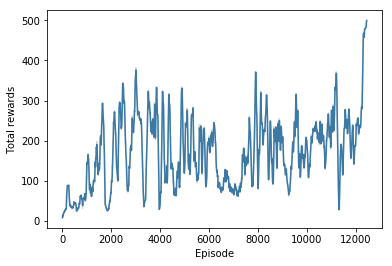

In [54]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

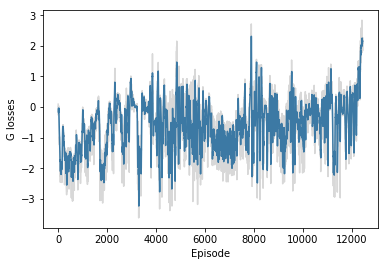

In [55]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

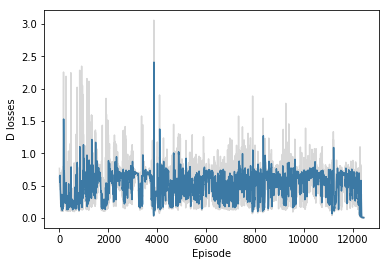

In [56]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 487.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.